In [1]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import tflearn
import ipdb as pdb
import time

for k in range(5,10):
    
    tf.reset_default_graph()
    
    print('---------' + str(k) + '------------')
    
    MAX_EPISODE = 2000
    MAX_EPISODE_LEN = 200

    NUM_T = 1
    NUM_R = 4
    SIGMA2 = 1e-9

    t_factor = 0.5
    noise_sigma = 0.12

    config = {'state_dim':3, 'action_dim':2};
    train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                    'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                    'random_seed':int(time.clock()*1000%1000), 'noise_sigma':noise_sigma, 'sigma2':SIGMA2}
    
    IS_TRAIN = False
#     rate = 3.0
    res_path = 't_M_05_nB/'
    model_path = 'model_M_05_nB/my_train_model_'+str(k)+'-2000'
    meta_path = model_path+'.meta'
    init_path = ''
    init_seqCnt = 40
    
    user_config = [{'id':'1', 'model':'AR', 'num_r':NUM_R, 'rate':1.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'2', 'model':'AR', 'num_r':NUM_R, 'rate':2.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'3', 'model':'AR', 'num_r':NUM_R, 'rate':3.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000}]
    
    if not os.path.exists(res_path):
        os.mkdir(res_path) 
    
    print(user_config)
    # 0. initialize the session object
    sess = tf.Session() 

    # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
    # sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 

    # 1. include all user in the system according to the user_config
    user_list = [];
    for info in user_config:
        info.update(config)
        info['model_path'] = model_path + '_' + info['id']
        info['meta_path'] = info['model_path']+'.meta'
        info['init_path'] = init_path
        info['init_seqCnt'] = init_seqCnt
        user_list.append(MecTermRL(sess, info, train_config))
        print('Initialization OK!----> user ' + info['id'])

    # 2. create the simulation env
    env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)

    sess.run(tf.global_variables_initializer())
    
    tflearn.config.is_training(is_training=IS_TRAIN, session=sess)

    env.init_target_network()

    res_r = []
    res_p = []
    res_b = []
    res_o = []
    res_d = []
    # 3. start to explore for each episode
    for i in range(MAX_EPISODE):

        cur_init_ds_ep = env.reset()

        cur_r_ep = np.zeros(len(user_list))
        cur_p_ep = np.zeros(len(user_list))
        cur_op_ep = np.zeros(len(user_list))
        cur_ts_ep = np.zeros(len(user_list))
        cur_ps_ep = np.zeros(len(user_list))
        cur_rs_ep = np.zeros(len(user_list))
        cur_ds_ep = np.zeros(len(user_list))
        cur_ch_ep = np.zeros(len(user_list))
        cur_of_ep = np.zeros(len(user_list))

        for j in range(MAX_EPISODE_LEN):

            # first try to transmit from current state
            [cur_r, done, cur_p, cur_op, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()

            cur_r_ep += cur_r
            cur_p_ep += cur_p
            cur_op_ep += cur_op
            cur_ts_ep += cur_ts
            cur_ps_ep += cur_ps
            cur_rs_ep += cur_rs
            cur_ds_ep += cur_ds
            cur_ch_ep += cur_ch
            cur_of_ep += cur_of


            if done:
                res_r.append(cur_r_ep/MAX_EPISODE_LEN)
                res_p.append(cur_p_ep/MAX_EPISODE_LEN)
                res_b.append(cur_ds_ep/MAX_EPISODE_LEN)
                res_o.append(cur_of_ep/MAX_EPISODE_LEN)
                res_d.append(cur_ds)
                print('%d:r:%s,p:%s,op:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s,rbuf:%s' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_op_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep, cur_ds))

    name = res_path+'test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
    np.savez(name, res_r, res_p, res_b, res_o, res_d)
    
    tflearn.config.is_training(is_training=False, session=sess)
    #Create a saver object which will save all the variables
    saver = tf.train.Saver() 
    saver.save(sess, model_path)

    sess.close()

---------5------------
[{'penalty': 1000, 'num_r': 4, 'rate': 1.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '1', 't_factor': 0.5, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 2.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '2', 't_factor': 0.5, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 3.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '3', 't_factor': 0.5, 'dis': 100}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[ -8.44839308 -13.25677285 -20.0559098 ],p:[0.77506562 0.84658142 1.17013087],op:[0.51356432 0.39565839 0.15156079],tr:[0.98957695 0.95659185 0.91806277],pr:[1.53258667 1.44120881 1.59196708],rev:[1.045 1.875 2.785],dbuf:[ 4.01048673 14.09114755 26.89490299],ch:[4.19878863 3.80223892 3.96305501],ibuf:[7.0, 20.5, 23.0],rbuf:[ 23.493843    88.97605119 133.11263983]
1:r:[  -9.62519564  -84.72824991 -124.57593295],p:[0.06767595 0.05399321 0.07123006],op:[0. 0

22:r:[ -4.38614353 -95.39966679 -86.04699606],p:[0.2357715  0.15224137 0.32772299],op:[0.0844365 0.        0.       ],tr:[0.18158541 0.55890331 0.        ],pr:[1.21968196 0.014651   1.37782541],rev:[0.87  1.975 2.995],dbuf:[  5.57020705 189.27691985 168.81676223],ch:[3.34198158 5.29768132 4.82910576],ibuf:[31.5, 41.0, 7.0],rbuf:[  3.07209933 321.28913818 330.4349189 ]
23:r:[  -3.44347177  -92.41587241 -115.75104206],p:[0.2777391  0.24171529 0.34081791],op:[0.09459771 0.         0.        ],tr:[0.25595709 0.51773165 0.        ],pr:[1.27828628 0.08678451 1.39512936],rev:[1.095 2.15  3.11 ],dbuf:[  3.16357542 182.41459191 228.09390505],ch:[5.20443377 3.65732755 3.27522508],ibuf:[15.0, 38.5, 49.0],rbuf:[  1.         347.59676911 391.97412885]
24:r:[ -45.98532657  -80.40014014 -101.21893466],p:[0.05510872 0.31777303 0.19397054],op:[0. 0. 0.],tr:[0.12716984 0.62307453 0.        ],pr:[0.03277094 0.16836676 1.09425167],rev:[0.995 1.96  2.92 ],dbuf:[ 91.41956596 157.62255001 200.49816397],ch:[4

45:r:[-55.28878648 -12.08103433 -34.3096052 ],p:[0.21337012 1.34540611 1.84007779],op:[0.         0.60884493 0.        ],tr:[0.44374936 0.60167883 0.01012451],pr:[0.         2.336729   2.44923024],rev:[1.115 2.265 3.03 ],dbuf:[108.44387173   4.61955827  50.2184325 ],ch:[3.77792004 4.16340636 4.29123203],ibuf:[45.0, 6.0, 4.5],rbuf:[179.25012771   3.         118.62905025]
46:r:[-50.29847949 -14.07171323 -28.06153055],p:[0.04603256 1.28752833 2.07474129],op:[0.         0.91461458 0.01823416],tr:[0.13793368 0.44907712 0.3368763 ],pr:[0.00827052 2.51405738 2.50926128],rev:[1.06  1.855 3.005],dbuf:[100.13663339   6.12199736  35.19330652],ch:[4.69208528 3.34027317 4.38325954],ibuf:[14.5, 44.5, 0.5],rbuf:[197.25915992   4.          35.72126847]
47:r:[-45.38922685 -15.13739829 -29.23120701],p:[0.05969413 1.48669259 2.02150909],op:[0.         0.81635218 0.        ],tr:[0.         0.53826124 0.13363265],pr:[0.59444615 2.5198421  2.5071134 ],rev:[1.025 2.105 2.82 ],dbuf:[90.18151238  7.24434882 38

68:r:[-65.45611621 -12.00358803 -61.11416702],p:[0.0066253  1.38056864 1.9953167 ],op:[0. 0. 0.],tr:[0.01752708 0.         0.1990263 ],pr:[0.07390973 2.16104921 2.48058387],rev:[0.995 2.07  3.25 ],dbuf:[130.84597939  10.20148964 102.27516703],ch:[3.86036541 3.58087723 4.36193365],ibuf:[39.0, 33.0, 24.5],rbuf:[219.71263856  14.79015827 138.57796745]
69:r:[-36.31115023 -12.23324371 -34.50568606],p:[0.04553733 1.40624058 2.06980435],op:[0. 0. 0.],tr:[2.62155557e-04 0.00000000e+00 3.84363867e-01],pr:[0.60310761 2.18289512 2.48021118],rev:[0.99  2.09  2.955],dbuf:[72.1669272  10.40408162 48.31332858],ch:[3.01658763 3.68279815 3.97560781],ibuf:[20.5, 26.5, 32.5],rbuf:[97.82604705  7.92097539 50.58498969]
70:r:[-19.41105417  -9.66164201 -40.42206271],p:[0.08097228 0.94499069 1.78440604],op:[0.         0.         0.00923887],tr:[0.         0.00186919 0.02779926],pr:[0.77524369 1.76922296 2.42627646],rev:[0.96  1.72  2.995],dbuf:[38.01238554  9.87337712 62.90767631],ch:[3.82838158 4.94763407 4.

91:r:[ -6.8410487  -13.01348604 -21.37705768],p:[0.47186403 1.91822949 2.80949002],op:[0.         0.         1.08021232],tr:[0.         1.85432105 1.93841549],pr:[1.04046916 0.40348417 2.47254146],rev:[1.045 1.925 2.99 ],dbuf:[8.96345705 6.84467721 3.85709192],ch:[3.49769228 3.41118635 3.39971914],ibuf:[10.5, 33.0, 15.5],rbuf:[11.40616894  1.80727168  3.        ]
92:r:[ -8.50405906 -14.35503566 -22.09581487],p:[0.59844918 1.9446267  2.9463984 ],op:[0.         0.         1.01316958],tr:[0.         1.54127916 1.93484329],pr:[1.14293591 0.58028251 2.51567775],rev:[1.005 1.89  2.97 ],dbuf:[11.02362632  9.26380437  4.59594991],ch:[3.68015974 2.85686761 3.99854696],ibuf:[42.0, 32.5, 27.5],rbuf:[14.41281879  5.28654948  2.        ]
93:r:[ -6.76406717 -12.95745946 -22.10884596],p:[0.37094343 1.83365641 2.73840008],op:[0.        0.        1.2310558],tr:[0.         2.07958936 2.23329794],pr:[0.8590424  0.32142693 2.50774595],rev:[0.88 1.97 2.93],dbuf:[9.81870004 7.57835482 4.52313315],ch:[3.9701

114:r:[ -4.42588831  -7.30103508 -20.31630945],p:[0.55404306 0.92479127 2.41721264],op:[0.03291977 0.0828015  1.33286027],tr:[0.01630967 0.91462507 2.0799469 ],pr:[1.28434254 1.57798311 2.50538335],rev:[1.025 1.95  2.79 ],dbuf:[2.98214838 4.52614247 3.13188986],ch:[3.14709911 4.94934286 3.99655551],ibuf:[27.0, 30.0, 11.0],rbuf:[0.29860478 1.         6.        ]
115:r:[ -3.62674513  -7.65896191 -20.31791909],p:[0.43185518 0.97384246 2.57332073],op:[0.15310173 0.0166829  1.12192002],tr:[0.34712055 0.4183538  2.2575387 ],pr:[1.42805904 1.69661487 2.45597069],rev:[1.035 1.905 3.15 ],dbuf:[1.40392121 5.41267014 3.68343072],ch:[4.68569257 3.63811443 5.29261675],ibuf:[13.0, 40.5, 2.0],rbuf:[ 2.         12.36461887  1.        ]
116:r:[ -4.51061684  -9.80151498 -21.89474769],p:[0.42731825 1.14485959 2.72687585],op:[0.23881611 0.         1.09698198],tr:[0.46732878 0.03720341 2.32822938],pr:[1.52010356 2.0338121  2.45052185],rev:[0.92  2.065 2.955],dbuf:[2.3598901  8.15443407 5.55091709],ch:[4.55

137:r:[-12.67740117 -10.64300031 -20.26252332],p:[2.05419033 1.39917155 2.47668752],op:[0.36075272 0.03948739 1.24672108],tr:[2.34315053 0.13005807 2.01702759],pr:[0.61903268 2.14891828 2.50832494],rev:[1.045 2.055 2.865],dbuf:[1.20537183 6.89941121 3.29096068],ch:[4.49270028 4.22181082 4.14726914],ibuf:[14.5, 34.5, 4.0],rbuf:[1.         6.70866464 2.05020954]
138:r:[-20.95951849  -8.97441537 -19.87087811],p:[2.19536388 1.12419535 2.74419524],op:[1.74098725 0.01699447 0.80489323],tr:[1.86630654 0.07503586 1.52640932],pr:[2.49218236 1.96001918 2.5161557 ],rev:[1.035 1.905 3.165],dbuf:[2.55552576 6.53693249 4.25087148],ch:[3.67580716 3.94514765 3.16005039],ibuf:[47.0, 30.0, 5.0],rbuf:[1.         9.46560316 3.        ]
139:r:[-20.18333756  -9.25772483 -20.72906891],p:[2.01054812 1.096684   2.72436493],op:[1.93711939 0.         0.87048498],tr:[2.43459071 0.01710207 1.7401216 ],pr:[2.49761174 2.01906228 2.46755547],rev:[0.89  2.095 2.955],dbuf:[0.89       7.54860968 5.50963879],ch:[5.381755

160:r:[ -6.93324346  -9.59982182 -21.4688398 ],p:[0.74497965 1.33390274 2.8203493 ],op:[0.         0.05422804 1.08463257],tr:[0.46952942 0.1049282  1.93901765],pr:[0.56363323 2.07954278 2.51356911],rev:[0.94  2.105 3.01 ],dbuf:[6.41669046 5.31833588 3.88786093],ch:[4.8400853  4.18488352 4.17276041],ibuf:[25.5, 15.5, 23.0],rbuf:[ 6.86747015 12.27424469  1.38188244]
161:r:[ -6.60813096 -11.81750405 -24.40291953],p:[0.70429703 1.62480378 2.9500733 ],op:[0.         0.00356594 1.0464991 ],tr:[0.53596847 0.1143288  2.10889684],pr:[0.48844405 2.22744503 2.5192065 ],rev:[0.94  2.12  3.045],dbuf:[6.17329163 7.35131094 8.84011503],ch:[5.13016493 3.97989376 4.45752064],ibuf:[21.5, 47.0, 39.0],rbuf:[4.617495   3.54289071 2.16151585]
162:r:[ -7.73876508  -9.4129388  -21.74336578],p:[0.94114902 1.37198309 2.87635588],op:[0.         0.00533954 1.10548232],tr:[0.51366384 0.09429678 1.85194039],pr:[0.71304882 2.11902775 2.51215022],rev:[1.09  2.185 3.07 ],dbuf:[6.06603992 5.05265125 3.66834963],ch:[4.2

183:r:[ -6.91397759  -9.29951722 -21.52977666],p:[0.8512341  1.31711019 2.80924352],op:[0.         0.10911369 1.14790351],tr:[0.37015009 0.00932679 1.7980337 ],pr:[0.67189958 2.19707377 2.51747964],rev:[1.03  2.05  2.865],dbuf:[5.31561414 4.33679568 3.48808305],ch:[4.23614218 4.43711273 3.78442692],ibuf:[9.5, 10.5, 5.0],rbuf:[7.0900666  6.71163023 2.        ]
184:r:[ -6.04123791  -9.14683218 -22.52683159],p:[0.73902938 1.2787316  2.78881309],op:[0.         0.21860886 1.10890545],tr:[0.46063362 0.15135238 2.30655966],pr:[0.56033098 2.20726416 2.51801302],rev:[1.045 2.03  3.075],dbuf:[4.69218201 3.32025977 6.07647779],ch:[4.89455261 4.09628396 5.0708224 ],ibuf:[0.5, 4.5, 40.5],rbuf:[5.30707917 0.         6.71337624]
185:r:[ -7.19704932  -8.89935041 -20.85790504],p:[0.91100704 1.15998016 2.62103954],op:[0.         0.28878792 1.22163695],tr:[0.42987085 0.37785097 1.91980704],pr:[0.70774028 2.10974997 2.50213085],rev:[1.085 1.98  2.865],dbuf:[5.28402827 3.31102004 3.28904513],ch:[3.2246579 

206:r:[ -4.76524616 -10.53848749 -20.91439498],p:[0.61352819 1.41606298 2.62092584],op:[0.0893562  0.03701988 1.07586032],tr:[0.35748428 0.21372884 1.90852727],pr:[0.70551333 1.9139387  2.5198421 ],rev:[0.915 2.065 2.805],dbuf:[2.50164847 6.54614632 4.86092843],ch:[4.42252258 4.22339394 3.85567684],ibuf:[10.5, 6.5, 42.0],rbuf:[0.63085761 1.         3.        ]
207:r:[ -4.75283217  -8.78369148 -21.01848936],p:[0.64994274 1.23376943 2.7795998 ],op:[0.0339073  0.12744737 0.9107412 ],tr:[0.33722753 0.71258379 1.82966965],pr:[0.86502943 1.58311962 2.51979463],rev:[1.08  2.035 3.28 ],dbuf:[2.66716395 3.95521499 5.1335687 ],ch:[4.01008413 3.91778835 3.27949099],ibuf:[13.5, 6.5, 18.5],rbuf:[0.         1.         6.48361087]
208:r:[ -5.19314707  -8.92016283 -19.62748344],p:[0.71704838 1.21313616 2.51198272],op:[0.08034045 0.05698761 1.00397799],tr:[0.33150366 0.5304624  1.84840205],pr:[0.9496876  1.62798514 2.49217238],rev:[1.12  1.895 3.05 ],dbuf:[2.4124058  5.13908793 4.09535975],ch:[3.020152

229:r:[ -5.10706609 -10.06260663 -17.12484256],p:[0.79035004 1.38138725 2.12095535],op:[0.0110964  0.06919271 0.01233506],tr:[0.57060631 0.73059237 0.340947  ],pr:[0.70598431 1.57926329 2.44265426],rev:[1.05 2.02 2.84],dbuf:[ 2.19966769  5.61941362 12.91678104],ch:[3.59465863 4.0343773  3.36542472],ibuf:[24.5, 39.5, 2.5],rbuf:[ 0.          1.43618226 15.37218656]
230:r:[ -5.02727691  -8.22938881 -18.32392124],p:[0.77848144 1.11851316 2.21202634],op:[0.        0.0524521 0.       ],tr:[0.7606418  0.41446833 0.5535488 ],pr:[0.48745927 1.46603447 2.37315033],rev:[0.985 1.745 2.92 ],dbuf:[ 2.2697394   4.74912506 14.52757912],ch:[3.89335138 3.73047739 4.22139525],ibuf:[18.5, 21.0, 14.5],rbuf:[ 1.58304316  4.31667371 13.16017323]
231:r:[ -3.98658655 -11.27284813 -17.81381492],p:[0.58786219 1.56213937 2.16728191],op:[0.02862023 0.00944197 0.01683321],tr:[0.89423486 0.41043779 0.47541967],pr:[0.5192734  1.94565661 2.37135589],rev:[1.065 2.175 2.785],dbuf:[ 1.80834887  6.82988292 13.78647864],ch

252:r:[ -3.57818804 -10.39599485 -19.20729389],p:[0.45334246 1.48329459 2.35874799],op:[0.06334118 0.0835818  0.07352028],tr:[0.09864787 0.16191558 0.59380678],pr:[1.33123306 2.05087001 2.5198421 ],rev:[0.935 2.13  2.96 ],dbuf:[ 1.98953971  5.12322586 14.0919051 ],ch:[3.73518304 4.36329877 4.2713371 ],ibuf:[34.5, 4.5, 35.0],rbuf:[ 1.          2.         15.69982649]
253:r:[ -4.86371093  -9.63793637 -19.02059887],p:[0.66518515 1.47688135 2.42649414],op:[0.01056091 0.00193648 0.06588069],tr:[0.12948489 0.10200681 0.72019378],pr:[1.19267628 1.91920092 2.5198421 ],rev:[1.045 1.875 3.13 ],dbuf:[ 2.96996123  4.48769443 13.11744946],ch:[2.82879151 4.09572396 4.25323615],ibuf:[43.0, 31.5, 30.5],rbuf:[ 2.98258819  2.43910993 18.0089589 ]
254:r:[ -4.62655844 -11.71769235 -21.73242303],p:[0.67833244 1.62169279 2.68558348],op:[0.00895952 0.0459916  0.        ],tr:[0.         0.30665242 0.74136828],pr:[1.15116197 1.91204718 2.5198421 ],rev:[1.065 1.96  3.205],dbuf:[ 2.38019736  6.75854083 16.609011

275:r:[ -4.88218024 -10.27119376 -22.26683333],p:[0.6894199  1.36036522 2.64519224],op:[0.00591873 0.23362248 0.        ],tr:[0.31257289 0.31387556 0.6044632 ],pr:[0.98715551 2.1826071  2.5198421 ],rev:[0.995 1.985 3.07 ],dbuf:[ 2.81097421  4.60251047 18.08174423],ch:[4.29065446 3.78050567 3.45151053],ibuf:[41.0, 33.0, 26.5],rbuf:[ 3.          1.15494366 15.63893986]
276:r:[ -3.96043902  -9.54382927 -22.36297214],p:[0.60176927 1.28446967 2.67631035],op:[0.01573717 0.32758933 0.        ],tr:[0.37959473 0.31776565 0.52468107],pr:[0.62599816 2.18872041 2.51536951],rev:[0.94  2.02  2.955],dbuf:[ 1.74581373  2.9670686  17.96284082],ch:[4.28179131 3.42863013 3.42052668],ibuf:[6.0, 10.0, 30.0],rbuf:[ 2.34485033  4.30734278 12.9898852 ]
277:r:[ -4.44256555  -9.16921141 -18.43357568],p:[0.66998254 1.11394474 2.23674605],op:[0.02516995 0.4850617  0.        ],tr:[0.33283717 0.8517987  0.26376862],pr:[0.77772773 2.0167125  2.5120788 ],rev:[1.005 1.855 2.745],dbuf:[ 1.93360622  2.34835839 14.499690

298:r:[ -3.15508191  -9.6522952  -22.68545556],p:[0.41958057 1.34742933 2.58479452],op:[0.07832853 0.12341468 0.        ],tr:[0.         0.24933016 0.59122532],pr:[1.29800754 2.13993657 2.5198421 ],rev:[0.95  2.045 2.975],dbuf:[ 1.33107279  4.59615031 19.52296592],ch:[3.91249259 4.13397215 3.67224525],ibuf:[4.0, 33.5, 46.0],rbuf:[ 1.          4.60926352 18.78651597]
299:r:[ -4.01717199  -8.44919234 -22.93936252],p:[0.5237909  1.15439223 2.60007524],op:[0.07440941 0.22798582 0.        ],tr:[0.03797739 0.48846451 0.60624047],pr:[1.42363938 2.02500506 2.5198421 ],rev:[1.02  2.025 3.02 ],dbuf:[ 2.05234093  3.07460419 19.87797269],ch:[4.75901501 4.46762915 3.61361766],ibuf:[27.5, 11.5, 45.0],rbuf:[ 2.          1.43846123 23.78348528]
300:r:[ -4.67751696  -9.69678787 -20.12813946],p:[0.68279907 1.43482574 2.24024106],op:[0.00742143 0.0316942  0.07107173],tr:[0.06669783 0.08653467 0.40187104],pr:[1.15327454 2.14091522 2.50377897],rev:[0.98  2.08  2.815],dbuf:[ 2.45282887  4.72837633 17.143151

321:r:[ -4.9243248  -11.81987231 -19.96641808],p:[0.62120181 1.43726577 2.4795269 ],op:[0.25610571 0.00078116 0.00526578],tr:[0.64577921 0.13691376 0.58713647],pr:[1.42837858 2.07785898 2.5198421 ],rev:[1.02  1.995 2.99 ],dbuf:[ 1.07557434  9.25927531 15.08490939],ch:[3.95412606 3.84236589 3.2129438 ],ibuf:[7.5, 46.5, 37.0],rbuf:[ 0.          2.93918912 14.16021315]
322:r:[ -3.90931675  -9.55513817 -22.43869781],p:[0.53568586 1.20579142 2.4679201 ],op:[0.12968138 0.         0.        ],tr:[0.55968833 0.51938543 0.73013115],pr:[1.14082921 1.6579935  2.5198421 ],rev:[0.96 1.95 3.15],dbuf:[ 1.16496105  7.05236214 20.19819462],ch:[3.66423058 3.2698956  5.17483661],ibuf:[15.5, 49.0, 38.5],rbuf:[ 2.          4.34577403 18.50534996]
323:r:[ -4.40731457  -9.785689   -21.47898838],p:[0.5514299  1.28823111 2.36885775],op:[0.1293228 0.        0.       ],tr:[0.17123348 0.12340081 0.43718398],pr:[1.45728257 2.06019672 2.51328457],rev:[0.97 2.19 3.  ],dbuf:[ 2.00710212  6.68906691 19.26939926],ch:[4

344:r:[ -5.97972388 -10.80218433 -22.70501573],p:[0.75980119 1.35569789 2.42865773],op:[0.2800269  0.00890478 0.        ],tr:[0.77793882 0.25501981 0.44204532],pr:[1.45556821 2.02122965 2.5198421 ],rev:[0.81  2.1   2.955],dbuf:[ 1.56116685  7.95834196 21.12345418],ch:[3.51274601 4.84891659 4.03128942],ibuf:[36.0, 32.5, 18.5],rbuf:[ 0.          4.19843615 17.12251515]
345:r:[ -5.60128954  -9.11612877 -23.52679633],p:[0.72074041 1.27017147 2.41025263],op:[0.18888737 0.         0.        ],tr:[0.64374129 0.11194144 0.39947212],pr:[1.10125722 1.98456522 2.51897543],rev:[0.98 1.9  2.91],dbuf:[ 2.10630129  5.53054281 22.95106632],ch:[4.16155367 3.86221383 4.02545595],ibuf:[39.5, 43.5, 26.0],rbuf:[ 0.          4.19866695 24.31048934]
346:r:[ -4.33551943 -10.95800994 -25.68646679],p:[0.59572313 1.37562195 2.64802194],op:[0.15362079 0.         0.        ],tr:[0.69824337 0.08477713 0.74935512],pr:[0.65164863 2.08435553 2.5198421 ],rev:[0.955 2.06  3.16 ],dbuf:[ 1.17759964  8.15980039 24.89271414

367:r:[ -4.35218349 -11.16951316 -22.56039418],p:[0.55730125 1.1248507  2.21799425],op:[0.19705011 0.01658367 0.        ],tr:[0.38600337 0.83119756 0.3740907 ],pr:[1.40374612 1.38973622 2.48561814],rev:[1.095 2.12  2.795],dbuf:[ 1.16085335 10.92468266 22.94084589],ch:[3.88433724 3.89417476 3.84407818],ibuf:[2.0, 26.5, 31.0],rbuf:[ 1.         10.79970348 18.05823038]
368:r:[ -3.47692934 -10.03719726 -25.23475664],p:[0.45992166 0.91664101 2.49271016],op:[0.12267442 0.         0.        ],tr:[0.2391549  0.87659357 0.84817776],pr:[1.15299042 1.12400966 2.46632158],rev:[0.9   1.965 3.33 ],dbuf:[ 1.12789796 10.90798441 25.54241165],ch:[3.13235733 3.66363958 4.74119182],ibuf:[8.0, 16.0, 23.5],rbuf:[ 2.74043689  8.87935538 26.60013138]
369:r:[ -5.2203163   -7.48505996 -24.87642758],p:[0.70564032 0.79880518 2.37689638],op:[0.09337734 0.04551873 0.        ],tr:[0.26937985 0.91713616 0.79249469],pr:[1.05104206 1.41671783 2.42589971],rev:[0.98  2.025 3.125],dbuf:[ 2.45045593  6.52688074 25.9838913

390:r:[ -4.77229542 -12.71434838 -18.02825281],p:[0.63574967 1.20460821 2.14080373],op:[0.07566504 0.         0.09952189],tr:[0.07423366 0.05515109 0.59404285],pr:[1.37425605 1.98555533 2.41837244],rev:[0.995 1.985 2.96 ],dbuf:[ 2.43044377 13.3826147  13.65324948],ch:[4.90696713 3.62645542 4.32662173],ibuf:[36.5, 25.0, 14.5],rbuf:[ 0.27354816 13.85871632 23.48400534]
391:r:[ -4.19978677 -15.41488271 -24.85683681],p:[0.63668944 1.43740587 2.65272277],op:[0.04958918 0.         0.        ],tr:[1.84871919e-04 2.60566371e-01 6.10781481e-01],pr:[1.0628103  1.88112329 2.50961632],rev:[0.995 1.99  3.145],dbuf:[ 1.53678734 16.45570676 23.18644596],ch:[4.7511833  2.86998169 2.95364294],ibuf:[1.0, 48.5, 29.5],rbuf:[ 0.29262198 18.16206851 34.4204395 ]
392:r:[ -4.47532917 -11.45100248 -25.22082322],p:[0.6749104  0.84694317 2.50689023],op:[0.02268705 0.         0.        ],tr:[0.00172668 0.28998169 0.57305744],pr:[1.03203238 1.44296114 2.5198421 ],rev:[0.955 1.795 3.1  ],dbuf:[ 1.97468384 14.432573

413:r:[ -4.01472916 -15.29597644 -25.1535158 ],p:[0.58351386 1.35146379 2.39358189],op:[0.06807949 0.         0.        ],tr:[0.24594743 0.17813559 0.58334293],pr:[0.82052079 2.02755573 2.51979444],rev:[0.925 2.025 3.   ],dbuf:[ 1.51352485 17.07731501 26.37121264],ch:[3.4742736  3.43945583 4.66514365],ibuf:[11.5, 49.0, 43.5],rbuf:[ 0.87507649 12.86173606 22.87252651]
414:r:[ -3.75349712 -13.86418579 -26.11932706],p:[0.54123939 1.05079174 2.49039062],op:[0.06491504 0.         0.        ],tr:[0.26009979 0.05204727 0.69041845],pr:[0.91128217 1.8621059  2.51684531],rev:[0.945 1.965 3.25 ],dbuf:[ 1.44544993 17.22045417 27.33474788],ch:[3.04699726 4.90600189 4.36126544],ibuf:[12.5, 6.0, 17.5],rbuf:[ 1.40546552 16.16936636 26.04724876]
415:r:[ -5.32847693 -14.64622589 -18.38374652],p:[0.7958899  1.22203877 1.97572995],op:[0.08290197 0.         0.06658955],tr:[0.19419495 0.06774463 0.37857513],pr:[1.24432885 2.02261392 2.4549675 ],rev:[1.28  1.985 2.905],dbuf:[ 1.86903516 17.07206412 16.344297

436:r:[ -3.67552046 -13.52484077 -14.49411273],p:[0.42058076 1.11980303 1.7753103 ],op:[0.19139552 0.         0.65503321],tr:[0.23885218 0.02236145 0.9007046 ],pr:[1.50942307 1.91951475 2.50986469],rev:[0.915 2.    2.785],dbuf:[ 1.23127812 15.8516512   4.68479038],ch:[4.69676501 3.40111258 4.44865987],ibuf:[12.0, 7.5, 8.0],rbuf:[ 3.         19.12475989 11.98344569]
437:r:[ -6.18670815 -16.72536882 -16.09356212],p:[0.63419755 1.38223014 2.09186333],op:[0.37414737 0.         0.1099396 ],tr:[0.31120811 0.13299198 0.5990666 ],pr:[1.84020212 2.04779393 2.46445447],rev:[1.08 2.09 2.84],dbuf:[ 2.28996718 19.62843621 10.16909492],ch:[4.85872282 3.39143366 3.59174862],ibuf:[39.5, 41.0, 28.5],rbuf:[ 4.         22.84281792  6.08979897]
438:r:[ -4.75277726 -12.8113771  -19.49595079],p:[0.4828123 0.9473701 2.251076 ],op:[0.31490364 0.         0.        ],tr:[0.01890933 0.01547746 0.56170969],pr:[1.78274128 1.80254158 2.50029729],rev:[0.98 1.86 3.05],dbuf:[ 1.52839514 16.14905316 16.48114162],ch:[4.

459:r:[ -4.48723719 -14.62164901 -22.16059802],p:[0.5555157  1.29736579 2.47567431],op:[0. 0. 0.],tr:[0.08016664 0.10231062 0.53753669],pr:[1.23882764 2.05165119 2.49195417],rev:[1.125 2.07  3.045],dbuf:[ 3.4193174  16.26964016 19.56445298],ch:[3.90396759 3.74826459 3.13208454],ibuf:[39.5, 34.5, 21.0],rbuf:[ 0.70114259 17.70763647 24.10182795]
460:r:[ -3.18982624 -12.69950445 -21.04712795],p:[0.43035962 1.04163561 2.27749879],op:[0.01330952 0.         0.        ],tr:[0.16871267 0.03454959 0.34933881],pr:[0.93099695 1.91180059 2.51434505],rev:[0.94  2.    2.755],dbuf:[ 1.94296108 14.98265281 19.31926797],ch:[3.61661625 3.94871691 4.3618698 ],ibuf:[22.0, 7.0, 35.0],rbuf:[ 0.         17.729965   13.26322739]
461:r:[ -4.17367244 -13.43001613 -22.43834528],p:[0.52930042 1.14184903 2.2607348 ],op:[0.12557682 0.         0.02773517],tr:[0.43985849 0.06044973 0.50156612],pr:[1.38258971 1.97398796 2.44635271],rev:[1.02  2.03  3.065],dbuf:[ 1.79857256 15.44154198 21.99199087],ch:[4.30071795 4.215

482:r:[ -3.58629173 -14.64821094 -19.48075881],p:[0.45120837 1.23145465 2.37695368],op:[0.06682532 0.         0.        ],tr:[0.067159   0.10766393 0.39793872],pr:[1.31713033 1.93718903 2.49117196],rev:[0.945 2.03  2.94 ],dbuf:[ 1.99224655 16.98187534 15.19198081],ch:[3.54314265 3.71690409 3.65001337],ibuf:[33.0, 16.5, 7.5],rbuf:[ 0.         13.52940847 17.67786477]
483:r:[ -2.73309862 -11.73630341 -21.96025064],p:[0.32547055 0.9735929  2.35184109],op:[0.09538912 0.         0.        ],tr:[0.00749442 0.33868408 0.47857043],pr:[1.39957171 1.52333164 2.47747814],rev:[0.975 1.81  2.945],dbuf:[ 1.25760058 13.73667779 20.40209036],ch:[4.22567556 3.30849141 3.70840656],ibuf:[6.5, 26.0, 21.5],rbuf:[ 1.93564029 15.59685567 19.29028574]
484:r:[ -3.49930117 -12.15093642 -21.63549077],p:[0.46551773 0.9948643  2.33437121],op:[0.04672019 0.         0.        ],tr:[0.05389539 0.53656227 0.37826   ],pr:[1.4012837  1.5026823  2.47291851],rev:[1.035 1.99  2.85 ],dbuf:[ 1.87622311 14.35322988 19.9272694

505:r:[ -5.14633501 -13.2576966  -19.14997828],p:[0.54361702 1.19128418 2.23201993],op:[0.25683913 0.         0.        ],tr:[0.06787241 0.25969738 0.50386621],pr:[1.74513273 1.76642555 2.42899396],rev:[0.94 1.84 2.83],dbuf:[ 2.28810852 14.60255143 15.97975725],ch:[4.77637705 3.19421387 3.58652246],ibuf:[41.5, 46.5, 37.0],rbuf:[ 0.89373564  9.27541402 16.42796584]
506:r:[ -4.95724302 -13.22662614 -21.20556838],p:[0.55025595 1.12051987 2.33758944],op:[0.23539224 0.         0.00885895],tr:[0.05573425 0.29729069 0.55314237],pr:[1.74804553 1.63351277 2.45110849],rev:[1.045 1.945 3.105],dbuf:[ 2.05800407 15.24805357 18.94665289],ch:[4.87594476 3.95619291 3.34849304],ibuf:[33.5, 13.5, 0.0],rbuf:[ 1.         16.33930661 22.56993275]
507:r:[ -3.60491718 -16.58382807 -18.35860056],p:[0.39697304 1.56052407 2.20327873],op:[0.19310084 0.         0.00184899],tr:[0.01333881 0.18595326 0.5632579 ],pr:[1.59840808 2.12614656 2.45756519],rev:[0.97  2.205 2.945],dbuf:[ 1.30909557 17.56241548 14.66592395]

528:r:[ -3.83847048 -14.76221132 -21.41347039],p:[0.44401398 1.44222941 2.6295699 ],op:[0.         0.         0.02219841],tr:[0.09532599 0.08666104 0.94242526],pr:[1.11470436 2.10453976 2.4447749 ],rev:[1.15  2.095 3.17 ],dbuf:[ 3.23680117 15.1021285  16.30925761],ch:[4.39878587 3.80960855 3.53519912],ibuf:[15.5, 33.0, 45.5],rbuf:[ 3.49392997 13.75983978  5.33528313]
529:r:[ -4.09207533 -11.79790422 -19.11067783],p:[0.4509846  1.06086575 2.39428951],op:[0.         0.         0.06088398],tr:[0.20096446 0.0225939  0.65523899],pr:[1.03999016 1.87910977 2.51483827],rev:[1.01 1.86 3.06],dbuf:[ 3.67430466 12.9871509  13.6696208 ],ch:[4.1974178  3.64974848 3.86424346],ibuf:[49.0, 22.0, 21.0],rbuf:[ 3.13204592 13.65926625  7.43442122]
530:r:[ -2.95203074 -13.83795145 -13.76386199],p:[0.3611159  1.30299496 1.9007689 ],op:[4.21195979e-05 0.00000000e+00 3.35666276e-01],tr:[0.04507674 0.16970253 0.53567462],pr:[1.03186198 2.01122228 2.5198421 ],rev:[0.96  2.045 2.805],dbuf:[ 2.29248128 14.6459533 

551:r:[ -3.39161807 -10.68642987 -18.3333905 ],p:[0.51047799 0.93642951 2.22987551],op:[0.05980376 0.         0.23562174],tr:[0.75144521 0.35965105 0.76189009],pr:[0.79435465 1.61927322 2.5198421 ],rev:[0.97 1.88 2.9 ],dbuf:[ 1.08041859 12.0085646  12.01180851],ch:[4.42491921 3.9358094  4.59979987],ibuf:[8.0, 33.0, 45.0],rbuf:[ 2.         13.21514695 13.4404737 ]
552:r:[ -3.05184108 -11.93881676 -17.18201722],p:[0.47782261 1.09923607 2.08956492],op:[0.02056063 0.         0.15989563],tr:[0.46647346 0.05537073 0.53233204],pr:[0.7833677  1.91887758 2.51474377],rev:[0.95  1.93  2.945],dbuf:[ 1.11984974 12.88527281 11.86942885],ch:[3.03517881 4.44203517 4.10482632],ibuf:[2.0, 21.0, 2.5],rbuf:[ 1.         12.1503385   5.76344755]
553:r:[ -4.87532025 -12.13732966 -14.89393289],p:[0.62048958 1.25246573 1.9800113 ],op:[0.14426805 0.         0.11935792],tr:[0.41243103 0.05674327 0.4159061 ],pr:[1.5368607  2.03935957 2.49499501],rev:[1.15  2.01  2.895],dbuf:[ 2.10306428 11.75000202  8.79417359],c

574:r:[ -3.65281774  -8.86058848 -18.46534487],p:[0.43907258 1.03006089 2.23697178],op:[0.00051056 0.         0.23258824],tr:[0.0297438  0.01536604 0.86970657],pr:[1.24815889 1.8123691  2.50948105],rev:[1.2   1.765 3.01 ],dbuf:[ 2.90980406  7.42056805 12.23508955],ch:[4.86004769 3.78384946 4.09606057],ibuf:[15.0, 20.0, 48.5],rbuf:[ 1.22875431  7.45297241 10.83857554]
575:r:[ -2.71066112 -14.01506769 -15.21950692],p:[0.35150357 1.49689407 1.89416017],op:[0.01753255 0.         0.33384295],tr:[0.04741173 0.15010714 0.65216325],pr:[1.16285779 2.0986329  2.48791214],rev:[1.075 2.105 2.81 ],dbuf:[ 1.73096097 13.06119466  8.15898269],ch:[3.05061403 4.85439015 4.54389871],ibuf:[6.5, 45.0, 22.5],rbuf:[ 3.         16.25199242 13.23012882]
576:r:[ -3.67714043 -12.50911053 -18.36796883],p:[0.43889238 1.42754066 2.24992041],op:[0.17737628 0.00106978 0.14824644],tr:[0.46548606 0.08060636 0.70537135],pr:[1.42248686 2.14523207 2.49045397],rev:[1.065 2.04  2.91 ],dbuf:[ 1.19159421 10.73211659 12.754269

597:r:[ -2.88815593 -12.37020627 -14.39097466],p:[0.30435531 1.41835001 2.09184898],op:[0.         0.         0.16194793],tr:[0.0525122 0.1105821 0.6807931],pr:[0.9447909  2.13642892 2.50321029],rev:[0.95  2.075 3.07 ],dbuf:[ 2.73275878 10.55691243  6.24398023],ch:[3.80654236 4.53167386 4.2254443 ],ibuf:[12.0, 42.5, 4.5],rbuf:[2.53938073 8.09779553 6.47990641]
598:r:[ -3.25808492 -12.44803584 -16.15046435],p:[0.41249789 1.38847354 2.26759994],op:[0.         0.         0.02270904],tr:[0.24278875 0.13817265 0.62785347],pr:[0.88306682 2.0922174  2.50471627],rev:[1.02 2.03 3.1 ],dbuf:[ 2.39119096 11.0113363   9.3978389 ],ch:[3.81662022 4.21392284 3.8407591 ],ibuf:[18.5, 45.5, 9.0],rbuf:[1.2056221  5.42199027 4.97634178]
599:r:[ -4.22734147  -8.99711532 -16.21117488],p:[0.54128195 1.02218604 2.16243588],op:[0.00107006 0.         0.1443513 ],tr:[0.47892426 0.         0.74625491],pr:[0.80504226 1.92685905 2.50207798],rev:[1.01 1.9  3.17],dbuf:[3.03116284 7.7723702  9.35447792],ch:[3.90334711 

620:r:[ -2.64428188 -14.28949887 -15.53505827],p:[0.29645263 1.3210144  1.83638703],op:[0.00032033 0.         0.01937467],tr:[0.         0.23494753 0.72254651],pr:[1.07533892 1.98935049 2.29724718],rev:[1.045 2.1   2.935],dbuf:[ 2.32083416 15.36885377 12.51249957],ch:[3.35350741 5.1364694  3.99994042],ibuf:[8.5, 33.5, 19.0],rbuf:[2.51520652 8.64039506 5.        ]
621:r:[ -2.78422844 -10.87995063 -12.10513622],p:[0.32221062 1.08253569 1.67458904],op:[0.02443497 0.         0.22325311],tr:[0.01257017 0.04902222 0.60635075],pr:[1.24008511 1.93056449 2.33520845],rev:[1.05 1.91 2.8 ],dbuf:[ 2.10200101 10.93454432  5.23185095],ch:[4.05964365 3.39493412 3.75630428],ibuf:[13.0, 21.0, 0.0],rbuf:[ 1.61368875  7.08265825 16.63794781]
622:r:[ -3.37580255 -11.63174226 -17.69258952],p:[0.3430014  1.16273049 2.00387912],op:[0.00551884 0.         0.08227749],tr:[0.1418363  0.05442923 0.85659591],pr:[0.96556491 2.00970766 2.29075926],rev:[0.81  2.005 2.93 ],dbuf:[ 3.2664027  11.63617958 14.5236129 ],ch:

643:r:[ -3.04243017 -12.44917998 -15.49433791],p:[0.37604591 1.2130018  2.06965131],op:[0.01750311 0.         0.20764138],tr:[0.04603873 0.18625934 0.84450207],pr:[1.25366404 1.90395094 2.44159974],rev:[1.08  1.93  2.945],dbuf:[ 2.14937014 12.76834192  8.21574894],ch:[3.41603717 3.96801466 4.94355198],ibuf:[21.5, 40.0, 38.5],rbuf:[4.1625053  7.95794298 1.12104394]
644:r:[ -3.37665354 -11.56307989 -18.40360262],p:[0.37235393 1.19544414 2.26250226],op:[0.00569257 0.         0.16405298],tr:[0.09743899 0.07165317 0.89555155],pr:[1.03238611 2.00438709 2.48110113],rev:[0.86  2.04  3.095],dbuf:[ 2.97284212 11.17171839 12.54165283],ch:[4.38693125 4.15564356 4.17433068],ibuf:[44.5, 21.5, 34.0],rbuf:[ 2.         14.29194789  4.        ]
645:r:[ -4.30109606 -12.4420808  -17.25421156],p:[0.52139776 1.21203807 2.21126082],op:[0.02304708 0.         0.13874162],tr:[0.09816069 0.21540878 0.87048579],pr:[1.35544453 1.9251745  2.45070104],rev:[1.07  1.965 3.095],dbuf:[ 3.15774375 12.76378088 11.00839879

666:r:[ -2.8320459  -13.67024215 -16.86740791],p:[0.33269062 1.35413512 2.21948093],op:[0.09756625 0.         0.18496608],tr:[0.02965149 0.10258823 0.75000036],pr:[1.37325199 2.10802736 2.46438433],rev:[0.87  2.205 2.975],dbuf:[ 1.36152307 13.79913308  9.69034568],ch:[2.27342171 3.72559164 3.76187105],ibuf:[22.0, 16.0, 19.0],rbuf:[ 2.         14.87688276  2.4801579 ]
667:r:[ -3.13336992 -11.36011193 -20.11460695],p:[0.3592935  1.10596551 2.38431293],op:[0.11406804 0.         0.08305645],tr:[0.         0.01811566 0.92280164],pr:[1.48816467 2.00205127 2.45315021],rev:[1.06  1.955 3.095],dbuf:[ 1.53312447 11.66056881 15.55552013],ch:[3.59528683 5.49782946 3.64419645],ibuf:[4.5, 24.0, 46.0],rbuf:[ 2.         10.96661535  1.89891855]
668:r:[ -2.97881992 -13.27800734 -18.1568667 ],p:[0.35547172 1.2900855  2.20680075],op:[0.00827959 0.         0.10827683],tr:[0.0518185  0.11738458 0.6433318 ],pr:[1.13744416 2.04362867 2.48412975],rev:[1.025 1.97  2.85 ],dbuf:[ 2.32012683 13.65515967 13.162957

689:r:[ -4.32859924 -10.92246027 -17.26813354],p:[0.44015354 1.02168173 2.20069762],op:[0.25230961 0.         0.04853775],tr:[0.07923363 0.1597848  0.77772285],pr:[1.68568226 1.88360994 2.45201496],rev:[0.985 1.925 3.035],dbuf:[ 1.73256697 11.6281032  12.04391333],ch:[4.7064877  5.40111756 4.16846419],ibuf:[33.0, 27.5, 43.5],rbuf:[ 3.08627127  3.8210529  11.75853044]
690:r:[ -5.56123662 -10.50564694 -15.50958702],p:[0.60317918 1.05244595 2.12326212],op:[0.27069623 0.00044283 0.08756593],tr:[0.11542078 0.43510357 0.68643891],pr:[1.81639924 1.81071558 2.46887551],rev:[1.1   2.145 3.02 ],dbuf:[ 2.38371914 10.48240616  8.91089355],ch:[3.86187518 5.88549205 4.08080203],ibuf:[44.5, 30.0, 21.0],rbuf:[ 2.         10.1112812   8.40827038]
691:r:[ -3.81227229  -9.98579906 -14.09873868],p:[0.39607413 0.84055707 2.0830915 ],op:[0.21620864 0.         0.09498538],tr:[0.04163228 0.59980552 0.61653115],pr:[1.61480098 1.51905405 2.47880742],rev:[0.99  2.    3.045],dbuf:[ 1.50171693 11.56602738  6.41670

712:r:[ -2.41965606  -7.40884232 -16.19117649],p:[0.30755928 0.88945178 2.17479294],op:[0.00025365 0.07165515 0.08350775],tr:[0.41586113 0.26741594 0.70537078],pr:[0.58198483 1.8611301  2.44811153],rev:[0.93  1.86  2.915],dbuf:[1.76118283 5.20661536 9.79934613],ch:[3.72426251 5.22581567 3.58046085],ibuf:[6.5, 11.0, 47.0],rbuf:[ 3.32039328  5.18001818 10.86848012]
713:r:[ -2.48571757  -8.14484975 -14.02128974],p:[0.30712799 1.01384076 1.98092723],op:[0.         0.14400634 0.15614652],tr:[0.39085496 0.56940284 0.78521454],pr:[0.616845   1.89757502 2.40613681],rev:[0.95 1.94 3.02],dbuf:[1.90015528 4.71122846 6.67184196],ch:[4.69913673 4.05529125 5.0420916 ],ibuf:[6.5, 44.5, 15.0],rbuf:[1.76139565 4.         5.23063993]
714:r:[ -2.70504946  -7.83272454 -13.3005984 ],p:[0.36364535 0.9697513  1.81350606],op:[0.00178317 0.11446087 0.12394419],tr:[0.62641611 0.99778614 0.79826806],pr:[0.57741826 1.70476316 2.31104913],rev:[1.075 2.11  2.825],dbuf:[1.75581374 4.82332737 7.22669438],ch:[5.078117

735:r:[ -4.70247562 -10.61197845 -15.95418585],p:[0.56786616 1.17186925 2.19748435],op:[0.0576372  0.02575112 0.17563525],tr:[0.10245406 0.31123645 0.9278669 ],pr:[1.44704335 1.9957103  2.4543969 ],rev:[1.015 2.11  3.125],dbuf:[3.14991766 9.24775325 8.17717573],ch:[3.77574132 4.22685594 4.52841556],ibuf:[45.0, 30.0, 37.0],rbuf:[ 2.17568821  1.         13.15818941]
736:r:[ -3.93968789  -5.76040395 -18.78636622],p:[0.50077104 0.74734766 2.35604739],op:[0.0923246  0.04200382 0.11729963],tr:[0.36144842 0.6089147  1.05570407],pr:[1.34231682 1.51833952 2.40712053],rev:[0.975 1.925 3.185],dbuf:[ 1.94841939  3.62729308 12.83926223],ch:[4.06808671 4.81727116 4.05252195],ibuf:[35.0, 5.5, 39.0],rbuf:[1.40102351 3.22185984 2.48061819]
737:r:[ -2.89349849  -7.83174476 -14.18112243],p:[0.33681392 0.90224907 1.9642727 ],op:[0.11959438 0.03037764 0.14869468],tr:[0.21603166 0.84794884 0.88792261],pr:[1.37470197 1.4215541  2.35555646],rev:[1.   2.02 3.08],dbuf:[1.22291404 6.33722242 7.23257106],ch:[3.82

758:r:[ -4.62439203 -15.42750722 -14.33218964],p:[0.5823829  1.39850092 1.99896744],op:[0.00252612 0.00379593 0.36842653],tr:[0.52425045 0.35274874 0.68790182],pr:[0.82826337 2.01563857 2.51476658],rev:[1.01  2.215 2.925],dbuf:[ 3.39969388 16.83204589  4.99043952],ch:[4.04556191 5.12697308 4.35022345],ibuf:[47.5, 32.0, 4.5],rbuf:[0.94260134 4.26658372 2.51527409]
759:r:[ -2.84984116  -5.95992093 -16.13047704],p:[0.43207633 0.71922075 2.14515107],op:[0.01021322 0.01749733 0.25988913],tr:[0.69740942 0.23917782 0.78482689],pr:[0.54528074 1.69342162 2.49933583],rev:[0.94  1.865 2.975],dbuf:[1.27678686 4.552661   8.21055203],ch:[4.17721046 3.88648461 3.47057985],ibuf:[12.0, 7.5, 29.0],rbuf:[1.         2.93573815 3.57363725]
760:r:[ -3.19311118  -8.48083722 -16.90893568],p:[0.39873544 0.80740239 2.21696194],op:[0.         0.01523268 0.34030949],tr:[0.33362376 0.30970835 0.92646046],pr:[0.74848734 1.68620959 2.5198421 ],rev:[0.945 2.    2.965],dbuf:[2.39886791 8.73532369 8.24515698],ch:[3.349

781:r:[ -3.84699792  -8.0640419  -17.36706197],p:[0.44500178 0.86996347 2.14659292],op:[0.13902803 0.00203438 0.56263838],tr:[0.10756095 0.69090832 1.2831674 ],pr:[1.55415267 1.53605705 2.5198421 ],rev:[1.05 2.03 3.09],dbuf:[1.85369779 7.40810531 7.64181098],ch:[3.98948422 4.38675419 4.87188321],ibuf:[27.5, 39.0, 47.0],rbuf:[0.39333114 2.13474164 9.81821901]
782:r:[ -3.29629781  -7.66616541 -16.23379231],p:[0.3915781  0.97483214 2.36149628],op:[0.12088042 0.01897428 0.19988132],tr:[0.19559396 0.53770933 0.80125309],pr:[1.39813857 1.63011958 2.5198421 ],rev:[0.975 1.965 3.05 ],dbuf:[1.46801042 5.39426663 6.85380858],ch:[3.11552817 4.60245223 3.64885226],ibuf:[23.5, 35.0, 25.5],rbuf:[1.         5.74652208 5.        ]
783:r:[ -3.17770591 -10.12375327 -15.0754753 ],p:[0.35999603 0.9222621  2.15532232],op:[0.01251949 0.         0.25600487],tr:[0.16426068 0.54634681 0.83616606],pr:[1.10081192 1.67032759 2.5198421 ],rev:[0.95 2.15 3.08],dbuf:[ 2.63025666 11.02488551  6.03767868],ch:[4.8480984

804:r:[ -3.82329285 -15.03255524 -16.76720596],p:[0.390191   1.28288109 2.27518598],op:[0.01780969 0.         0.31511806],tr:[0.09456733 0.78136117 0.89416177],pr:[1.17563383 1.40302201 2.49999934],rev:[1.    2.08  3.065],dbuf:[ 3.56657878 17.23629962  7.63137155],ch:[4.35476832 4.02880988 3.58103827],ibuf:[35.5, 43.0, 17.0],rbuf:[ 0.49167602 22.12336369  6.07296414]
805:r:[ -3.71855536 -14.51430775 -16.30205741],p:[0.45500867 1.41917165 2.06082411],op:[0.10286452 0.         0.6294872 ],tr:[0.43017019 0.47619605 1.08062325],pr:[1.30146971 1.67815193 2.51968781],rev:[0.97  2.065 3.075],dbuf:[ 1.85837883 14.83689903  5.70100174],ch:[3.66637461 3.18650319 3.78434823],ibuf:[31.0, 23.5, 0.0],rbuf:[3.09126431 5.63040464 4.        ]
806:r:[ -3.26931797 -11.71237701 -16.39010006],p:[0.44940615 0.9501793  2.35185613],op:[0.00454631 0.         0.2942373 ],tr:[0.32574994 0.5832196  0.8224432 ],pr:[0.85723811 1.51497399 2.51893828],rev:[0.995 2.075 2.995],dbuf:[ 1.99911132 13.92296106  6.31926582]

827:r:[ -2.9457329  -15.62493323 -16.32805783],p:[0.29707392 1.50452074 2.15983437],op:[0.14309307 0.         0.5298467 ],tr:[0.01161148 0.23989201 1.13873658],pr:[1.47370205 2.01356955 2.5198421 ],rev:[0.935 2.12  2.995],dbuf:[ 1.48979588 16.20465903  5.75930497],ch:[4.12404948 3.43364287 5.70506214],ibuf:[13.5, 39.0, 29.0],rbuf:[ 1.         12.30768843  3.        ]
828:r:[ -4.38266098 -14.08128428 -18.30780292],p:[0.49566463 1.18323557 2.47406685],op:[0.16927743 0.         0.20676722],tr:[0.03629111 0.27430345 0.82863702],pr:[1.6703239  1.91486329 2.51957245],rev:[1.12  2.055 2.98 ],dbuf:[ 2.11590137 16.33021281  9.80726518],ch:[3.52671284 4.62222653 2.73558305],ibuf:[23.5, 40.0, 46.0],rbuf:[ 1.         13.16665378  3.30921903]
829:r:[ -4.81287793 -11.17715657 -18.79031422],p:[0.4862084  1.28515923 2.59337918],op:[0.24745936 0.0114045  0.08569062],tr:[0.05929614 0.50379783 0.88183296],pr:[1.7076247  1.85595425 2.5198421 ],rev:[1.02  2.13  3.115],dbuf:[ 2.28907828  9.38867583 10.78993

850:r:[ -3.06950289 -12.81914907 -15.47955225],p:[0.35460103 1.07620454 2.20409101],op:[0.01554377 0.         0.29439568],tr:[0.31826028 0.10872733 0.80890318],pr:[0.92523503 1.93738662 2.5198421 ],rev:[0.955 1.9   3.07 ],dbuf:[ 2.43755786 14.87625274  5.97423754],ch:[4.29166392 4.1161166  3.88255521],ibuf:[28.5, 36.5, 9.0],rbuf:[1.         7.27720869 4.01528645]
851:r:[ -2.42556836 -13.35934337 -15.08522344],p:[0.22732406 1.06496044 2.21017021],op:[0.00847321 0.         0.2296822 ],tr:[0.         0.01734352 0.72370455],pr:[1.13009249 1.97295021 2.5198421 ],rev:[1.09  2.04  3.075],dbuf:[ 2.49316401 16.06908233  5.7719228 ],ch:[4.10792328 4.53876739 4.05244306],ibuf:[4.0, 11.0, 11.0],rbuf:[ 3.81590467 20.94125302 11.65817133]
852:r:[ -4.84509371 -12.20996719 -15.79359338],p:[0.48959035 1.08014099 2.17017965],op:[0.02266602 0.         0.31217409],tr:[0.16473426 0.07541726 0.68551647],pr:[1.18963904 1.9243829  2.5198421 ],rev:[1.085 1.97  2.815],dbuf:[ 4.56762371 13.61852451  6.76364937],

873:r:[ -2.76808239  -6.80413612 -14.3601849 ],p:[0.2610431  0.79286159 2.16448305],op:[0.         0.04857555 0.15742013],tr:[0.0644425  0.33814942 0.74753564],pr:[0.97720081 1.72678594 2.44044373],rev:[0.955 1.945 3.055],dbuf:[2.9257338  5.19390081 5.50133805],ch:[4.77891482 4.50561224 3.69030278],ibuf:[20.5, 4.0, 6.5],rbuf:[3.17133867 4.04291564 4.84317644]
874:r:[ -2.93478642 -10.3770728  -14.86459158],p:[0.31012147 1.14796757 2.02603649],op:[0.00903812 0.02092514 0.27965747],tr:[0.09821163 0.27684325 0.75973997],pr:[1.13436952 1.97876783 2.44499515],rev:[1.055 2.005 2.865],dbuf:[2.67797697 9.06521846 6.67224364],ch:[4.19023681 3.79688921 3.56864317],ibuf:[32.5, 45.0, 23.5],rbuf:[1.         4.77576732 1.08203332]
875:r:[ -2.88828026  -8.36918433 -15.04703891],p:[0.38477105 0.97266024 2.0604095 ],op:[0.0250097  0.00999554 0.36820942],tr:[0.3678099  0.4307468  0.88940079],pr:[0.88139513 1.80416014 2.45965101],rev:[0.94  2.18  2.955],dbuf:[1.67875295 6.91181081 5.80788858],ch:[3.313375

896:r:[ -2.61109017  -9.03936566 -18.29673545],p:[0.31695965 0.97511333 2.46425175],op:[0.01672449 0.         0.23568907],tr:[0.28523181 1.22153914 0.84865786],pr:[0.94016651 1.02495451 2.51828022],rev:[1.06  2.035 3.01 ],dbuf:[1.88533888 8.32759797 9.59406269],ch:[3.12148312 4.59298656 3.07821332],ibuf:[14.5, 44.5, 46.5],rbuf:[ 2.78458703  2.2012685  11.71815413]
897:r:[ -3.74665218 -12.35997965 -15.80602949],p:[0.42655831 1.07792572 2.21294904],op:[0.02353946 0.         0.22606714],tr:[0.36836247 0.27353408 0.81045403],pr:[0.96304315 1.81560556 2.50522149],rev:[0.95  2.015 3.05 ],dbuf:[ 2.99232662 13.94070211  7.22189715],ch:[4.10665751 3.17206869 4.71411698],ibuf:[44.5, 29.5, 28.0],rbuf:[ 2.59605811 14.67207026  9.01589926]
898:r:[ -2.43129201  -7.54528525 -14.7028895 ],p:[0.29263153 0.80936007 2.21093926],op:[0.07328755 0.00024648 0.10430607],tr:[0.44097394 0.91758559 0.57811137],pr:[1.0355311  1.06465014 2.5198421 ],rev:[0.955 1.775 2.985],dbuf:[1.20339324 6.99450501 6.25332572],c

919:r:[ -3.47529093 -13.46213046 -16.31753698],p:[0.3455545  1.23608022 2.31775683],op:[0.19767125 0.         0.14265617],tr:[0.04123194 0.64640957 0.67478843],pr:[1.57075169 1.60161938 2.5198421 ],rev:[1.02  2.125 3.095],dbuf:[ 1.51832437 14.56345873  8.03094397],ch:[2.59451336 4.12885882 3.63760025],ibuf:[17.5, 33.0, 19.5],rbuf:[ 1.          8.39421086 19.3473054 ]
920:r:[ -4.06245947 -12.22565993 -18.10641492],p:[0.44494462 1.13442019 2.33022239],op:[0.13441895 0.         0.18858098],tr:[0.07687695 0.25938633 0.66258878],pr:[1.58081894 1.85712404 2.5198421 ],rev:[1.15 2.01 2.85],dbuf:[ 2.33128328 13.10711799 11.0247961 ],ch:[4.80756079 3.24182935 3.26749247],ibuf:[29.0, 33.5, 45.0],rbuf:[ 2.31581645 12.1979265   7.68424885]
921:r:[ -2.9193171  -11.71074908 -15.36942982],p:[0.30977363 1.05366829 2.13522774],op:[0.07216511 0.         0.29909056],tr:[0.1075345  0.14829523 0.91581706],pr:[1.28648943 1.91111983 2.5198421 ],rev:[0.935 2.05  3.16 ],dbuf:[ 2.01924681 12.88481525  6.39567658

942:r:[ -3.48554419  -8.85638378 -14.46822418],p:[0.39031493 1.15544044 1.94462662],op:[0.09112226 0.05352752 0.40687795],tr:[0.06328359 1.0810315  0.70500987],pr:[1.42279577 1.44275586 2.50009708],rev:[1.05 2.05 2.88],dbuf:[2.15671655 5.62308798 5.42140268],ch:[3.92195339 3.97940975 4.68440132],ibuf:[26.0, 46.0, 11.5],rbuf:[ 1.61427465  1.         15.97980113]
943:r:[ -3.32020546  -7.91355669 -18.85349956],p:[0.38650239 1.06005858 2.53167442],op:[0.06037953 0.00964756 0.00751156],tr:[0.07021342 1.12027076 0.71730235],pr:[1.38328455 1.20907927 2.50050888],rev:[1.09  2.135 3.18 ],dbuf:[ 2.17159175  5.13005199 12.31513923],ch:[3.34797729 3.91212045 3.282253  ],ibuf:[23.0, 18.5, 16.5],rbuf:[1.16558106 3.37818056 9.87264731]
944:r:[ -3.58893754 -10.64491488 -17.56310972],p:[0.38763908 1.12208757 2.31274534],op:[0.02817685 0.         0.04702453],tr:[0.13464958 0.86701477 0.58819299],pr:[1.18940733 1.40261044 2.5197958 ],rev:[0.96  2.065 2.985],dbuf:[ 3.01971579 10.06895406 11.52852081],ch:[

965:r:[ -3.05616574 -10.17971055 -15.7966385 ],p:[0.31789091 1.2477212  2.30571062],op:[0.18378339 0.00050474 0.21843037],tr:[0.3498983  1.30479117 0.8642945 ],pr:[1.34824362 0.90800352 2.51421632],rev:[0.885 2.075 3.185],dbuf:[1.09558839 7.87716173 6.3518671 ],ch:[3.51253041 4.49941391 4.18049613],ibuf:[4.0, 31.0, 23.0],rbuf:[ 0.          4.76652369 15.09129664]
966:r:[ -2.95067649  -7.48377109 -17.44297476],p:[0.31199188 0.94148666 2.21948528],op:[0.15836532 0.         0.29839497],tr:[0.32478815 0.86062306 0.77315786],pr:[1.32673933 1.10037937 2.50804655],rev:[0.985 1.89  2.82 ],dbuf:[1.19778096 5.55267559 9.70714699],ch:[2.99929248 3.1307717  3.84915361],ibuf:[3.0, 18.0, 48.0],rbuf:[3.         3.79951444 2.61666218]
967:r:[ -4.17057751  -8.77472845 -14.66498544],p:[0.41246753 1.04706195 2.00988063],op:[0.2398547  0.         0.45701276],tr:[0.15476892 1.08518954 0.78190276],pr:[1.59964012 0.97728076 2.5198421 ],rev:[0.94 1.98 2.89],dbuf:[1.81793271 7.07883736 4.66103698],ch:[3.824136

988:r:[ -2.29255706  -7.22375256 -15.81707731],p:[0.23252919 0.87508473 2.28625508],op:[0.0845868  0.00217328 0.0604938 ],tr:[0.02466322 0.70687161 0.77161168],pr:[1.29045284 1.46162057 2.51011316],rev:[0.89  1.985 3.18 ],dbuf:[1.41395421 5.67492497 8.16666587],ch:[2.93374056 4.73843206 4.42247355],ibuf:[12.0, 42.0, 17.0],rbuf:[0.         6.84971625 4.11060724]
989:r:[ -4.28621175  -6.55700058 -15.7632458 ],p:[0.40608524 0.80725117 2.27739839],op:[0.07394161 0.00300529 0.10255538],tr:[0.0944749  0.65393246 0.5217024 ],pr:[1.33107547 1.42818965 2.5198421 ],rev:[0.935 1.99  2.945],dbuf:[3.77215506 5.0114365  7.72695387],ch:[3.4235999  4.11724357 2.67179931],ibuf:[42.5, 27.0, 24.0],rbuf:[ 6.69645929 11.25413996 19.53261995]
990:r:[ -3.48596015  -8.3268574  -17.12987665],p:[0.25257798 0.94052495 2.40633401],op:[0.         0.00017769 0.11291656],tr:[0.12913434 0.70080841 0.95532855],pr:[0.91687072 1.47168266 2.5198421 ],rev:[0.875 2.085 3.225],dbuf:[4.44614052 7.24668839 9.06724762],ch:[5.5

1011:r:[ -3.5137989  -15.48253023 -14.81334751],p:[0.48323658 1.82688998 2.06085216],op:[0.00595758 0.         0.0933322 ],tr:[0.79746566 1.86701075 0.80870817],pr:[0.58026155 0.26408508 2.38563348],rev:[1.03  2.105 2.995],dbuf:[ 2.13565621 12.69616062  8.08485143],ch:[4.59986152 3.70926291 4.08222575],ibuf:[32.0, 20.5, 30.5],rbuf:[ 1.01567824 15.28083521  4.0125049 ]
1012:r:[ -5.61983977 -17.21404423 -15.80185482],p:[0.50870471 1.97694988 2.11900825],op:[0.         0.         0.11572261],tr:[0.55872067 1.75381718 0.65124803],pr:[0.76724321 0.42923602 2.42774799],rev:[1.12  2.09  2.845],dbuf:[ 6.15263246 14.65858969  9.25640102],ch:[4.40488627 3.56264129 4.50438187],ibuf:[44.5, 31.5, 36.0],rbuf:[ 3.30722353 12.88935953  6.00444191]
1013:r:[ -4.21288164 -15.6111257  -17.1436204 ],p:[0.33199915 1.81966444 2.33884344],op:[0.         0.         0.06906258],tr:[0.56836053 1.6641049  0.7898661 ],pr:[0.39471923 0.47025838 2.5049582 ],rev:[0.93 2.01 3.03],dbuf:[ 5.10577172 13.02560701 10.20818

1034:r:[ -2.2031789   -5.50670574 -15.82033982],p:[0.21733447 0.7317285  2.19618416],op:[0.03509628 0.02831793 0.0918475 ],tr:[0.14317097 1.05906847 0.64669381],pr:[1.05425667 1.1403806  2.51978847],rev:[1.03  2.01  3.045],dbuf:[1.88205032 3.41294712 8.76036306],ch:[4.29131611 5.23289448 4.29632746],ibuf:[1.0, 2.5, 16.0],rbuf:[3.05691714 2.36565622 3.61668852]
1035:r:[ -2.75740757  -7.18923299 -16.75454332],p:[0.28216468 0.9481618  2.19471625],op:[7.63405204e-05 4.52446875e-02 1.12012884e-01],tr:[0.33940557 0.6303221  0.66463831],pr:[0.79583635 1.65517344 2.48285148],rev:[1.055 2.06  2.845],dbuf:[ 2.69240493  4.44440112 10.44179535],ch:[3.48764308 3.31043241 4.0509718 ],ibuf:[10.0, 21.0, 46.0],rbuf:[0.35110897 3.         4.45311034]
1036:r:[ -3.04014885  -6.23994966 -16.77633219],p:[0.35425552 0.82477549 2.21565674],op:[0.00041343 0.09498398 0.26127042],tr:[0.56805678 0.54915344 0.80180171],pr:[0.55587599 1.65941352 2.48357315],rev:[1.   1.78 2.9 ],dbuf:[2.53360821 3.28230462 8.7833927

1057:r:[ -2.71061482  -5.30525742 -16.18146303],p:[0.35026311 0.6926778  2.24702405],op:[0.07091838 0.02437796 0.13608803],tr:[0.45808513 0.57599424 0.62790643],pr:[1.04304573 1.48042735 2.51927971],rev:[0.835 1.99  3.015],dbuf:[1.20941472 3.43995724 8.53180526],ch:[3.88378238 4.83079143 3.56313874],ibuf:[10.5, 1.5, 16.5],rbuf:[ 2.29350879  7.96203173 10.30715772]
1058:r:[ -4.26794988  -6.35103739 -15.20767032],p:[0.483804   0.85710671 2.15176126],op:[0.08312277 0.01337809 0.1161123 ],tr:[0.38138692 0.85456139 0.61349787],pr:[1.31547376 1.26410332 2.51211276],rev:[1.05  1.995 2.965],dbuf:[2.86663204 3.99722677 7.73660501],ch:[3.57574262 3.49309267 4.0470826 ],ibuf:[49.0, 18.5, 22.5],rbuf:[1.         4.5625424  7.11406587]
1059:r:[ -3.26801946  -6.42483294 -17.43262671],p:[0.31796622 0.79517011 2.29846251],op:[0.19667679 0.00035212 0.01493355],tr:[0.1534596  0.88684969 0.61484984],pr:[1.51600984 1.09105351 2.47494328],rev:[0.995 1.98  3.045],dbuf:[ 1.38960882  4.89444359 11.73129289],ch

1080:r:[ -2.83894073  -6.86425491 -14.95452113],p:[0.21516984 0.79381986 2.04342423],op:[0.00109946 0.00279436 0.33286052],tr:[0.10811884 0.60514151 0.87744131],pr:[0.94036129 1.47926552 2.5198421 ],rev:[0.995 1.895 2.96 ],dbuf:[3.51518844 5.76236756 6.14619483],ch:[3.62576684 3.49213357 5.71318233],ibuf:[16.5, 40.0, 43.0],rbuf:[6.09829343 4.34012516 6.02669895]
1081:r:[ -2.96120727  -7.91358118 -15.3939074 ],p:[0.26501932 0.86734717 2.17231911],op:[0.00698863 0.         0.34047831],tr:[0.0697057  0.72319265 0.90961841],pr:[1.12891634 1.44414184 2.5198421 ],rev:[1.12  2.095 3.165],dbuf:[3.20233509 7.15369066 5.65984057],ch:[3.248548   3.66650964 3.92476063],ibuf:[10.0, 20.5, 12.5],rbuf:[ 1.18151397  6.03310248 12.24946355]
1082:r:[ -2.49972821  -8.69255212 -15.62061267],p:[0.22493622 1.02436286 2.28850528],op:[0.00374907 0.00094338 0.23858923],tr:[0.02310911 0.83600108 0.8886793 ],pr:[1.11400983 1.42161775 2.5198421 ],rev:[1.115 2.075 3.245],dbuf:[2.71260343 7.13204182 5.97028023],ch:[

1103:r:[ -3.22217883  -6.39886126 -16.84725041],p:[0.31737191 0.85647139 2.38781878],op:[0.07046404 0.10430678 0.12477199],tr:[0.09059894 0.59002642 0.9402744 ],pr:[1.23377992 1.72513529 2.39844571],rev:[0.955 2.045 3.13 ],dbuf:[2.56599821 3.18994077 8.56859317],ch:[4.47951507 4.09287826 3.22380731],ibuf:[31.0, 14.5, 23.5],rbuf:[1.97237612 1.16894726 3.0500896 ]
1104:r:[ -4.38848666  -8.17430522 -17.14625841],p:[0.44673642 1.02266978 2.30597957],op:[0.15259311 0.14696683 0.28577102],tr:[0.15065519 0.68554116 0.87986751],pr:[1.5653083  1.79509477 2.48545495],rev:[1.06  1.975 2.935],dbuf:[2.78367808 4.6522443  8.37501089],ch:[5.04572353 4.52677529 3.50236592],ibuf:[41.0, 40.5, 46.0],rbuf:[1. 3. 2.]
1105:r:[ -3.14576229  -6.66718407 -14.88171479],p:[0.32118125 0.85892289 2.10136335],op:[0.06390508 0.1399363  0.20741219],tr:[0.09928098 0.93645078 0.66694387],pr:[1.24683869 1.5982351  2.49883031],rev:[0.955 2.035 2.86 ],dbuf:[2.44066124 3.3457762  6.67567424],ch:[3.22597524 5.68969178 5.010

1126:r:[ -3.27131559  -9.07432164 -16.35935533],p:[0.30956551 0.7603803  2.1550543 ],op:[0.19642627 0.         0.14909822],tr:[0.05349116 0.80620287 0.89344717],pr:[1.54856683 1.28983533 2.42645386],rev:[0.925 1.99  3.095],dbuf:[ 1.48271333 10.54484026  9.67718547],ch:[3.69599447 4.56501787 5.01381971],ibuf:[20.0, 31.0, 46.5],rbuf:[ 1.34820612  9.79235993 21.47117083]
1127:r:[ -3.75964581 -13.31024057 -17.79577291],p:[0.39032675 0.96702151 2.18217426],op:[0.13985926 0.         0.08043371],tr:[0.09522347 0.28324779 0.77412882],pr:[1.48964461 1.81740066 2.401985  ],rev:[0.995 2.055 3.05 ],dbuf:[ 2.21743155 16.95026605 12.9654661 ],ch:[2.8664634  3.76390692 3.62628709],ibuf:[27.5, 29.0, 16.0],rbuf:[ 0.         19.87031131  2.22202352]
1128:r:[ -3.42905468  -6.0964896  -13.64113567],p:[0.34858238 0.63538432 1.86416527],op:[0.15345477 0.01022414 0.33280042],tr:[0.08039799 0.47767668 0.58153502],pr:[1.45776235 1.44655891 2.49044658],rev:[1.02  1.845 2.835],dbuf:[1.83773787 5.73689461 5.31261

1149:r:[ -4.5202593 -10.7028763 -14.763877 ],p:[0.48778465 0.99957073 2.00869087],op:[0.00141437 0.         0.09242325],tr:[0.24714088 0.85739301 0.91531094],pr:[0.880228   1.27573696 2.31114977],rev:[0.955 2.04  3.095],dbuf:[ 4.14852836 11.41004526  8.5166128 ],ch:[2.99352235 3.39456546 4.00874652],ibuf:[29.0, 27.0, 19.0],rbuf:[1.         8.3740061  8.81684736]
1150:r:[ -4.23167208  -7.32148798 -12.65000321],p:[0.37659059 0.69206457 1.71311182],op:[0.00125515 0.00419437 0.34088549],tr:[0.21690855 0.40440885 0.96485725],pr:[1.0531893  1.5444178  2.35330743],rev:[1.075 1.98  3.02 ],dbuf:[4.6848868  7.68038657 4.7600333 ],ch:[3.20681281 3.3380533  5.42124531],ibuf:[40.0, 4.5, 8.0],rbuf:[ 3.26420356 14.29097007  6.57183862]
1151:r:[ -3.99885023  -7.57210109 -14.77362684],p:[0.34578288 0.84176587 2.08523178],op:[0.         0.00692435 0.06631234],tr:[0.21320933 0.75786957 0.7350664 ],pr:[0.89263299 1.38256684 2.38059954],rev:[0.965 1.955 3.04 ],dbuf:[4.53987166 6.6573     8.03181246],ch:[3.

1172:r:[ -4.81147918  -7.74155066 -16.89582827],p:[0.45511814 0.83971681 2.27490693],op:[4.21296758e-06 9.73258521e-02 9.24782355e-02],tr:[0.41133658 0.50096824 0.80908556],pr:[0.83983082 1.68950793 2.50372384],rev:[1.105 1.815 3.26 ],dbuf:[ 5.07173488  6.11267474 10.11780485],ch:[5.51799027 5.06955891 4.33952751],ibuf:[34.5, 33.5, 2.0],rbuf:[5.31348233 7.29671425 6.15412877]
1173:r:[ -3.03888653 -10.4382588  -14.51262634],p:[0.27582772 1.12239007 2.15786125],op:[0.0004284  0.02026957 0.18153308],tr:[0.19322918 0.67086515 0.47971633],pr:[0.86791338 1.73814925 2.50975929],rev:[1.005 2.17  2.83 ],dbuf:[3.31521183 9.44992118 5.63130939],ch:[4.60514828 5.07586209 2.94796066],ibuf:[14.0, 39.5, 9.5],rbuf:[3.436111   2.09096884 7.18281613]
1174:r:[ -1.47128006 -10.33402903 -19.53250227],p:[0.13162416 1.07756403 2.51659734],op:[0.00803981 0.02342837 0.09380672],tr:[0.00270715 0.35612743 0.92451799],pr:[0.9233642  1.82641267 2.51267373],rev:[0.815 1.95  3.175],dbuf:[ 1.54592043  9.65813407 12.9

1195:r:[ -4.50238873  -6.71061159 -15.81902594],p:[0.48525692 0.83265934 2.11986957],op:[0.         0.17642611 0.10409022],tr:[0.59247915 0.70341283 0.64964839],pr:[0.49991393 1.69222508 2.48129205],rev:[1.    1.915 2.985],dbuf:[4.15220826 3.33036863 9.39845396],ch:[2.85510609 3.72820676 4.55627018],ibuf:[20.5, 21.5, 20.0],rbuf:[3.27341239 5.36277373 6.94082632]
1196:r:[ -4.47595153  -8.22671691 -15.39086484],p:[0.39033637 1.04157522 2.06257129],op:[0.         0.1601052  0.06407185],tr:[0.28487239 0.67285571 0.67945816],pr:[0.8550812  1.76358723 2.39906739],rev:[0.98  1.965 2.935],dbuf:[5.04853934 4.43662968 9.51529823],ch:[4.02573593 4.59204947 4.34850581],ibuf:[36.0, 24.0, 31.5],rbuf:[ 4.00928019  4.96033347 12.5702942 ]
1197:r:[ -5.32150858  -9.22788664 -19.11068221],p:[0.55778331 1.04000814 2.42630434],op:[0.00068758 0.01709282 0.01137342],tr:[0.45605016 0.6116856  0.90818705],pr:[0.78561303 1.60691403 2.44590753],rev:[1.04  1.955 3.205],dbuf:[ 5.05830818  7.88476368 13.84458682],c

1218:r:[ -4.32880009  -7.52087361 -17.12690635],p:[0.54219281 0.96565476 2.12752021],op:[0.05574441 0.15929966 0.47958074],tr:[0.65467108 1.18500879 1.26518217],pr:[1.12296461 1.58539904 2.5198421 ],rev:[1.115 2.06  3.135],dbuf:[2.6782279  3.792203   8.18280314],ch:[3.95450925 4.3843987  5.85140272],ibuf:[38.0, 30.0, 49.0],rbuf:[1.         3.37991211 2.        ]
1219:r:[ -3.56026804  -8.29619968 -14.04230906],p:[0.38360043 0.98421392 1.77635374],op:[0.01822543 0.06532234 0.6924295 ],tr:[0.16235531 0.68449174 0.871299  ],pr:[1.19131631 1.65101355 2.5198421 ],rev:[1.07 1.9  2.77],dbuf:[3.10227753 6.09703682 3.39678565],ch:[3.78631153 3.72287075 4.0811657 ],ibuf:[35.5, 42.5, 0.5],rbuf:[2.96106139 2.60496816 6.        ]
1220:r:[ -3.20707787  -6.2711534  -15.49736423],p:[0.25365325 0.79052056 2.08861603],op:[0.         0.07031765 0.43454139],tr:[0.1552598  0.71702014 0.86749149],pr:[0.83398531 1.56238981 2.5198421 ],rev:[0.88 1.98 2.94],dbuf:[3.87762323 3.93392474 5.76315432],ch:[4.24782458

1241:r:[ -4.76304052  -7.55808079 -15.15413501],p:[0.44950965 0.86892185 2.17340648],op:[0.         0.01640336 0.23182009],tr:[0.5467187  0.84169832 0.82630248],pr:[0.67998642 1.43352476 2.4929887 ],rev:[1.14  2.125 3.075],dbuf:[5.03098456 6.26290945 6.25600428],ch:[3.82991362 4.21508589 3.95052697],ibuf:[23.0, 26.0, 16.0],rbuf:[5.6589759  8.62258142 2.99698657]
1242:r:[ -4.84670408  -6.96287561 -18.44893753],p:[0.41038367 0.80427246 2.36215546],op:[0.         0.03329032 0.19807323],tr:[0.47021945 0.62197313 0.94094922],pr:[0.66918812 1.56247189 2.50518541],rev:[1.01  2.07  3.115],dbuf:[ 5.58957146  5.55012345 11.2955881 ],ch:[4.19714721 3.50918276 3.8645629 ],ibuf:[30.0, 3.0, 41.5],rbuf:[4.11848606 2.23987021 7.14643773]
1243:r:[ -4.8531998   -8.13182636 -16.62306236],p:[0.44882785 1.00124179 2.31654628],op:[0.         0.06910958 0.16708522],tr:[0.40775846 0.84218189 0.93980926],pr:[0.75600823 1.59269962 2.50581041],rev:[1.    2.055 3.17 ],dbuf:[5.2181211  5.56013901 8.40980965],ch:[3

1264:r:[ -4.32681848  -7.7338675  -15.31226613],p:[0.50020695 0.94715995 2.09389622],op:[1.00163075e-04 8.46326477e-04 4.38950731e-01],tr:[0.53865851 1.30118844 0.97809146],pr:[0.63900459 1.06161707 2.5198421 ],rev:[0.965 2.135 3.125],dbuf:[3.65056587 5.98767223 5.29606273],ch:[2.95567456 4.8648174  3.83347578],ibuf:[41.0, 43.0, 7.0],rbuf:[1.6769594  4.96897351 7.13295153]
1265:r:[ -3.39138185  -8.21740482 -14.973643  ],p:[0.30498693 1.07554456 2.0520012 ],op:[0.         0.0036933  0.38218801],tr:[0.39114608 1.15376982 0.76856939],pr:[0.62935949 1.07132025 2.5198421 ],rev:[0.965 2.15  2.85 ],dbuf:[3.73289437 5.64243104 5.60539392],ch:[3.70657169 3.81715078 4.30371504],ibuf:[11.5, 14.0, 26.5],rbuf:[0.73725061 3.21456139 3.        ]
1266:r:[ -4.60813148  -7.49737335 -14.64989881],p:[0.48767778 0.95622453 1.91544325],op:[0.00000000e+00 1.88464043e-04 5.94143876e-01],tr:[0.50743884 0.96829911 0.97029799],pr:[0.73723652 0.91090353 2.5198421 ],rev:[1.01  1.885 2.94 ],dbuf:[4.3394852  5.43061

1287:r:[ -3.1316153   -6.77012233 -14.78164265],p:[0.26580481 0.85571097 1.92338741],op:[0.         0.00081565 0.55041233],tr:[0.09402619 1.06928402 1.03728925],pr:[0.9569619  1.08664243 2.45251442],rev:[0.93  1.99  2.825],dbuf:[3.60518253 4.97497851 4.82528799],ch:[4.19248579 4.20630848 3.96664542],ibuf:[28.0, 37.0, 34.0],rbuf:[3.80238163 5.37281754 9.18589688]
1288:r:[ -2.76000362  -5.10814927 -14.47567581],p:[0.18916784 0.66167648 1.8747713 ],op:[0.         0.00644979 0.62487497],tr:[0.101163   0.79315511 1.02678841],pr:[0.90710947 1.20848758 2.50727574],rev:[0.99  1.915 2.87 ],dbuf:[3.62832888 3.53503586 3.95488897],ch:[3.86343589 4.53398916 4.47723433],ibuf:[4.5, 11.0, 17.5],rbuf:[0.84550572 1.11949724 2.        ]
1289:r:[ -4.03739069  -6.0152978  -15.97369399],p:[0.4188799  0.73072045 2.26522187],op:[7.12456079e-05 5.09781569e-03 2.42008050e-01],tr:[0.3515694  0.67652216 0.85814709],pr:[0.85582517 1.44770233 2.5198421 ],rev:[1.03  2.085 3.12 ],dbuf:[3.88526987 4.67241291 6.875088

1310:r:[ -3.96607541  -7.59867325 -18.05265816],p:[0.52852891 1.0590136  2.53498509],op:[0.07294269 0.06651437 0.12809284],tr:[0.68401648 1.08289008 0.91464429],pr:[1.09302532 1.39818367 2.47546457],rev:[1.    2.135 3.115],dbuf:[1.91743483 3.94206677 9.47453696],ch:[3.79479245 3.37146928 2.821678  ],ibuf:[32.0, 22.5, 44.0],rbuf:[2.         2.         9.45566629]
1311:r:[ -3.09192364  -6.58619464 -17.52808189],p:[0.3509952  0.93255594 2.34583824],op:[0.08919256 0.03616498 0.20652599],tr:[0.35588093 1.02066749 0.96217592],pr:[1.21759908 1.1326785  2.47360761],rev:[0.905 1.92  3.16 ],dbuf:[1.7819696  3.48518011 9.53252154],ch:[4.80941878 3.85220889 4.16089157],ibuf:[29.5, 5.5, 26.0],rbuf:[1.         2.02408181 2.33841351]
1312:r:[ -3.26422477 -11.04665947 -17.54173398],p:[0.34848016 1.37747876 2.34488618],op:[0.15866751 0.         0.17998681],tr:[0.459335   1.48627974 0.81379693],pr:[1.3179605  0.4439668  2.49846223],rev:[0.92  1.975 3.28 ],dbuf:[1.45697283 8.31853135 9.83473809],ch:[4.59

1333:r:[ -6.63774202  -5.75726271 -17.19674823],p:[0.70299349 0.77052385 2.07736183],op:[0.         0.09537589 0.04767947],tr:[1.01172469 0.67844849 0.98181445],pr:[0.05992942 1.49424827 2.23832164],rev:[0.97 1.9  3.06],dbuf:[ 6.24554916  2.85552803 13.14308349],ch:[4.43874989 4.20662189 3.6141901 ],ibuf:[27.5, 3.0, 37.5],rbuf:[ 7.16917804  3.27022176 13.99624987]
1334:r:[ -6.14205502  -7.17408788 -18.55505948],p:[0.59990295 0.94725453 2.25369577],op:[0.         0.11738684 0.18316839],tr:[0.75770068 0.69239619 1.1911754 ],pr:[0.19679382 1.69005043 2.2675427 ],rev:[0.79  1.955 3.065],dbuf:[ 6.28508054  3.70176199 12.74147734],ch:[3.68509116 3.39528941 3.41162028],ibuf:[37.5, 27.5, 48.0],rbuf:[4.60110094 1.21855719 6.9654275 ]
1335:r:[ -5.84110014  -7.48425573 -17.05510279],p:[0.5760467  0.96253001 2.40546262],op:[0.         0.06139352 0.2018321 ],tr:[0.58804022 0.64420654 1.05217073],pr:[0.65187996 1.60328591 2.41269296],rev:[1.07  1.925 3.29 ],dbuf:[5.92173326 4.72927624 8.03725837],ch

1356:r:[ -3.17310403  -6.9473705  -14.63969288],p:[0.33086017 0.87855319 1.49632323],op:[0.11076221 0.04014866 0.01801584],tr:[0.06401545 0.5434829  1.41521234],pr:[1.46163568 1.64675978 1.50652188],rev:[1.155 1.955 2.885],dbuf:[ 1.9299843   4.70772258 14.13599503],ch:[4.72462969 3.6494086  4.61814869],ibuf:[12.0, 32.0, 9.5],rbuf:[ 3.26009277  2.         10.78829846]
1357:r:[ -2.67598307  -6.21512764 -19.31220517],p:[0.29341725 0.79835751 1.91048212],op:[0.01357016 0.13551815 0.        ],tr:[0.09943522 0.48870173 1.52399688],pr:[1.15734057 1.75486878 1.53941076],rev:[1.055 1.9   3.14 ],dbuf:[ 2.28209211  3.09149864 19.51958914],ch:[4.40026363 4.63398623 4.58541516],ibuf:[20.5, 14.5, 8.0],rbuf:[ 0.04343552  2.         23.31847182]
1358:r:[ -3.99523639  -6.2930541  -16.0970575 ],p:[0.43313421 0.84229188 1.57328184],op:[0.11572626 0.10432849 0.        ],tr:[0.44397749 0.54559989 1.26633194],pr:[1.34849142 1.7663529  1.43672542],rev:[1.07 2.11 2.66],dbuf:[ 2.50186809  3.11990455 16.4612965

1379:r:[ -3.64322848  -6.22182479 -23.56665592],p:[0.40679565 0.80626126 2.1338159 ],op:[0.0069288  0.03701703 0.        ],tr:[0.3249145  0.57824391 2.01679069],pr:[1.04026869 1.63186957 1.04572937],rev:[1.025 1.945 3.2  ],dbuf:[ 3.14921246  4.01086666 25.79515283],ch:[4.08520987 4.60392093 4.61963738],ibuf:[48.0, 35.0, 5.0],rbuf:[ 1.          1.11220952 32.49598936]
1380:r:[ -3.01557367  -7.91065063 -22.95021646],p:[0.37101236 1.01121925 1.97749949],op:[0.00489783 0.0986944  0.        ],tr:[0.52470514 0.90116507 1.84035507],pr:[0.7175328  1.65769254 1.13626923],rev:[1.085 2.17  3.06 ],dbuf:[ 2.2720454   4.72216474 26.12543806],ch:[3.48745159 3.91038696 4.27169046],ibuf:[6.5, 31.5, 15.5],rbuf:[ 1.08904992  2.         32.17513936]
1381:r:[ -3.4894894   -7.88263236 -20.62273212],p:[0.41437217 0.96908466 1.82757103],op:[5.48225706e-05 1.52090153e-01 6.98479773e-05],tr:[0.67995378 0.82854802 1.80296169],pr:[0.47246375 1.72011136 1.29620796],rev:[1.045 1.965 3.055],dbuf:[ 2.8347089   4.5535

1402:r:[ -3.37120147  -9.05500879 -17.53693381],p:[0.3567287  1.13704579 1.97132896],op:[3.28980607e-05 3.53585835e-02 0.00000000e+00],tr:[0.68349124 0.86440245 1.69440628],pr:[0.48156757 1.63143741 1.42350379],rev:[1.06  2.19  3.075],dbuf:[ 3.17478698  6.38597384 15.36057804],ch:[4.23666404 3.44783103 3.92237011],ibuf:[12.5, 42.5, 23.0],rbuf:[ 2.          7.14086284 14.41798441]
1403:r:[ -3.00836473  -8.02248531 -17.90383054],p:[0.38027536 0.85054217 1.96634458],op:[0.0300712  0.01791426 0.        ],tr:[0.55655964 0.64075163 1.1696533 ],pr:[0.78242709 1.4832656  1.68906912],rev:[1.005 1.91  2.77 ],dbuf:[ 1.91326379  7.3604063  16.14421531],ch:[3.42659946 3.73130942 3.04791626],ibuf:[12.5, 27.0, 33.5],rbuf:[ 0.          1.50307158 15.75551535]
1404:r:[ -3.26919167  -5.86732823 -24.52332023],p:[0.43767709 0.70342125 2.43614681],op:[0.05034119 0.02730528 0.        ],tr:[0.68898604 0.41700993 1.05157025],pr:[0.99165719 1.55726023 2.24537242],rev:[1.005 1.76  3.145],dbuf:[ 1.65820053  4.42

1425:r:[ -2.47347215  -7.49436026 -15.95290302],p:[0.25650824 0.74362685 2.04353335],op:[0.07296318 0.00821909 0.01709439],tr:[0.30049698 0.54147045 1.41883289],pr:[1.16871771 1.58800326 1.76877058],rev:[0.995 1.92  2.935],dbuf:[ 1.65223013  7.47026109 11.29952861],ch:[3.9978126  4.81368087 3.19558187],ibuf:[3.5, 36.5, 46.5],rbuf:[1.54434924 0.80519417 8.99111628]
1426:r:[ -4.18889883  -6.70986241 -12.03310973],p:[0.41008726 0.72267725 1.58767473],op:[4.74496535e-07 1.42439307e-02 3.97014442e-02],tr:[0.24090473 0.63725341 1.47215001],pr:[0.96659819 1.55529414 1.55815503],rev:[1.035 1.925 2.91 ],dbuf:[4.27692028 6.05051296 7.79245767],ch:[3.41648834 5.69264049 4.26161116],ibuf:[34.5, 45.5, 12.5],rbuf:[ 0.          2.96847145 11.66844654]
1427:r:[ -2.81623028  -5.71533443 -13.92729859],p:[0.28488238 0.62068465 1.81176639],op:[0.09063897 0.00625093 0.02039499],tr:[0.06492146 0.50143545 1.6477571 ],pr:[1.35673255 1.50232544 1.61804102],rev:[0.995 1.92  3.055],dbuf:[1.87724707 5.16131308 9.

1448:r:[ -3.71079455  -8.20017838 -17.18566403],p:[0.40506346 0.80084426 2.14102466],op:[0.00909302 0.00324983 0.00182271],tr:[0.29019018 0.56242165 1.79678973],pr:[1.10385512 1.57288153 1.36560995],rev:[1.205 1.995 3.025],dbuf:[ 3.28002431  8.35941581 12.94285441],ch:[3.60424487 4.16148379 3.83174816],ibuf:[21.0, 33.5, 36.0],rbuf:[ 3.74759839  8.07688023 12.41585693]
1449:r:[ -3.3103924   -8.24923075 -17.41339627],p:[0.40075307 0.80601011 2.12034895],op:[0.06936675 0.00639423 0.        ],tr:[0.37808881 0.54219855 2.10054811],pr:[1.19070288 1.59385154 0.98198729],rev:[0.95  1.965 2.97 ],dbuf:[ 1.91958662  8.37441812 13.62330305],ch:[3.08495622 4.1678244  5.06510786],ibuf:[31.0, 34.0, 36.5],rbuf:[ 0.          3.69882312 13.99291987]
1450:r:[ -3.48578326 -10.48248827 -16.9614592 ],p:[0.36251383 0.81362476 2.0672521 ],op:[0.16155337 0.         0.        ],tr:[0.31534531 0.86685624 1.61894435],pr:[1.38265211 1.11897014 1.28719385],rev:[0.88  1.99  2.905],dbuf:[ 1.7308946  12.82872894 13.25

1471:r:[ -2.86294211  -8.50066619 -18.11367549],p:[0.27815724 0.97108214 2.29397539],op:[0.02377824 0.00065036 0.00039594],tr:[0.07949842 0.84815288 1.36299043],pr:[1.15240174 1.25688148 1.94476631],rev:[1.015 1.875 3.1  ],dbuf:[ 2.70652945  7.28400729 13.28363769],ch:[3.60953252 4.89818838 3.8041353 ],ibuf:[19.0, 47.0, 45.5],rbuf:[4.19915993 1.87287058 4.11054916]
1472:r:[ -2.54052817  -6.43020559 -15.67527984],p:[0.23629742 0.75119815 2.02614617],op:[1.72215096e-03 8.82485318e-04 6.27380284e-06],tr:[0.22610675 0.90801714 1.49972496],pr:[0.94849697 1.15156815 1.54282913],rev:[1.115 1.935 2.89 ],dbuf:[ 2.70086057  5.33960487 11.08903524],ch:[4.34637231 3.80357325 3.68935849],ibuf:[8.5, 25.0, 34.0],rbuf:[3.4073306  2.84753948 3.51869481]
1473:r:[ -2.36899106  -9.3646455  -13.69810253],p:[0.25477506 0.73353363 1.83467087],op:[0.01731908 0.         0.00059442],tr:[0.21066878 0.94300084 1.37782822],pr:[1.04146191 1.01158856 1.45014213],rev:[1.015 1.9   2.73 ],dbuf:[ 2.01704075 11.39395468 

1494:r:[ -4.36868101  -5.57950236 -15.00770823],p:[0.28152237 0.65087925 1.92417517],op:[0.00000000e+00 2.12984784e-03 5.86640211e-05],tr:[0.37641854 0.68120938 1.41453656],pr:[0.63882806 1.22458944 1.72057748],rev:[1.03 1.9  3.14],dbuf:[ 5.92213832  4.62891374 10.77307818],ch:[4.08582452 3.94316204 4.38650832],ibuf:[4.0, 2.5, 13.0],rbuf:[ 6.95068042  3.64682348 14.05590467]
1495:r:[ -5.33223702  -9.12890878 -15.48318077],p:[0.37368022 0.96809284 1.94953815],op:[0. 0. 0.],tr:[0.62907818 0.89628492 1.26364408],pr:[0.3423118  1.45012061 1.74494795],rev:[1.005 2.15  3.   ],dbuf:[ 6.9276718   8.57688921 11.47098008],ch:[4.02416788 4.67637899 3.49815646],ibuf:[1.5, 42.5, 6.0],rbuf:[8.22200428 3.37708694 4.28159447]
1496:r:[ -5.68654969  -5.97729592 -16.58039887],p:[0.47562457 0.67754546 2.10484691],op:[0.         0.00438167 0.        ],tr:[0.62068467 0.51847199 1.5284435 ],pr:[0.48712079 1.47795721 1.71981236],rev:[1.06  1.905 3.075],dbuf:[ 6.61685372  5.13532049 12.11232864],ch:[3.85467624

1517:r:[ -3.30281646  -8.11714557 -16.05707886],p:[0.28247858 0.85945044 1.98893592],op:[0.00104853 0.00847612 0.        ],tr:[0.16688104 0.44429048 1.30458575],pr:[1.06330738 1.69518417 1.78262652],rev:[1.095 2.075 2.975],dbuf:[ 3.77036184  7.5550256  12.22479851],ch:[4.66390613 3.42309049 4.55113913],ibuf:[26.5, 12.0, 28.0],rbuf:[2.45787835 3.81356405 5.55754659]
1518:r:[ -4.69951142  -9.29841405 -13.44103429],p:[0.3739645  0.90041739 1.8222101 ],op:[0.         0.00427166 0.00689314],tr:[0.23172786 0.54269167 1.58491402],pr:[0.94681193 1.60249857 1.46125903],rev:[0.97 1.98 2.93],dbuf:[5.65937789 9.54993756 8.59103618],ch:[3.86024025 3.56218027 4.49415781],ibuf:[46.0, 32.0, 20.5],rbuf:[4.29204251 2.84668478 6.7606708 ]
1519:r:[ -5.71403616  -5.34320655 -15.73361609],p:[0.47364617 0.69296359 1.86179536],op:[0.         0.01151504 0.00096441],tr:[0.69940311 0.67365642 1.46179786],pr:[0.52792888 1.45158833 1.76193938],rev:[1.09  2.045 3.08 ],dbuf:[ 6.69161057  3.64162676 12.83963446],ch:[

1540:r:[ -4.90525669  -7.59916332 -15.15257611],p:[0.47370433 1.01968296 2.09628764],op:[0.2709705  0.15509059 0.0068299 ],tr:[0.14052587 0.91826838 1.37936072],pr:[1.71153425 1.70109194 1.7951878 ],rev:[1.015 2.105 2.98 ],dbuf:[2.36376514 3.45059114 9.27397683],ch:[3.64951393 4.47410244 3.66163557],ibuf:[45.0, 18.5, 39.5],rbuf:[3.         4.         5.31830318]
1541:r:[ -5.30812071  -7.26244617 -13.78130361],p:[0.54180498 1.01424476 1.89811223],op:[0.20584499 0.17580814 0.03332367],tr:[0.10441881 0.95689584 1.25845695],pr:[1.65802594 1.63069739 1.86868374],rev:[1.02 1.97 3.  ],dbuf:[3.13974168 2.62436327 8.24824822],ch:[3.67462738 3.59317754 3.60833443],ibuf:[44.5, 8.0, 15.0],rbuf:[0.         0.         5.80072829]
1542:r:[ -2.81975058  -7.71708881 -11.53390245],p:[0.27715634 0.99388224 1.61779128],op:[0.12933268 0.2483728  0.10583284],tr:[0.08318731 1.00873077 1.25298153],pr:[1.35123959 1.71044849 1.86197015],rev:[0.97  2.025 2.82 ],dbuf:[1.57461093 3.01162727 5.83156369],ch:[3.89247

1563:r:[ -3.87722862 -10.62547859 -15.10170278],p:[0.45148791 1.09330119 1.98004585],op:[0.06609694 0.00148907 0.00240734],tr:[0.56466909 0.88265645 1.31557328],pr:[1.16797747 1.4167796  1.69044177],rev:[1.055 2.105 2.87 ],dbuf:[ 2.57860872 10.30305458 10.37887362],ch:[5.35870257 3.46367551 3.43592842],ibuf:[45.5, 41.0, 37.5],rbuf:[ 3.02610845  7.28238162 12.144185  ]
1564:r:[ -4.15230549  -6.388892   -17.28257213],p:[0.43943742 0.85237566 2.02735359],op:[0.01666299 0.02023532 0.        ],tr:[0.18676621 0.72827885 1.70975876],pr:[1.2211246  1.4262292  1.52185705],rev:[1.05  1.9   3.035],dbuf:[ 3.74360684  4.05167424 14.29160839],ch:[3.19539067 3.75180059 6.05082092],ibuf:[45.0, 30.0, 46.5],rbuf:[2.52381943 2.         7.17683746]
1565:r:[ -4.29541658  -6.66569605 -15.37873701],p:[0.44416581 0.72793727 1.80977537],op:[0.01811571 0.0111971  0.        ],tr:[0.10734311 0.62739299 1.40014996],pr:[1.2133257  1.32820115 1.56695965],rev:[0.975 1.915 2.935],dbuf:[ 3.96801795  5.9400484  12.65972

1586:r:[ -2.63909971  -9.13704669 -16.50367334],p:[0.24041928 1.18767431 2.10729239],op:[0.00319293 0.03724627 0.        ],tr:[0.06601121 0.87613127 1.35535164],pr:[1.09429802 1.59585384 1.69169332],rev:[1.085 2.2   3.105],dbuf:[ 2.84207735  6.02488754 11.93442282],ch:[4.18903971 3.83165015 4.0520523 ],ibuf:[12.5, 30.5, 2.0],rbuf:[ 2.76197569  8.69539905 13.59100925]
1587:r:[ -2.60470479  -5.65221984 -17.84086118],p:[0.25064629 0.73849061 2.32090303],op:[0.00884155 0.03295157 0.        ],tr:[0.04505434 0.77952702 1.26209747],pr:[1.14591927 1.28789676 1.90427919],rev:[1.05  1.99  3.085],dbuf:[ 2.61453122  3.59001794 12.47269209],ch:[3.75876279 4.8466763  3.30743795],ibuf:[10.5, 5.0, 25.0],rbuf:[ 0.         18.88703438  8.72466944]
1588:r:[ -3.49781859  -6.46757725 -18.65940353],p:[0.37446821 0.83806914 2.32544384],op:[0.03238828 0.00464511 0.        ],tr:[0.14345562 0.83121504 1.4203091 ],pr:[1.28106261 1.30089052 1.76443823],rev:[1.07  2.03  3.005],dbuf:[ 2.92707231  4.50801201 14.0643

1609:r:[ -6.15408442  -9.01972107 -12.39288628],p:[0.5030968  0.71191319 1.51840554],op:[0. 0. 0.],tr:[0.78157316 0.78066273 1.19692875],pr:[0.29930621 1.28092638 1.78041407],rev:[1.02  2.095 2.94 ],dbuf:[ 7.27720079 10.92031022  9.60171716],ch:[4.60427452 3.74586195 4.50111675],ibuf:[21.0, 3.0, 12.0],rbuf:[8.82412625 9.68217732 4.53143527]
1610:r:[ -4.51477851  -7.59422075 -13.5911611 ],p:[0.35236944 0.65702407 1.7754657 ],op:[0.         0.         0.00662665],tr:[0.31136789 0.5761907  1.00169916],pr:[0.83136192 1.43641446 1.9324088 ],rev:[1.055 2.015 2.89 ],dbuf:[5.50586265 8.61820077 9.36139866],ch:[3.49373153 4.51376187 3.78314719],ibuf:[24.5, 8.5, 18.0],rbuf:[ 6.95403784  8.97896841 12.52096219]
1611:r:[ -3.62676305  -8.63114321 -18.30000983],p:[0.28994812 0.74510271 2.18465216],op:[0.         0.00471227 0.        ],tr:[0.24692316 0.57610464 1.27303422],pr:[0.84021953 1.53358175 1.89956884],rev:[0.96 1.9  3.05],dbuf:[ 4.35404494  9.76413667 14.75349803],ch:[3.69075756 3.67429052 4

1632:r:[ -4.84078761  -6.68266125 -18.87277048],p:[0.60106514 0.8602963  2.32410046],op:[0.1166021  0.02015213 0.00249019],tr:[0.66591025 0.3114599  1.30181731],pr:[1.32163044 1.79513785 2.10947674],rev:[1.075 2.095 3.26 ],dbuf:[ 2.50490284  4.56083819 14.47963451],ch:[3.97855801 4.21621394 3.32121245],ibuf:[35.0, 2.5, 38.5],rbuf:[0.         8.25224244 9.86079444]
1633:r:[ -4.24184719  -7.83475212 -16.60536197],p:[0.48554181 0.84377627 2.08090254],op:[0.07980267 0.01031416 0.        ],tr:[0.38288875 0.44638381 1.24349646],pr:[1.33950423 1.71378997 1.97866706],rev:[1.095 1.94  3.045],dbuf:[ 2.83024965  7.1286     12.4016986 ],ch:[3.54426962 4.07545964 3.49913233],ibuf:[47.0, 41.5, 48.0],rbuf:[ 2.          4.15240633 12.56729577]
1634:r:[ -3.74359967  -5.60376669 -16.15210608],p:[0.40289168 0.62472462 1.94396911],op:[0.12221359 0.00217652 0.        ],tr:[0.33647572 0.57928468 1.277549  ],pr:[1.31893655 1.27121767 1.71477841],rev:[0.91  1.805 2.835],dbuf:[ 2.23614662  4.93852198 12.864521

1655:r:[ -3.73584405  -5.32900996 -12.53625745],p:[0.3060642  0.68792635 1.69979129],op:[0.00000000e+00 8.51594516e-05 2.64527405e-04],tr:[0.24980721 0.99139425 1.67561318],pr:[0.86002559 0.94530479 1.45080688],rev:[0.975 1.945 3.165],dbuf:[4.41104612 3.77790479 8.07195674],ch:[3.41274049 4.96964736 4.9210349 ],ibuf:[31.5, 4.5, 2.5],rbuf:[ 4.53343945  6.98147479 10.34013073]
1656:r:[ -3.94446462  -5.62854817 -13.53236299],p:[0.46419166 0.70494318 1.85293087],op:[0.0034128  0.00153649 0.00604929],tr:[0.45120555 0.65020685 1.4225904 ],pr:[0.91350811 1.26546099 1.69566848],rev:[1.08  1.915 3.11 ],dbuf:[3.21288464 4.19229963 8.47492439],ch:[3.23083101 3.85603186 4.46283215],ibuf:[34.0, 1.5, 7.5],rbuf:[ 0.46808281  2.21584425 11.77693965]
1657:r:[ -3.08307045  -7.82877786 -17.79713397],p:[0.37174745 0.90004786 2.13841633],op:[0. 0. 0.],tr:[0.40696449 1.0238624  1.20524224],pr:[0.55886808 1.16514769 1.94064573],rev:[0.85  2.015 3.03 ],dbuf:[ 2.44866639  6.65707715 14.21010468],ch:[3.42611484

1678:r:[ -3.31317622  -6.88452316 -15.3402763 ],p:[0.38540571 0.92781157 1.91221571],op:[0.10655392 0.07682581 0.        ],tr:[0.35425022 0.46363528 1.16797456],pr:[1.26473823 1.78521654 1.81510996],rev:[0.925 2.045 3.02 ],dbuf:[ 1.70675614  3.72267261 11.55839553],ch:[4.05512678 4.18287207 3.69065447],ibuf:[23.5, 10.0, 2.0],rbuf:[0.         1.71377042 9.38309582]
1679:r:[ -3.07254119  -6.41525718 -14.19673939],p:[0.31589477 0.8747602  1.83727971],op:[0.11489285 0.03529926 0.025225  ],tr:[0.09811122 0.56385098 1.05631027],pr:[1.4281231  1.64117205 2.01495504],rev:[1.05 2.11 2.92],dbuf:[1.8372062  3.72991977 9.76843169],ch:[3.50676924 3.37920841 3.66856322],ibuf:[19.5, 1.0, 31.5],rbuf:[4.14937493 2.55093155 8.09182666]
1680:r:[ -2.60795692  -8.24075047 -17.54795574],p:[0.2898707  0.93008278 2.14026899],op:[0.05196973 0.01472385 0.        ],tr:[0.10353834 0.52959027 1.0787912 ],pr:[1.22718289 1.66576431 2.19012097],rev:[0.965 2.055 3.125],dbuf:[ 1.79750952  7.03343463 13.69322159],ch:[4.

1701:r:[ -2.97904879  -9.84967736 -19.55919881],p:[0.32135633 1.0757996  2.08421523],op:[0.03954989 0.4042053  0.        ],tr:[0.04709236 1.05448176 0.99284553],pr:[1.31369601 1.93897879 2.09213215],rev:[1.02  1.93  3.185],dbuf:[ 2.34903538  4.89930575 18.27624531],ch:[4.01820271 4.46774939 3.9458849 ],ibuf:[21.0, 43.5, 8.0],rbuf:[ 0.          2.         28.00446351]
1702:r:[ -2.39234387  -8.03309349 -15.76018378],p:[0.25906434 0.9638417  1.78915859],op:[0.05942133 0.34849384 0.        ],tr:[0.0472684  0.74024198 1.04332392],pr:[1.27203525 1.92050493 1.87016259],rev:[0.92  1.89  2.915],dbuf:[ 1.5998311   2.94283158 13.62878171],ch:[3.83766149 3.82392441 4.27715129],ibuf:[21.5, 26.0, 14.0],rbuf:[ 2.73518562  1.26405009 14.30269954]
1703:r:[ -2.56246832  -8.29884911 -20.07718499],p:[0.26217792 1.07553069 2.23543915],op:[0.10478008 0.09794964 0.        ],tr:[0.00921342 0.53091476 1.03192775],pr:[1.40211014 1.90283755 2.22995846],rev:[1.005 2.11  3.07 ],dbuf:[ 1.45535666  4.86289495 17.799

1724:r:[ -5.17309269  -6.94142016 -15.85950472],p:[0.33830439 0.79100395 2.08351359],op:[0.         0.         0.00303036],tr:[0.22691306 0.67865868 1.58089569],pr:[1.02125421 1.34652226 1.64012854],rev:[1.055 1.925 3.09 ],dbuf:[ 6.96314149  5.97280081 10.85356999],ch:[3.72751354 4.19732143 4.96264842],ibuf:[46.5, 23.5, 39.0],rbuf:[ 7.86654618  3.46381099 18.17062318]
1725:r:[ -2.98328908  -6.79427747 -13.47942803],p:[0.18140762 0.8623922  1.74150805],op:[0. 0. 0.],tr:[0.02634592 1.15415713 1.5081049 ],pr:[0.99471921 1.08632983 1.47780815],rev:[1.01  2.165 2.98 ],dbuf:[4.15250192 4.96463291 9.54377555],ch:[2.94027997 4.86011104 4.94047419],ibuf:[9.5, 15.0, 10.0],rbuf:[7.28697454 3.16152204 8.81738939]
1726:r:[ -2.9950354   -8.79442896 -17.87779646],p:[0.20295711 1.07030711 2.09592376],op:[0.00210876 0.         0.        ],tr:[0.01264051 1.05180843 1.07579125],pr:[1.05187127 1.23215982 2.01313055],rev:[1.01 2.08 3.09],dbuf:[ 3.93941209  6.88578687 14.79635535],ch:[3.70925282 3.85050423 

1747:r:[ -2.72532622 -10.68077901 -16.05148082],p:[0.30863764 0.84406753 2.06900324],op:[0.02252418 0.         0.        ],tr:[0.04029217 0.78682296 1.14778588],pr:[1.2724981  1.4735459  1.91426587],rev:[1.045 2.255 3.095],dbuf:[ 2.13903426 12.92088271 11.41292924],ch:[4.14033194 3.43353442 2.94857783],ibuf:[21.0, 9.5, 0.0],rbuf:[0.60472138 8.42622849 6.58964824]
1748:r:[ -3.86388745  -7.68441332 -16.20392827],p:[0.41946134 0.65968932 2.08020318],op:[0.00172902 0.         0.        ],tr:[0.13638126 0.74271976 1.47151192],pr:[1.14460536 1.18619204 1.7107593 ],rev:[1.075 1.895 3.17 ],dbuf:[ 3.51587126  8.77193343 11.60582473],ch:[3.80222934 3.73888546 3.99620676],ibuf:[39.5, 10.5, 14.5],rbuf:[ 3.09060379  3.71764031 12.04575573]
1749:r:[ -3.15671037  -5.1004439  -18.66599623],p:[0.31094865 0.61245838 2.08119229],op:[0. 0. 0.],tr:[0.29899538 0.78226317 1.25794525],pr:[0.85021014 1.11426328 1.81635167],rev:[1.03  1.875 2.885],dbuf:[ 3.20393425  4.07630399 16.52006954],ch:[4.19601349 4.2178

1770:r:[ -4.25644447  -5.90161053 -11.95943215],p:[0.45877241 0.7763706  1.50380536],op:[0.03995887 0.09011077 0.        ],tr:[0.21842575 0.57397778 1.13883844],pr:[1.24735911 1.6656352  1.70357375],rev:[0.96  1.955 2.905],dbuf:[3.52557613 3.13840736 8.88081068],ch:[4.32294726 4.85322986 4.86435101],ibuf:[48.0, 13.0, 8.5],rbuf:[ 1.          5.64137262 21.01756181]
1771:r:[ -4.0594509   -6.57842028 -15.26764955],p:[0.46765343 0.85798945 1.89718757],op:[0.02413318 0.08518761 0.00369122],tr:[0.3038012  0.44724217 1.37632669],pr:[1.13002556 1.74138996 1.92487009],rev:[1.    1.92  3.115],dbuf:[ 3.20103573  3.72506992 11.5265112 ],ch:[3.96429936 3.70459206 4.27741819],ibuf:[40.0, 7.5, 42.0],rbuf:[1.         1.         6.07444243]
1772:r:[ -2.6770938   -6.72965691 -11.11261803],p:[0.31274124 0.90844722 1.44325286],op:[7.42119422e-05 1.00476884e-01 5.26972421e-03],tr:[0.54645021 0.44987553 1.57109315],pr:[0.64441454 1.78214123 1.46581718],rev:[1.03  1.91  3.065],dbuf:[2.22603308 3.37007279 7.7

1793:r:[ -3.62057723  -9.06736465 -18.57952004],p:[0.38764585 1.04425381 2.16246083],op:[0.02943151 0.05259564 0.        ],tr:[0.1816523  0.454989   1.72248073],pr:[1.28008445 1.84113879 1.68281759],rev:[1.08  2.01  3.235],dbuf:[ 3.07038087  7.16623481 15.53443181],ch:[4.56560519 3.0508284  4.48548385],ibuf:[43.5, 32.0, 46.5],rbuf:[ 3.33867802  3.         12.44033707]
1794:r:[ -2.19522898  -8.70039279 -18.11316067],p:[0.2434096  1.0917965  2.24563262],op:[0.02795659 0.02257419 0.        ],tr:[0.19751101 0.54665422 1.65218571],pr:[0.95531243 1.79767885 1.89185866],rev:[0.93  2.095 3.48 ],dbuf:[ 1.67679605  6.25707872 13.76999511],ch:[2.96762221 3.4437155  4.53765064],ibuf:[0.0, 40.0, 34.0],rbuf:[ 2.65290867  5.53296071 21.19112642]
1795:r:[ -2.47153186 -10.23946877 -18.78045217],p:[0.2424131  1.12598427 2.25453557],op:[0.01136769 0.0021537  0.00121193],tr:[0.04434364 0.56418364 1.36470402],pr:[1.13755082 1.83425997 1.95080506],rev:[1.025 2.26  3.12 ],dbuf:[ 2.40525576  9.19755778 15.003

1816:r:[ -3.6584027   -6.43061841 -14.92423905],p:[0.46612618 0.85589063 1.86796206],op:[0.007028   0.04657575 0.        ],tr:[0.63134108 0.52400205 0.9831795 ],pr:[0.74659594 1.72771196 1.91683273],rev:[1.075 1.965 2.71 ],dbuf:[ 2.5852636   3.83657297 11.16885749],ch:[4.3629483  4.49025186 3.66521294],ibuf:[27.5, 33.5, 45.5],rbuf:[4.82944773 0.         7.49755291]
1817:r:[ -4.99840287  -8.60843796 -17.73689747],p:[0.38093296 0.901407   2.09250391],op:[0.         0.00356686 0.        ],tr:[0.3713452  0.6574513  1.27878254],pr:[0.90461793 1.64286591 1.82744118],rev:[1.065 2.235 3.14 ],dbuf:[ 6.18747615  8.16713737 14.54875581],ch:[5.41805557 3.84617218 3.66082541],ibuf:[47.0, 18.0, 9.5],rbuf:[ 4.80737376  8.01963393 16.25525547]
1818:r:[ -6.22200656  -7.37602725 -14.23153577],p:[0.53001733 0.85122658 1.92530777],op:[0.         0.00383837 0.        ],tr:[0.68743721 0.45244238 1.43787294],pr:[0.39363182 1.68441475 1.48540568],rev:[0.96  2.01  2.875],dbuf:[7.14383986 6.20140499 9.20999388]

1839:r:[ -3.42925751  -7.64630275 -19.21478876],p:[0.38027857 0.96785904 2.05560841],op:[0.         0.04553342 0.        ],tr:[0.55112303 0.5798631  1.27827894],pr:[0.50235754 1.76108084 1.92335257],rev:[0.905 2.035 2.985],dbuf:[ 3.05572931  5.15868082 17.87349345],ch:[3.52114045 4.17212194 4.10270254],ibuf:[26.0, 43.0, 47.0],rbuf:[2.82982177 3.34730237 3.67369925]
1840:r:[ -3.72727324  -6.23585659 -14.68994127],p:[0.49838107 0.83807947 1.84084313],op:[0.         0.02472251 0.        ],tr:[0.87380375 0.49299645 1.70120777],pr:[0.27637405 1.61455853 1.31916255],rev:[0.93  1.975 3.02 ],dbuf:[ 2.47073579  3.84369342 10.97145128],ch:[4.11348075 3.11432399 5.85597453],ibuf:[16.5, 16.0, 8.0],rbuf:[5.86193811 4.33036471 7.9259369 ]
1841:r:[ -5.0494163   -5.31775239 -16.36760317],p:[0.47639051 0.72712    2.07479797],op:[0.         0.01608857 0.        ],tr:[0.70145768 0.50083615 0.86074786],pr:[0.43276313 1.42188362 2.00580628],rev:[1.01  1.775 2.87 ],dbuf:[ 5.33492751  3.20341905 11.9872266 ]

1862:r:[ -5.68686957  -5.74081084 -14.93100988],p:[0.75586867 0.69631142 1.75484966],op:[0.05635971 0.01322842 0.        ],tr:[0.63228154 0.67233473 1.54791645],pr:[1.16519393 1.3687356  1.38430056],rev:[1.05 1.93 2.92],dbuf:[ 3.25145538  4.38622321 12.3135232 ],ch:[2.76363059 3.94814464 4.50098786],ibuf:[44.0, 15.5, 16.0],rbuf:[ 0.          2.56794788 13.55659806]
1863:r:[ -2.88110813  -6.90506833 -14.94775674],p:[0.40728231 0.80842915 1.92883098],op:[0.01247427 0.0042319  0.        ],tr:[0.56657146 0.84402668 1.48355046],pr:[0.69363374 1.27470579 1.45344178],rev:[1.045 1.905 2.84 ],dbuf:[ 1.56465041  5.68352624 10.60720368],ch:[3.08201454 5.12628521 4.20267471],ibuf:[2.5, 37.0, 25.5],rbuf:[2.82664451 1.04926329 6.10155282]
1864:r:[ -3.84918796  -6.07149968 -17.7929137 ],p:[0.48042887 0.6304208  2.29297206],op:[0.00000000e+00 1.39366057e-06 0.00000000e+00],tr:[0.7310308  0.67084474 1.78031532],pr:[0.55294349 1.16814621 1.55781967],rev:[0.98 1.86 3.19],dbuf:[ 2.89408722  5.8387774  12.

1885:r:[ -2.29277363  -6.11402488 -14.42861383],p:[0.25652334 0.83726129 1.85224954],op:[0.01123459 0.04760816 0.        ],tr:[0.4469927  0.92280539 1.53774994],pr:[0.73191047 1.30179328 1.44210015],rev:[0.99 1.8  3.02],dbuf:[ 1.907968    3.37935523 10.33473225],ch:[4.65176854 4.10972568 4.74020484],ibuf:[3.5, 38.0, 0.0],rbuf:[3.2094054  1.06408061 8.21641658]
1886:r:[ -2.632562    -7.60381956 -13.26629464],p:[0.25463575 1.04271183 1.73403335],op:[0.00648731 0.01576264 0.00869584],tr:[0.07308635 1.16819254 1.3401608 ],pr:[1.11545381 1.11504229 1.70268856],rev:[1.055 1.97  2.97 ],dbuf:[2.65389344 4.62289449 9.10529739],ch:[4.03563482 4.59286943 4.79009462],ibuf:[16.5, 27.5, 18.5],rbuf:[ 2.96582566  3.         14.63152084]
1887:r:[ -3.53810386  -6.61135676 -11.0832987 ],p:[0.41831177 0.9380392  1.49067543],op:[0.05948669 0.008687   0.00428263],tr:[0.38934905 1.05586763 1.49660695],pr:[1.22418114 1.08798083 1.52450866],rev:[1.065 1.91  2.95 ],dbuf:[2.29822309 3.75545154 7.21701678],ch:[3.

1908:r:[ -4.56091583 -11.24839455 -18.3281566 ],p:[0.61032402 1.40413432 2.1777138 ],op:[0.03706877 0.1249979  0.        ],tr:[0.93122081 0.73093427 1.17397897],pr:[0.71891665 1.98401897 2.01125487],rev:[0.97  2.26  3.065],dbuf:[ 2.64790371  7.20546699 14.8791752 ],ch:[4.21448989 3.18316181 3.72286671],ibuf:[44.0, 45.0, 36.5],rbuf:[ 1.72485599  2.         12.4532313 ]
1909:r:[ -3.12538199  -8.80974879 -16.76955656],p:[0.45744836 1.13510841 1.9572505 ],op:[0.00776481 0.16736525 0.        ],tr:[0.88734835 0.6248778  1.7138954 ],pr:[0.44830885 1.88549749 1.32152449],rev:[0.93  1.935 2.95 ],dbuf:[ 1.59863227  4.594761   13.96660807],ch:[4.99574191 2.94143524 4.33633217],ibuf:[17.0, 46.5, 29.0],rbuf:[ 6.84718929  1.         12.13352322]
1910:r:[ -3.06408264  -6.010593   -16.32177692],p:[0.28067929 0.81901639 2.00821272],op:[0.         0.08985318 0.        ],tr:[0.44296787 0.5970322  1.85211425],pr:[0.49393063 1.70028838 1.32758885],rev:[0.94 2.1  2.98],dbuf:[ 3.32137233  2.93249026 12.56142

1931:r:[ -4.62038447  -5.56022995 -12.60593092],p:[0.55352785 0.80242866 1.74917039],op:[0.10710461 0.0056895  0.00685739],tr:[0.82640196 1.20349715 1.25176711],pr:[1.07542621 0.84771914 1.77945314],rev:[0.86 1.92 2.97],dbuf:[2.63444439 3.03927826 7.65158401],ch:[4.86050526 4.8630687  3.97929888],ibuf:[47.0, 9.5, 11.0],rbuf:[0.06951954 3.21082954 5.2069267 ]
1932:r:[ -2.6738185   -6.72319016 -11.88083384],p:[0.34018881 0.90132596 1.64485624],op:[0.00918542 0.01750832 0.        ],tr:[0.62665185 0.88384184 1.66557309],pr:[0.73316403 1.34992846 1.38684587],rev:[1.04  1.96  3.035],dbuf:[1.85389469 4.2580375  7.31310529],ch:[4.12168021 4.05370769 4.54126355],ibuf:[18.5, 39.5, 13.5],rbuf:[ 1.07455065  0.         10.01620808]
1933:r:[ -4.05587708  -6.26602033 -14.88068935],p:[0.53817071 0.84712665 2.02707701],op:[0.01340332 0.01510077 0.0005781 ],tr:[0.89921558 0.83525742 1.53104216],pr:[0.63091124 1.36428199 1.64606433],rev:[1.005 1.975 3.075],dbuf:[2.59601389 3.90976645 9.48482768],ch:[3.97

1954:r:[ -3.44815952  -5.55916378 -14.10599916],p:[0.35055536 0.73152904 1.86854232],op:[0.00042002 0.00180747 0.        ],tr:[0.14964777 1.07072987 1.48011072],pr:[1.04320482 0.95202605 1.66209939],rev:[1.07  1.92  3.165],dbuf:[3.38656523 3.78496244 9.5265751 ],ch:[2.46416731 5.1368662  3.97937695],ibuf:[27.5, 21.5, 6.0],rbuf:[ 4.03045475  4.2604425  10.5579777 ]
1955:r:[ -2.46538915  -7.24232048 -14.26956855],p:[0.2330779  1.02000298 1.86370376],op:[0.00455883 0.00538278 0.0008717 ],tr:[0.02954146 1.15153104 1.28681155],pr:[1.05407691 1.01269204 1.85090173],rev:[1.02 1.99 3.12],dbuf:[2.554411   4.23078333 9.89338257],ch:[3.62011173 3.80650376 3.60249779],ibuf:[4.5, 29.5, 9.5],rbuf:[1.45794734 9.19641691 6.58134501]
1956:r:[ -4.60226947  -9.17694349 -14.72136312],p:[0.43690314 1.13211788 1.89831168],op:[0. 0. 0.],tr:[0.1987591  1.50160673 1.30632383],pr:[1.04792809 0.90884016 1.70744223],rev:[1.03  2.285 2.98 ],dbuf:[ 4.83550751  7.03270816 10.45960943],ch:[3.98710273 5.43677432 3.645

1977:r:[ -3.41283866  -6.44671847 -14.64205598],p:[0.3898581  0.83634019 1.98982618],op:[8.08490785e-05 2.14372706e-02 4.90170850e-04],tr:[0.66958555 0.44337458 1.02306821],pr:[0.45831616 1.69712466 2.1082701 ],rev:[0.89  2.025 3.2  ],dbuf:[2.92628781 4.31566236 9.38094839],ch:[4.19894748 4.022633   3.09753184],ibuf:[41.0, 13.5, 6.5],rbuf:[ 4.18767744  1.35408677 20.4514322 ]
1978:r:[ -2.07431399  -6.73774454 -15.18957706],p:[0.18768012 0.84468339 1.85861738],op:[0.00615268 0.0092774  0.        ],tr:[0.12008839 0.61042897 1.30099493],pr:[0.94627611 1.56898787 1.86263365],rev:[0.955 2.02  3.03 ],dbuf:[ 2.21029995  4.93588122 11.79298032],ch:[4.36774543 4.15403614 3.61617162],ibuf:[4.0, 25.0, 35.0],rbuf:[3.         2.         8.27428266]
1979:r:[ -3.45658448  -6.68792988 -14.88608584],p:[0.36577632 0.82924764 1.78198093],op:[0.07469946 0.00380597 0.        ],tr:[0.11266211 0.54565262 1.13142792],pr:[1.37505651 1.55285852 1.85115026],rev:[1.01  2.055 2.825],dbuf:[ 2.50841114  5.04532368 1

Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
---------6------------
[{'penalty': 1000, 'num_r': 4, 'rate': 1.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '1', 't_factor': 0.5, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 2.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '2', 't_factor': 0.5, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 3.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '3', 't_factor': 0.5, 'dis': 100}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[ -8.61642987 -11.4375192  -36.72121207],p:[0.91903801 1.15646061 1.09330248],op:[0.67057185 0.3300485  0.0732781 ],tr:[0.95395575 1.08657337 0.86274102],pr:[1.80113903 1.69967508 1.46236794],rev:[1.

21:r:[ -16.20310868 -113.9475     -145.27349986],p:[0.17376851 0.         0.01525161],op:[0. 0. 0.],tr:[0.00027215 0.         0.02707068],pr:[1.09968307 0.         0.15709401],rev:[1.01  2.065 2.925],dbuf:[ 30.6685323  227.895      290.39448362],ch:[4.50049576 3.77115385 5.22190168],ibuf:[35.5, 22.0, 13.0],rbuf:[ 17.50895614 435.         561.16706355]
22:r:[  -5.18478076  -98.99486749 -148.91964698],p:[2.19557485e-01 6.31676752e-05 5.14227413e-02],op:[0.03494493 0.         0.        ],tr:[0.00896781 0.         0.14441689],pr:[1.24604469 0.00232903 0.        ],rev:[0.995 1.985 2.835],dbuf:[  7.82453741 197.9891033  297.32506654],ch:[3.60249867 4.38630471 3.94891986],ibuf:[29.5, 6.5, 34.0],rbuf:[  4.20201044 403.03419413 572.11662252]
23:r:[ -11.40461851 -134.34681038 -151.45111857],p:[0.26803334 0.03263722 0.04692922],op:[0.0226213 0.        0.       ],tr:[0.35824351 0.02215985 0.18582722],pr:[1.02863739 0.31313022 0.        ],rev:[1.06 2.24 2.94],dbuf:[ 19.90269062 268.36724852 302.432

43:r:[  -4.10075461  -15.48684193 -104.59915613],p:[0.33814407 1.67647207 0.28491705],op:[0.19163513 0.30672333 0.        ],tr:[0.08853545 0.         0.33410665],pr:[1.57905642 2.5127142  1.07206628],rev:[1.175 2.06  3.135],dbuf:[  2.90371727  11.14172983 206.34914173],ch:[3.47949005 3.19134004 4.25445078],ibuf:[14.0, 41.5, 39.5],rbuf:[  3.31376748   2.         385.26541388]
44:r:[ -2.97813783 -11.55171283 -98.19810685],p:[0.22587922 1.33877116 0.38505923],op:[0.23846697 0.48384685 0.        ],tr:[0.00728622 0.         0.13111696],pr:[1.54416175 2.44255331 1.37166923],rev:[0.95  1.915 3.08 ],dbuf:[  1.31281378   4.87724557 192.54562139],ch:[3.19636979 4.41156451 3.83144389],ibuf:[0.0, 20.5, 30.5],rbuf:[  5.21305581   1.85078162 345.94276128]
45:r:[  -3.57169277  -13.72233353 -115.34649145],p:[0.27782615 1.51650732 0.28209719],op:[0.26145741 0.31280744 0.        ],tr:[0.         0.02821094 0.01518886],pr:[1.62606641 2.44152292 1.28787926],rev:[1.03  2.065 3.205],dbuf:[  1.75054987   9.1

66:r:[-12.0123407  -12.44377357 -23.0788365 ],p:[0.28532486 1.129416   1.93818677],op:[0.0026628 0.        0.       ],tr:[0.57096294 0.01282788 0.20397239],pr:[0.50657685 1.92769971 2.45242665],rev:[1.115 1.93  2.855],dbuf:[21.14480486 13.59338715 26.77580535],ch:[4.76912991 2.93777134 4.0748819 ],ibuf:[2.5, 17.0, 8.0],rbuf:[14.41498793 14.89448051 47.72019228]
67:r:[ -5.39422078 -16.40940255 -16.26256528],p:[0.41873043 1.39812702 1.97491701],op:[0.08505967 0.         0.11141011],tr:[0.50511407 0.09564711 0.66563163],pr:[1.15623882 2.04559825 2.45841955],rev:[0.995 2.205 3.1  ],dbuf:[ 5.7505405  18.83753487 11.66185943],ch:[2.73795449 4.45497328 4.7468342 ],ibuf:[36.5, 5.5, 3.5],rbuf:[ 1.73527946 18.25092774 16.66261062]
68:r:[ -4.63805642 -13.92209836 -43.50987341],p:[0.57952456 1.25332433 1.94668813],op:[0.07602956 0.         0.        ],tr:[9.23350085e-01 8.18926399e-05 3.28456163e-01],pr:[1.01898678 1.95579176 2.41544674],rev:[0.91 2.04 2.98],dbuf:[ 2.72057171 15.31095346 67.552865

89:r:[ -8.63058603  -9.89888314 -24.52703032],p:[0.11687237 1.06431116 2.99425662],op:[0.         0.01982775 0.83626059],tr:[0.04714912 0.38777596 2.21275256],pr:[0.84239008 1.81236457 2.4512067 ],rev:[0.975 1.925 3.325],dbuf:[16.09244835  8.95637719 10.74888857],ch:[2.92769776 3.64998404 4.10566532],ibuf:[26.5, 44.0, 39.5],rbuf:[43.59215993  6.01570061  6.        ]
90:r:[-66.39844706  -8.76362554 -22.69320737],p:[2.67844744e-03 9.33969229e-01 2.77173605e+00],op:[0.         0.         1.16061324],tr:[0.         0.26421272 2.26836488],pr:[0.055321  1.8229601 2.5088784],rev:[0.835 1.98  3.065],dbuf:[132.77010965   8.1875588    6.06292184],ch:[4.02573508 4.38761176 4.83996517],ibuf:[48.5, 27.0, 41.5],rbuf:[204.43579989   5.56543741   2.        ]
91:r:[-51.92338598 -10.61172068 -22.38161863],p:[0.02288186 1.13876579 2.77766509],op:[0.         0.         1.07052239],tr:[0.         0.06083669 2.11890892],pr:[0.45654243 2.02489793 2.5198421 ],rev:[1.05  2.105 3.07 ],dbuf:[103.61795331   9.835

112:r:[-69.0575     -11.54517109 -22.02465328],p:[0.         1.23082395 2.76403051],op:[0.         0.         1.23596949],tr:[0.         0.07253663 2.23405706],pr:[0.         2.02749214 2.5198421 ],rev:[1.03 1.93 3.05],dbuf:[138.115       10.78210269   4.04930656],ch:[4.07583043 4.27568986 4.62655792],ibuf:[28.5, 40.0, 24.0],rbuf:[234.5          5.99424471   1.        ]
113:r:[-77.6825     -10.59560808 -22.40994878],p:[0.         1.16157053 2.9910083 ],op:[0.        0.        1.0089917],tr:[0.         0.         1.99936292],pr:[0.         2.03884811 2.5198421 ],rev:[1.18  2.05  3.165],dbuf:[155.365        9.5755109    4.81989757],ch:[4.29228108 4.57965229 3.77294378],ibuf:[40.5, 9.5, 33.5],rbuf:[276.5         11.73037748   4.        ]
114:r:[-63.0465832   -9.45488966 -21.86550164],p:[7.64524776e-05 1.09297968e+00 2.95522720e+00],op:[0.         0.         1.04473338],tr:[0.        0.        1.7729122],pr:[0.00490882 1.98618796 2.5198421 ],rev:[0.95  1.99  3.035],dbuf:[126.09240188   7.9

135:r:[ -6.17212628 -12.3166425  -22.85180111],p:[0.41190325 1.30277001 2.96419843],op:[0.         0.         1.03148643],tr:[0.         0.01590554 2.10634595],pr:[1.03196815 2.07738072 2.51801919],rev:[0.885 2.085 3.09 ],dbuf:[ 8.22522006 11.60558487  5.74675357],ch:[4.37251497 4.13012217 3.91935111],ibuf:[35.5, 11.0, 37.0],rbuf:[6.10636975 9.34274658 0.        ]
136:r:[ -2.69800445 -13.61465985 -21.6639097 ],p:[0.18583061 1.42529043 2.6467459 ],op:[0.0229233  0.         1.35146386],tr:[0.         0.04219128 2.42003197],pr:[1.09852065 2.14395755 2.51908798],rev:[0.93  2.075 3.105],dbuf:[ 3.3084698  12.97641538  3.34572188],ch:[3.58488018 4.3915335  4.72182999],ibuf:[11.5, 32.0, 0.0],rbuf:[1.         9.77023273 1.        ]
137:r:[ -2.68996668 -13.45303718 -22.68134507],p:[0.2099796  1.30307541 2.94566191],op:[0.01737041 0.         1.0277664 ],tr:[0.         0.09516909 2.12968236],pr:[1.14828517 2.00153397 2.50867139],rev:[1.05  2.01  3.105],dbuf:[ 3.10643326 13.8753203   5.6284071 ],ch

158:r:[ -3.99010854  -6.83899651 -16.87838812],p:[0.46087403 0.76151338 2.29327521],op:[1.59590782e-04 4.74553557e-02 7.22437792e-01],tr:[0.10261942 0.58571042 2.45614336],pr:[0.95871296 1.54137346 2.11727428],rev:[0.94  1.945 2.935],dbuf:[3.36988088 5.58830565 3.59964626],ch:[3.23142297 2.8477365  5.98344237],ibuf:[24.0, 12.0, 4.5],rbuf:[ 0.1473187 11.9065996  5.       ]
159:r:[ -3.30704044  -9.58697606 -18.85209732],p:[0.45351857 0.93268054 2.62567408],op:[0.03473063 0.00367053 0.62085826],tr:[0.23297423 0.58275979 2.09244139],pr:[1.1047334  1.54076156 2.19665226],rev:[1.045 2.08  3.2  ],dbuf:[1.73158886 9.81044144 5.2388712 ],ch:[2.90428589 3.3528881  4.30856351],ibuf:[9.0, 11.0, 2.0],rbuf:[1.84449988 7.25857353 0.55144526]
160:r:[ -5.18671919  -9.92769718 -22.26870608],p:[0.82431964 0.97457729 2.23266163],op:[0.02402036 0.         0.29589848],tr:[0.92439379 0.98417617 1.11145087],pr:[0.58284922 1.23437208 2.31415715],rev:[1.085 2.12  2.99 ],dbuf:[ 1.89003841 10.10962144 19.25181107

181:r:[ -5.05430169 -25.162876   -19.2826541 ],p:[0.63105802 1.20320429 1.94943156],op:[0.        0.        0.1201653],tr:[0.13100323 0.58236906 0.79253124],pr:[1.02710014 1.41840988 2.39058267],rev:[0.975 2.07  2.91 ],dbuf:[ 3.79802316 38.2937091  17.86933957],ch:[3.10932245 3.17370302 5.89321499],ibuf:[37.0, 22.0, 40.5],rbuf:[ 1.09812128 35.84421356 12.81443438]
182:r:[ -4.38938111 -24.82534114 -18.00668794],p:[0.55892897 1.29789936 2.13642927],op:[0.00062644 0.         0.10759632],tr:[0.0823701  0.54738513 0.74666624],pr:[1.18086149 1.60800522 2.47489884],rev:[1.065 2.07  3.08 ],dbuf:[ 3.1832082  36.67168867 13.57312001],ch:[4.33780514 4.11279375 4.57080271],ibuf:[39.5, 48.5, 23.0],rbuf:[ 1.05168087 31.42193001 12.72961618]
183:r:[ -3.62413235 -22.0961431  -25.09700515],p:[0.44729203 1.11687668 2.24359099],op:[0.03456996 0.         0.        ],tr:[0.12865137 0.34161176 0.54407359],pr:[1.25496915 1.65522905 2.50560652],rev:[0.94  1.96  2.965],dbuf:[ 2.42964479 33.02351939 27.75810036

204:r:[ -2.99451514 -17.96808574 -32.58954923],p:[0.33373576 1.11525385 2.34113846],op:[0. 0. 0.],tr:[0.1123696 0.        0.2200573],pr:[0.74456895 1.96897319 2.5081448 ],rev:[0.87  1.985 2.97 ],dbuf:[ 2.65167266 24.78363301 41.76771389],ch:[4.87577449 3.17962267 4.28374724],ibuf:[1.0, 19.5, 8.5],rbuf:[ 3.61228885 22.70536135 56.85958112]
205:r:[ -3.68199766 -20.12166877 -33.6663495 ],p:[0.42747053 1.25860896 2.09952381],op:[0. 0. 0.],tr:[0.11484898 0.0008056  0.39580648],pr:[0.90896982 2.10257006 2.42625765],rev:[1.015 2.02  3.065],dbuf:[ 3.08929001 27.6572479  46.33746095],ch:[4.53470043 3.33000644 4.15024881],ibuf:[8.0, 42.5, 8.5],rbuf:[ 6.23623985 25.82486756 57.0871758 ]
206:r:[ -4.05267206 -17.81980923 -25.76155475],p:[0.51942862 0.97559886 1.86877916],op:[0. 0. 0.],tr:[0.12368481 0.15017188 0.34280223],pr:[0.93260257 1.83371963 2.33065012],rev:[0.975 1.915 2.885],dbuf:[ 2.91105792 25.88362986 32.83531794],ch:[3.44691035 3.0872686  3.5862841 ],ibuf:[18.5, 35.0, 5.5],rbuf:[ 2.2425

227:r:[ -2.92987023 -11.44415248 -18.87232623],p:[0.30105864 1.2787732  2.33700316],op:[0.02114872 0.0011468  0.00757534],tr:[0.0189399  0.05280768 0.47696569],pr:[1.046962   2.07774352 2.51954176],rev:[0.98  1.98  3.065],dbuf:[ 2.63766695 10.08910495 14.29886745],ch:[3.748402   4.25940323 4.02080561],ibuf:[4.5, 37.0, 6.0],rbuf:[ 5.8879738   7.54453711 20.45645662]
228:r:[ -3.76411933  -9.29636007 -19.50341993],p:[0.44133173 1.04597498 2.24888992],op:[5.50509610e-02 2.35484473e-05 0.00000000e+00],tr:[0.16319074 0.00119772 0.44653764],pr:[1.25280725 1.97358941 2.51493258],rev:[0.98 1.93 3.03],dbuf:[ 2.5644118   8.13273483 16.51794061],ch:[2.89526492 4.23659638 4.08827269],ibuf:[37.5, 24.0, 5.0],rbuf:[ 6.3240219  15.04910913 18.70595628]
229:r:[ -3.43037398 -12.76448827 -20.35904442],p:[0.38059943 1.45408292 2.34246404],op:[0.04276219 0.         0.00375023],tr:[0.08982306 0.09938631 0.53195389],pr:[1.27684878 2.1910622  2.4994894 ],rev:[0.965 2.115 2.92 ],dbuf:[ 2.62713173 10.98814733 17

250:r:[ -4.27042734  -9.10729716 -22.90531002],p:[0.49575541 1.16190576 2.81470025],op:[0.00332511 0.00278455 1.04719273],tr:[0.07503475 0.11386534 1.95253219],pr:[1.18832739 2.02116645 2.5198421 ],rev:[1.055 1.99  2.96 ],dbuf:[3.55004951 6.56769125 7.19169031],ch:[3.46719999 3.20380139 3.74357279],ibuf:[38.0, 29.5, 49.0],rbuf:[3.43748224 2.1743612  1.        ]
251:r:[ -3.47960015  -8.39574029 -20.37661198],p:[0.39197074 1.13582995 2.52889779],op:[0.00578978 0.04049367 1.1229344 ],tr:[0.02673076 0.07085452 2.03658398],pr:[1.1191539  2.04219583 2.50235408],rev:[0.99  1.925 2.995],dbuf:[2.98159514 5.02824444 4.23490203],ch:[3.5409804  4.28929016 5.20818504],ibuf:[24.0, 25.0, 20.5],rbuf:[3.56201288 5.21423449 3.57639405]
252:r:[ -4.20955925  -8.83728658 -20.28793593],p:[0.45323467 1.1378636  2.41290071],op:[0.03930478 0.08657296 1.22189253],tr:[0.06726939 0.34163317 2.00588309],pr:[1.25432253 2.01544163 2.50743244],rev:[0.89  1.98  2.925],dbuf:[3.49372403 5.43020761 4.2279394 ],ch:[3.8017

273:r:[ -4.43776322  -6.85100027 -23.06491001],p:[0.41973797 0.87637351 3.06927692],op:[0.         0.18473928 0.93021392],tr:[0.03447595 0.34406012 1.77239498],pr:[1.05864637 1.93257208 2.51971885],rev:[0.97 1.88 3.05],dbuf:[4.67814675 3.09087257 6.13491165],ch:[3.42520376 3.80569809 3.14495789],ibuf:[29.0, 0.5, 41.5],rbuf:[4.37553616 3.         6.        ]
274:r:[ -4.5220668  -10.16580437 -21.950795  ],p:[0.48412562 1.26116906 2.61826052],op:[7.08625109e-04 1.66181641e-02 1.37220299e+00],tr:[0.03066243 0.11523356 2.41349209],pr:[1.12841743 2.07973557 2.51581082],rev:[1.055 1.96  2.9  ],dbuf:[4.1957912  7.55373655 3.99695492],ch:[3.3517097  3.21356399 4.33075884],ibuf:[22.5, 41.5, 27.5],rbuf:[3.34692474 1.31382944 5.23610088]
275:r:[ -4.56658635  -7.88111442 -21.92358309],p:[0.46524866 1.06900884 2.88410979],op:[0.         0.12007212 1.10143151],tr:[0.09961875 0.1642233  2.1163022 ],pr:[1.09882395 2.05846928 2.51372025],rev:[1.01  1.995 3.255],dbuf:[4.4806861  3.87141921 3.99175323],ch

296:r:[ -7.38677616  -6.62301533 -22.84422759],p:[1.08671116 0.83335052 2.82396807],op:[0.15226937 0.0182272  1.04647686],tr:[1.3695055  0.21639814 2.11770867],pr:[1.29580812 1.78139932 2.46991166],rev:[0.925 1.86  2.9  ],dbuf:[2.38374696 4.73025351 6.9840059 ],ch:[4.14799281 3.90926681 4.09204239],ibuf:[41.0, 23.5, 49.0],rbuf:[0.05443732 5.74597671 0.        ]
297:r:[ -6.97692867  -7.99024207 -21.3176054 ],p:[1.08224052 1.00932707 2.62770892],op:[0.07149102 0.00986578 1.31232203],tr:[0.99014334 0.50721403 2.11002355],pr:[1.07460522 1.73571314 2.50340908],rev:[1.105 2.075 2.865],dbuf:[2.41654193 5.78855567 3.23490125],ch:[3.09616791 3.31443303 4.16699723],ibuf:[38.0, 32.0, 10.0],rbuf:[0.         4.41908894 2.        ]
298:r:[ -5.29665127  -8.14761349 -22.94435272],p:[0.74829891 1.06626472 3.00858986],op:[0.00187835 0.02508358 0.98877557],tr:[1.09333605 0.40246093 1.99565133],pr:[0.42654518 1.87249073 2.51873031],rev:[0.975 2.05  3.035],dbuf:[3.09152999 5.38174395 5.91505113],ch:[4.7423

319:r:[ -2.4764224   -9.04999267 -22.01959977],p:[0.26415883 1.29596762 2.80980823],op:[0.05918254 0.08644056 1.14472149],tr:[0.         1.34368708 2.04244694],pr:[1.28876361 1.27176102 2.50043128],rev:[1.005 1.985 2.855],dbuf:[1.71943115 4.27590351 4.49390228],ch:[3.92308185 4.15963789 4.3183929 ],ibuf:[5.0, 29.0, 28.0],rbuf:[0.         0.         1.71855733]
320:r:[ -3.51314836  -7.17522106 -21.64336083],p:[0.38366476 1.02990125 2.64703059],op:[1.27279147e-03 3.09390579e-02 1.34203230e+00],tr:[0.         1.45329634 2.27535314],pr:[1.1068737  0.97090057 2.51726696],rev:[1.04  2.065 2.92 ],dbuf:[3.17692118 3.74203907 3.39609281],ch:[4.49686872 4.50177184 4.37962577],ibuf:[15.5, 11.0, 18.0],rbuf:[3.81517438 3.         0.        ]
321:r:[ -3.66651989  -6.91051121 -21.67600781],p:[0.41081782 1.01125835 2.85903242],op:[0.01329263 0.04019045 1.05506167],tr:[0.08636302 1.57065124 1.71721109],pr:[1.22633126 1.00991408 2.48768708],rev:[1.035 2.145 2.865],dbuf:[3.0919353  3.30653442 4.21107475]

342:r:[ -4.22241612  -6.67479456 -25.76515039],p:[0.48278213 0.80631794 3.29581523],op:[0.0491712  0.27845277 0.69962932],tr:[0.19391162 0.65984761 1.64913369],pr:[1.24532584 1.82785374 2.51791359],rev:[0.95  1.885 3.14 ],dbuf:[ 3.12529892  2.50188208 11.57585536],ch:[4.92494167 4.92656789 2.69016173],ibuf:[40.5, 18.0, 46.5],rbuf:[1.06822852 3.08983208 2.        ]
343:r:[ -2.48758036  -7.28325621 -21.98074474],p:[0.26219219 0.95426274 2.76881856],op:[0.0404119  0.22540886 1.22990702],tr:[0.0817503  0.62799856 1.95034002],pr:[1.17569226 1.89460366 2.51930462],rev:[1.005 2.005 2.83 ],dbuf:[1.94911984 2.76979642 3.97423371],ch:[3.49263219 4.19709193 3.15479171],ibuf:[8.5, 14.5, 32.5],rbuf:[0.        2.3341084 2.       ]
344:r:[ -4.4049771   -8.38317641 -22.20851897],p:[0.4704212  1.06800765 2.84956218],op:[0.10967295 0.22532779 1.10300712],tr:[0.09588082 0.75036382 2.11531616],pr:[1.5051135  1.81530354 2.49970985],rev:[0.99 1.84 2.93],dbuf:[3.00901272 3.8329984  4.89134503],ch:[4.41726444

365:r:[ -2.94258245  -7.4676492  -21.13465728],p:[0.32481046 1.00723717 2.53740747],op:[0.02430568 0.04550114 1.336359  ],tr:[0.19901862 0.14821313 2.47218086],pr:[1.11873744 1.96050462 2.47378491],rev:[1.08  2.015 2.85 ],dbuf:[2.39400349 4.40791536 3.53164976],ch:[4.20524603 3.56632925 4.84193735],ibuf:[11.0, 2.5, 24.5],rbuf:[2.39760126 2.88642989 4.99693422]
366:r:[ -2.68086553  -8.03479392 -22.29078123],p:[0.26276942 1.1233318  2.75288606],op:[4.24537660e-04 6.46039832e-02 1.22869017e+00],tr:[0.         0.37445539 2.35337442],pr:[0.99126703 1.9906305  2.51952697],rev:[1.005 2.11  3.12 ],dbuf:[2.72979148 4.19023    4.7658001 ],ch:[3.98966947 3.83132231 4.47220996],ibuf:[1.0, 30.0, 37.5],rbuf:[4.74897439 3.5205525  3.        ]
367:r:[ -4.73595468  -6.79728833 -21.45279937],p:[0.50677251 0.91238681 2.92809584],op:[0.         0.18076018 0.91525824],tr:[0.08112268 0.48982437 2.06884288],pr:[1.12706527 1.84321893 2.47017535],rev:[1.02 1.85 3.18],dbuf:[4.40418429 2.66310681 4.4720579 ],ch:

388:r:[ -3.28046131  -8.21532037 -18.85988935],p:[0.34227396 1.13099159 2.43994264],op:[0.         0.07206744 0.89451771],tr:[0.         0.02768623 2.30747633],pr:[1.10773745 2.07996035 2.35178063],rev:[1.05  1.91  2.965],dbuf:[3.13818299 4.4000504  4.37517527],ch:[4.05096379 3.48973834 5.45337867],ibuf:[14.5, 19.0, 24.5],rbuf:[2.95250997 7.8863382  3.84252872]
389:r:[ -3.72354415  -8.8081966  -19.36160603],p:[0.39547987 1.19232697 2.5060065 ],op:[0.         0.03571862 0.96884982],tr:[0.04721034 0.01648692 2.00466288],pr:[1.05000295 2.10921789 2.39829636],rev:[0.955 1.99  2.96 ],dbuf:[3.4922896  5.33593727 3.97464886],ch:[2.75985465 3.65809216 3.5593282 ],ibuf:[34.0, 18.0, 17.0],rbuf:[5.55734267 3.68751979 3.        ]
390:r:[ -3.29158188  -8.7651956  -19.10058891],p:[0.30827444 1.24045514 2.50511764],op:[0.         0.07687369 0.92418547],tr:[0.         0.00586952 1.91523335],pr:[1.04966723 2.16265843 2.40151123],rev:[1.075 2.025 2.965],dbuf:[3.50041935 4.35710283 3.90814671],ch:[4.7019

411:r:[ -3.68573804  -8.31399118 -22.54137567],p:[0.33639237 1.07336546 2.87969503],op:[0.         0.28323902 0.96002036],tr:[0.         0.4120345  2.09516534],pr:[1.09241911 2.09503937 2.44958023],rev:[1.035 2.025 2.99 ],dbuf:[4.00755235 3.06193759 6.68559746],ch:[4.86101472 3.94023571 3.72392906],ibuf:[16.0, 7.0, 42.5],rbuf:[4.51617831 1.         4.        ]
412:r:[ -2.0414521   -8.72583474 -20.31044529],p:[0.20874145 1.13149184 2.57230414],op:[0.02983705 0.22934986 1.13260718],tr:[0.         0.57780466 2.52548395],pr:[1.13545745 2.03573358 2.3890334 ],rev:[0.925 2.035 3.065],dbuf:[1.69711924 3.84325255 3.57177741],ch:[3.2956454  3.89052549 6.0184422 ],ibuf:[5.0, 34.5, 12.5],rbuf:[2.88323133 3.61137876 4.        ]
413:r:[ -3.07563798  -9.24402709 -20.14545562],p:[0.33338008 1.25117829 2.57072391],op:[0.00383155 0.1967625  1.12070639],tr:[0.00645818 0.36434928 2.30900209],pr:[1.12613188 2.11006712 2.38284925],rev:[1.04 2.02 2.98],dbuf:[2.77915963 4.00864626 3.37660831],ch:[3.57248955 

434:r:[ -4.37590113  -7.64771273 -21.96174528],p:[0.553675   1.0206407  2.75474779],op:[0.15937951 0.15650154 1.11006636],tr:[0.54760762 0.48795968 2.21534193],pr:[1.41293939 1.90103414 2.5198421 ],rev:[1.045 1.91  3.01 ],dbuf:[1.62125723 3.52400308 5.27534908],ch:[3.51997387 4.18663481 4.86232678],ibuf:[23.0, 9.5, 48.0],rbuf:[1.81438028 2.41410747 5.88022611]
435:r:[ -4.73834364  -9.55865753 -21.68576685],p:[0.59988701 1.22631282 2.69822955],op:[0.18101193 0.0669235  1.19458968],tr:[0.8551251  0.52709102 2.038155  ],pr:[1.38219042 1.91706891 2.5198421 ],rev:[1.05 2.06 2.85],dbuf:[1.66769785 6.18495189 4.44334132],ch:[4.25579514 3.93394338 3.74195883],ibuf:[25.5, 49.0, 31.5],rbuf:[2. 1. 2.]
436:r:[ -4.3845824  -10.25331076 -21.93938977],p:[0.6265263  1.31284812 2.83923622],op:[0.09020569 0.25558108 1.13012466],tr:[0.64151743 0.7495237  2.10214951],pr:[1.15775627 2.02344298 2.51759935],rev:[1.02  1.97  3.085],dbuf:[1.60184496 4.82232949 4.18517077],ch:[3.02512507 3.98757888 3.91168394],

457:r:[ -3.65991866  -9.88789536 -20.58040469],p:[0.4023083  1.13631175 2.74697864],op:[0.         0.         0.80039929],tr:[0.22540892 0.39487838 2.05863256],pr:[0.91567091 1.88377055 2.36657274],rev:[0.945 2.18  3.015],dbuf:[3.29675427 8.41267327 5.68703012],ch:[3.66318564 3.58545424 3.65300638],ibuf:[40.0, 31.0, 39.5],rbuf:[ 1.37545662 11.2702144   2.        ]
458:r:[ -3.52237562  -8.88669819 -20.53128177],p:[0.36646985 1.06694415 2.84547059],op:[0.         0.         0.76253881],tr:[0.09802818 0.25367636 1.68341549],pr:[0.98785445 1.91679532 2.37415276],rev:[0.96  2.115 3.045],dbuf:[3.38005279 7.10395491 4.98246954],ch:[3.46645872 4.10287392 3.08063241],ibuf:[26.5, 16.5, 9.0],rbuf:[1.3234739  5.40566245 0.        ]
459:r:[ -3.18182573  -7.04430059 -19.94005925],p:[0.34612184 0.9052125  2.53832814],op:[0.01440713 0.00432519 1.0868537 ],tr:[0.10416557 0.06486324 2.10501658],pr:[1.0763613  1.82258046 2.44055289],rev:[0.91  1.875 2.965],dbuf:[2.75836178 4.99322426 3.62830012],ch:[4.38

480:r:[ -3.82843787  -7.74565903 -21.97461766],p:[0.41705793 1.01381034 2.92217246],op:[0.1904907  0.18315475 1.07594995],tr:[0.28178667 0.63336485 1.8900206 ],pr:[1.491692   1.89847205 2.5198421 ],rev:[0.98  1.935 3.14 ],dbuf:[1.5813894  3.52166723 3.96801123],ch:[4.27952845 4.53366045 3.2931953 ],ibuf:[21.5, 42.0, 10.5],rbuf:[ 1.          7.99617737 14.77387468]
481:r:[ -4.04140476  -7.20929164 -22.80608521],p:[0.42293116 1.0013423  2.88500539],op:[0.25390201 0.07146513 1.03370056],tr:[0.63094229 0.39470383 2.28786222],pr:[1.40388086 1.8952605  2.49002918],rev:[0.88  2.05  3.115],dbuf:[1.31447781 3.69050907 6.42511089],ch:[3.84470868 3.93267874 4.04984662],ibuf:[26.5, 15.0, 48.0],rbuf:[0.         5.74563886 3.20628335]
482:r:[ -5.53107268  -7.66004906 -22.47705731],p:[0.65003915 1.05257968 2.89733172],op:[0.23052259 0.0146883  1.05738959],tr:[0.96900301 0.16699362 2.07282772],pr:[1.44986879 1.89371522 2.50773633],rev:[1.075 1.855 3.1  ],dbuf:[2.25652795 4.64741835 5.40690147],ch:[4.6

503:r:[ -4.07528681  -5.67245135 -21.62485596],p:[0.50204857 0.76869059 2.61296369],op:[2.21059983e-04 1.64121433e-02 1.27847368e+00],tr:[0.53360576 0.10576536 2.1056561 ],pr:[0.66170359 1.71516086 2.49391469],rev:[0.915 1.77  2.82 ],dbuf:[3.12787728 3.49387536 4.33533823],ch:[3.47126111 3.52265249 3.91118291],ibuf:[40.5, 4.0, 35.0],rbuf:[1.25946002 3.85144119 5.1644094 ]
504:r:[ -2.88235482  -7.54368949 -22.29312709],p:[0.36034156 1.02299746 2.7374632 ],op:[0.00775636 0.01893384 1.19633523],tr:[0.47016432 0.29113027 2.17430559],pr:[0.76926627 1.82999232 2.4915704 ],rev:[1.025 2.01  2.92 ],dbuf:[2.08373044 4.668066   5.24826994],ch:[4.09589897 3.37335818 4.36084238],ibuf:[20.5, 16.5, 30.5],rbuf:[1.19037183 5.29903995 2.        ]
505:r:[ -3.81432384  -8.20858636 -21.7766565 ],p:[0.48626109 1.10986709 2.86348243],op:[0.00918036 0.15837312 1.09182874],tr:[0.42011525 0.48611576 2.04444791],pr:[0.90014377 1.93462301 2.50072358],rev:[1.015 1.94  2.98 ],dbuf:[2.67423316 3.73477064 4.00020126]

526:r:[ -3.25515417  -7.22116031 -20.76563125],p:[0.37708318 0.90387504 2.31198845],op:[0.01193105 0.00413703 1.5624233 ],tr:[0.07997846 0.50960299 2.40977877],pr:[1.11798048 1.51721368 2.5014819 ],rev:[0.96  1.855 2.64 ],dbuf:[2.62016608 5.36219995 2.78714498],ch:[3.32565694 3.63245364 4.55724316],ibuf:[41.5, 32.5, 9.0],rbuf:[3.58233262 3.18776665 2.        ]
527:r:[ -4.71426513  -9.27421658 -22.78495396],p:[0.48768278 1.23987098 3.02675992],op:[1.78390344e-01 8.76964342e-04 8.78313793e-01],tr:[0.18255901 0.10174031 1.78385197],pr:[1.53671707 2.04515841 2.5198421 ],rev:[0.895 2.06  3.14 ],dbuf:[2.76779899 6.14095375 6.51917081],ch:[4.06181031 3.56963942 3.39389896],ibuf:[46.5, 20.5, 34.0],rbuf:[0.29866552 4.0518544  4.85806288]
528:r:[ -2.9462696   -8.43978633 -21.15700919],p:[0.29569984 1.15374491 2.73792768],op:[0.17270186 0.07912009 1.07613898],tr:[0.02721378 0.23371455 2.09218581],pr:[1.4998043  2.0420174  2.50872004],rev:[0.955 2.01  3.24 ],dbuf:[1.20852223 4.55092261 4.17335181]

549:r:[ -3.06379026 -11.51206494 -21.13349857],p:[0.3439122  1.41208903 2.78248231],op:[0.0017613  0.         0.88777256],tr:[0.11776631 0.07788928 2.0769771 ],pr:[1.06660495 2.19838084 2.42027542],rev:[1.07  2.195 3.205],dbuf:[2.67084552 8.90323957 5.56444838],ch:[4.46817429 4.52103329 4.13013177],ibuf:[25.0, 27.0, 39.5],rbuf:[ 5.76655506 10.74597653  6.07818817]
550:r:[ -3.61707798  -9.76446609 -23.55326788],p:[0.37577103 1.17978917 2.85089886],op:[0.         0.         0.79534963],tr:[0.04910374 0.08561398 1.73077199],pr:[1.18281479 1.9941639  2.46827662],rev:[1.09  2.005 2.985],dbuf:[ 3.47644561  7.73104044 10.64405085],ch:[4.23317449 4.16985168 4.29499181],ibuf:[31.0, 24.0, 42.5],rbuf:[2.61629315 9.0444241  3.        ]
551:r:[ -3.4553266   -9.46296231 -19.66615037],p:[0.30826665 1.10178728 2.47972884],op:[0.         0.         0.99897979],tr:[0.04377295 0.06218703 2.2253927 ],pr:[1.08377329 1.94264267 2.40769075],rev:[1.005 1.935 3.085],dbuf:[3.82798673 7.90805181 4.54521446],ch:[

572:r:[ -4.22093186  -7.56197414 -21.49131576],p:[0.27183132 0.92846752 2.8266777 ],op:[0.00000000e+00 7.40957105e-04 1.09260495e+00],tr:[0.01597934 0.39814825 2.07060627],pr:[1.15591974 1.61939136 2.51263756],rev:[1.07  1.975 3.21 ],dbuf:[5.72355049 5.83186348 3.78980502],ch:[3.95933778 4.3666277  3.84782985],ibuf:[29.0, 11.0, 0.5],rbuf:[8.62018357 3.9986723  3.        ]
573:r:[ -2.85861671  -8.33812322 -22.38744846],p:[0.23126611 1.07682781 2.80096826],op:[0.00331806 0.0130186  1.06156836],tr:[0.02036063 0.5072976  1.98688761],pr:[0.99339771 1.67142692 2.5198421 ],rev:[0.9   1.935 2.99 ],dbuf:[3.37139168 5.77778243 6.14953074],ch:[4.80915414 3.72082976 3.59356511],ibuf:[20.5, 41.0, 46.5],rbuf:[0.23514384 3.46471081 3.        ]
574:r:[ -2.82055682  -8.75683151 -21.63612631],p:[0.28322983 1.1124542  2.66447724],op:[0.00982615 0.00497106 1.23303002],tr:[0.01467178 0.52143209 2.00247281],pr:[1.09748696 1.71399606 2.51366134],rev:[0.96 2.02 2.82],dbuf:[2.71055388 6.33941048 4.29718005],ch

595:r:[ -4.61733702  -9.47519358 -21.62166921],p:[0.48769628 1.07695949 2.5898076 ],op:[0.17309884 0.         1.41015054],tr:[0.11975306 0.07547358 2.16953582],pr:[1.61848304 1.9793841  2.5198421 ],rev:[1.03  1.995 2.785],dbuf:[2.62672284 8.1807923  3.24375701],ch:[4.73235281 4.59052272 4.34949577],ibuf:[43.0, 18.0, 17.5],rbuf:[3.2152925  6.02846515 2.        ]
596:r:[ -4.28161788  -8.70220134 -21.766614  ],p:[0.4969201  1.09622449 2.67193573],op:[0.14914092 0.0125566  1.32782316],tr:[0.02830396 0.01868239 2.42148907],pr:[1.6654683  1.99285404 2.5198421 ],rev:[1.22 2.01 3.06],dbuf:[2.10262554 6.31659174 3.53563905],ch:[3.40367003 3.88260936 4.52370855],ibuf:[19.0, 0.5, 12.5],rbuf:[2.07611862 7.10346734 4.        ]
597:r:[ -3.76464936  -8.93891724 -22.56482035],p:[0.45588793 1.07691555 2.76090183],op:[0.05429915 0.00369534 1.23256262],tr:[0.34287241 0.12900632 2.14508272],pr:[1.05780439 1.92083799 2.5198421 ],rev:[0.89 1.97 2.89],dbuf:[2.42742788 7.07172557 5.19499626],ch:[3.54055147 4.

618:r:[ -3.95360585 -10.40533294 -20.30974633],p:[0.457552   1.21649943 2.64196043],op:[1.36447672e-01 5.18333956e-05 1.08214181e+00],tr:[0.03057572 0.09466937 2.06038659],pr:[1.6157657  2.04944338 2.39796832],rev:[1.185 1.995 2.915],dbuf:[1.96721499 8.6451533  3.37847023],ch:[3.47641589 4.54094028 4.14887109],ibuf:[12.5, 39.0, 4.0],rbuf:[0.         9.19892238 4.        ]
619:r:[ -3.82940856  -9.10593564 -21.50577733],p:[0.42844464 1.14877303 2.86914854],op:[0.14635364 0.00449424 1.03611437],tr:[0.14292214 0.0669989  2.06604124],pr:[1.51900821 2.04336734 2.4820254 ],rev:[1.01  1.975 2.915],dbuf:[1.91083437 6.67919859 3.95892546],ch:[3.93795298 3.24452475 4.05514072],ibuf:[32.5, 33.5, 31.5],rbuf:[1.04205559 7.69469177 1.        ]
620:r:[ -3.20400726 -10.5120124  -21.87956467],p:[0.35660694 1.21296842 2.67967571],op:[0.01326127 0.         1.12940655],tr:[0.08133378 0.03099261 2.49811993],pr:[1.10301305 2.04914504 2.43691985],rev:[0.9   2.035 3.08 ],dbuf:[2.70933249 8.89434058 5.66830681]

641:r:[ -2.79532342 -10.01433643 -18.16274907],p:[0.30187365 1.25911472 2.54958271],op:[0.00959439 0.01254886 0.69974858],tr:[0.04379527 0.1401487  1.78233617],pr:[1.0896254  2.06371287 2.27718197],rev:[0.95 2.01 2.97],dbuf:[2.47596639 7.31203707 3.8321853 ],ch:[3.44340544 3.63090193 3.59557705],ibuf:[28.5, 43.5, 9.0],rbuf:[3.45792677 9.11832215 2.        ]
642:r:[ -2.49485453  -7.79661559 -19.47558451],p:[0.22466656 1.0447962  2.53060135],op:[0.         0.04425518 0.93153636],tr:[0.         0.03602483 2.04677564],pr:[0.98072067 2.0057327  2.38796197],rev:[0.965 1.87  2.935],dbuf:[2.74304344 4.7027174  4.32979201],ch:[3.13327693 3.22702737 3.6582528 ],ibuf:[7.0, 18.5, 34.5],rbuf:[3.85586699 3.11645245 4.53939348]
643:r:[ -3.45249479  -9.30601146 -19.77774   ],p:[0.23399986 1.09513747 2.48717963],op:[0.         0.00432469 1.12736876],tr:[0.03025093 0.03513639 2.17464588],pr:[0.97630889 1.99244013 2.40424527],rev:[0.945 1.95  2.925],dbuf:[4.56499102 7.6174013  3.40999612],ch:[3.68219403 

664:r:[ -2.78808009  -6.39453096 -22.98549043],p:[0.28099746 0.76777922 2.93186151],op:[0.00000000e+00 6.21066972e-04 1.01421284e+00],tr:[0.36485516 0.01986365 1.9109703 ],pr:[0.63740957 1.73391118 2.5198421 ],rev:[0.985 1.765 3.07 ],dbuf:[2.76618557 5.10505907 6.51023737],ch:[4.14312993 3.5310368  3.44113815],ibuf:[3.0, 4.0, 38.5],rbuf:[2.02745413 7.23749712 1.        ]
665:r:[ -4.37267157  -8.36460089 -23.17940923],p:[0.57949251 0.99189437 2.82003165],op:[0.         0.00195477 1.17996835],tr:[0.96493362 0.13457037 2.31061886],pr:[0.29132605 1.84314908 2.5198421 ],rev:[0.98  1.805 2.925],dbuf:[2.95041807 6.79071039 6.35881846],ch:[4.16629929 4.3599441  5.03392983],ibuf:[19.0, 39.5, 48.5],rbuf:[2.64162546 7.05333282 5.        ]
666:r:[ -4.30622738  -9.09365852 -22.45929111],p:[0.58029494 1.12509769 2.89092863],op:[0.         0.00353659 1.10558949],tr:[0.8598943  0.59648069 1.84689126],pr:[0.36421317 1.73554794 2.5198421 ],rev:[1.07 2.13 2.9 ],dbuf:[2.80950533 6.90097424 4.95340106],ch:

687:r:[ -4.36083179  -8.1727494  -22.57972683],p:[0.68654057 1.07095066 3.01907118],op:[0.0651123  0.01375075 0.97867085],tr:[1.15379859 0.28212716 1.76540907],pr:[0.77397926 1.90648937 2.5198421 ],rev:[1.025 2.14  2.945],dbuf:[1.20513482 5.49848475 5.18203332],ch:[4.34818776 5.18824307 3.04987343],ibuf:[1.0, 6.5, 35.5],rbuf:[3.49139347 8.48889339 3.        ]
688:r:[ -3.15815157  -8.13130971 -21.41689464],p:[0.45888312 1.01924567 2.83696223],op:[5.61789885e-02 8.63091665e-04 1.07116580e+00],tr:[0.73419724 0.12184515 1.93127998],pr:[0.85147271 1.93006023 2.51984145],rev:[0.99  2.02  3.165],dbuf:[1.16568205 6.06153183 3.75250904],ch:[4.68576621 3.24751528 3.47360667],ibuf:[4.0, 11.0, 1.0],rbuf:[0.         5.71463133 3.        ]
689:r:[ -2.92621399  -6.07377927 -22.09099462],p:[0.42451695 0.78078586 2.83448795],op:[0.00264057 0.04132879 1.07958315],tr:[0.65228211 0.38801955 1.85775826],pr:[0.54706936 1.6212575  2.5198421 ],rev:[0.935 1.915 2.875],dbuf:[1.58085276 3.92641205 5.04127825],ch

710:r:[ -3.36432686  -7.99115446 -21.76392861],p:[0.22928035 1.06812317 2.58675986],op:[0.         0.1829226  1.40777196],tr:[0.         0.31430297 2.30104722],pr:[1.10786153 2.04734978 2.5175229 ],rev:[1.085 1.97  2.78 ],dbuf:[4.43585019 3.47185123 3.58253902],ch:[3.80891584 3.67255244 4.58388937],ibuf:[6.5, 8.0, 27.0],rbuf:[1.92769397 3.         1.        ]
711:r:[ -2.68769096 -10.0410285  -21.77261771],p:[0.23258073 1.29410157 2.7739919 ],op:[0.         0.22799717 1.22012063],tr:[0.05492246 0.30957346 2.08269545],pr:[0.97182634 2.19536015 2.5198421 ],rev:[0.9   1.985 3.05 ],dbuf:[3.04957459 4.86106961 3.60411021],ch:[3.96289094 3.66957723 3.69706215],ibuf:[29.0, 47.0, 8.5],rbuf:[3.65023941 2.62820327 5.        ]
712:r:[ -2.56247426 -11.07508647 -21.71773993],p:[0.26256633 1.50654872 2.74003521],op:[0.00177234 0.10064514 1.25996479],tr:[0.00447223 0.24705882 1.95537629],pr:[1.08205224 2.24467483 2.5198421 ],rev:[1.    2.15  2.885],dbuf:[2.4815619  6.07823434 3.43547987],ch:[3.2526733

733:r:[ -4.90934184  -8.67355761 -20.83314578],p:[0.27588465 1.12277372 2.51671964],op:[0.         0.         1.29324418],tr:[0.08925113 0.         2.28561377],pr:[1.11092495 2.03969632 2.48710913],rev:[1.03  2.045 2.895],dbuf:[7.05983715 6.11937799 3.56665341],ch:[4.30995668 5.13209207 5.37502346],ibuf:[37.0, 1.5, 24.0],rbuf:[2.96478401 2.56073521 5.        ]
734:r:[ -4.15403332  -8.85845943 -20.8104865 ],p:[0.19256508 1.13537566 2.6486969 ],op:[0.         0.050986   1.17219415],tr:[0.0038176  0.09152111 1.83278406],pr:[1.05094782 2.03269181 2.47451232],rev:[1.015 1.89  2.81 ],dbuf:[6.38241584 5.85330226 3.41206242],ch:[5.36552632 3.72848266 3.37553866],ibuf:[12.5, 34.5, 10.5],rbuf:[4.54691538 5.29364611 2.        ]
735:r:[ -3.84061478  -8.47157397 -20.50341199],p:[0.24954195 1.14543033 2.67075181],op:[0.         0.02079368 0.98175536],tr:[0.03293969 0.00787703 2.02375299],pr:[1.0339101  2.06667185 2.45752003],rev:[0.985 2.005 3.08 ],dbuf:[5.18581009 5.28090777 4.48175229],ch:[4.34848

756:r:[ -4.1301008   -8.92351888 -18.5842242 ],p:[0.42280406 1.02684991 2.19467125],op:[3.29501072e-04 8.49223958e-05 1.20405322e+00],tr:[0.07003021 0.11321225 2.36254547],pr:[1.04935653 1.91389052 2.40167325],rev:[0.95  1.995 2.9  ],dbuf:[4.028866   7.57768941 3.18120368],ch:[3.81527041 3.78946327 5.11797969],ibuf:[34.5, 11.5, 5.0],rbuf:[1.42207994 5.1135194  3.        ]
757:r:[ -2.83756976  -8.30851887 -20.10736084],p:[0.2438119  0.99040528 2.63942143],op:[0.         0.         0.88181117],tr:[0.02421954 0.23432543 1.82663155],pr:[1.02067235 1.82549624 2.40779044],rev:[0.96  1.985 2.955],dbuf:[3.23702056 6.71298493 5.00239572],ch:[2.91806553 4.29881144 3.71541701],ibuf:[18.5, 22.5, 19.5],rbuf:[1.52162236 7.53566413 2.50396177]
758:r:[ -3.5462535  -10.07984911 -20.07249554],p:[0.368115   1.1806218  2.72151611],op:[4.64639787e-03 1.47014567e-04 9.24282511e-01],tr:[0.08085589 0.15101008 2.03181496],pr:[1.20659537 1.98811131 2.36314673],rev:[1.055 1.98  2.995],dbuf:[3.36489301 8.35201005

779:r:[ -3.58594556  -9.23570431 -20.27328344],p:[0.53287842 1.08894575 2.5935039 ],op:[0.01991796 0.00162662 1.08656131],tr:[0.63912137 0.09423997 1.68833812],pr:[0.79301874 1.98317278 2.51513229],rev:[1.07  1.925 2.905],dbuf:[1.64392735 7.56568496 3.74591475],ch:[3.63776743 4.45815983 3.60870836],ibuf:[13.5, 37.5, 13.5],rbuf:[2.         7.56779446 6.        ]
780:r:[ -3.61337316 -12.48013347 -21.44780782],p:[0.49057831 1.51541467 2.66362673],op:[1.72725269e-02 7.33763341e-04 1.25378447e+00],tr:[0.75152504 0.21826735 1.99987969],pr:[0.74009641 2.14359006 2.51359651],rev:[0.975 2.205 2.845],dbuf:[2.14823793 9.79878255 3.72150362],ch:[4.69598002 3.27204655 3.99833451],ibuf:[36.0, 42.0, 23.5],rbuf:[ 0.         10.97802263  3.03171575]
781:r:[ -2.64931719 -11.05494782 -21.74052622],p:[0.37074477 1.35585181 2.62996089],op:[0.01924255 0.00191464 1.2430081 ],tr:[0.55162902 0.08376185 2.45504522],pr:[0.73528279 2.11830543 2.46978494],rev:[0.965 2.015 2.9  ],dbuf:[1.39876115 8.53223115 4.75136

802:r:[ -5.21004353 -10.18128362 -22.60368803],p:[0.38489115 1.17721424 2.84758177],op:[0.         0.         0.99072935],tr:[0.10564271 0.03661171 2.11821843],pr:[1.14554668 2.02893177 2.50679872],rev:[1.09  2.025 3.115],dbuf:[6.57117558 8.59042481 6.82426493],ch:[3.73774902 4.30540439 3.99664911],ibuf:[35.0, 16.5, 38.0],rbuf:[2.76212346 8.39130237 0.        ]
803:r:[ -4.49243705 -11.16423032 -21.4462499 ],p:[0.40113177 1.2603217  2.70921612],op:[0.00431039 0.         0.94585422],tr:[0.15653147 0.0918933  1.71992429],pr:[1.11686569 2.07093609 2.5154171 ],rev:[1.025 2.015 3.05 ],dbuf:[4.93045253 9.72524367 6.34179642],ch:[4.39758526 5.00940818 3.55996124],ibuf:[42.0, 36.0, 36.0],rbuf:[3.         6.43412246 4.        ]
804:r:[ -2.05736397 -10.73159584 -22.27459021],p:[0.26398149 1.30686693 2.84318581],op:[0.00458275 0.00209417 1.07681806],tr:[0.30891537 0.26183368 2.07974687],pr:[0.69817979 2.01366477 2.5198421 ],rev:[0.915 2.24  2.97 ],dbuf:[1.42908555 8.37358068 5.34914162],ch:[3.9127

825:r:[ -5.13371566  -6.8690024  -23.35857211],p:[0.47117264 0.82624233 2.9161183 ],op:[0.         0.00744633 0.93962785],tr:[0.41056208 0.26640029 2.13131812],pr:[0.80814166 1.75769509 2.45712855],rev:[1.035 1.99  3.105],dbuf:[5.55570488 5.40111821 8.15968268],ch:[3.61939106 4.68525813 4.40504823],ibuf:[42.0, 3.0, 43.5],rbuf:[5.29264942 3.85810465 9.52214699]
826:r:[ -3.52206556  -6.93363211 -20.64598659],p:[0.38964304 0.7543095  2.73459169],op:[0.00384808 0.         0.94540802],tr:[0.43273595 0.53010953 2.30793047],pr:[0.81019237 1.57072642 2.3774034 ],rev:[1.  2.1 3.1],dbuf:[3.10921995 6.32416926 4.49197605],ch:[4.18519576 6.04374376 3.91282283],ibuf:[37.5, 8.5, 39.0],rbuf:[2.55256615 8.33280839 3.        ]
827:r:[ -3.73719315  -8.55182012 -21.10765326],p:[0.35197229 0.9549145  2.78409117],op:[2.75611265e-06 4.38902457e-04 9.17335600e-01],tr:[0.13821095 0.48786462 2.2301956 ],pr:[1.06791901 1.64945161 2.38750236],rev:[1.065 1.94  3.06 ],dbuf:[3.95463587 7.55010623 5.20103877],ch:[3.

848:r:[ -3.9995885  -13.98134735 -20.76094423],p:[0.41978353 1.64948201 2.61803875],op:[0.15289038 0.         1.16848959],tr:[0.0786784  0.18112268 1.86440893],pr:[1.53392489 2.26109072 2.5198421 ],rev:[0.995 2.275 2.825],dbuf:[ 2.27243792 11.46787464  3.65660515],ch:[4.25130341 3.90885586 3.39533749],ibuf:[26.5, 42.5, 8.5],rbuf:[2.25413657 9.05732031 2.        ]
849:r:[ -4.07818143  -9.52736693 -21.38913415],p:[0.44106518 1.12020732 2.72849713],op:[8.87350485e-02 6.88035297e-04 1.15541928e+00],tr:[0.11363076 0.02907255 1.75644336],pr:[1.43970652 2.02079132 2.5198421 ],rev:[0.955 2.09  2.775],dbuf:[2.85836057 7.84578035 3.9391042 ],ch:[3.44605357 3.47612044 3.13308995],ibuf:[47.5, 1.0, 25.5],rbuf:[1.         9.38238779 2.        ]
850:r:[ -2.28661478 -11.61071066 -24.42572546],p:[0.24811774 1.25886325 3.03645713],op:[0.05509578 0.         0.73921759],tr:[0.         0.03773398 1.60071807],pr:[1.25386616 2.11958379 2.5198421 ],rev:[0.985 2.115 3.08 ],dbuf:[ 1.54109434 10.63278885 11.0947

871:r:[ -3.08850894  -9.19291009 -20.64974794],p:[0.297183   0.95750225 2.40604144],op:[9.93680676e-05 0.00000000e+00 1.29767674e+00],tr:[0.10043801 0.21042735 2.48070399],pr:[1.05314635 1.82659482 2.44344065],rev:[1.065 1.955 2.845],dbuf:[3.20419415 8.81079764 4.26231409],ch:[4.09544125 4.30653949 5.69507305],ibuf:[17.5, 24.5, 35.5],rbuf:[0.1552957  8.09556676 5.        ]
872:r:[ -2.16709618 -11.70539069 -20.99833957],p:[0.23856276 1.20926261 2.63547752],op:[0.02607791 0.         1.1762183 ],tr:[1.77924385e-03 1.60226251e-01 2.15124421e+00],pr:[1.21885261 1.95315638 2.46538436],rev:[0.975 1.95  3.025],dbuf:[ 1.68778573 11.31815532  3.87972091],ch:[3.21824844 5.36017144 4.11758432],ibuf:[10.0, 41.5, 23.0],rbuf:[0.         8.82347421 2.        ]
873:r:[ -3.70010489  -9.58681063 -23.34684186],p:[0.40957249 1.07731595 3.15729511],op:[0.06010239 0.         0.70158564],tr:[0.06319979 0.03960833 1.82036841],pr:[1.43373076 1.99274518 2.49625723],rev:[1.075 1.99  3.215],dbuf:[2.70346105 8.4004

894:r:[ -3.43472828  -7.71948778 -21.89273152],p:[0.39338149 1.03834674 3.04872418],op:[0.17538078 0.01293228 0.92795601],tr:[0.44217542 0.64935001 1.64171457],pr:[1.35730765 1.62818043 2.5198421 ],rev:[0.965 2.14  3.02 ],dbuf:[1.18183382 4.92618545 4.01866115],ch:[4.25674755 4.43057943 3.33825612],ibuf:[5.0, 19.5, 14.0],rbuf:[1.17323701 4.79562577 5.        ]
895:r:[ -2.92438143  -6.78817777 -21.39452507],p:[0.34152284 0.92998258 2.70381201],op:[0.05180713 0.02958008 1.17362091],tr:[0.18905162 0.79105708 2.077056  ],pr:[1.23919427 1.5220788  2.5198421 ],rev:[0.945 1.975 2.92 ],dbuf:[1.91546314 3.98072892 4.01472094],ch:[4.12252839 4.14772807 3.70905506],ibuf:[34.0, 28.5, 26.5],rbuf:[0.14840161 3.         5.3496421 ]
896:r:[ -2.74212113  -7.74563557 -20.49794937],p:[0.31245145 0.96395561 2.47656475],op:[6.89696159e-04 1.51755394e-02 1.27235251e+00],tr:[0.36357845 0.59757059 2.21652339],pr:[0.8017791  1.62706676 2.51975255],rev:[1.095 2.035 3.08 ],dbuf:[2.35283082 5.69995966 3.50672613]

917:r:[ -3.41836542  -8.78174151 -21.9377636 ],p:[0.29616186 1.12376091 2.8936863 ],op:[0.         0.07160669 1.04540394],tr:[0.03061169 0.52501876 1.78686123],pr:[1.17062201 1.7839797  2.5178175 ],rev:[1.125 1.865 2.79 ],dbuf:[3.8751122  5.60980708 4.48462474],ch:[3.13554017 4.12475296 3.28631865],ibuf:[17.5, 40.5, 27.5],rbuf:[2.25326068 3.9635833  6.        ]
918:r:[ -3.92000493  -7.57483282 -22.85129644],p:[0.45878127 0.88168386 2.61049721],op:[2.11166013e-05 1.84398790e-03 1.33354035e+00],tr:[0.50893776 0.04739575 2.38487431],pr:[0.69628349 1.84987712 2.5182846 ],rev:[0.965 1.93  2.805],dbuf:[3.25198601 6.31438712 6.26221727],ch:[3.87166731 3.39101649 4.8410852 ],ibuf:[39.0, 0.0, 49.0],rbuf:[4.31750164 8.992553   5.        ]
919:r:[ -3.59741131 -11.04679183 -21.65818389],p:[0.37277647 1.33473087 2.73662448],op:[9.63920623e-04 2.05916909e-04 1.18694286e+00],tr:[0.15747747 0.20507286 2.23804099],pr:[1.01769404 2.09918885 2.51710032],rev:[0.99  2.24  3.095],dbuf:[3.45741874 8.74421583

940:r:[ -2.425512    -9.0301611  -21.49234114],p:[0.28752745 1.17534227 2.56441212],op:[0.04086896 0.14776477 1.29927424],tr:[0.34719242 1.02723552 2.27627129],pr:[1.01490952 1.75657923 2.5198421 ],rev:[0.9   2.05  2.955],dbuf:[1.56705989 4.82925178 4.34781864],ch:[3.93307826 3.95862557 4.54706333],ibuf:[12.0, 38.0, 29.0],rbuf:[1. 1. 5.]
941:r:[ -2.26157135  -8.77180097 -21.85244895],p:[0.26733374 1.16411845 2.91150834],op:[0.07155505 0.07283518 0.99120603],tr:[0.15622451 0.47556214 1.77988188],pr:[1.13208002 1.86394071 2.5198421 ],rev:[0.865 1.99  3.01 ],dbuf:[1.13425472 5.17406567 4.67775425],ch:[2.99539663 3.3852683  3.52233353],ibuf:[0.0, 35.5, 8.5],rbuf:[0.         7.32928716 2.        ]
942:r:[ -2.44568326  -6.95968649 -22.61831024],p:[0.28467923 0.91287315 2.95277676],op:[0.0256345  0.06985162 1.04722324],tr:[0.12440873 0.34926804 2.15304379],pr:[1.12628701 1.81658317 2.5198421 ],rev:[0.95  1.875 3.165],dbuf:[1.78822927 4.09212524 5.23662047],ch:[3.68505402 3.71805741 4.0425307 

963:r:[ -2.23873004  -8.53016296 -21.27130464],p:[0.26699197 0.97198957 2.73316255],op:[0.01054826 0.00145919 1.12894621],tr:[0.27725146 0.06400046 1.94469488],pr:[0.83780607 1.87575076 2.50629895],rev:[0.935 1.84  2.985],dbuf:[1.70205783 7.32583826 3.92152164],ch:[3.4839855  4.56482944 3.26190204],ibuf:[9.5, 26.5, 16.5],rbuf:[0.         8.03423769 0.        ]
964:r:[ -2.42839483 -11.54788709 -22.22392083],p:[0.27012786 1.21283569 2.87251524],op:[0.03123394 0.         1.08133172],tr:[0.1035543  0.1872845  2.01831511],pr:[1.16692098 2.014835   2.50313643],rev:[1.07 2.01 3.02],dbuf:[ 1.84317167 10.96741729  4.90937206],ch:[3.62242441 4.54660092 3.71969496],ibuf:[4.0, 48.0, 37.0],rbuf:[5.06659435 9.57609893 2.        ]
965:r:[ -3.11725094 -11.00877477 -21.87887585],p:[0.36609932 1.18468292 2.77783831],op:[0.01746563 0.         1.21293037],tr:[0.24067699 0.15083614 2.05349585],pr:[1.0765618  2.01654127 2.51593227],rev:[1.02 1.98 2.97],dbuf:[ 2.39885244 10.17072029  3.85006497],ch:[3.703163

986:r:[ -2.56260754 -10.18777873 -22.01146095],p:[0.31371577 0.93956575 2.76303492],op:[0.00930798 0.         1.19507986],tr:[0.33851542 0.08553146 2.32259173],pr:[0.94578443 1.8477597  2.5019885 ],rev:[1.065 1.94  3.085],dbuf:[ 1.89497755 10.97989991  4.44177409],ch:[4.1681837  3.26278297 4.87971639],ibuf:[15.5, 10.5, 23.0],rbuf:[ 1.        11.8417681  2.       ]
987:r:[ -3.80728949  -9.43683734 -21.37176606],p:[0.39509814 0.91201995 2.58019991],op:[0.00178506 0.         1.39273423],tr:[0.28204534 0.02034126 2.10138555],pr:[0.93870826 1.85351771 2.50836225],rev:[0.995 1.915 2.715],dbuf:[3.64574698 9.75347521 3.01419076],ch:[4.84201073 3.81859604 3.90515886],ibuf:[42.5, 1.0, 7.0],rbuf:[2.         9.22820551 3.        ]
988:r:[ -2.62455498 -10.17355806 -21.78127222],p:[0.31826191 1.09540778 2.71343916],op:[0.09012863 0.         1.28397192],tr:[0.32508432 0.02724086 2.26115597],pr:[1.17727661 1.93829463 2.51874901],rev:[0.965 1.935 2.895],dbuf:[1.16520464 9.39303827 3.58843362],ch:[3.767

1009:r:[ -4.89693175  -9.98143588 -21.97399916],p:[0.42280996 1.22194487 2.89182085],op:[0.         0.0031819  0.95894637],tr:[0.13605893 0.30440356 1.92374335],pr:[1.1764162  1.92456908 2.45535529],rev:[1.105 2.045 2.835],dbuf:[5.56576391 7.71160404 5.44032611],ch:[3.7253858  3.84988499 3.31047851],ibuf:[42.5, 42.0, 36.5],rbuf:[1.00497401 7.04702215 3.        ]
1010:r:[ -1.92379887 -12.35391628 -20.61728018],p:[0.1911029  1.57291945 2.89317269],op:[0.00196566 0.         0.83881502],tr:[0.00487468 0.13060781 1.76387995],pr:[0.97054492 2.23695197 2.40176568],rev:[0.915 2.21  3.005],dbuf:[1.91691217 8.97863808 3.91468321],ch:[3.54050319 3.47273871 3.29279706],ibuf:[9.0, 41.5, 1.0],rbuf:[1.07227346 9.98804223 4.59497896]
1011:r:[ -4.01299805 -10.02322483 -20.00467274],p:[0.44814899 1.23250376 2.72283096],op:[0.09373136 0.01399658 0.90064051],tr:[0.12417211 0.07289243 2.06728579],pr:[1.45231303 2.06433086 2.35263064],rev:[1.035 2.005 3.08 ],dbuf:[2.60719259 7.58144622 3.77463078],ch:[3.922

1032:r:[ -2.38935758 -10.9229763  -22.91496207],p:[0.25847153 1.24959909 2.9082202 ],op:[0.03381726 0.         1.08764955],tr:[0.01696796 0.12975642 1.97857959],pr:[1.16977622 2.04701243 2.5198421 ],rev:[0.92  1.975 3.025],dbuf:[1.85582728 9.34996167 5.87122661],ch:[4.00978865 3.16236877 3.75365615],ibuf:[19.0, 46.5, 43.5],rbuf:[1.35876833 6.14623133 3.27044337]
1033:r:[ -2.92163292 -10.52363041 -22.35611417],p:[0.36717836 1.17114468 2.79516824],op:[0.04146793 0.         1.20392277],tr:[0.42155738 0.05847383 2.31190252],pr:[1.08338167 2.01459719 2.5198421 ],rev:[1.095 2.005 3.   ],dbuf:[1.75680289 9.33581399 4.72131827],ch:[4.0245069  3.45448376 4.64328919],ibuf:[8.5, 21.0, 35.5],rbuf:[1.        7.3857955 4.       ]
1034:r:[ -2.70209443 -10.07009759 -23.0924771 ],p:[0.29820502 1.06143796 2.89092556],op:[0.10737263 0.         1.06899606],tr:[0.15453533 0.00956115 2.07896031],pr:[1.35637798 1.96979524 2.50290341],rev:[1.    2.005 2.99 ],dbuf:[1.34841236 9.52581562 6.58573801],ch:[3.36591

1055:r:[ -3.52550618  -8.18052232 -21.20765694],p:[0.38111311 0.91755944 2.54856119],op:[0.03442817 0.00504094 1.37668635],tr:[0.13215836 0.29684568 2.35012922],pr:[1.23616656 1.76369072 2.51957543],rev:[0.985 1.98  2.875],dbuf:[2.89559961 7.13504084 3.16283857],ch:[3.67522296 4.6650693  5.15995438],ibuf:[37.5, 20.5, 8.5],rbuf:[0.         7.38928609 2.        ]
1056:r:[ -4.33118035  -9.27144884 -20.99388289],p:[0.5078024  0.96946683 2.59008271],op:[0.00842816 0.         1.24116447],tr:[0.24793672 0.06332034 2.23311615],pr:[1.21140605 1.91046662 2.50589968],rev:[1.19  1.895 3.105],dbuf:[3.50005507 8.84822939 3.675294  ],ch:[3.38320433 4.69250404 3.75753056],ibuf:[39.0, 23.0, 5.5],rbuf:[0.55371687 7.24260779 4.28309894]
1057:r:[ -3.23068551 -10.26449175 -23.41446534],p:[0.36498616 1.1475965  2.86369646],op:[0.         0.         0.94182896],tr:[0.4623795  0.08149322 2.13544151],pr:[0.72568322 1.95360594 2.48597788],rev:[0.97  1.88  3.155],dbuf:[2.8115094  9.05301852 8.77367645],ch:[4.630

1078:r:[ -3.20057685 -11.12328826 -22.051407  ],p:[0.43806885 1.21278594 2.76795861],op:[0.00683598 0.         1.23181918],tr:[0.67566181 0.11202051 1.98242673],pr:[0.5983318  1.99062824 2.5198421 ],rev:[0.945 1.96  2.87 ],dbuf:[ 1.9521054  10.11871716  4.10503612],ch:[4.29920254 3.75291231 3.56310892],ibuf:[27.5, 34.5, 31.0],rbuf:[1.         5.97024941 4.        ]
1079:r:[ -4.34306168  -9.65926931 -22.97976437],p:[0.56887673 0.9788337  2.86218214],op:[0.01293144 0.         1.13781786],tr:[0.80318266 0.00658427 2.24124803],pr:[0.66744973 1.91656506 2.5198421 ],rev:[0.975 1.965 3.05 ],dbuf:[2.86804164 9.53020165 5.95952875],ch:[4.72674176 3.39816462 4.84792398],ibuf:[45.5, 2.5, 46.0],rbuf:[ 0.         10.87013304  8.64060028]
1080:r:[ -3.44148479 -13.1926975  -21.69265701],p:[0.43534152 1.38456136 2.65294908],op:[0.0239397  0.         1.34642617],tr:[0.58610042 0.15883729 2.33853721],pr:[0.92566548 2.127942   2.5198421 ],rev:[0.97  2.165 2.915],dbuf:[ 2.29015741 12.53978137  3.3915616 ]

1101:r:[ -3.86836009  -9.16174866 -19.67992701],p:[0.43759683 1.03537697 2.66803182],op:[0.19806198 0.         0.83475114],tr:[0.51342256 0.11243404 1.82907811],pr:[1.40301407 1.81390432 2.40864381],rev:[0.94 1.86 3.  ],dbuf:[1.38013211 7.9697276  4.33202441],ch:[4.09610133 2.79868693 3.91594617],ibuf:[21.0, 21.5, 16.0],rbuf:[0.         8.23232623 1.        ]
1102:r:[ -2.64452076 -10.20691119 -20.57477198],p:[0.34524357 1.06995221 2.56098503],op:[0.04785424 0.         1.22138226],tr:[0.49202514 0.08168188 2.17437373],pr:[0.85235006 1.91163292 2.45724196],rev:[0.92  1.865 2.865],dbuf:[1.35806345 9.71430032 3.32587105],ch:[3.53035086 3.94508127 4.30303913],ibuf:[7.5, 31.5, 10.5],rbuf:[3.44594597 5.83704113 2.        ]
1103:r:[ -3.80234937 -14.58843507 -21.89713158],p:[0.40888866 1.57185761 2.66631902],op:[2.49632330e-05 0.00000000e+00 1.23308745e+00],tr:[0.48143383 0.23369271 2.28451816],pr:[0.78185079 2.19034393 2.51532737],rev:[1.03  2.3   3.105],dbuf:[ 3.51556248 13.45829406  4.800198

1124:r:[ -4.75420172  -5.72490966 -21.77167411],p:[0.47494573 0.7431512  2.55454348],op:[0.         0.05244831 1.42437342],tr:[0.24477114 0.8402909  2.53163447],pr:[1.08819315 1.43660244 2.51965275],rev:[1.09  1.815 2.95 ],dbuf:[4.75894613 3.49382422 3.75417921],ch:[3.79242707 4.60084318 5.44596818],ibuf:[48.0, 24.5, 18.0],rbuf:[1.45350475 6.27284778 1.68160815]
1125:r:[ -3.3390677   -8.00643912 -21.92921991],p:[0.29694045 1.03651898 2.87670181],op:[0.00122992 0.02768691 1.03733268],tr:[0.0841498  0.51496686 1.98495102],pr:[1.00023449 1.74289177 2.50802274],rev:[0.9   2.005 3.095],dbuf:[3.69643169 5.37081938 4.71809492],ch:[3.63561334 3.84246952 4.25377985],ibuf:[37.0, 39.0, 25.5],rbuf:[ 2.60242029 11.33192301  6.        ]
1126:r:[ -3.30499598  -7.18276368 -21.2359483 ],p:[0.25443727 0.93390142 2.60086381],op:[0.         0.03755386 1.23089348],tr:[0.04774902 0.40608319 2.20449532],pr:[0.98001893 1.71715598 2.51296985],rev:[0.915 1.85  2.84 ],dbuf:[4.06561924 4.65097459 4.15432371],ch:[

1147:r:[ -2.97149257 -10.3041824  -26.81349015],p:[0.33242172 1.14725132 2.48669476],op:[0.03185393 0.         0.        ],tr:[0.18761236 0.10057521 0.60585333],pr:[1.08592612 2.00608951 2.51384729],rev:[0.99  2.03  2.985],dbuf:[ 2.30022871  9.13585162 28.76003266],ch:[3.05664979 3.76968082 4.44464075],ibuf:[13.5, 23.0, 43.5],rbuf:[ 4.11664114  7.66705673 16.55987592]
1148:r:[ -2.63490936 -10.90766427 -21.89022527],p:[0.15071542 1.25049287 2.42781465],op:[0. 0. 0.],tr:[0.05671491 0.16488201 0.58692105],pr:[0.82360676 2.03960712 2.51906508],rev:[0.885 2.11  3.155],dbuf:[ 3.76266452  9.31039982 19.502304  ],ch:[3.64808219 4.67595102 4.19207053],ibuf:[1.5, 30.5, 8.0],rbuf:[ 2.43566472 11.60217384 17.80277257]
1149:r:[ -3.85689725  -8.28396968 -21.43922048],p:[0.29634284 1.02613414 2.345454  ],op:[0.         0.00348684 0.        ],tr:[0.14996436 0.18945758 0.43862072],pr:[0.96657218 1.84638219 2.5198421 ],rev:[0.935 2.015 2.915],dbuf:[ 4.75036607  6.27172949 19.42390094],ch:[4.03718062 2.9

1170:r:[ -3.86171839  -8.84653603 -21.49205507],p:[0.3359507  0.89251253 2.29959869],op:[0. 0. 0.],tr:[0.14077984 0.01458414 0.5494665 ],pr:[0.99181726 1.86004799 2.51843141],rev:[0.945 1.89  2.945],dbuf:[ 4.3639298   8.76794674 19.98812326],ch:[2.97342801 4.75345007 4.36668828],ibuf:[42.0, 5.5, 26.0],rbuf:[4.48058138 8.57357499 1.42041839]
1171:r:[ -3.36328503  -8.89038678 -17.16440263],p:[0.29020689 0.99810542 2.09943418],op:[0.         0.         0.11350998],tr:[0.06991228 0.02501134 0.5063011 ],pr:[0.99495948 1.90807149 2.51886645],rev:[0.91  1.92  2.985],dbuf:[ 3.82450111  7.79971933 12.19936369],ch:[3.54720961 3.40499483 4.22092906],ibuf:[34.5, 6.0, 1.5],rbuf:[ 3.52564854  3.38343329 12.27616126]
1172:r:[ -4.16254682  -8.571016   -17.61265259],p:[0.32846387 0.89569393 2.23172234],op:[0.         0.         0.18370542],tr:[0.06695162 0.02239838 0.73064409],pr:[1.13510307 1.84356259 2.50751115],rev:[1.02  1.87  3.015],dbuf:[ 5.04045493  8.18509269 11.07102764],ch:[3.87656413 4.36251

1193:r:[ -5.4288378   -7.73569712 -21.43128286],p:[0.47248534 0.9893525  2.66894974],op:[0.3650298  0.00773909 1.2235106 ],tr:[0.08663402 0.06224919 2.16095045],pr:[1.79286278 1.88422481 2.47506574],rev:[0.865 1.83  2.97 ],dbuf:[2.48252424 5.50047837 3.93796232],ch:[4.3780362  3.8056348  4.09620943],ibuf:[43.0, 21.0, 18.0],rbuf:[2.         2.19337654 2.        ]
1194:r:[ -3.45023167 -10.53063087 -21.91586842],p:[0.3574736  1.36683833 2.94923667],op:[0.15349341 0.00247736 1.04153182],tr:[0.01246111 0.06236795 1.7254594 ],pr:[1.53720244 2.14670181 2.51904706],rev:[0.98  2.215 3.015],dbuf:[1.79079326 7.36810481 3.92405197],ch:[4.71456915 3.62808065 3.17574757],ibuf:[19.5, 11.0, 10.5],rbuf:[ 0.        13.6488161  3.       ]
1195:r:[ -3.03840787 -10.66657276 -20.08682346],p:[0.31827918 1.34207763 2.57803852],op:[1.12783899e-01 2.96519361e-04 6.01536378e-01],tr:[0.0380965  0.06576546 1.53842267],pr:[1.4306054 2.133872  2.5198421],rev:[0.885 2.095 3.31 ],dbuf:[1.76618494 7.90940402 8.3778979 

1216:r:[ -3.17202901 -11.33238353 -18.95549945],p:[0.30827784 1.16554153 2.29228885],op:[0.16023935 0.         0.        ],tr:[0.00920885 0.         0.69064504],pr:[1.49325721 2.02067369 2.39283241],rev:[0.98 2.04 3.01],dbuf:[ 1.65888616 11.00935178 14.98811041],ch:[3.60746645 4.89969525 4.18067863],ibuf:[17.5, 14.5, 29.5],rbuf:[ 1.0261676  18.3652626  14.80451002]
1217:r:[ -5.67328095 -11.61641562 -16.38032503],p:[0.52017022 1.30438808 2.19940879],op:[0.43303748 0.         0.02203925],tr:[0.07911158 0.         0.40628529],pr:[1.91936508 2.11923198 2.41845233],rev:[1.075 2.135 2.865],dbuf:[ 1.81448492 10.18895045 10.5461697 ],ch:[3.3979366  4.72244549 2.87966817],ibuf:[25.0, 5.0, 6.0],rbuf:[ 2.          8.15360428 17.79451328]
1218:r:[ -5.25398935 -12.03776641 -17.27241968],p:[0.50022203 1.3081936  2.13973143],op:[0.3466474  0.         0.02950537],tr:[0.11936488 0.00087689 0.42363249],pr:[1.80860573 2.13257069 2.46600138],rev:[0.995 2.14  2.965],dbuf:[ 2.03928443 10.99359678 12.8524713

1239:r:[ -5.71972523 -10.5841663  -23.66272453],p:[0.58025153 1.29182962 2.15963428],op:[0.25845674 0.01943212 0.        ],tr:[0.3289775  0.11070425 0.27555781],pr:[1.67655401 2.09861562 2.5198421 ],rev:[1.025 1.99  2.86 ],dbuf:[ 3.05236778  8.05571513 25.72910624],ch:[4.41370792 3.2820117  5.9897895 ],ibuf:[47.5, 45.5, 11.5],rbuf:[ 1.          9.89649011 24.42001787]
1240:r:[ -4.25312543 -10.64262727 -25.48542252],p:[0.4673109  1.3043008  2.31528723],op:[0.12379589 0.         0.        ],tr:[0.05170291 0.12785513 0.52454638],pr:[1.5279439  2.07656385 2.5198421 ],rev:[0.99  2.03  3.065],dbuf:[ 2.59518292  8.2422465  27.81797278],ch:[5.06428741 3.51139481 4.7842855 ],ibuf:[35.5, 37.5, 22.5],rbuf:[ 1.48892106  2.61620437 26.62230312]
1241:r:[ -3.18264102  -9.25677179 -23.86347068],p:[0.33025128 1.01035638 2.30199241],op:[0.0560679 0.        0.       ],tr:[0.         0.02344355 0.38210592],pr:[1.40202717 1.91876851 2.51141871],rev:[1.145 1.92  2.965],dbuf:[ 2.50209019  8.40997978 24.70701

1262:r:[ -2.88582795  -8.42231942 -21.45806954],p:[0.42605122 1.24379129 2.15479268],op:[0.01107638 0.00674157 0.        ],tr:[0.79371216 1.31944761 0.78064642],pr:[0.57034312 0.53544107 2.39489092],rev:[0.99  1.745 3.055],dbuf:[ 1.40037993  4.33931022 21.36821231],ch:[5.05299664 3.76600203 3.5561728 ],ibuf:[6.5, 22.0, 44.0],rbuf:[ 2.          6.36912894 19.89253092]
1263:r:[ -2.9066977  -10.29819656 -18.75258307],p:[0.40990388 1.44786622 2.21126543],op:[0.05186587 0.01478194 0.02785845],tr:[0.72388121 1.51140388 0.65492908],pr:[0.89441159 0.78965489 2.4900869 ],rev:[0.945 2.045 3.155],dbuf:[ 1.19569796  5.9699115  15.11392731],ch:[4.02342639 3.75321901 4.03451658],ibuf:[7.5, 41.5, 7.0],rbuf:[ 0.          0.         13.13678171]
1264:r:[ -2.86018929  -7.43592642 -24.65880055],p:[0.33209582 1.07858455 2.18679306],op:[0.0617735  0.08638142 0.        ],tr:[0.18830362 0.75498932 0.54363518],pr:[1.26878258 1.42116573 2.44868018],rev:[1.095 1.835 3.12 ],dbuf:[ 1.78168542  3.22219317 27.44967

1285:r:[ -4.27848097 -11.57607735 -22.91510082],p:[0.49494552 1.6923914  2.18941135],op:[0.15143655 0.         0.        ],tr:[0.46988195 1.79360118 0.41996931],pr:[1.37266986 0.34814467 2.45121894],rev:[0.995 2.075 2.935],dbuf:[ 2.09314131  6.22824068 23.93608816],ch:[3.99718563 4.43569511 4.35509944],ibuf:[37.0, 24.5, 15.0],rbuf:[ 2.         11.15082992 27.76235048]
1286:r:[ -2.70383986 -11.00200016 -25.62650664],p:[0.30624129 1.57016868 2.48135692],op:[0.10511885 0.00294315 0.        ],tr:[0.22649785 1.76784769 0.58858458],pr:[1.31105877 0.52612493 2.45985265],rev:[1.   2.02 3.17],dbuf:[ 1.29407834  6.27288197 26.43944407],ch:[4.22929539 4.58388347 3.63899864],ibuf:[2.5, 47.0, 6.0],rbuf:[ 2.          1.14954265 30.31255348]
1287:r:[ -5.83399294  -7.88551703 -23.2822279 ],p:[0.55535779 1.23037566 2.29827125],op:[0.26710591 0.02642991 0.        ],tr:[0.08134181 1.3859178  0.51559822],pr:[1.74056449 0.91736071 2.48715552],rev:[1.    2.055 2.895],dbuf:[ 3.44334881  3.20297834 23.5817433

1308:r:[ -3.70802076 -12.05940672 -27.05513097],p:[0.44791266 1.8569426  2.50296616],op:[0.05415784 0.00069993 0.        ],tr:[0.3426006  1.79950993 0.81165715],pr:[1.13227279 0.63610246 2.46187964],rev:[0.97  2.145 3.18 ],dbuf:[ 2.39533658  5.5423881  29.0806003 ],ch:[3.26299705 3.81405707 4.30828566],ibuf:[30.0, 48.0, 43.5],rbuf:[ 1.82558669  2.57862623 24.79264094]
1309:r:[ -2.57042597 -10.9991799  -21.61833399],p:[0.26954219 1.76548973 2.18181272],op:[0.00010181 0.00013407 0.        ],tr:[0.18218433 1.66025621 0.40220914],pr:[0.82631298 0.47285376 2.48431599],rev:[0.88  1.995 2.815],dbuf:[ 2.44441191  4.34212178 21.41854078],ch:[3.82002557 3.15254287 5.5186087 ],ibuf:[26.0, 21.0, 31.0],rbuf:[ 1.99364797  3.21739155 16.69497438]
1310:r:[ -3.22419823 -10.47081933 -21.37094151],p:[0.27263204 1.67537648 2.51739165],op:[0.         0.00133017 0.        ],tr:[0.06027298 1.75279017 0.59974337],pr:[1.07251584 0.35775102 2.47649442],rev:[1.005 1.865 2.98 ],dbuf:[ 3.72207609  4.17457216 17.56

1331:r:[ -2.75343727  -6.03265046 -18.05683158],p:[0.30156618 0.81633293 2.21475335],op:[0.         0.00806086 0.00655934],tr:[0.17695255 0.80831628 0.52880871],pr:[0.93362838 1.17912978 2.38073141],rev:[0.97  1.935 2.96 ],dbuf:[ 2.49121279  3.82136295 13.90053626],ch:[4.34787425 4.24087259 3.78316982],ibuf:[25.5, 3.5, 2.0],rbuf:[ 1.08519946  3.50425122 12.82429643]
1332:r:[ -4.51677031  -8.30565864 -19.00457902],p:[0.43955386 1.00861913 2.25885782],op:[0.00018394 0.00390353 0.        ],tr:[0.14076125 0.14265785 0.80799251],pr:[1.14573029 1.87839815 2.39176629],rev:[1.075 2.01  3.1  ],dbuf:[ 4.63616261  6.48609061 15.42057987],ch:[2.56328036 3.94989415 4.66941132],ibuf:[43.0, 7.0, 21.0],rbuf:[2.05843242 7.097695   1.04824108]
1333:r:[ -3.50542852  -9.70378425 -19.6592597 ],p:[0.40906477 1.22272486 2.31588556],op:[0.06908922 0.02222241 0.02150872],tr:[0.42483603 0.01420222 0.51054511],pr:[1.16449932 2.06077447 2.44175203],rev:[0.93 1.87 2.81],dbuf:[ 2.22931717  6.95809579 15.94457664],c

1354:r:[ -3.87590564 -12.07974204 -19.41973084],p:[0.46324131 1.37914845 2.27378195],op:[0.08994217 0.         0.00505815],tr:[0.58053291 0.05824752 0.43695135],pr:[1.23184188 2.15622699 2.51280089],rev:[1.12  2.1   2.955],dbuf:[ 2.21997652 10.36799955 16.05106071],ch:[5.02262791 4.24402818 3.08745611],ibuf:[28.0, 28.5, 12.5],rbuf:[ 2.          5.60509888 14.0771777 ]
1355:r:[ -2.89349269 -10.25256691 -19.94846666],p:[0.34677289 1.24524358 2.24559316],op:[0.08512479 0.00034984 0.        ],tr:[0.33074124 0.43627212 0.44635865],pr:[1.23623469 1.79900631 2.49933642],rev:[0.93  2.015 2.98 ],dbuf:[ 1.46800851  8.04919956 17.44100174],ch:[3.3247275  3.14871175 4.39597937],ibuf:[19.5, 47.0, 6.5],rbuf:[ 1.          4.61740008 13.36098569]
1356:r:[ -2.91601541 -10.49361222 -18.41352827],p:[0.31586528 1.24699561 2.15870724],op:[0.00560284 0.         0.        ],tr:[0.05181646 0.24419522 0.26815387],pr:[1.20103463 1.98008694 2.51983523],rev:[1.1   2.075 2.685],dbuf:[ 2.61734955  8.51726833 15.239

1377:r:[ -3.07092366  -7.81652859 -19.5896131 ],p:[0.29284653 1.1277784  2.48267838],op:[0.         0.01138845 0.        ],tr:[0.06914103 0.06585706 0.65708343],pr:[0.97126138 1.98810042 2.5198421 ],rev:[0.915 1.99  3.01 ],dbuf:[ 3.21338202  4.2413887  14.35244239],ch:[3.43065696 4.82390262 3.63092909],ibuf:[28.5, 13.0, 42.5],rbuf:[3.41951825 6.4499529  9.11489467]
1378:r:[ -3.04985555  -8.34411644 -18.39629934],p:[0.20779701 1.2011162  2.3403845 ],op:[0.         0.00254244 0.        ],tr:[0.01934324 0.1178118  0.53185496],pr:[1.03127129 1.95686324 2.5198421 ],rev:[1.045 1.93  3.015],dbuf:[ 4.02174095  4.65164655 13.38875363],ch:[4.04740976 4.22477898 3.75631442],ibuf:[6.5, 30.0, 19.0],rbuf:[ 5.37709334  4.33924639 11.66058809]
1379:r:[ -2.62361158  -8.72773302 -18.23883986],p:[0.16103697 1.25036038 2.42456654],op:[0.00000000e+00 8.97048965e-05 5.65066987e-03],tr:[0.00251049 0.0928655  0.56476016],pr:[0.93424902 2.01319696 2.5198421 ],rev:[0.95  2.07  2.935],dbuf:[ 3.6368534   4.950965

1400:r:[ -2.98317231  -9.91830455 -13.71198139],p:[0.22355687 1.39938737 1.86156772],op:[0.         0.         0.26247157],tr:[0.05631805 1.50835423 0.69961196],pr:[1.01567741 0.37661337 2.41297767],rev:[0.97 1.9  2.87],dbuf:[3.73077589 5.84273538 6.1835699 ],ch:[3.61108854 3.38635538 4.57033507],ibuf:[23.5, 1.5, 5.5],rbuf:[3.10090844 4.55026459 9.82796769]
1401:r:[ -3.53735728 -12.80619328 -16.06986884],p:[0.33834832 1.8142785  2.05808442],op:[0.00105791 0.         0.36301941],tr:[0.13509112 1.45910699 1.16962439],pr:[1.06439157 0.60004172 2.46635588],rev:[1.    1.88  3.105],dbuf:[3.68065221 7.46960155 7.92869942],ch:[3.95886775 2.89543795 5.62917076],ibuf:[39.5, 41.5, 45.0],rbuf:[1.90815216 5.67025802 8.71533569]
1402:r:[ -3.65791813 -12.60020566 -14.67252948],p:[0.35206922 1.83226535 2.06069744],op:[0.00516881 0.         0.10721035],tr:[0.12674342 1.88772752 0.5568945 ],pr:[1.11971873 0.40713563 2.4366304 ],rev:[0.98  2.075 2.82 ],dbuf:[3.74345596 6.87775781 7.66598105],ch:[4.845804

1423:r:[ -2.49093986 -13.1759332  -18.73103874],p:[0.23544293 1.78003663 2.53929692],op:[0.00437199 0.         0.00745429],tr:[0.03783724 1.45538848 0.77718393],pr:[1.0213212  0.78220179 2.46625927],rev:[0.89 2.12 3.06],dbuf:[ 2.58373054  8.55150011 11.99456539],ch:[4.1164778  3.04755976 3.67055768],ibuf:[27.0, 29.0, 42.0],rbuf:[1.66966049 5.48194412 6.41604639]
1424:r:[ -2.83571376  -8.46616104 -14.77664422],p:[0.25782107 1.11070263 2.12043546],op:[0.07978832 0.00723117 0.2601158 ],tr:[0.02825543 1.42672018 0.85684214],pr:[1.31732095 0.74334461 2.4925454 ],rev:[0.905 2.165 3.03 ],dbuf:[2.29533362 5.75298415 5.74777581],ch:[3.74033914 4.49640339 3.92104886],ibuf:[22.5, 0.0, 20.0],rbuf:[1.         3.51886097 1.        ]
1425:r:[ -3.13642184  -5.55577099 -17.08174071],p:[0.34356816 0.75897333 2.52144971],op:[0.0261066  0.04234214 0.21671042],tr:[0.13243547 0.98087908 0.98929529],pr:[1.27828004 1.25105742 2.5198421 ],rev:[1.065 2.05  3.21 ],dbuf:[2.57609607 3.09838722 6.78188016],ch:[4.91

1446:r:[ -3.72681143  -7.45135839 -17.80778588],p:[0.42649988 0.86156058 2.50393912],op:[0.00030546 0.00762217 0.28179486],tr:[0.51956185 0.82693355 1.04188684],pr:[0.64368642 1.25290039 2.51803898],rev:[1.03  1.87  3.145],dbuf:[3.18556944 6.21088933 7.75823187],ch:[3.54053876 4.25567396 3.74327462],ibuf:[29.0, 47.0, 40.0],rbuf:[ 6.26021733 10.44759479  9.44024374]
1447:r:[ -3.40078559  -8.43463196 -15.21092832],p:[0.31886543 1.07329994 2.30884751],op:[0.         0.02753749 0.1721479 ],tr:[0.47287853 0.70787839 0.79302603],pr:[0.66497413 1.49214911 2.49369037],rev:[1.1   2.    3.095],dbuf:[3.61291686 5.86088957 5.61190251],ch:[4.47119735 3.71319893 4.27527783],ibuf:[12.0, 27.0, 17.5],rbuf:[5.71646721 1.94831519 5.16363128]
1448:r:[ -2.89342541  -7.293205   -13.52406834],p:[0.29018906 0.89334967 2.03482359],op:[0.         0.05109128 0.16360897],tr:[0.4571218  0.64694833 0.70311057],pr:[0.67403492 1.52993487 2.36594899],rev:[1.015 1.82  2.85 ],dbuf:[2.88496026 5.14200044 5.06381111],ch:[

1469:r:[ -2.71344215  -7.83998115 -15.20741418],p:[0.19606147 0.99238656 2.24243635],op:[0.         0.00428528 0.09359497],tr:[0.01045245 1.0924941  1.71753478],pr:[1.00438939 1.01058837 1.39966615],rev:[1.02  1.985 2.935],dbuf:[3.46626959 5.71324395 7.05451515],ch:[4.10817399 4.26485523 3.21230867],ibuf:[2.5, 22.0, 22.0],rbuf:[ 3.53163318  2.76761761 13.86246022]
1470:r:[ -4.0089416   -6.81870974 -16.69040146],p:[0.39650396 0.83611991 2.29559209],op:[0.01299809 0.00545203 0.12722517],tr:[0.12349848 0.88943106 1.92791804],pr:[1.17893776 1.27779217 1.47871286],rev:[1.005 2.085 2.99 ],dbuf:[3.92286266 5.22170008 9.15263034],ch:[5.07050574 4.86665027 3.84265357],ibuf:[47.5, 16.0, 45.0],rbuf:[0.         3.31996965 4.        ]
1471:r:[ -3.67743316  -6.42113557 -16.92660244],p:[0.41043056 0.77506881 2.43103122],op:[0.04933467 0.01600837 0.10310418],tr:[0.10113256 0.69456653 1.58324379],pr:[1.39826457 1.32871055 1.686686  ],rev:[1.08  1.955 3.03 ],dbuf:[2.75721394 4.93149932 8.51185087],ch:[4

1492:r:[ -3.76075097 -10.87874767 -10.57436466],p:[0.41732019 1.37315123 1.57623705],op:[0.05574524 0.00269798 0.00176579],tr:[0.07394413 1.3134199  1.54943152],pr:[1.26808741 0.78468758 1.17447309],rev:[0.85 2.   2.71],dbuf:[2.79084769 7.99900316 5.36870094],ch:[2.76164952 3.67600701 5.41580906],ibuf:[40.0, 28.0, 5.5],rbuf:[ 0.         11.2548714   3.59779713]
1493:r:[ -2.03776458 -12.10134863 -11.11943791],p:[0.22173266 1.48707545 1.6808264 ],op:[0.0043736  0.         0.00137894],tr:[0.07620846 1.32845543 1.69694925],pr:[0.93407299 0.59490238 1.35179768],rev:[0.94  1.81  2.995],dbuf:[1.81446655 9.33194276 5.41682242],ch:[3.75395435 3.24503444 5.59297965],ibuf:[8.0, 30.0, 15.0],rbuf:[3.47809459 7.32843853 4.66170998]
1494:r:[ -3.01238985 -11.97392196 -15.23904998],p:[0.41081509 1.51135008 2.2853805 ],op:[0.02507416 0.         0.00195189],tr:[0.53303642 1.60250603 1.50100977],pr:[0.77024509 0.47954388 1.49322692],rev:[0.975 2.08  2.88 ],dbuf:[1.66588721 8.83434308 7.60477599],ch:[3.444

1515:r:[ -2.62117926 -10.75701771 -14.23674652],p:[0.25682275 1.32367421 2.06462896],op:[0.         0.00195319 0.07740421],tr:[0.06353233 1.23387337 1.66398652],pr:[1.04281601 0.7026795  1.6954024 ],rev:[1.035 1.925 3.06 ],dbuf:[2.67413104 8.25776145 7.05316129],ch:[3.59265583 3.02007976 3.79125773],ibuf:[17.5, 3.5, 25.5],rbuf:[3.30696623 4.7087273  1.59736806]
1516:r:[ -2.22366301  -6.95338008 -13.31250308],p:[0.23227928 0.88685452 1.95953974],op:[0.00136029 0.02162796 0.03289975],tr:[5.49307901e-04 1.21095442e+00 1.60535279e+00],pr:[1.05799102 1.01573891 1.60051431],rev:[1.04 2.   2.95],dbuf:[2.11093033 4.82193541 6.70061126],ch:[3.43370544 5.04714148 4.02569983],ibuf:[3.0, 21.5, 42.5],rbuf:[2.60852931 2.79513071 3.        ]
1517:r:[ -2.78525474  -8.63757468 -11.0080668 ],p:[0.27923877 1.08024582 1.68656426],op:[8.08797191e-05 2.99521219e-02 4.53327619e-02],tr:[0.03768953 1.41546457 1.41841667],pr:[1.06409825 1.12432538 1.61059575],rev:[0.995 2.12  2.97 ],dbuf:[2.77731295 6.1731699  

1538:r:[ -2.65417541  -7.52320991 -26.67402567],p:[0.28309017 0.83039317 2.76327476],op:[0.01406015 0.00423205 0.        ],tr:[0.0062992  0.7381112  1.82943532],pr:[1.17302915 1.23089886 1.27241319],rev:[1.075 1.92  3.145],dbuf:[ 2.33684761  6.70016757 25.71530374],ch:[4.7850666  3.46203261 3.65068688],ibuf:[4.0, 20.0, 31.5],rbuf:[ 1.00344111 13.64124937 40.13029791]
1539:r:[ -2.73493491  -8.44943358 -20.32133818],p:[0.2408847  0.97730667 2.35205764],op:[0.         0.00038304 0.        ],tr:[0.         1.00278703 2.03198545],pr:[1.06785277 1.00318069 1.13052624],rev:[1.035 1.945 3.01 ],dbuf:[ 3.06102284  7.12197005 17.12210001],ch:[5.8132177  3.71217322 5.07928548],ibuf:[7.5, 22.0, 37.0],rbuf:[ 0.92944516 10.36013622  6.49766071]
1540:r:[ -5.28472045  -6.67382385 -19.92276209],p:[0.47312291 0.75256141 2.36631204],op:[0.         0.00012841 0.        ],tr:[0.08290998 0.97414234 1.82476596],pr:[1.26156241 0.95288662 0.94115678],rev:[1.17  1.935 2.895],dbuf:[ 5.83821184  5.8207495  16.1824

1561:r:[ -3.2566294  -12.06916613 -14.39771773],p:[0.35131839 1.25257281 2.16660309],op:[0.11711182 0.         0.04273571],tr:[0.16990371 0.93668198 1.38948246],pr:[1.40149079 1.1793981  1.99345429],rev:[0.98  1.955 3.115],dbuf:[ 1.82895672 11.61260415  6.70204748],ch:[4.65740752 3.08457632 4.70252637],ibuf:[29.5, 40.5, 41.5],rbuf:[3.71959852 8.28398389 2.46413714]
1562:r:[ -4.32262091  -9.22299844 -14.97096666],p:[0.47058854 1.07309844 2.24896678],op:[0.11574237 0.         0.03280446],tr:[0.06926281 1.28684489 1.2231039 ],pr:[1.48966434 0.72501594 2.01975512],rev:[0.975 1.915 3.065],dbuf:[2.78193275 7.71501246 7.12422091],ch:[3.09804845 4.32050261 3.52505353],ibuf:[41.0, 23.5, 30.0],rbuf:[2.         4.12783464 4.2319494 ]
1563:r:[ -3.1981662  -10.25798978 -11.73632445],p:[0.35611445 1.15353289 1.8807535 ],op:[0.13658943 0.         0.02735399],tr:[0.17545608 1.39785802 1.09691256],pr:[1.421763   0.60457036 1.85841826],rev:[0.94 1.95 2.92],dbuf:[1.46929357 8.98065071 4.39157405],ch:[3.6

1584:r:[ -4.23629918  -8.06783323 -16.66616083],p:[0.62711112 0.98097524 2.56568211],op:[0.00733952 0.01116781 0.00915663],tr:[1.16110127 1.2471053  1.36893295],pr:[0.47500564 0.91719407 1.99021442],rev:[1.045 2.125 3.24 ],dbuf:[2.12809198 6.21423595 7.5839343 ],ch:[4.98909913 3.92621422 3.03544448],ibuf:[35.5, 1.0, 21.0],rbuf:[1.00000000e+00 1.08843740e+01 5.63585731e-03]
1585:r:[ -4.49854734  -7.8101339  -14.43025833],p:[0.53315199 0.94307657 2.1590092 ],op:[9.87454926e-05 7.55940983e-03 4.60374101e-03],tr:[0.63216305 1.13780294 1.28025876],pr:[0.65124569 1.02769392 1.82471053],rev:[1.01  2.02  2.875],dbuf:[3.66458731 6.11390802 7.22438726],ch:[3.91760217 3.91565156 3.42911724],ibuf:[48.0, 25.0, 47.5],rbuf:[2.33207522 7.77552273 3.89413129]
1586:r:[ -4.1213875   -7.20615293 -14.22135124],p:[0.50405549 0.88067943 2.22731926],op:[0.         0.05662958 0.00640399],tr:[0.87379677 1.19226643 1.14805302],pr:[0.36007501 1.19478606 1.9404689 ],rev:[0.92  2.065 3.055],dbuf:[3.20222007 5.03921

1607:r:[ -3.0262605  -11.8305087  -13.03257049],p:[0.34467414 1.5050588  1.95723229],op:[0.02533105 0.         0.02744558],tr:[0.11311618 1.72398527 1.16601189],pr:[1.23475003 0.42367077 1.92363373],rev:[1.055 1.955 2.93 ],dbuf:[2.35246908 8.61042938 6.21836231],ch:[4.21717568 4.29675766 3.79939357],ibuf:[32.5, 46.5, 29.5],rbuf:[ 3.08912191 13.46607607  6.10944861]
1608:r:[ -4.05811784 -12.15458431 -13.47889602],p:[0.4509341  1.56758252 2.1359208 ],op:[0.00506028 0.         0.02181662],tr:[0.30033025 1.63418636 1.20058899],pr:[1.02287657 0.47988302 1.9810123 ],rev:[1.05  1.985 3.13 ],dbuf:[3.55629191 8.63334343 5.38041782],ch:[3.67905883 4.87673933 5.85404208],ibuf:[48.0, 26.5, 6.5],rbuf:[1.00486273 1.58337353 3.69670939]
1609:r:[ -5.29492542  -6.40988705 -13.2842686 ],p:[0.59433504 0.78619222 2.06292373],op:[0.08196496 0.03125509 0.04784441],tr:[0.38242141 0.95110269 1.15977695],pr:[1.29873807 1.18891191 1.99547015],rev:[1.085 2.045 3.01 ],dbuf:[3.82685091 4.64530101 5.46085578],ch:[3

1630:r:[ -3.41859899 -10.23040671 -12.7808483 ],p:[0.39558671 1.40635586 1.99133762],op:[0.00095414 0.01426934 0.01088924],tr:[0.4619597  0.16527376 1.39854875],pr:[0.73345922 1.98855764 1.63472132],rev:[0.905 1.995 2.935],dbuf:[2.8717895  6.25456141 5.5394281 ],ch:[4.9659052  3.89866616 4.66129481],ibuf:[47.5, 32.0, 20.5],rbuf:[0.         4.23388371 6.40223496]
1631:r:[ -2.8857663   -9.62630769 -12.30804977],p:[0.35858488 1.35214881 1.92403442],op:[0.00038916 0.04211268 0.00282337],tr:[0.49951045 0.21155704 1.2587307 ],pr:[0.69027755 1.9933734  1.65217658],rev:[1.03  1.99  2.885],dbuf:[2.18179215 5.31000048 5.3475216 ],ch:[3.58068223 4.21226692 2.97994607],ibuf:[24.0, 38.0, 11.0],rbuf:[2.36881527 4.81263432 6.67464156]
1632:r:[ -2.33122678  -8.37477547 -13.24431802],p:[0.2657061  1.16415562 2.00469297],op:[0.0371901  0.02291221 0.00365674],tr:[0.14289838 0.07610257 1.02867082],pr:[1.12254774 1.87402831 1.86789368],rev:[0.96 1.91 2.83],dbuf:[1.63349159 4.87887268 6.40513893],ch:[4.6909

1653:r:[ -3.60549482  -7.65685048 -12.38145852],p:[0.38616416 1.14500297 1.96489232],op:[0.1267256  0.02953328 0.03223744],tr:[0.06119347 0.09247244 1.12696372],pr:[1.47124141 1.8443014  1.93394275],rev:[1.05  1.88  3.025],dbuf:[2.08209209 3.56833851 4.79161951],ch:[4.34720247 3.60345737 4.4383171 ],ibuf:[27.0, 6.0, 0.5],rbuf:[3.         2.0479615  4.09284675]
1654:r:[ -2.88590869  -8.33585044 -15.58156948],p:[0.32034697 1.29017326 2.38941791],op:[0.00082715 0.03263209 0.01907309],tr:[0.07404528 0.1273051  1.2488644 ],pr:[1.00832951 1.97654439 2.08008221],rev:[0.95  2.06  3.085],dbuf:[2.5600762  3.44364737 7.07822897],ch:[3.32208294 4.22255353 3.48514435],ibuf:[28.0, 4.5, 48.0],rbuf:[2.62886897 3.13950913 4.02144296]
1655:r:[ -3.27478449  -9.74749529 -13.13261573],p:[0.30826487 1.48363832 2.08197334],op:[0.         0.03392686 0.07767514],tr:[0.07131279 0.19439255 1.2007675 ],pr:[0.95777133 2.11063091 2.0586242 ],rev:[0.88 2.21 3.12],dbuf:[3.46692031 4.31933884 4.66874664],ch:[3.7371770

1676:r:[ -2.25953856  -8.42468374 -13.19822804],p:[0.30022898 1.21982798 2.09595615],op:[0.00977688 0.19359536 0.05459091],tr:[0.41017311 0.19998668 1.12159991],pr:[0.77032536 2.12421398 2.05398428],rev:[1.015 2.005 3.   ],dbuf:[1.4190185  2.71513403 4.89098546],ch:[3.60643968 4.72578441 4.42147597],ibuf:[5.0, 4.5, 22.0],rbuf:[3.60018727 0.4801579  1.45767501]
1677:r:[ -2.63702855 -10.77278156 -15.17130604],p:[0.25365896 1.55581691 2.18965132],op:[0.         0.12468877 0.19394872],tr:[0.13309679 0.27473981 1.26320126],pr:[0.95857593 2.23133422 2.09147297],rev:[1.045 2.14  2.91 ],dbuf:[2.73746747 4.74050631 6.50661174],ch:[3.84096296 3.49185768 3.48881722],ibuf:[11.0, 44.5, 44.5],rbuf:[1.86345982 2.27831329 8.15277713]
1678:r:[ -4.40282596  -7.86993889 -13.52083871],p:[0.40088866 1.10357401 2.0894274 ],op:[0.         0.22466443 0.12432018],tr:[0.10492342 0.26641579 1.25570533],pr:[1.0867032  2.01899643 2.03558861],rev:[1.   1.88 3.01],dbuf:[4.79676532 2.45749342 4.90420165],ch:[3.606314

1699:r:[ -2.12187849  -9.75849504 -14.55328357],p:[0.22261287 1.36984848 2.22312103],op:[0.00321147 0.00356451 0.002024  ],tr:[0.         0.29601206 1.30997821],pr:[1.02056066 1.92820498 1.88194582],rev:[0.97  2.01  3.075],dbuf:[1.98551357 5.78286021 6.8551169 ],ch:[5.66647499 4.22112078 3.51289052],ibuf:[9.0, 44.0, 29.0],rbuf:[2.38409593 2.44424887 7.16656132]
1700:r:[ -3.55062881  -8.28583977 -14.80063335],p:[0.39334774 1.14823155 2.31525223],op:[0.0191871  0.00718338 0.00226091],tr:[0.08163852 0.33890543 1.39706431],pr:[1.17681606 1.64181835 1.90679119],rev:[0.985 1.795 3.155],dbuf:[2.97590917 5.01753028 6.4261353 ],ch:[3.20183957 3.50925907 3.60776308],ibuf:[37.0, 44.0, 28.5],rbuf:[2.         9.16753481 0.09233102]
1701:r:[ -2.45479404  -8.89416334 -11.59462335],p:[0.25713712 1.25973356 1.82831229],op:[0.00496007 0.05839783 0.03150565],tr:[0.05588768 0.38801054 1.25223945],pr:[1.010774   1.79311513 1.7039085 ],rev:[0.965 1.995 2.89 ],dbuf:[2.28861623 4.60701276 4.59106737],ch:[4.99

1722:r:[ -3.0335069   -9.16266795 -10.97661168],p:[0.33097928 1.31448207 1.66701308],op:[0.03295288 0.         0.04529302],tr:[0.04329792 0.07165222 1.25507072],pr:[1.29685376 1.98705601 1.7531644 ],rev:[1.085 2.01  2.835],dbuf:[2.42769223 5.1805152  4.83016235],ch:[4.94467503 3.8237643  5.50208372],ibuf:[17.5, 15.5, 28.5],rbuf:[ 0.13460215  5.75835525 10.95832892]
1723:r:[ -3.41251706 -10.60031188 -11.82104144],p:[0.39447373 1.43891928 1.83136427],op:[0.06273208 0.00515593 0.03377325],tr:[0.07565416 0.13464605 1.19407302],pr:[1.42837124 1.94743189 1.7800944 ],rev:[1.04 1.92 2.91],dbuf:[2.25297603 6.75987169 4.99070767],ch:[4.54807649 4.19406148 4.74221261],ibuf:[30.0, 38.5, 3.5],rbuf:[0.         7.32169566 5.64822325]
1724:r:[ -3.23936854  -7.92452215 -12.71988103],p:[0.38438435 1.18392214 2.01549316],op:[0.03640029 0.07233886 0.02411286],tr:[0.14353053 0.17735024 1.36381776],pr:[1.26974758 1.9259913  1.87067208],rev:[1.01  1.915 3.14 ],dbuf:[2.2708907  3.28643434 5.04370185],ch:[3.32

1745:r:[ -3.26936816  -8.5384485  -14.64013863],p:[0.4602091  1.22532021 2.13775031],op:[0.04209983 0.05117179 0.08483508],tr:[0.67616687 0.4115375  1.72023077],pr:[0.94568661 1.79556786 1.64170499],rev:[1.145 2.12  2.88 ],dbuf:[1.51564702 4.31197698 7.05442335],ch:[3.52921226 3.30636491 3.25870189],ibuf:[14.0, 10.5, 47.5],rbuf:[1.07061403 4.15824299 3.87348063]
1746:r:[ -4.02405029  -8.8597588  -15.00432595],p:[0.45745327 1.23517288 2.26825794],op:[0.13855563 0.09137501 0.02715384],tr:[0.47023618 0.73589701 1.61581051],pr:[1.34134958 1.58622852 1.53942126],rev:[0.93  1.93  3.055],dbuf:[2.08801155 4.45403873 7.05453417],ch:[4.23841088 3.8044136  3.59254355],ibuf:[43.0, 40.5, 6.5],rbuf:[0.         2.         5.94012735]
1747:r:[ -6.17911803  -8.61405752 -13.07252349],p:[0.66369787 1.21411888 1.98584135],op:[0.23211406 0.16077001 0.03249681],tr:[0.66119664 0.7816184  1.71636693],pr:[1.54872745 1.63431016 1.42610818],rev:[1.12  2.115 3.075],dbuf:[3.40011674 3.47922615 5.9616654 ],ch:[4.45

1768:r:[ -2.36121605  -8.30960667 -16.79892219],p:[0.23029947 1.20703901 2.19312271],op:[0.13086668 0.00094729 0.        ],tr:[0.17127393 0.49333149 1.76241239],pr:[1.27787993 1.654728   1.27083115],rev:[0.9  2.05 3.02],dbuf:[ 1.11077067  4.53935038 11.66661729],ch:[3.47347326 4.46417678 3.43796025],ibuf:[1.0, 24.5, 10.5],rbuf:[5.         7.88860913 7.85129295]
1769:r:[ -2.34975411  -9.06762381 -15.36848456],p:[0.2848982  1.31425782 2.14456196],op:[3.63160493e-02 0.00000000e+00 8.28767054e-05],tr:[0.16271148 0.17779287 1.89780182],pr:[1.0628644  1.93219111 1.27360622],rev:[1.005 2.045 3.08 ],dbuf:[1.48736573 4.99266947 9.29052078],ch:[4.25658879 4.51584221 5.1277637 ],ibuf:[5.5, 20.5, 23.0],rbuf:[1.         7.50320472 4.73031716]
1770:r:[ -3.14567945  -7.99639888 -16.19531137],p:[0.36056326 1.19419643 2.19843312],op:[0.14096797 0.00307389 0.        ],tr:[0.28821843 0.07671949 1.76083744],pr:[1.38820618 1.95424798 1.30973032],rev:[1.05  1.98  3.055],dbuf:[ 1.27604664  4.02009458 10.4062

1791:r:[ -3.23700521  -8.43039216 -12.74205342],p:[0.20047749 1.1223025  1.95951496],op:[0.         0.00076443 0.02174806],tr:[0.07369592 0.27815804 1.34255123],pr:[0.994313   1.7438157  1.76315559],rev:[0.995 1.84  3.03 ],dbuf:[4.46923548 5.63011502 5.67147666],ch:[4.17024753 3.5764308  3.75855623],ibuf:[21.0, 37.5, 9.5],rbuf:[6.39821573 1.23276427 5.21383069]
1792:r:[ -3.98254748  -7.64078859 -14.34831317],p:[0.25842137 1.06165613 2.18096437],op:[0.         0.0273152  0.02864864],tr:[0.14948204 0.66214549 1.43073721],pr:[1.02589579 1.41684073 1.83379098],rev:[1.075 2.005 3.23 ],dbuf:[5.38088123 4.39186389 6.60049626],ch:[4.58814579 4.0766298  4.52632273],ibuf:[24.5, 0.0, 2.5],rbuf:[4.42443413 7.96949782 5.46814568]
1793:r:[ -3.54191406  -9.87769281 -11.80286898],p:[0.22221977 1.33359975 1.79100364],op:[0.         0.01917602 0.04153425],tr:[0.07301133 0.45019481 1.32248225],pr:[1.00546902 1.75665767 1.65254483],rev:[1.035 1.925 2.81 ],dbuf:[4.8616304  6.22762792 5.28035913],ch:[3.8514

1814:r:[ -2.31633486 -10.09388241 -18.17071965],p:[0.26583978 1.42194399 2.35906513],op:[0.03807645 0.00689128 0.0100853 ],tr:[0.1600697  0.39536137 1.87100226],pr:[1.10025251 1.88448981 1.4304759 ],rev:[0.975 2.05  3.295],dbuf:[ 1.59350741  5.8994122  12.64993491],ch:[4.38254332 3.99827116 4.57467143],ibuf:[11.5, 47.0, 24.0],rbuf:[ 0.          4.0003963  26.29554434]
1815:r:[ -3.87535516  -9.67066502 -15.206817  ],p:[0.44871829 1.38141627 2.05878485],op:[0.09072015 0.00150889 0.0002572 ],tr:[0.18928669 0.3743557  1.82688729],pr:[1.42831321 1.87118976 1.17400428],rev:[1.085 2.075 2.835],dbuf:[2.35632597 5.5120785  9.82321353],ch:[3.65789403 4.02008617 4.12378699],ibuf:[35.5, 37.0, 38.5],rbuf:[2.3841093  4.40770812 7.63045007]
1816:r:[ -3.81907045  -8.3567421  -15.50176487],p:[0.38906372 1.14871578 2.16992455],op:[1.65535649e-01 2.49353430e-05 1.70902876e-03],tr:[0.07406144 0.19744559 1.69467288],pr:[1.47480743 1.80214429 1.27131489],rev:[0.86 1.96 2.83],dbuf:[2.09214721 5.2260771  9.28

1837:r:[ -3.42138432  -8.37713625 -10.57373752],p:[0.15033953 0.94022529 1.58058658],op:[0.         0.         0.07802569],tr:[0.10723834 1.05515757 1.31995053],pr:[0.84071067 0.95886459 1.81305475],rev:[0.975 1.885 2.735],dbuf:[5.33937339 7.35201959 4.56135233],ch:[3.62098273 3.759236   5.08875871],ibuf:[0.0, 29.0, 38.5],rbuf:[5.41019722 3.19556831 2.70677198]
1838:r:[ -5.11564742  -6.56092797 -16.62752272],p:[0.38195467 0.77340118 2.28045398],op:[0.         0.00699137 0.07820303],tr:[0.44187759 1.04056573 1.31513917],pr:[0.63360642 1.01282088 2.05449991],rev:[0.99  1.945 3.02 ],dbuf:[6.41174818 5.31793046 9.66847543],ch:[4.012451   4.3326383  3.49173196],ibuf:[26.0, 14.5, 37.0],rbuf:[8.90319815 0.74295086 2.        ]
1839:r:[ -5.90555293  -9.18831881 -12.15032403],p:[0.37028012 1.01594197 1.87997524],op:[0.         0.         0.07601332],tr:[0.47077339 1.30609819 1.17231162],pr:[0.60938923 0.60416028 1.90251488],rev:[1.095 1.935 2.785],dbuf:[8.10830464 8.21721794 4.74076246],ch:[3.62

1860:r:[ -2.46610239  -7.04719986 -13.58648134],p:[0.29443958 0.93906503 2.01953865],op:[0.00046137 0.         0.0304149 ],tr:[0.31286931 0.97379037 1.19608756],pr:[0.72166298 1.14228095 2.08699007],rev:[0.92  2.105 3.095],dbuf:[1.98319529 4.70374943 6.67342721],ch:[3.31998922 3.62502871 3.69410422],ibuf:[13.5, 4.5, 39.5],rbuf:[ 1.0877788   4.60609336 10.97296415]
1861:r:[ -3.30602966  -7.9215721  -14.10531483],p:[0.26500859 1.06227451 2.0787934 ],op:[0.         0.         0.00326327],tr:[0.12067837 0.648355   1.28805992],pr:[1.04089322 1.49638508 1.97820112],rev:[1.1   2.095 3.085],dbuf:[3.9619734  5.2203991  7.39006299],ch:[3.97687436 3.34736569 4.15015936],ibuf:[15.5, 13.0, 40.0],rbuf:[3.18568204 3.05198309 5.89089267]
1862:r:[ -3.53523083  -6.97942101 -12.02065723],p:[0.3634549  0.94617874 1.81615017],op:[0.0019577  0.         0.02555266],tr:[0.12370309 0.9451374  1.03098636],pr:[1.1404099  1.18576807 2.012074  ],rev:[1.075 2.035 2.965],dbuf:[3.41633563 4.49705465 5.62428616],ch:[4

1883:r:[ -2.30403387  -7.58947861 -12.4551942 ],p:[0.18862055 0.96421318 1.7900538 ],op:[0.         0.00596791 0.05405268],tr:[0.02788105 0.56263352 1.65376475],pr:[0.94281191 1.59268194 1.62394424],rev:[0.925 1.92  3.13 ],dbuf:[2.72186228 5.47714638 6.46932365],ch:[3.4834662  3.26971252 4.25299382],ibuf:[10.0, 48.5, 7.5],rbuf:[0.86140787 5.78459271 6.55072454]
1884:r:[ -4.20435826  -8.46135085 -14.26235357],p:[0.40316072 1.0550171  2.06116504],op:[0.00106721 0.         0.04777191],tr:[0.10229449 0.67209331 1.96729282],pr:[1.17389008 1.5345472  1.59682462],rev:[1.11  2.015 3.25 ],dbuf:[4.36643724 6.37253067 7.43533768],ch:[3.78386404 4.05112555 4.36952003],ibuf:[33.5, 42.0, 27.5],rbuf:[2.         3.67189877 6.34205532]
1885:r:[ -3.31068816  -6.22776801 -12.73977839],p:[0.35686605 0.80785704 1.9168437 ],op:[0.00242725 0.00436954 0.12928449],tr:[0.11710126 0.51867047 1.62297457],pr:[1.06403896 1.48649155 1.79628167],rev:[0.985 1.875 3.12 ],dbuf:[3.02844326 4.3332702  5.01827493],ch:[4.27

1906:r:[ -3.7659665   -6.91169852 -12.45852333],p:[0.50515116 0.89858929 1.64406586],op:[0.03218411 0.00045312 0.02978229],tr:[0.75330999 0.98453481 1.54275702],pr:[0.95289024 1.05094397 1.63873992],rev:[1.035 1.805 2.92 ],dbuf:[2.15858026 4.83297296 8.17856518],ch:[4.22099919 5.17944197 4.89397915],ibuf:[38.5, 47.5, 33.0],rbuf:[0.18950892 1.87759555 2.36609583]
1907:r:[ -1.83421981  -9.62887164 -20.01139038],p:[0.20700978 1.26809699 2.47602372],op:[0.01105365 0.         0.00214989],tr:[0.13428859 1.11736043 1.32596433],pr:[0.89896032 1.22185562 1.95576503],rev:[0.83 2.16 3.17],dbuf:[ 1.48780534  6.57677335 15.24104462],ch:[5.09961604 4.20038098 3.01891541],ibuf:[10.0, 39.5, 21.0],rbuf:[3.         4.05670631 2.        ]
1908:r:[ -3.83664511  -8.38009533 -13.49607759],p:[0.45208706 1.15180239 1.92882468],op:[0.06704893 0.00607768 0.05629236],tr:[0.29532163 0.73069558 1.35596433],pr:[1.30311417 1.46672829 1.85567546],rev:[1.01 2.02 2.98],dbuf:[2.4819304  5.18139003 7.14098484],ch:[3.4852

1929:r:[ -2.35154991  -6.419152   -17.26283132],p:[0.26319788 0.71123763 2.05749376],op:[0.03997621 0.         0.01391732],tr:[0.06318721 0.42235648 1.70755001],pr:[1.18150287 1.45281056 1.67281265],rev:[0.94  1.895 3.09 ],dbuf:[ 1.67135887  5.72592766 13.81155183],ch:[2.4445028  3.851075   4.57386958],ibuf:[12.0, 0.5, 46.0],rbuf:[3.03947463 5.09724165 4.69326264]
1930:r:[ -2.67827511  -7.31263229 -14.10059765],p:[0.28711216 0.92109263 1.7948148 ],op:[0.06704428 0.         0.00611601],tr:[0.00510809 1.0623457  1.33061353],pr:[1.34820506 1.14379576 1.78140276],rev:[1.035 1.885 2.95 ],dbuf:[ 1.81498581  5.41433825 10.19188726],ch:[3.76542988 4.99778194 3.52410754],ibuf:[8.5, 43.5, 40.0],rbuf:[ 0.          2.99659728 11.70745637]
1931:r:[ -2.86064635  -6.32246493 -12.93475031],p:[0.30480035 0.85432874 1.61516612],op:[0.10966685 0.00033358 0.00084532],tr:[0.01217325 0.6383403  1.18701305],pr:[1.44509661 1.44220817 1.65457139],rev:[1.05 2.   2.87],dbuf:[1.57662076 4.09830662 9.70938625],ch:

1952:r:[ -3.51117596  -8.17830522 -15.01793784],p:[0.3661279  0.98561355 1.89495293],op:[0.12408523 0.         0.02354784],tr:[0.08226526 0.92561619 1.60861492],pr:[1.48472414 1.36165129 1.79904369],rev:[0.975 2.085 3.2  ],dbuf:[ 2.1202206   6.50047497 10.85086795],ch:[3.385507   4.49254246 4.43231908],ibuf:[32.5, 46.5, 28.5],rbuf:[0.         6.31902711 3.83242345]
1953:r:[ -2.1635871   -9.03601589 -10.45949263],p:[0.21752009 0.99904229 1.45455482],op:[0.00780964 0.         0.02883097],tr:[0.00185221 0.9208027  1.17054062],pr:[1.07836086 1.21652529 1.76373373],rev:[1.045 1.905 2.86 ],dbuf:[2.07387687 8.08160888 6.0851274 ],ch:[3.8483186  3.99404781 3.57614701],ibuf:[0.0, 47.5, 1.5],rbuf:[4.18984259 5.2119731  1.15278001]
1954:r:[-3.43764665 -9.51680783 -9.6075656 ],p:[0.35897576 1.11526077 1.2176634 ],op:[0.00985317 0.         0.0142412 ],tr:[0.1001764  1.00360459 1.1731354 ],pr:[1.14316972 1.30060862 1.57688953],rev:[1.02  2.095 2.63 ],dbuf:[3.18700406 7.88100798 6.89608515],ch:[4.480

1975:r:[ -4.74746     -7.09910427 -12.73978722],p:[0.49172523 0.94547855 1.45053562],op:[0.20256926 0.01712934 0.        ],tr:[0.1505372  0.54376542 1.36317559],pr:[1.62768203 1.69496272 1.66335407],rev:[1.03 2.1  2.96],dbuf:[ 2.55197506  4.57212959 10.97421824],ch:[4.22540274 4.13008641 4.39760657],ibuf:[42.5, 24.0, 26.0],rbuf:[ 1.          6.44686524 12.6940675 ]
1976:r:[ -3.78084183  -8.9037339  -13.64340736],p:[0.4397634  1.06696329 1.47219355],op:[0.09328127 0.         0.        ],tr:[0.10591409 0.58961625 1.2807479 ],pr:[1.53581976 1.68385244 1.69643985],rev:[1.16  2.09  3.025],dbuf:[ 2.23123695  7.13783492 12.5648792 ],ch:[3.98109138 4.244138   4.19012329],ibuf:[31.5, 43.5, 7.5],rbuf:[ 0.          6.80626044 17.06245032]
1977:r:[ -3.51657531  -7.37470903 -12.94911382],p:[0.35437379 0.97717242 1.45916414],op:[0.15730717 0.00769645 0.00046958],tr:[0.06569119 0.54193908 1.24827327],pr:[1.51660134 1.70621902 1.75169697],rev:[0.955 2.195 2.935],dbuf:[ 1.91634109  4.90072941 11.301890

1998:r:[-3.9763952  -7.45342392 -9.64845302],p:[0.60244389 0.86808975 1.40920216],op:[0.04930759 0.0032554  0.12559406],tr:[0.80111756 0.57414923 1.82121631],pr:[0.8927842  1.52989906 1.51619994],rev:[1.1   1.91  2.895],dbuf:[1.43527562 6.19339631 3.94894382],ch:[3.99387924 4.32061682 5.33204059],ibuf:[11.5, 46.5, 0.5],rbuf:[ 0.1924646  10.27181756  3.20555176]
1999:r:[ -2.57110281  -7.84770571 -16.8642116 ],p:[0.31457311 0.97378595 2.10499648],op:[0.00303111 0.00043289 0.05982027],tr:[0.19578624 0.44215678 1.72442361],pr:[0.87482702 1.63713088 1.82829794],rev:[0.91  1.92  3.165],dbuf:[ 1.96616337  5.95322304 12.08025567],ch:[2.52877423 3.88204109 4.52986402],ibuf:[24.5, 36.0, 47.5],rbuf:[0.         4.75089427 7.10753873]
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
--------

19:r:[ -12.51536433  -36.38606655 -148.8261743 ],p:[0.27419102 0.33925871 0.12516507],op:[0.00412433 0.         0.        ],tr:[0.64854412 0.39485797 0.33385416],pr:[0.26843159 1.06185075 0.        ],rev:[0.99  2.07  2.965],dbuf:[ 22.24757517  69.37954599 296.40069787],ch:[4.39672996 3.30151683 4.56345917],ibuf:[23.0, 18.5, 21.5],rbuf:[ 58.25784913 141.15825677 547.72916894]
20:r:[ -54.99834286  -63.54328724 -133.21581822],p:[0.20617832 0.23574317 0.33409307],op:[0.         0.00061707 0.        ],tr:[0.42711744 0.38507858 0.60780325],pr:[0.        0.3412349 0.       ],rev:[1.045 2.175 2.995],dbuf:[107.93490248 124.72297206 263.09070575],ch:[3.985276   3.34690559 4.39525409],ibuf:[36.0, 0.0, 12.5],rbuf:[159.5765128  291.22578679 489.93934909]
21:r:[ -38.19305516 -100.11078821 -121.71729505],p:[0.2522132  0.03187548 0.27170537],op:[0. 0. 0.],tr:[0.41993508 0.0491006  0.60927785],pr:[0. 0. 0.],rev:[0.96  2.045 2.94 ],dbuf:[ 73.86397834 199.90282158 240.71753644],ch:[3.38573954 4.48240772 

42:r:[-47.80222011 -59.73002097 -35.58788997],p:[0.07157342 0.68362672 1.78950352],op:[0. 0. 0.],tr:[0.         0.14785217 0.29506217],pr:[0.70176217 1.22900689 2.34757111],rev:[0.99 1.99 2.9 ],dbuf:[ 94.88870607 112.62377474  53.28074474],ch:[3.52413806 4.19479613 3.17107498],ibuf:[46.0, 8.5, 25.5],rbuf:[103.64756639 131.12818929  76.97334447]
43:r:[-42.97953609 -11.59630604 -33.01465626],p:[0.07858291 1.45463744 2.00852772],op:[0.         0.51927508 0.        ],tr:[0.        0.        0.5536284],pr:[0.81895974 2.50876    2.42940158],rev:[1.14  2.045 3.355],dbuf:[85.17324305  3.45348685 45.94403529],ch:[3.54305228 3.90430152 4.87299216],ibuf:[47.0, 10.0, 20.5],rbuf:[111.20805139   0.54358496  94.89400449]
44:r:[ -5.91123912 -12.96279617 -26.82725674],p:[0.20391773 1.34617731 2.24356811],op:[0.0195124 0.639044  0.       ],tr:[0.01657597 0.         0.59079514],pr:[1.2008661  2.51357103 2.51169035],rev:[1.06  1.82  3.025],dbuf:[ 9.5881769   6.07337922 31.21883242],ch:[5.28720802 4.675123

65:r:[-52.51       -11.51820692 -63.42798227],p:[0.         1.22883745 2.00075796],op:[0.         0.79381447 0.        ],tr:[0.         0.05139557 0.00421189],pr:[0.         2.51981451 2.5198421 ],rev:[0.935 1.91  3.085],dbuf:[105.02         2.80989462 106.8483849 ],ch:[3.44903729 3.22277726 3.98792833],ibuf:[11.0, 3.0, 47.0],rbuf:[198.           3.         159.18920284]
66:r:[-67.9975     -13.66715962 -34.65321477],p:[0.         1.44447104 2.09236175],op:[0.         0.55555923 0.        ],tr:[0.00000000e+00 9.42438228e-05 2.05052956e-01],pr:[0.        2.5198421 2.5198421],rev:[1.01  1.895 3.035],dbuf:[135.995        7.33401652  48.38281199],ch:[4.40902236 5.02672522 3.65987912],ibuf:[34.5, 36.5, 16.0],rbuf:[236.5          6.9603158   78.02098878]
67:r:[-48.92648093 -13.30585836 -16.87480898],p:[0.0534886  1.41400047 2.09940593],op:[0.         0.59287239 0.09504517],tr:[0.         0.027976   0.45767184],pr:[0.10473064 2.5198421  2.5198421 ],rev:[1.005 1.865 2.775],dbuf:[97.31807586  6.

88:r:[ -4.66443681 -13.03347431 -46.13519205],p:[0.44026687 1.35620374 1.75400415],op:[0.12553003 0.8413904  0.        ],tr:[0.11671832 0.42499176 0.07956933],pr:[1.50115375 2.5198421  2.3929704 ],rev:[1.005 2.085 3.035],dbuf:[ 3.67090467  4.09100725 74.73034264],ch:[4.61420456 3.90752143 3.60825394],ibuf:[34.0, 15.5, 16.0],rbuf:[  3.47498755   3.7751713  128.4920549 ]
89:r:[ -4.75100654 -12.33796646 -23.95987901],p:[0.4792485  1.15822762 2.00120675],op:[0.00222291 1.03448012 0.02363512],tr:[0.         0.43310281 0.37147326],pr:[1.08406502 2.5198421  2.4821108 ],rev:[0.955 1.9   2.87 ],dbuf:[ 4.68729895  2.74885555 27.67133927],ch:[3.30307769 3.54358234 4.29402457],ibuf:[28.0, 19.5, 5.5],rbuf:[ 5.13759778  2.         12.76710036]
90:r:[ -6.54807159 -12.22470361 -20.30748181],p:[0.65352866 1.2173315  2.12982979],op:[0.00422038 0.92675288 0.16141346],tr:[0.10492114 0.29051713 0.73887464],pr:[1.16664247 2.5198421  2.50500088],rev:[0.995 1.86  2.985],dbuf:[ 6.51865282  3.0085635  17.702531

111:r:[ -5.43623954 -12.70951131 -26.98613137],p:[0.61314958 1.15861471 1.89618954],op:[0.         0.82088604 0.        ],tr:[0.53829258 0.58367382 0.23226157],pr:[0.58480573 2.41937936 2.42093873],rev:[1.09  1.955 2.94 ],dbuf:[ 4.74098322  5.62401518 35.01036734],ch:[4.22125222 4.59152349 3.60606276],ibuf:[12.0, 42.0, 8.0],rbuf:[ 5.94265176  2.70871322 65.35994087]
112:r:[ -7.18680286 -13.39839853 -37.69971906],p:[0.74548737 1.38086175 1.62264288],op:[0.         0.57704509 0.02301947],tr:[0.51222927 0.518964   0.06705469],pr:[0.7538892  2.3778352  2.34475826],rev:[1.15 2.08 3.06],dbuf:[ 6.91873208  7.21772873 58.94281468],ch:[4.42250277 3.88173182 5.51025729],ibuf:[30.5, 39.5, 1.5],rbuf:[  7.27630531   0.55754193 136.98599927]
113:r:[ -5.40442493 -12.58688469 -50.32428542],p:[0.63901279 1.2187926  1.68977462],op:[0.08415846 0.8378289  0.        ],tr:[0.68792837 0.47801817 0.07886214],pr:[1.07438472 2.45294408 2.36955843],rev:[1.05  1.915 2.885],dbuf:[ 3.5771374   4.60755442 83.7508246

134:r:[ -4.75370535 -12.04139705 -50.29547246],p:[0.5934562  1.53246139 2.11105444],op:[0.         0.35744961 0.        ],tr:[4.99849237e-01 1.36750893e-04 2.83080161e-01],pr:[0.51513391 2.47246655 2.51598234],rev:[0.96  2.085 3.095],dbuf:[ 3.57284871  5.18368404 79.4804005 ],ch:[3.27950382 3.1329161  3.65206214],ibuf:[0.5, 20.5, 42.0],rbuf:[  1.32076375   1.         101.18750075]
135:r:[ -5.03595597 -10.92744588 -42.66179774],p:[0.71214079 1.31950377 2.07567508],op:[0.         0.54503252 0.        ],tr:[1.19646898 0.04772194 0.19213652],pr:[0.2353787  2.4524119  2.51831381],rev:[0.95  2.015 2.965],dbuf:[ 2.95050408  3.20952888 64.56684471],ch:[5.07469814 4.19236691 3.61602953],ibuf:[40.0, 3.0, 32.5],rbuf:[ 0.          1.         83.40993394]
136:r:[ -5.78161637 -16.23330302 -45.72221315],p:[0.73634236 1.62071364 1.90726135],op:[0.         0.20157363 0.        ],tr:[0.58221434 0.         0.00968951],pr:[0.64421759 2.44256049 2.47903089],rev:[1.085 2.12  2.95 ],dbuf:[ 4.19980916 14.2437

156:r:[ -5.70991466 -16.4773985  -30.45797043],p:[0.72998703 1.54781791 2.10990531],op:[0.10752409 0.39644289 0.        ],tr:[1.01176427 0.17200306 0.37993756],pr:[0.87323004 2.46514201 2.49988617],rev:[1.04  2.065 2.88 ],dbuf:[ 3.04471813 13.51218899 39.81688771],ch:[4.53138438 3.44345953 3.631888  ],ibuf:[35.5, 46.0, 36.0],rbuf:[ 3.61378975  7.38226884 36.03525324]
157:r:[ -5.94923005 -12.91346529 -35.08428228],p:[0.88283991 1.47709383 2.13896976],op:[0.02170411 0.70987413 0.        ],tr:[1.16724734 0.4628564  0.31438201],pr:[0.43112964 2.47581843 2.51982958],rev:[1.075 2.145 2.905],dbuf:[ 2.85301988  3.95725103 48.77886701],ch:[4.63691262 3.13980896 3.85228951],ibuf:[39.5, 17.0, 38.0],rbuf:[ 1.33545603  4.34186582 52.15768198]
158:r:[ -4.65741436 -13.271313   -18.77702555],p:[0.61920566 1.09960037 2.25710776],op:[0.10071386 1.33478093 0.0276971 ],tr:[0.81739102 0.96109027 0.60732324],pr:[1.06506047 2.50131058 2.51930471],rev:[0.885 1.91  2.985],dbuf:[ 2.11563352  2.19881298 14.70600

179:r:[ -3.27022292 -12.13725653 -20.0761663 ],p:[0.42273963 1.30250001 1.96690521],op:[0.10015303 0.84875606 0.16970026],tr:[0.62863012 0.47315499 0.33102328],pr:[0.87914928 2.48984844 2.5198421 ],rev:[1.005 2.14  3.005],dbuf:[ 1.31151923  2.76195239 18.78627798],ch:[4.34329829 4.27587492 4.12977426],ibuf:[0.5, 11.0, 1.5],rbuf:[ 2.          2.         56.19990035]
180:r:[ -3.39092251 -12.63736944 -45.57467293],p:[0.40282403 1.29502491 2.02865658],op:[0.16705333 0.68748676 0.        ],tr:[0.58537347 0.34954666 0.06550602],pr:[1.27905129 2.4488239  2.5198421 ],rev:[0.89  1.945 2.95 ],dbuf:[ 1.08307136  5.44962215 70.86278001],ch:[4.32001423 4.34707729 4.62140229],ibuf:[11.0, 42.0, 27.0],rbuf:[ 1.          4.         99.93037617]
181:r:[ -4.71297555 -11.87358963 -34.97404345],p:[0.54741942 1.4375995  2.04006459],op:[0.22360542 0.46609739 0.        ],tr:[0.58037668 0.04241101 0.15524401],pr:[1.4758466  2.47117515 2.50587243],rev:[0.895 2.05  2.99 ],dbuf:[ 1.71570271  4.71021035 49.5474410

202:r:[ -5.97068433 -12.73548948 -37.32516846],p:[0.73398689 1.27741789 2.06231269],op:[0.00315483 1.01493781 0.        ],tr:[0.50179065 0.50196438 0.22886245],pr:[0.7954669  2.5198421  2.48660037],rev:[1.015 1.985 3.07 ],dbuf:[ 4.56995141  2.54742189 54.02721001],ch:[4.18198023 3.41966512 3.11106843],ibuf:[48.5, 12.5, 21.5],rbuf:[ 1.          3.73745353 92.40743411]
203:r:[ -5.31784109 -12.90149601 -44.75344646],p:[0.68947298 1.24076229 1.82486184],op:[0.01983693 0.98727074 0.        ],tr:[0.4507452  0.68251575 0.15430877],pr:[0.77569942 2.49818217 2.40691461],rev:[0.945 2.055 2.97 ],dbuf:[ 3.54258308  3.5226618  71.25827451],ch:[4.1214674  5.11693282 4.08184909],ibuf:[40.0, 24.0, 38.5],rbuf:[  0.54624239   3.46729618 120.25532368]
204:r:[ -4.03743642 -12.38683337 -48.3409057 ],p:[0.5711849  1.35436912 1.82548084],op:[0.01570418 0.77518631 0.        ],tr:[0.18626327 0.52327203 0.34818737],pr:[1.09493953 2.46863152 2.3729271 ],rev:[1.055 2.12  3.085],dbuf:[ 2.20598205  3.47811248 78.42

225:r:[ -4.9610915  -16.00400482 -63.70543449],p:[0.74709327 1.68776454 2.        ],op:[0.01503485 0.27296462 0.        ],tr:[0.         0.00202669 0.        ],pr:[1.0888424  2.50291483 2.5198421 ],rev:[1.08  2.075 3.085],dbuf:[  2.30090186  12.40071802 107.41086897],ch:[5.58803865 5.15366308 3.10344507],ibuf:[2.0, 43.5, 48.5],rbuf:[  2.59308797   4.9603158  161.53158004]
226:r:[ -5.47103685 -11.17131489 -14.09865091],p:[0.77950684 1.37166328 1.9616251 ],op:[0.00153456 0.55208994 0.25307675],tr:[0.00313794 0.         0.53146026],pr:[1.03191651 2.48712532 2.51955123],rev:[0.93 2.   2.88],dbuf:[3.13165974 3.10509765 6.05028329],ch:[3.16001967 3.41336055 3.67310158],ibuf:[23.0, 4.5, 3.0],rbuf:[2.12634935 0.         6.73525033]
227:r:[ -5.68221964 -15.03742617 -13.90674895],p:[0.8119162  1.67432113 1.89454436],op:[0.00235479 0.10697652 0.29458661],tr:[0.00000000e+00 1.69599527e-05 6.08199157e-01],pr:[1.09211187 2.4242116  2.43379365],rev:[0.99  2.165 2.78 ],dbuf:[ 3.22172938 12.26187584  5

248:r:[ -7.77494282 -13.45518097 -21.52015437],p:[0.87698176 1.68384775 2.83395691],op:[0.01437002 0.31615225 1.01030009],tr:[0.01183343 0.         2.10887632],pr:[1.29090561 2.5198421  2.45198248],rev:[1.06  2.22  3.125],dbuf:[6.6363679  6.91036194 4.59773866],ch:[4.16404134 3.63072576 3.98853613],ibuf:[47.0, 13.5, 29.0],rbuf:[0.         4.4404737  5.07677713]
249:r:[ -4.44745377 -11.5932033  -22.68909929],p:[0.61245463 1.35794706 2.88458241],op:[0.00365672 0.64205294 0.87374042],tr:[0.22594164 0.         2.18177364],pr:[0.73937338 2.5198421  2.41425746],rev:[0.805 2.025 3.01 ],dbuf:[2.73379395 3.18640659 7.79497023],ch:[3.60022957 5.26373805 4.81721764],ibuf:[28.0, 3.0, 46.5],rbuf:[2.3290126 4.2420527 8.       ]
250:r:[ -4.50647465 -17.0828376  -21.13939473],p:[0.66840996 1.54930383 2.75399208],op:[0.01466326 0.4038095  1.05567644],tr:[0.01342587 0.         2.10690741],pr:[0.97198756 2.49980678 2.44681119],rev:[0.925 1.935 3.035],dbuf:[ 2.18221712 14.63454193  4.18210432],ch:[3.39244

271:r:[ -5.47680093 -13.79163564 -22.38229655],p:[0.6624566  1.27793842 2.91409834],op:[0.05193718 0.44823556 0.95456587],tr:[0.         0.14309174 2.08892066],pr:[1.3156341  2.36768361 2.51966101],rev:[0.98  1.94  3.135],dbuf:[ 3.80966409 10.32153157  6.07795095],ch:[4.48902262 3.23684033 4.26460988],ibuf:[37.0, 38.0, 31.5],rbuf:[1. 3. 3.]
272:r:[ -6.88195254 -13.92029144 -22.44595457],p:[0.85206514 1.56618814 2.81111502],op:[0.07753311 0.35972437 1.15599131],tr:[0.00000000e+00 4.30236306e-04 2.19724384e+00],pr:[1.23714755 2.48816175 2.51950468],rev:[0.995 2.045 3.03 ],dbuf:[4.46792256 8.58145783 5.22084592],ch:[3.35811942 3.17090735 4.74589155],ibuf:[43.0, 29.5, 39.5],rbuf:[2.69130193 2.         3.23807823]
273:r:[ -4.84087091 -16.08196915 -22.73824652],p:[0.68032872 1.49217538 2.99051939],op:[0.10850178 0.31720128 1.00857099],tr:[3.45038950e-04 1.00999214e-01 2.01688491e+00],pr:[1.07519472 2.41959577 2.5198421 ],rev:[0.98  2.015 3.275],dbuf:[ 1.79343679 14.07017171  5.48558927],ch:[

294:r:[ -7.16228538 -12.42793961 -23.07129215],p:[0.83026713 1.41362602 2.94948398],op:[0.11887558 0.52444208 0.99004877],tr:[0.         0.01567711 1.80101528],pr:[1.49169861 2.49023976 2.5198421 ],rev:[1.11  1.95  2.925],dbuf:[4.83314365 5.47519815 6.74725686],ch:[3.97307239 3.24330506 3.13789699],ibuf:[43.5, 26.5, 43.0],rbuf:[2.27128615 5.         3.        ]
295:r:[ -5.36333512 -11.73253843 -21.53778217],p:[0.72297884 1.28139365 2.64260471],op:[0.11937102 0.71860635 1.31218685],tr:[0.         0.         2.43789475],pr:[1.52939289 2.5198421  2.51878891],rev:[1.11 1.86 3.17],dbuf:[2.30317166 3.46507686 3.52764872],ch:[3.81711781 3.2177449  4.93049909],ibuf:[22.0, 16.0, 5.5],rbuf:[1. 4. 4.]
296:r:[ -3.85080651 -12.21615831 -21.22912701],p:[0.42535064 1.40816049 2.56953221],op:[0.23242787 0.59183951 1.2828349 ],tr:[0.         0.         2.21648853],pr:[1.42822756 2.5198421  2.51983051],rev:[0.98  1.955 2.85 ],dbuf:[1.1238279  4.43231661 3.93458295],ch:[4.65654199 3.50277469 4.32838575],

317:r:[ -6.1973538  -11.40853641 -21.78250633],p:[0.87412462 1.40551397 2.79118515],op:[0.00893918 0.42518971 1.06265677],tr:[0.03439415 0.07694321 1.78587492],pr:[1.14789976 2.43709025 2.5186144 ],rev:[1.055 2.015 2.85 ],dbuf:[3.5640696  4.510036   5.02659343],ch:[3.7641072  4.66722809 3.35401739],ibuf:[28.0, 19.5, 24.5],rbuf:[4.42525501 3.07537808 0.        ]
318:r:[ -5.36214447 -20.79240132 -20.68994897],p:[0.74940299 1.76849058 2.68762429],op:[0.09657207 0.10596831 1.069385  ],tr:[1.09223057e-03 7.70841026e-05 1.83836782e+00],pr:[1.15099573 2.46587647 2.48091326],rev:[1.015 2.18  2.96 ],dbuf:[ 2.2645384  22.84021366  3.80980509],ch:[3.86616814 4.35596341 3.77113609],ibuf:[17.0, 41.0, 1.5],rbuf:[0. 1. 3.]
319:r:[ -5.43238249 -13.35894904 -21.7128957 ],p:[0.58486201 1.44884948 2.83833581],op:[0.35767394 0.40353292 1.15101836],tr:[0.00473127 0.00438313 1.9939515 ],pr:[1.26660942 2.45551232 2.51608573],rev:[1.025 1.94  2.98 ],dbuf:[1.43940549 8.19407411 3.53224963],ch:[4.34833337 3.872

340:r:[ -5.66240547 -11.59336032 -24.60902209],p:[0.77204397 1.39396453 2.43779533],op:[0.         0.28865564 0.        ],tr:[0.00000000e+00 3.30174786e-04 5.80904713e-01],pr:[1.1367967  2.37824062 2.50286914],rev:[1.03  2.12  3.185],dbuf:[ 3.60437122  6.36051895 24.84009087],ch:[4.76214925 3.37298715 4.89286875],ibuf:[23.0, 8.0, 3.5],rbuf:[ 1.64066048 10.60107375 23.74522881]
341:r:[ -5.27970275 -14.71194745 -23.48381655],p:[0.70849567 1.43127248 2.52072903],op:[0.11418684 0.26932555 0.        ],tr:[0.         0.23454544 0.52820024],pr:[1.14843017 2.33892537 2.50057362],rev:[1.   2.1  2.96],dbuf:[ 2.33258038 12.41791462 21.76034282],ch:[3.28327406 3.87829563 3.66461007],ibuf:[19.5, 42.5, 35.5],rbuf:[ 2.59163343  3.34883071 21.74522719]
342:r:[ -5.77406252 -14.12663376 -25.94758137],p:[0.79775328 1.53738493 2.75723511],op:[0.12173713 0.07299733 0.        ],tr:[0.         0.02459009 0.7554773 ],pr:[1.28157523 2.33691124 2.44700495],rev:[1.12 2.26 3.1 ],dbuf:[ 2.35322092 12.14944499 24.3

363:r:[ -7.13921426 -12.58547827 -26.41780661],p:[0.91321888 1.33685084 2.44999599],op:[0.         0.67394873 0.        ],tr:[0.         0.03477184 0.61201224],pr:[1.22902435 2.5198421  2.51214286],rev:[1.04  1.905 3.105],dbuf:[ 5.14623972  5.06296081 28.3356533 ],ch:[3.84248523 4.51724544 3.91478259],ibuf:[39.0, 21.5, 32.0],rbuf:[ 1.19512972  2.6875557  28.16897866]
364:r:[ -6.9084934  -13.23639843 -28.64551251],p:[0.82198974 1.42355494 2.74397708],op:[0.         0.57831278 0.        ],tr:[0.         0.00375638 0.62219946],pr:[1.17500784 2.5198421  2.5198421 ],rev:[0.965 1.885 3.08 ],dbuf:[ 5.59708936  6.45411967 29.85125418],ch:[4.19396494 3.77757502 3.46522953],ibuf:[45.0, 39.5, 36.0],rbuf:[ 2.99843277  4.4801579  23.59168804]
365:r:[ -4.52295276 -12.84607829 -23.17457086],p:[0.61201695 1.36550554 2.15287452],op:[0.         0.74315847 0.        ],tr:[0.         0.30908694 0.28228419],pr:[0.91083592 2.5198421  2.5198421 ],rev:[0.91  2.055 2.86 ],dbuf:[ 2.92573598  4.60551653 24.82039

386:r:[ -4.13479405 -11.81401171 -17.35094265],p:[0.53554305 1.34837663 2.13221931],op:[0.13407704 0.65051562 0.        ],tr:[0.23292458 0.27318708 0.47822041],pr:[0.8804702  2.46141959 2.33773096],rev:[0.94 2.18 2.87],dbuf:[ 1.5733872   3.63910092 13.37969219],ch:[3.89986591 3.88478283 3.07585219],ibuf:[8.0, 1.0, 5.0],rbuf:[ 0.          9.03405745 15.80972602]
387:r:[ -6.1499033  -10.88440709 -18.66160756],p:[0.69912659 1.25349079 2.40396444],op:[0.21279642 0.38725088 0.80049268],tr:[0.52469116 0.09003405 1.63664974],pr:[0.94364477 2.34423403 2.43674646],rev:[0.995 1.955 2.85 ],dbuf:[3.18057648 5.3613975  5.27864389],ch:[3.80849265 5.15223344 4.17437752],ibuf:[37.5, 30.0, 10.0],rbuf:[0.         3.54460326 2.        ]
388:r:[ -5.42176409 -16.62222282 -21.82293058],p:[0.58174613 1.53063683 2.71219813],op:[0.28061848 0.16909506 1.24140283],tr:[0.42431909 0.06374009 2.3333144 ],pr:[0.95801088 2.37873855 2.50180328],rev:[0.92  2.125 3.015],dbuf:[ 2.21988206 16.24712675  4.10985152],ch:[3.6

409:r:[ -6.12677606 -11.2122302  -21.71475944],p:[0.71023721 1.31103397 2.59849581],op:[0.18345881 0.62231162 1.40108709],tr:[0.04897954 0.         2.35185088],pr:[1.22834943 2.49126185 2.51966632],rev:[1.035 1.965 2.915],dbuf:[3.31659192 3.09100447 3.43368982],ch:[3.92494572 2.95569305 4.24394396],ibuf:[28.5, 2.5, 18.0],rbuf:[3.         2.06767111 1.        ]
410:r:[ -5.54908369 -12.38431665 -21.65872318],p:[0.67790589 1.50125024 2.75458693],op:[0.1579539  0.29844176 1.19834819],tr:[0.23963544 0.         2.1504926 ],pr:[1.25607973 2.43250776 2.51800186],rev:[1.04  2.135 3.06 ],dbuf:[2.73956945 6.77171337 3.78809515],ch:[3.9927842  4.09538402 3.69956718],ibuf:[35.0, 21.0, 21.0],rbuf:[1.         9.91926256 2.        ]
411:r:[ -5.66482156 -11.93562157 -21.73522535],p:[0.64439669 1.42798501 2.83854078],op:[0.24259484 0.61102295 1.0129097 ],tr:[0.2431845  0.1635204  1.93827508],pr:[1.105985   2.4977207  2.50926246],rev:[0.995 2.085 3.07 ],dbuf:[2.45972782 3.48116363 4.95594591],ch:[5.19384

432:r:[ -6.40263386 -14.47347144 -20.59634843],p:[0.81812657 1.60967681 2.31418888],op:[0.17956525 0.3506889  1.40478379],tr:[0.         0.09371677 2.51958617],pr:[1.31701286 2.48078548 2.5197817 ],rev:[1.07  2.175 2.915],dbuf:[2.82834953 9.34328571 4.00297019],ch:[3.44813283 2.81169419 5.30949944],ibuf:[30.0, 24.0, 31.5],rbuf:[0. 4. 5.]
433:r:[ -5.55184074 -11.69922999 -22.14722735],p:[0.73260253 1.3229345  2.59334472],op:[0.10958205 0.68811651 1.10738202],tr:[0.         0.13545447 2.09905918],pr:[1.11716446 2.49698239 2.51974068],rev:[0.95  2.01  3.005],dbuf:[2.68183575 3.28794993 7.28718724],ch:[4.51493319 3.06521493 4.0059433 ],ibuf:[27.5, 6.5, 28.5],rbuf:[5.68318518 1.42407256 3.43282901]
434:r:[ -5.61977328 -11.68525814 -21.11296391],p:[0.67861757 1.29415595 2.64066191],op:[0.1736797  0.71785677 1.12832726],tr:[0.01251688 0.02246531 2.13799838],pr:[1.39732257 2.51980495 2.51982123],rev:[1.03  1.89  3.145],dbuf:[2.7165738  3.25038909 4.53603607],ch:[3.65425324 3.32951654 4.5716715

455:r:[ -4.9628945  -11.49712211 -20.8639206 ],p:[0.64780516 1.31504057 2.80848585],op:[0.17846244 0.68495943 0.82688279],tr:[0.         0.         2.04632249],pr:[1.09199438 2.5198421  2.35613389],rev:[0.93  1.965 2.95 ],dbuf:[1.66311298 2.99424422 5.37415482],ch:[2.79649756 3.8206479  4.14841471],ibuf:[15.0, 3.5, 23.0],rbuf:[2.         3.         3.95969645]
456:r:[ -5.4184514  -11.57123935 -21.16577135],p:[0.74682382 1.26062649 2.93193909],op:[0.12162318 0.73937351 0.76079543],tr:[0.         0.         2.04502014],pr:[1.16154156 2.5198421  2.38318757],rev:[1.015 1.945 3.185],dbuf:[2.15243285 3.14247869 5.40419753],ch:[3.86115846 4.08384827 4.4583975 ],ibuf:[18.5, 3.5, 35.5],rbuf:[2.        8.2817369 1.       ]
457:r:[ -7.43705427 -13.14234831 -20.66432404],p:[0.81594515 1.4036676  2.71185381],op:[0.12488446 0.5963324  1.04573029],tr:[0.         0.         2.22169557],pr:[1.28093194 2.5198421  2.41342912],rev:[0.99  1.9   3.145],dbuf:[5.46581238 6.28469662 3.75280702],ch:[3.02337911 

478:r:[ -5.52888953 -12.70716214 -20.77119513],p:[0.69375561 1.21159457 2.78653306],op:[0.09130684 0.99980931 0.91563102],tr:[0.40278182 0.68782408 1.87661167],pr:[0.90090448 2.46295643 2.50485211],rev:[0.975 2.025 3.2  ],dbuf:[3.20715456 3.30028548 4.52074945],ch:[4.08785432 3.54320629 3.48482914],ibuf:[32.5, 22.0, 13.0],rbuf:[0. 1. 3.]
479:r:[ -4.47678594 -12.68790067 -19.98979023],p:[0.63505433 1.34026236 2.57793129],op:[0.06846686 0.83490069 1.0097192 ],tr:[0.33254765 0.4613073  2.05062319],pr:[0.83570592 2.49483125 2.46576613],rev:[1.005 2.035 3.07 ],dbuf:[1.91836002 3.62417086 4.10307561],ch:[4.05984677 3.12941878 4.16455777],ibuf:[15.5, 27.0, 17.0],rbuf:[2.03359451 5.         3.        ]
480:r:[ -5.60297091 -15.38611915 -20.63337714],p:[0.69436357 1.53313977 2.87610847],op:[0.03563078 0.711567   0.79299252],tr:[0.15494675 0.39284897 1.78803783],pr:[0.96613584 2.51983416 2.48357039],rev:[0.895 2.05  3.2  ],dbuf:[3.90599837 8.32517055 4.57574438],ch:[3.57689688 3.27474511 3.532519

501:r:[ -4.77161741 -13.97446954 -20.59128817],p:[0.6708776  1.261612   2.70855986],op:[0.10243341 1.16879662 1.0701435 ],tr:[0.         0.79527695 1.76196373],pr:[1.08517864 2.51842168 2.45753378],rev:[1.025 1.95  2.925],dbuf:[1.81012474 3.64485289 3.39554275],ch:[4.33987511 3.76780686 2.99215044],ibuf:[2.0, 32.5, 3.5],rbuf:[1.08616222 1.         4.        ]
502:r:[ -5.6230505  -14.21945537 -20.79795816],p:[0.75279012 1.43206409 2.52590677],op:[0.17333129 1.10461663 1.14741568],tr:[0.         0.79462831 2.12835886],pr:[1.22661812 2.51641641 2.42151237],rev:[1.06  2.025 2.695],dbuf:[1.98488688 3.07210356 4.86269185],ch:[3.37909305 3.08708569 4.14977871],ibuf:[15.5, 21.5, 38.0],rbuf:[0.6003784 2.        6.       ]
503:r:[ -5.12419508 -13.44652636 -20.15444176],p:[0.69775804 1.30760117 2.59197178],op:[0.11869937 1.12208061 1.07242347],tr:[0.         0.8405533  2.17677539],pr:[1.29186443 2.51902698 2.40342638],rev:[1.015 2.135 3.005],dbuf:[2.08381605 2.59623498 3.66493106],ch:[4.06314585 

524:r:[ -4.94293589 -12.18165821 -20.42677674],p:[0.65037241 1.3696529  2.65266433],op:[0.13914994 0.65997702 1.08577543],tr:[0.0366122  0.08471447 2.21818689],pr:[1.13129444 2.5198421  2.43807632],rev:[0.95 1.94 3.01],dbuf:[1.99064824 4.06701717 3.46915589],ch:[4.13243437 4.26718296 4.06026566],ibuf:[19.5, 18.0, 7.0],rbuf:[1.2500238  1.         8.23985711]
525:r:[ -5.79219783 -13.20304853 -24.17149592],p:[0.76576378 1.4552717  3.0618202 ],op:[0.13472704 0.78685207 0.74772662],tr:[0.01956077 0.45712576 1.97389656],pr:[1.22524676 2.51735879 2.43759115],rev:[1.015 2.145 3.11 ],dbuf:[ 2.57948749  3.98485938 10.24752366],ch:[3.15377399 3.34299697 3.82414102],ibuf:[25.5, 21.0, 49.0],rbuf:[2.44230892 5.         1.        ]
526:r:[ -7.82020518 -12.45356717 -23.87549212],p:[0.8120758  1.16914361 3.17981637],op:[0.18715145 0.99827439 0.79554524],tr:[0.         0.66886766 2.06538783],pr:[1.57827748 2.45807849 2.50939197],rev:[1.125 1.945 3.34 ],dbuf:[5.64813781 3.23295442 7.99736815],ch:[3.72175

547:r:[ -4.71988398 -12.58776689 -21.54414669],p:[0.66263332 1.37763684 2.80162716],op:[0.10982262 0.73607737 1.11003121],tr:[0.37319922 0.31575977 2.10137069],pr:[0.88904977 2.51185378 2.48193496],rev:[1.065 2.055 2.93 ],dbuf:[1.71520862 4.03839166 3.97170969],ch:[4.23068922 3.9899552  3.74695766],ibuf:[9.5, 27.5, 22.5],rbuf:[1.0847759  3.18734222 4.        ]
548:r:[ -6.48234453 -12.92386189 -22.75803888],p:[0.6844384  1.44476369 3.04918429],op:[0.14995845 0.57101058 0.94104183],tr:[0.15577412 0.30295722 1.88299558],pr:[1.38727107 2.47687569 2.51568901],rev:[1.02  2.12  3.035],dbuf:[4.62072058 5.68998101 5.61381655],ch:[3.47439745 4.23840137 2.89572576],ibuf:[48.0, 27.5, 37.0],rbuf:[1.21366993 0.         1.        ]
549:r:[ -5.25085794 -12.21487535 -21.69805233],p:[0.73865935 1.37595495 2.7706879 ],op:[0.01679352 0.69210379 1.07427861],tr:[0.01111123 0.17312185 2.29693709],pr:[1.10530561 2.50825778 2.46141766],rev:[0.97 2.01 3.01],dbuf:[2.94718715 3.74916332 4.94643957],ch:[3.55881543

570:r:[-20.99239817 -10.72880862 -19.65554339],p:[2.14557829 1.17877833 2.51547466],op:[1.85442171 0.68848122 0.90638797],tr:[2.2612892  0.11390968 1.97051655],pr:[2.5198421  2.43720775 2.36055085],rev:[1.025 1.915 2.84 ],dbuf:[1.98479634 2.78502171 5.0924605 ],ch:[4.31588904 3.84155157 3.63203591],ibuf:[37.5, 6.0, 38.0],rbuf:[0.         8.07254248 3.02221636]
571:r:[-20.15068464 -11.17936027 -19.4351987 ],p:[2.14092127 1.16817916 2.56057242],op:[1.70718186 0.64433729 0.89800806],tr:[2.26918013 0.16530357 1.96796247],pr:[2.45347932 2.39949705 2.35887108],rev:[1.065 1.795 2.895],dbuf:[1.82033803 4.23355603 4.28459257],ch:[4.848113   3.08027606 3.91051645],ibuf:[37.5, 25.5, 24.5],rbuf:[2.         3.95479882 2.70502185]
572:r:[-18.60904994 -12.58662386 -22.79880644],p:[2.0250297  1.40420682 2.83673074],op:[1.61328028 0.59203289 0.73944483],tr:[2.00447957 0.32109377 1.95886107],pr:[2.35720412 2.46893075 2.36864028],rev:[0.835 2.075 2.925],dbuf:[0.835      5.21085057 9.83585714],ch:[3.42156

594:r:[-20.35825467 -11.09847397 -21.67022575],p:[2.00878013 1.33426556 2.70977538],op:[1.89424138 0.49897976 1.27417698],tr:[2.24792638 0.00493861 2.11659953],pr:[2.5198421  2.44586414 2.5198421 ],rev:[1.    1.95  2.845],dbuf:[1.68629427 3.86449474 3.50092798],ch:[4.35759927 3.29687135 3.74668634],ibuf:[32.0, 18.5, 10.5],rbuf:[1. 1. 2.]
595:r:[-19.67633276 -15.11820798 -21.30375608],p:[1.89701151 1.35834954 2.6835338 ],op:[1.93581514 0.7792514  1.20535698],tr:[2.10162952 0.40970659 2.25727194],pr:[2.5198421 2.5028439 2.5198421],rev:[0.97 1.98 3.02],dbuf:[1.02439902 8.86040653 3.71860435],ch:[4.06389685 3.65578901 3.88754768],ibuf:[12.5, 40.0, 9.5],rbuf:[1. 3. 3.]
596:r:[-20.42376173 -13.80425787 -21.23441758],p:[2.05792557 1.40473576 2.71826246],op:[1.92034152 0.78271047 1.08221757],tr:[1.89796772 0.41113234 1.65787145],pr:[2.5198421  2.51875561 2.5198421 ],rev:[0.94 2.01 2.73],dbuf:[1.06485251 5.73405344 4.46403484],ch:[3.7582764  4.67179023 2.6583291 ],ibuf:[18.0, 42.0, 36.0],rbuf:[

618:r:[ -6.12816912 -12.78336521 -30.8072705 ],p:[0.72594245 1.06879502 2.21501698],op:[0.         1.25013432 0.        ],tr:[0.28235907 0.80511433 0.54107972],pr:[0.85938167 2.5198421  2.41208399],rev:[1.17  2.015 3.17 ],dbuf:[ 4.99691376  2.37743708 39.46437122],ch:[4.17604895 4.93258016 4.01170472],ibuf:[2.5, 7.0, 3.0],rbuf:[ 8.15185281  3.32006291 46.367258  ]
619:r:[ -7.77460292 -12.73503332 -32.62754101],p:[0.72770142 1.1652995  2.23107062],op:[0.         1.12319472 0.        ],tr:[0.11811589 0.69211515 0.52630443],pr:[0.98386343 2.5198421  2.42011568],rev:[0.92 2.   3.06],dbuf:[ 8.27219169  2.58512445 42.9443758 ],ch:[5.21434429 4.2851834  3.24900963],ibuf:[46.0, 15.0, 20.5],rbuf:[ 9.60413476  3.25188608 43.21597863]
620:r:[ -6.51429903 -12.323601   -30.67722132],p:[0.58689039 1.28182255 2.19930201],op:[0.         0.90781875 0.        ],tr:[0.02278283 0.44369079 0.5271896 ],pr:[0.81084616 2.5198421  2.40413467],rev:[0.815 2.1   3.125],dbuf:[ 7.15969421  2.75078904 39.36142251],c

641:r:[-11.39022387 -12.06217762 -24.6207119 ],p:[0.70170727 1.37301221 2.23091357],op:[0.         0.53726132 0.        ],tr:[0.82821824 0.         0.53526257],pr:[0.21488675 2.48104263 2.48726051],rev:[1.06  1.875 3.015],dbuf:[15.76337505  5.02161995 26.93228815],ch:[3.826193   4.37366268 4.48630121],ibuf:[13.5, 28.5, 25.0],rbuf:[16.87900052  6.27088639 23.49538482]
642:r:[ -4.22314114 -14.6015522  -22.53499579],p:[0.4346266  1.55564458 2.19748605],op:[0.03670715 0.21311587 0.        ],tr:[0.84367743 0.02000412 0.50551138],pr:[0.7446725  2.41611814 2.47486297],rev:[1.065 2.1   2.95 ],dbuf:[ 3.73294481 11.51549992 23.09513109],ch:[4.5872788  4.61649096 4.77836398],ibuf:[38.5, 34.0, 27.5],rbuf:[ 7.75416949  4.30880436 21.42512895]
643:r:[ -8.61045334 -15.32643647 -24.5950476 ],p:[0.56612297 1.56599334 2.43387895],op:[0.         0.44093428 0.        ],tr:[0.94343055 0.17428749 0.49390884],pr:[0.14887626 2.49732821 2.51710704],rev:[1.035 2.1   2.92 ],dbuf:[11.55967697 10.5835967  24.85130

664:r:[-17.02609365 -15.74943212 -25.33916028],p:[0.3523147  1.53074466 2.22304866],op:[0.         0.47225337 0.        ],tr:[0.0819573  0.03636978 0.59739271],pr:[1.0262727  2.51371129 2.35374219],rev:[1.025 1.95  2.94 ],dbuf:[30.52904027 11.46888399 28.44783393],ch:[4.27634324 3.95633309 3.11609608],ibuf:[48.5, 44.5, 35.5],rbuf:[31.85399957  2.4404737  33.27302047]
665:r:[-17.32150635 -12.58018909 -25.59837421],p:[0.31691305 1.39741047 2.083593  ],op:[0.         0.41341109 0.        ],tr:[0.08846447 0.01329029 0.78052872],pr:[0.61989411 2.43487478 2.29552254],rev:[0.865 2.    3.02 ],dbuf:[31.47388222  7.05216252 30.36081844],ch:[3.67467026 3.78810329 3.44636384],ibuf:[11.0, 26.0, 45.0],rbuf:[42.32828327  5.83877578 33.78974711]
666:r:[-20.32919548 -12.77782424 -24.55741317],p:[0.56803442 1.39881003 2.17291037],op:[0.         0.39420419 0.        ],tr:[0.16623661 0.         0.47509323],pr:[0.70931704 2.42964209 2.4615459 ],rev:[0.875 1.995 2.83 ],dbuf:[34.97804678  7.62550629 27.38572

687:r:[ -8.23977091 -11.20988941 -16.70950824],p:[0.5436809  1.28541942 2.23376078],op:[0.         0.64430847 0.0065333 ],tr:[0.51094531 0.03378118 0.37953506],pr:[0.51353492 2.48548702 2.51133041],rev:[0.995 1.94  2.895],dbuf:[11.04273285  3.12249989 11.01607568],ch:[5.21787307 3.54559577 4.1165568 ],ibuf:[16.5, 6.0, 14.5],rbuf:[10.60395359  7.50859632 15.98274351]
688:r:[-10.26477626 -14.32401234 -15.15677197],p:[0.82664168 1.40062007 2.04073085],op:[0.         0.58835069 0.01367674],tr:[0.13459919 0.26153992 0.51686275],pr:[1.05154346 2.4592026  2.44024855],rev:[1.065 2.005 2.975],dbuf:[12.26313574  8.75831711  9.76946805],ch:[4.35056341 3.2428853  5.58111033],ibuf:[36.5, 27.5, 2.5],rbuf:[12.27146948  2.          8.23570185]
689:r:[ -8.47988723 -12.42958378 -18.17711635],p:[0.63041949 1.21687445 2.27173478],op:[0.00568392 0.9349647  0.        ],tr:[0.37757188 0.55503798 0.9012473 ],pr:[0.81276461 2.49902663 2.39555526],rev:[0.93 2.09 3.14],dbuf:[10.59874039  3.34077608 13.63688488],

710:r:[ -3.91554547 -11.96797389 -15.85233846],p:[0.42237789 1.13347315 2.29590464],op:[0.00848559 0.99840264 0.0963824 ],tr:[0.         0.25818945 0.81985857],pr:[1.11845652 2.5198421  2.45157319],rev:[0.98  1.865 3.09 ],dbuf:[3.52245614 2.61718992 7.78180645],ch:[3.71960312 3.00263473 3.60463808],ibuf:[16.0, 11.0, 31.0],rbuf:[2.47135221 5.77238552 8.41691866]
711:r:[ -2.5759889  -13.07205894 -15.99772299],p:[0.24486924 1.43175337 2.23983128],op:[0.02188929 0.63254585 0.14988346],tr:[0.00253518 0.22437644 0.6007186 ],pr:[1.07440649 2.5146714  2.49890806],rev:[0.875 2.035 2.825],dbuf:[2.48439252 5.50112573 8.09829856],ch:[3.00331849 4.43933038 4.67468962],ibuf:[10.5, 25.5, 37.5],rbuf:[1.38248995 0.         4.74192743]
712:r:[ -4.39681829 -15.14241255 -16.40785079],p:[0.50359401 1.5333617  2.45536605],op:[0.05955779 0.55182807 0.06499254],tr:[0.32564177 0.30680123 0.94465908],pr:[1.25162848 2.50343484 2.46151559],rev:[1.05  2.155 3.375],dbuf:[3.16211862 9.43292748 7.61211561],ch:[3.7237

733:r:[ -4.92530305 -12.47161845 -20.20671645],p:[0.69574948 1.20676036 2.55960938],op:[0.00479111 1.02062692 0.        ],tr:[0.92113121 0.44336477 0.69170465],pr:[0.31168927 2.5198421  2.5198421 ],rev:[0.995 1.955 3.045],dbuf:[ 2.84520024  2.6693641  14.81733914],ch:[4.21762598 3.43408941 3.62981922],ibuf:[7.5, 6.0, 42.0],rbuf:[0.         3.         8.69064997]
734:r:[ -6.47015208 -12.94994959 -16.53024078],p:[0.96898234 1.18372914 2.27494915],op:[0.01274084 1.13894532 0.04051703],tr:[1.25725053 0.76466516 0.58751733],pr:[0.32777168 2.5198421  2.5198421 ],rev:[1.035 2.07  2.95 ],dbuf:[3.12307243 2.67315458 9.90581971],ch:[3.99331699 4.10122267 4.51737947],ibuf:[48.0, 14.5, 30.5],rbuf:[1.86883818 3.         4.65711538]
735:r:[ -4.37402029 -13.23105601 -18.51439581],p:[0.67448886 1.32368764 2.50097191],op:[0.00603592 0.90325105 0.01899973],tr:[1.09266611 0.40142944 0.70991791],pr:[0.19693245 2.5198421  2.5198421 ],rev:[0.86 1.97 3.08],dbuf:[ 1.94279282  4.19272508 11.82907519],ch:[5.414

756:r:[ -5.82474811 -12.36184818 -17.79967358],p:[0.71634842 1.55348046 2.35475851],op:[0.00182541 0.37942281 0.09404212],tr:[0.30520787 0.00067081 0.64787849],pr:[0.96801259 2.49101003 2.51280682],rev:[1.07  2.08  2.875],dbuf:[ 4.46775788  5.39466366 11.11134087],ch:[5.44294527 4.62962634 3.91521609],ibuf:[44.5, 25.0, 44.0],rbuf:[8.05345922 3.         4.68784683]
757:r:[ -5.61798346 -11.96226863 -16.67132201],p:[0.66801902 1.4639956  2.26833192],op:[0.         0.53267466 0.03955338],tr:[0.18264137 0.         0.60889856],pr:[0.83745168 2.51843854 2.49699102],rev:[0.97  2.075 3.09 ],dbuf:[ 4.55577671  3.95783463 10.26379101],ch:[4.04649256 3.36238616 3.58427832],ibuf:[13.5, 7.0, 11.0],rbuf:[ 3.48139055  1.9603158  14.39469685]
758:r:[ -5.78276079 -14.0978511  -16.91025719],p:[0.72574713 1.5672797  2.324463  ],op:[0.         0.43452232 0.00239743],tr:[0.49263824 0.00268774 0.46524784],pr:[0.74325809 2.5198421  2.51907355],rev:[1.105 1.97  2.81 ],dbuf:[ 4.3080503   8.17768199 10.55191007]

779:r:[ -4.88568128 -13.52260522 -17.78164722],p:[0.67294472 1.38106478 2.41258834],op:[2.42635767e-05 7.31618417e-01 2.76296525e-01],tr:[0.56520017 0.29594479 0.98762511],pr:[0.53103761 2.5198421  2.5198421 ],rev:[0.92  1.965 3.165],dbuf:[3.04167273 5.91837849 8.67444579],ch:[3.51662086 4.0379565  3.72910328],ibuf:[21.5, 43.0, 30.0],rbuf:[ 1.13648042  4.26266202 11.59260713]
780:r:[ -5.56737982 -11.93767238 -17.08277982],p:[0.77783547 1.36217824 2.37901655],op:[0.00462062 0.54218406 0.28563148],tr:[0.37539791 0.09707731 0.88301998],pr:[0.82113311 2.46100984 2.5198421 ],rev:[1.    1.925 2.99 ],dbuf:[3.31019876 4.83172176 7.51907933],ch:[4.34671624 5.22417949 3.40470327],ibuf:[35.0, 34.0, 40.0],rbuf:[1.47246537 3.         6.94680744]
781:r:[ -6.22749537 -11.13401163 -17.41133515],p:[0.87681545 1.11138798 2.48163608],op:[0.         0.85982045 0.23262345],tr:[2.36251330e-02 5.30362477e-04 1.08114497e+00],pr:[1.13850436 2.50757562 2.5198421 ],rev:[1.07  1.765 3.405],dbuf:[3.68683624 2.5559

802:r:[ -4.62367859 -13.21155463 -15.27119145],p:[0.60088144 1.45520728 2.10143087],op:[0.05501645 0.59066703 0.23130396],tr:[0.32297403 0.1218275  0.76799527],pr:[1.21943633 2.51983751 2.50381547],rev:[1.005 1.95  2.89 ],dbuf:[2.6883783  5.96436615 7.21503456],ch:[3.86480902 4.43032677 4.718934  ],ibuf:[38.5, 37.0, 43.5],rbuf:[1.42763674 2.4801579  5.55630996]
803:r:[ -6.18607907 -11.52252881 -16.27190651],p:[0.80048609 1.34797848 2.34431654],op:[0.         0.66120123 0.01809604],tr:[0.15225047 0.03316167 0.58410181],pr:[0.99145835 2.5198421  2.50481214],rev:[0.93  1.99  3.075],dbuf:[4.36729723 2.95326058 8.91968716],ch:[3.63447218 4.00392608 3.99021344],ibuf:[47.0, 10.0, 8.5],rbuf:[4.25823416 0.4801579  8.20736136]
804:r:[ -4.80660036 -12.15960054 -17.29110591],p:[0.63433705 1.5638661  2.44671739],op:[0.00498509 0.4361339  0.03221354],tr:[0.04512052 0.         0.58626843],pr:[1.17223831 2.5198421  2.5198421 ],rev:[1.04  2.145 3.055],dbuf:[3.21997939 4.31920109 9.79290255],ch:[3.47243

825:r:[ -3.73126629 -10.55056763 -18.34595987],p:[0.4930861  1.31288486 2.47287167],op:[0.03309477 0.43997165 0.13448767],tr:[0.01214226 0.         0.67273266],pr:[1.12435817 2.41130997 2.5197746 ],rev:[0.89  2.015 2.885],dbuf:[ 2.20072387  3.57257015 10.61832635],ch:[4.36149303 4.20834307 3.95395532],ibuf:[19.5, 3.0, 45.5],rbuf:[1.         2.02130154 4.4801579 ]
826:r:[ -2.59295556 -12.88586081 -16.98872856],p:[0.28168462 1.44691548 2.31395282],op:[0.10622615 0.51426138 0.09598237],tr:[0.         0.         0.58453705],pr:[1.33223497 2.50330989 2.51918483],rev:[0.905 1.94  2.83 ],dbuf:[1.30680336 6.15995296 9.87810516],ch:[3.8640879  4.4079758  4.04976244],ibuf:[2.0, 34.0, 48.5],rbuf:[1.        6.8412632 6.299839 ]
827:r:[ -4.11150845 -11.57437266 -16.85861017],p:[0.54284397 1.36547348 2.41466986],op:[0.01518916 0.59367272 0.01787094],tr:[0.03504441 0.         0.82428322],pr:[1.2349651  2.50239664 2.5198421 ],rev:[1.07  1.925 3.105],dbuf:[2.64268559 3.5572833  9.39181234],ch:[4.846911

848:r:[ -5.97785598 -13.97071875 -16.6774827 ],p:[0.83837536 1.3468966  2.43619174],op:[0.         0.73023729 0.11823644],tr:[0.0634725  0.13993734 0.73675247],pr:[1.10947068 2.51953442 2.51964267],rev:[1.05 1.83 3.06],dbuf:[3.5719584  7.17009851 7.81068362],ch:[3.70152736 2.7497364  3.21836847],ibuf:[29.0, 42.0, 25.0],rbuf:[4.41136429 8.89260545 4.97105768]
849:r:[ -6.23807344 -14.31504996 -14.69990519],p:[0.84801228 1.40682079 2.19297422],op:[0.         0.86474972 0.16295295],tr:[0.12766794 0.57422323 0.77299984],pr:[1.11001566 2.51969783 2.50656059],rev:[1.015 2.14  3.145],dbuf:[3.99602403 5.91439482 5.84053868],ch:[3.8905298  4.32641076 5.00645974],ibuf:[45.5, 35.5, 3.0],rbuf:[0.96327878 6.         3.4404222 ]
850:r:[ -4.00997315 -12.74925319 -13.01339922],p:[0.55758823 1.41329041 1.90300245],op:[0.         0.76431507 0.26832885],tr:[0.25445985 0.34201856 0.56432054],pr:[0.64816399 2.51982854 2.46577154],rev:[0.905 2.045 2.805],dbuf:[2.444064   3.72245162 4.3134854 ],ch:[3.83755494

871:r:[ -3.50289165 -11.05257094 -14.64526609],p:[0.4830096  1.05547317 2.15473409],op:[0.03750434 0.91694907 0.28776092],tr:[3.14430268e-04 8.94658953e-03 7.40951307e-01],pr:[1.21529078 2.50595395 2.5198421 ],rev:[1.02  1.705 2.925],dbuf:[1.80064395 2.38091949 4.86558207],ch:[3.5989694  3.15468199 3.89833133],ibuf:[0.0, 9.0, 27.0],rbuf:[0.91710393 4.         1.41726143]
872:r:[ -5.56400466 -16.41440097 -15.10719524],p:[0.77184404 1.50352078 2.09789851],op:[0.00992385 0.35755008 0.44639716],tr:[0.05272841 0.         0.76846835],pr:[1.202495  2.4595965 2.5198421],rev:[1.005 1.975 2.95 ],dbuf:[ 3.31033042 14.21809328  4.7714338 ],ch:[4.12855899 3.58223085 3.66377874],ibuf:[35.5, 45.0, 5.5],rbuf:[2.46881988 6.4801579  3.        ]
873:r:[ -3.35955399 -13.473557   -14.42752253],p:[0.46014398 1.44080454 2.15973856],op:[0.04044403 0.55919546 0.21613588],tr:[0.         0.         0.66939508],pr:[1.27853961 2.5198421  2.49299997],rev:[1.035 1.95  3.02 ],dbuf:[1.71322791 6.94711401 5.09630068],c

894:r:[ -3.1829451  -13.71501165 -16.22102355],p:[0.41669456 1.29262993 2.45938763],op:[0.03608251 1.01213769 0.08934008],tr:[1.35455403e-04 6.73821967e-01 7.31214045e-01],pr:[1.11356836 2.51905283 2.49628489],rev:[0.925 2.05  3.045],dbuf:[1.83811948 4.38234706 6.95476996],ch:[3.93958429 3.89734584 3.28600046],ibuf:[4.0, 28.0, 27.5],rbuf:[0.4661278 3.        2.       ]
895:r:[ -2.85176498 -14.50762457 -16.1620763 ],p:[0.34787001 1.42522754 2.31501071],op:[0.08368076 0.93739835 0.29882382],tr:[0.03469129 0.69755193 0.88425306],pr:[1.33561096 2.51968401 2.50940371],rev:[1.02  2.    3.015],dbuf:[1.38802232 5.38899015 6.18580738],ch:[3.38429466 4.35038799 3.74869017],ibuf:[0.5, 47.0, 40.0],rbuf:[0.         1.40325074 7.30981095]
896:r:[ -3.54322936 -13.87667142 -14.82850045],p:[0.44538463 1.48557751 1.95460693],op:[0.08667354 0.79903232 0.57513194],tr:[0.02488472 0.55410608 0.94597832],pr:[1.41678934 2.5198421  2.51567798],rev:[0.945 2.21  2.935],dbuf:[1.76587696 4.90724451 4.35961228],ch:

917:r:[ -5.95259683 -11.71760082 -15.73946924],p:[0.77964665 1.4120321  2.28496861],op:[0.         0.55267479 0.23199161],tr:[0.20885337 0.         0.81855257],pr:[0.94895156 2.5048406  2.5107104 ],rev:[0.93 2.05 3.04],dbuf:[4.10872717 3.78813272 6.30933635],ch:[4.59912745 3.80007953 3.72831956],ibuf:[47.0, 2.0, 26.5],rbuf:[1.65176315 2.         4.29171068]
918:r:[ -5.79145972 -13.18765933 -15.68032155],p:[0.80699326 1.49382551 2.3436649 ],op:[0.00460554 0.45978487 0.18279395],tr:[0.6165962  0.         0.78441101],pr:[0.61565334 2.50006487 2.51130747],rev:[0.945 1.945 3.08 ],dbuf:[3.46693141 6.83921489 6.09605465],ch:[4.13515515 3.81360919 4.20746338],ibuf:[41.5, 35.0, 20.5],rbuf:[1.60636691 3.         1.9603158 ]
919:r:[ -4.23132821 -15.15101731 -14.92719946],p:[0.63956321 1.51614784 2.13698904],op:[0.04336205 0.44607359 0.37899954],tr:[0.94373342 0.         0.80687705],pr:[0.41521762 2.5038344  2.51963997],rev:[1.015 2.    2.89 ],dbuf:[ 1.6334038  10.67982029  4.69451318],ch:[4.89027

940:r:[ -4.33978819 -12.30702776 -16.49774192],p:[0.41339216 1.47985584 2.41499825],op:[0.32660215 0.52159994 0.14724157],tr:[0.00581557 0.00437617 0.86661922],pr:[1.72394908 2.5198421  2.5198421 ],rev:[0.885 2.1   3.12 ],dbuf:[1.27963329 4.59949769 7.3730856 ],ch:[3.96266888 3.83807003 5.00953123],ibuf:[16.5, 10.5, 35.5],rbuf:[0.25293844 6.4007895  3.        ]
941:r:[ -6.52560001 -17.59495206 -15.2906541 ],p:[0.6667983  1.74923412 2.17870107],op:[0.3672565  0.25120027 0.25786564],tr:[0.0462498  0.00133326 0.5840879 ],pr:[1.89828047 2.5198421  2.5198421 ],rev:[1.005 2.075 2.89 ],dbuf:[ 2.710652   15.18556017  6.21564116],ch:[3.75008663 3.56280238 4.0370959 ],ibuf:[40.0, 49.0, 12.0],rbuf:[1. 2. 6.]
942:r:[ -6.68872116 -12.38243713 -15.57023024],p:[0.66792996 1.48986893 2.18423606],op:[0.41868295 0.51013107 0.36435667],tr:[0.09594217 0.         0.92640684],pr:[1.95766831 2.5198421  2.51876491],rev:[1.165 1.985 3.02 ],dbuf:[2.51131318 4.76487425 5.65453314],ch:[3.4933677  3.6151514  4.866

963:r:[ -4.5594785  -12.16488387 -16.20832662],p:[0.59295514 1.36657078 2.00742458],op:[0.06045667 0.24677759 0.64205589],tr:[0.1029589  0.         1.07232822],pr:[1.35500937 2.34548843 2.47977548],rev:[1.025 1.985 2.82 ],dbuf:[2.58483888 8.1962841  5.92184853],ch:[3.31533718 4.3583236  3.8558082 ],ibuf:[40.5, 32.0, 41.5],rbuf:[3.16147008 2.6205701  1.        ]
964:r:[ -4.06927159 -13.38501003 -14.78630974],p:[0.52799739 1.46205332 1.96044216],op:[0.10222    0.17088507 0.56810425],tr:[0.04324929 0.         0.81317242],pr:[1.54030597 2.35484442 2.4912447 ],rev:[1.045 2.14  2.885],dbuf:[ 1.83636927 10.44063613  4.28715542],ch:[3.77998727 3.25172283 3.29646821],ibuf:[28.0, 16.5, 1.0],rbuf:[1.         7.53238915 3.        ]
965:r:[ -4.86499203 -18.12256796 -17.66753068],p:[0.6060313  1.55071908 2.49117541],op:[0.08065854 0.19387103 0.28933493],tr:[0.16666771 0.         0.92818093],pr:[1.36618188 2.4071852  2.50503572],rev:[0.93 2.04 3.06],dbuf:[ 2.86308572 18.79923486  7.52995797],ch:[3.00

986:r:[ -4.23216888 -15.68278546 -14.57146407],p:[0.45844459 1.743329   2.00788212],op:[0.27341505 0.25987954 0.46237911],tr:[0.3908581  0.00740734 0.80441818],pr:[1.61825912 2.5198421  2.48007119],rev:[1.05  2.12  2.905],dbuf:[ 1.14574137 11.33348559  4.44031581],ch:[4.98473004 3.83001828 4.89285175],ibuf:[5.5, 41.0, 9.0],rbuf:[3.         2.         3.15406124]
987:r:[ -4.74876692 -14.15214712 -15.21342524],p:[0.53765307 1.29018614 2.18893149],op:[0.22775336 1.02405507 0.27580771],tr:[0.3961811  0.59976494 1.0755756 ],pr:[1.51438099 2.5198421  2.42031459],rev:[0.985 1.87  3.075],dbuf:[1.8434695  5.16188209 5.77945848],ch:[3.63525935 3.97873614 6.1665479 ],ibuf:[32.5, 38.5, 41.0],rbuf:[2.         2.96223935 2.        ]
988:r:[ -3.58298338 -12.97600746 -14.70653208],p:[0.487064   1.06975239 2.1573059 ],op:[0.0381176  1.31262217 0.30095109],tr:[0.12784506 0.77086183 0.87287779],pr:[1.12516068 2.5198421  2.43038359],rev:[1.    1.825 2.985],dbuf:[1.91415082 2.12826925 4.83049425],ch:[4.315

1009:r:[ -4.42164446 -17.13471774 -17.71060112],p:[0.55025073 1.52608509 2.38142576],op:[0.17716806 0.30844864 0.41981485],tr:[0.32062665 0.07372504 0.92752066],pr:[1.52818246 2.4375157  2.5198421 ],rev:[1.105 2.05  2.975],dbuf:[ 1.56910109 15.92409818  7.40879612],ch:[4.83468236 5.05126513 4.63712664],ibuf:[23.0, 38.5, 35.5],rbuf:[0.03291769 3.36980202 3.17278715]
1010:r:[ -4.66947027 -12.98895779 -15.56529519],p:[0.56394872 1.56626788 2.37582431],op:[0.18407067 0.25309668 0.24200319],tr:[0.05217248 0.00426072 0.74899874],pr:[1.64350632 2.4400648  2.5198421 ],rev:[1.065 2.15  2.985],dbuf:[1.85874662 7.78427001 4.95231542],ch:[3.0745544  3.85388429 5.10208655],ibuf:[30.5, 20.5, 20.0],rbuf:[1.84187404 5.08538905 1.        ]
1011:r:[ -4.27294553 -13.02336787 -16.76921573],p:[0.54301173 1.17137004 2.25704339],op:[0.08000898 0.8962759  0.39690134],tr:[0.06918725 0.2488052  0.90909376],pr:[1.46601333 2.50260304 2.5198421 ],rev:[1.055 1.815 2.925],dbuf:[2.31568396 5.37027638 6.99898415],ch:[

1032:r:[ -5.69100862 -12.1252151  -13.56903969],p:[0.72399105 1.48097468 2.02215872],op:[0.17822454 0.55258211 0.24290964],tr:[0.66966682 0.13142481 1.06809885],pr:[1.35769626 2.51113994 2.28921482],rev:[0.99 2.16 3.12],dbuf:[2.35986135 3.9148623  4.48739575],ch:[4.09294587 4.00944391 3.78059687],ibuf:[42.0, 7.0, 3.5],rbuf:[0.         2.04782857 4.00539676]
1033:r:[ -3.93450429 -11.77146566 -14.46673451],p:[0.57453733 1.30926893 2.18914207],op:[0.11855123 0.6981036  0.24124922],tr:[0.79141939 0.05033302 0.86625844],pr:[0.78871878 2.51469074 2.41160038],rev:[0.875 1.98  3.055],dbuf:[0.93812298 3.46920604 4.62955613],ch:[3.38227535 4.50446426 3.49858413],ibuf:[6.0, 1.5, 6.0],rbuf:[1.         4.77164749 4.32074691]
1034:r:[ -4.70298733 -12.08291987 -17.23301807],p:[0.69895641 1.34865331 2.36976353],op:[0.02752331 0.65012763 0.46156277],tr:[0.49721187 0.01564709 1.19359859],pr:[0.99682394 2.5172355  2.48587361],rev:[1.19  1.855 3.125],dbuf:[2.14117746 4.17803035 6.15277313],ch:[3.2190127  

1055:r:[ -3.69967842 -12.26015246 -14.42089201],p:[0.49823993 1.32289222 2.075746  ],op:[0.00294821 0.73163259 0.41012187],tr:[0.07737768 0.11248014 0.60779864],pr:[1.12115273 2.5198421  2.5198421 ],rev:[1.025 1.97  2.82 ],dbuf:[2.38747545 3.97505673 3.98310536],ch:[2.96767872 3.76410743 4.14821492],ibuf:[36.0, 15.5, 0.5],rbuf:[2.43823399 8.63639624 3.        ]
1056:r:[ -2.52809809 -15.78088552 -14.49397661],p:[0.31985417 1.54325971 2.18497197],op:[0.00062791 0.57816571 0.327665  ],tr:[0.04599982 0.25407549 0.66514439],pr:[0.93700461 2.5198421  2.51983222],rev:[0.95  2.015 2.865],dbuf:[ 1.85137544 10.34751688  3.86158346],ch:[3.81021712 3.52454819 4.52259848],ibuf:[6.0, 47.5, 15.0],rbuf:[0.00933718 0.         2.27837093]
1057:r:[ -5.35786711 -12.5925968  -17.93224673],p:[0.67597515 1.28997404 2.4840111 ],op:[0.09926002 0.88623739 0.27969606],tr:[0.19818061 0.41827146 0.94402487],pr:[1.31894774 2.5198421  2.5198421 ],rev:[0.96  1.975 3.025],dbuf:[2.96338252 3.42307934 8.22742186],ch:[3.

1078:r:[ -5.53282831 -13.02456694 -14.88702835],p:[0.59826075 1.46277642 2.21853628],op:[0.24845238 0.82392851 0.11183949],tr:[0.22854373 0.55612385 1.15709339],pr:[1.66131661 2.5198421  2.2792294 ],rev:[0.995 2.19  3.21 ],dbuf:[2.59852533 3.1820846  6.47029901],ch:[3.79202376 3.37359779 4.34368309],ibuf:[48.5, 16.0, 27.0],rbuf:[3.         0.         3.45043598]
1079:r:[ -5.71864103 -12.80720731 -14.92971611],p:[0.64559087 1.12204187 2.2599365 ],op:[0.23372739 1.20614315 0.07488128],tr:[0.07565572 0.78071821 1.04817164],pr:[1.75023015 2.5198421  2.29524842],rev:[1.04 2.04 3.22],dbuf:[2.64409947 2.33256438 6.51125436],ch:[3.43527648 4.6154572  3.4342688 ],ibuf:[45.5, 4.5, 14.0],rbuf:[0.         2.71156551 3.78192176]
1080:r:[ -4.48919074 -12.33849784 -15.6286243 ],p:[0.50186031 1.22956362 2.36734924],op:[0.20855401 0.95639094 0.11858622],tr:[0.10614122 0.48577344 1.02521024],pr:[1.59553388 2.51562552 2.34856197],rev:[0.98  2.015 3.225],dbuf:[1.8742383  2.81745007 6.39789398],ch:[3.58491

1101:r:[ -3.66877656 -12.17952103 -19.54004363],p:[0.49167728 1.28811823 2.32900483],op:[0.1495251  0.68141691 0.17767014],tr:[0.65953228 0.44084056 1.02260816],pr:[0.93201148 2.43235138 2.36009447],rev:[0.85  2.065 2.99 ],dbuf:[ 0.92552929  4.66369068 14.01333759],ch:[3.89120183 4.18581267 3.48037368],ibuf:[8.0, 28.5, 49.0],rbuf:[1. 0. 0.]
1102:r:[ -4.24737073 -14.14751353 -14.7803276 ],p:[0.54345653 1.57063778 2.2036808 ],op:[0.1035475  0.30509056 0.21961676],tr:[0.47443834 0.01515672 0.96084781],pr:[1.11712946 2.46261939 2.42267791],rev:[0.935 2.05  3.065],dbuf:[2.02470124 9.5377437  5.32767955],ch:[3.45891099 3.26947978 4.35201382],ibuf:[45.5, 34.0, 32.5],rbuf:[0.         2.17778425 5.71273642]
1103:r:[ -2.99299227 -14.01397347 -15.65165311],p:[0.42543719 1.61000294 2.4209431 ],op:[0.03770582 0.34470234 0.16570756],tr:[0.06648033 0.00111656 0.88075891],pr:[1.14963647 2.50028742 2.43514412],rev:[1.12  2.065 3.125],dbuf:[1.35455445 8.48089413 5.4367996 ],ch:[3.68802124 4.41425205 3.6

1124:r:[ -4.12158106 -12.63127223 -16.29342402],p:[0.44608454 1.48651335 2.25265739],op:[0.2338902  0.39974765 0.38415638],tr:[0.23094909 0.         0.92945299],pr:[1.58400492 2.47095613 2.5198421 ],rev:[0.89  2.035 2.98 ],dbuf:[1.44341476 6.39993442 6.21871028],ch:[4.73284387 4.79155094 5.11730876],ibuf:[29.5, 24.5, 44.5],rbuf:[0.         3.36940151 4.        ]
1125:r:[ -3.26719662 -18.64648756 -16.78263605],p:[0.44546325 1.69716008 2.51155023],op:[0.08762621 0.15713222 0.17527317],tr:[0.6027271  0.         0.95901155],pr:[0.96489512 2.45694679 2.5198421 ],rev:[1.095 2.19  3.17 ],dbuf:[ 1.20349862 18.75005216  6.69703803],ch:[4.38206589 3.42739015 4.57454087],ibuf:[3.5, 35.5, 45.5],rbuf:[0.         7.33411461 6.45968283]
1126:r:[ -4.09332894 -16.45502835 -15.77211759],p:[0.55419168 1.6329225  2.3877164 ],op:[0.10549458 0.28899595 0.25998482],tr:[0.51871091 0.         0.79889104],pr:[1.00046598 2.48653812 2.5198421 ],rev:[0.885 2.04  3.075],dbuf:[ 1.58979526 13.69087223  5.06722294],ch

1147:r:[ -3.48464961 -13.28039654 -16.95177845],p:[0.4760583  1.71928098 2.35516547],op:[0.00549147 0.26897505 0.51646697],tr:[0.05696674 0.         1.15307677],pr:[1.15848425 2.51486966 2.51981897],rev:[1.05  2.23  3.115],dbuf:[2.15380155 6.67823278 5.1872325 ],ch:[4.70352567 4.1745045  3.97993856],ibuf:[31.0, 21.5, 25.0],rbuf:[0.         9.9206316  1.32952311]
1148:r:[ -2.94914921 -11.47974448 -17.53808893],p:[0.41751176 1.28517564 2.4633715 ],op:[0.02792803 0.71482104 0.32755872],tr:[0.         0.         1.03990124],pr:[1.18761869 2.51984071 2.5198421 ],rev:[1.03  1.915 3.13 ],dbuf:[1.44390061 2.95952212 7.16687575],ch:[3.30545028 3.8014658  3.94140796],ibuf:[11.5, 4.5, 41.5],rbuf:[0.         1.         2.47959854]
1149:r:[ -3.55987297 -12.15959111 -16.02395024],p:[0.41813735 1.341954   2.22306655],op:[0.10918563 0.57859156 0.46327724],tr:[0.07193254 0.         1.04783483],pr:[1.41552754 2.48557499 2.5198421 ],rev:[0.84 1.87 2.97],dbuf:[1.84651614 5.11372668 5.18446251],ch:[3.39840

1170:r:[ -3.47467752 -11.89290239 -13.26714917],p:[0.49013133 1.24961649 1.96045921],op:[0.02765558 0.81966645 0.28295525],tr:[0.15829975 0.33524722 0.75005173],pr:[1.13807554 2.50109604 2.39857628],rev:[1.075 2.01  2.875],dbuf:[1.77148601 3.09297534 4.10015372],ch:[4.63315649 4.67146549 4.8099778 ],ibuf:[22.0, 6.0, 12.5],rbuf:[0.16219412 1.         4.66457357]
1171:r:[ -2.81250916 -11.26791301 -14.56850688],p:[0.3903183  1.1160172  2.08956073],op:[0.00153291 0.89081117 0.3788649 ],tr:[0.06882525 0.22136292 0.91305413],pr:[1.01751922 2.49425751 2.4427887 ],rev:[0.995 1.875 3.055],dbuf:[1.7065062  2.46754229 4.45275744],ch:[3.96935159 5.76135997 4.4669723 ],ibuf:[18.5, 6.5, 13.5],rbuf:[ 2.1853293   0.         13.87877442]
1172:r:[ -4.31411219 -11.9898818  -16.67060048],p:[0.58336617 1.27825423 2.16901731],op:[0.01806559 0.82716707 0.59811015],tr:[0.18752115 0.22910929 1.05385516],pr:[1.14767822 2.51962831 2.50395421],rev:[1.04  2.045 2.885],dbuf:[2.61390683 2.92555059 5.66992633],ch:[3.

1193:r:[ -2.98854406 -12.29283948 -15.6770141 ],p:[0.39972759 1.10142572 2.2995565 ],op:[0.0632783  1.00870909 0.21559694],tr:[0.05254533 0.60039204 0.89194902],pr:[1.32969364 2.46579674 2.45387368],rev:[0.985 1.825 3.005],dbuf:[1.3470292  3.48433084 6.20249382],ch:[2.86726516 3.95571701 4.01838178],ibuf:[13.5, 30.0, 38.0],rbuf:[1.         1.30779439 4.        ]
1194:r:[ -3.79053859 -13.24232491 -17.13833926],p:[0.52843589 1.24550168 2.3647747 ],op:[0.00911052 0.90107646 0.22916683],tr:[0.12829197 0.63449743 0.96291236],pr:[1.06931215 2.47891536 2.43300302],rev:[1.035 2.01  3.005],dbuf:[2.20561315 5.01886845 8.33726324],ch:[3.5699361  4.57506103 3.51385998],ibuf:[29.0, 32.0, 47.5],rbuf:[2.         2.         3.90093035]
1195:r:[ -4.83344864 -13.27932708 -16.25726834],p:[0.62238334 1.48010818 2.38906976],op:[0.00198072 0.53938222 0.34222695],tr:[0.2375842  0.31526213 1.13512472],pr:[1.16457452 2.48883538 2.46311054],rev:[1.19  2.135 3.275],dbuf:[3.42325674 6.36375022 5.20156959],ch:[4.5

1216:r:[ -5.32423289 -12.12674087 -15.97833646],p:[0.7458026  1.35033572 2.31849585],op:[0.10000336 0.63372789 0.25773916],tr:[0.9395473  0.01151106 0.77122388],pr:[0.9062374  2.51080792 2.51319315],rev:[0.935 1.9   2.935],dbuf:[2.1904062  4.41284569 6.19432282],ch:[4.32295968 3.79017388 4.18800258],ibuf:[43.5, 20.5, 31.5],rbuf:[0.         3.         0.67548933]
1217:r:[ -4.68294562 -10.32759298 -13.97896789],p:[0.64214702 1.26215969 2.07666007],op:[0.08646575 0.48863177 0.24574054],tr:[0.57329192 0.         0.64750018],pr:[1.22980334 2.40993101 2.47249758],rev:[1.17 1.95 2.89],dbuf:[2.07976348 3.1472714  4.73392966],ch:[3.75497195 4.39892216 3.94999288],ibuf:[33.5, 1.0, 13.5],rbuf:[0.58772326 2.35404206 3.74913393]
1218:r:[ -3.67272569 -16.60693802 -15.09945556],p:[0.45465173 1.59260502 2.26972136],op:[0.00468678 0.1770183  0.12843679],tr:[0.18418979 0.00118101 0.82892464],pr:[0.92183477 2.41867973 2.44389598],rev:[0.92  2.045 3.   ],dbuf:[ 2.75206629 15.51764279  6.21732959],ch:[4.43

1239:r:[ -4.14078965 -12.01840043 -13.86257466],p:[0.38884558 1.42107148 1.9457456 ],op:[0.         0.65077262 0.33794077],tr:[0.04031979 0.12668471 1.01384719],pr:[1.06295242 2.5198421  2.34983826],rev:[0.99 2.07 3.05],dbuf:[4.39312354 3.31835984 4.8882856 ],ch:[4.24901334 3.44334507 4.80989403],ibuf:[26.0, 6.0, 0.5],rbuf:[3.34555875 6.2420527  0.        ]
1240:r:[ -4.26144507 -13.78040604 -12.93972299],p:[0.42765027 1.78285296 1.88867614],op:[0.         0.2171546  0.20513974],tr:[7.26136022e-02 3.22780320e-05 9.24044539e-01],pr:[1.07158854 2.5198421  2.28284484],rev:[0.94  2.315 2.945],dbuf:[4.24638741 7.56073651 4.94128717],ch:[3.40873698 4.20710739 4.27361978],ibuf:[44.5, 14.0, 16.0],rbuf:[3.65957165 8.2817369  3.47570735]
1241:r:[ -3.73070994 -15.30812951 -14.8860756 ],p:[0.36879342 1.44723903 2.10077059],op:[0.         0.55276097 0.32616197],tr:[0.01759897 0.         1.05860774],pr:[1.09563045 2.5198421  2.42483922],rev:[1.025 1.88  3.07 ],dbuf:[ 3.77348573 10.61625902  5.5028255

1262:r:[ -2.76302866 -12.21602154 -18.54925939],p:[0.21385413 1.20563144 2.50978268],op:[0.         0.97156878 0.01846457],tr:[0.18406628 0.46477877 0.75177971],pr:[0.72297767 2.51039041 2.51983567],rev:[0.915 1.935 3.145],dbuf:[ 3.38751605  2.66004082 11.81604628],ch:[4.75139316 4.02868044 3.8069454 ],ibuf:[0.5, 12.5, 31.5],rbuf:[2.09121046 0.         8.79916649]
1263:r:[ -3.03124632 -14.28795839 -16.4402155 ],p:[0.40164901 1.29466877 2.30023013],op:[2.03538738e-04 9.04979349e-01 1.57177208e-01],tr:[0.70751775 0.53697787 0.73267931],pr:[0.45006822 2.5198421  2.5198421 ],rev:[1.005 2.04  2.985],dbuf:[2.04396712 6.57943555 8.30635765],ch:[3.88214436 4.11804181 3.45880763],ibuf:[5.0, 39.5, 31.0],rbuf:[ 2.17203903 11.39565519  2.        ]
1264:r:[ -3.03554003 -12.30534185 -13.85702089],p:[0.40149169 1.51497883 1.9789322 ],op:[0.00897627 0.48857212 0.32394493],tr:[0.52525461 0.00666049 0.54380495],pr:[0.73882419 2.5198421  2.5198421 ],rev:[0.945 2.105 2.675],dbuf:[1.9664005  4.57517422 4.6

1285:r:[ -4.34945716 -10.73565184 -16.51446301],p:[0.46310695 1.34222632 2.26544769],op:[0.01793891 0.44647529 0.08284519],tr:[0.08995229 0.         1.07329841],pr:[1.24623411 2.42762906 2.25304338],rev:[0.98  2.005 3.03 ],dbuf:[3.88845567 3.58428759 9.54599724],ch:[4.21050112 3.54318486 3.80341883],ibuf:[48.0, 6.0, 48.5],rbuf:[1.         3.08120814 4.17299349]
1286:r:[ -2.197255   -12.92300779 -16.2123526 ],p:[0.23013637 1.45107428 2.15110296],op:[0.04233178 0.36765391 0.10297824],tr:[0.        0.        1.1111433],pr:[1.19203998 2.44118765 2.2516909 ],rev:[0.955 2.005 3.1  ],dbuf:[1.66982849 7.65873363 9.88389318],ch:[3.57876289 4.84333953 4.08025119],ibuf:[8.0, 33.5, 38.0],rbuf:[3.33362249 7.61004817 4.63928657]
1287:r:[ -3.56535125 -12.30405393 -14.11694971],p:[0.29711496 1.49272326 2.12207257],op:[0.         0.40115928 0.11464624],tr:[3.68566334e-02 3.64561526e-04 1.15404954e+00],pr:[1.00392214 2.47423174 2.24321889],rev:[0.905 1.99  3.225],dbuf:[4.15955287 5.66928249 5.86671133],

1308:r:[ -5.05656518 -14.92826128 -15.74198724],p:[0.53521644 1.61526002 2.22786283],op:[1.21026550e-04 3.89054706e-01 3.48657445e-01],tr:[0.10470722 0.00994301 0.96700369],pr:[1.1544621  2.5198421  2.46434279],rev:[1.045 2.035 3.03 ],dbuf:[4.75975573 9.8133753  5.71877172],ch:[3.30954809 3.67755856 4.02241158],ibuf:[47.0, 39.0, 33.5],rbuf:[ 4.54574008  2.8809474  10.48139955]
1309:r:[ -3.77535558 -15.74226933 -16.05554736],p:[0.447032   1.56146746 2.23771533],op:[0.00518686 0.43151218 0.46358252],tr:[0.3233984  0.00271638 0.9806444 ],pr:[0.94647619 2.5164968  2.50255996],rev:[1.025 1.995 2.98 ],dbuf:[ 3.02852249 11.5547423   5.09811622],ch:[3.88811256 4.61498718 3.71256303],ibuf:[36.5, 47.0, 29.0],rbuf:[ 2.358772   10.07434835  2.61570464]
1310:r:[ -3.90113342 -11.88751265 -14.86127809],p:[0.62310653 1.42112355 1.96969232],op:[0.         0.57666418 0.55809595],tr:[0.85383333 0.         0.98265355],pr:[0.41054361 2.51890575 2.49562479],rev:[0.955 1.985 2.875],dbuf:[1.57120157 3.7971479

1331:r:[ -3.4952735  -13.05782149 -14.80334158],p:[0.32967035 1.18480961 2.12245511],op:[0.         1.00030674 0.2063221 ],tr:[0.4452358  0.98167187 0.76621569],pr:[0.60818607 2.41058969 2.41518692],rev:[0.905 2.02  2.95 ],dbuf:[3.69384347 4.26447948 6.31891109],ch:[4.00060199 4.56209375 4.57178414],ibuf:[28.5, 33.0, 23.0],rbuf:[1.         1.         7.81251384]
1332:r:[ -3.39806608 -14.46963464 -13.98282509],p:[0.34660116 1.35760589 2.08422169],op:[6.20099022e-04 7.65022684e-01 2.63475906e-01],tr:[0.29687737 0.76983241 0.71598093],pr:[0.84071021 2.35309867 2.48288843],rev:[1.005 1.98  2.97 ],dbuf:[3.32391955 7.71298358 4.48867418],ch:[2.71525775 3.06212192 4.86797572],ibuf:[26.5, 43.5, 10.0],rbuf:[2.13155214 4.         4.02468394]
1333:r:[ -3.06013131 -11.62030455 -16.64027456],p:[0.26096984 1.26270413 2.39279256],op:[0.00339239 0.75446558 0.22363071],tr:[0.18783918 0.74804334 0.8218064 ],pr:[0.91163035 2.33275303 2.51759768],rev:[0.98  2.1   3.005],dbuf:[3.47664037 3.06891203 7.11631

1354:r:[ -3.52359214 -15.04901181 -17.79644083],p:[0.50094554 1.3955106  2.33373424],op:[0.02858127 0.49689171 0.74763888],tr:[0.84611295 0.         1.4219612 ],pr:[0.62403608 2.47373103 2.5198421 ],rev:[1.065 1.86  2.93 ],dbuf:[ 1.75191617 11.17400055  4.7791505 ],ch:[4.44325541 4.15780749 4.17580393],ibuf:[9.0, 43.0, 40.0],rbuf:[2.41192002 4.05792442 2.        ]
1355:r:[ -5.21969402 -11.39922032 -17.87518675],p:[0.7428008  1.23520514 2.43016125],op:[4.26204358e-04 7.44868357e-01 7.28695752e-01],tr:[0.98843239 0.         1.35875404],pr:[0.19218469 2.51140274 2.51964951],rev:[1.01  1.855 3.13 ],dbuf:[3.00711802 2.99770572 4.16180344],ch:[3.79815691 3.93861852 3.38166862],ibuf:[22.0, 7.5, 12.0],rbuf:[2.        2.4801579 4.       ]
1356:r:[ -7.13511201 -13.64861902 -19.01235757],p:[0.9843219  1.45074212 2.73260083],op:[0.         0.54519495 0.41730772],tr:[1.23433209 0.         1.17185906],pr:[0.03848177 2.5181215  2.51979647],rev:[1.14  1.89  3.115],dbuf:[4.42700504 7.33786734 6.5256296

1377:r:[ -5.91820703 -12.69393696 -14.50949076],p:[0.79116217 1.34619555 2.20314971],op:[0.         0.69616333 0.22386009],tr:[0.94381588 0.22270176 0.64823984],pr:[0.12913881 2.49505856 2.5170336 ],rev:[0.985 1.98  2.955],dbuf:[3.92479233 4.96428517 4.74888352],ch:[3.25434256 3.60820018 4.77281803],ibuf:[21.5, 28.5, 12.0],rbuf:[5.47959129 2.         5.69921029]
1378:r:[ -5.84657338 -12.13957177 -16.83794805],p:[0.79618209 1.47020603 2.28666422],op:[3.71316430e-05 5.89645877e-01 2.66475384e-01],tr:[1.19578635 0.18606735 0.76894655],pr:[0.13841287 2.51982467 2.46875509],rev:[1.015 2.225 2.82 ],dbuf:[3.73095459 3.68062446 8.14450004],ch:[4.40188236 3.89353599 3.56344769],ibuf:[37.0, 7.0, 42.0],rbuf:[3. 7. 1.]
1379:r:[ -3.16687751 -14.30019617 -14.69789212],p:[0.40298234 1.34502877 2.14086071],op:[2.68037353e-04 9.17235093e-01 2.53742417e-01],tr:[0.68367544 0.63071642 1.01985182],pr:[0.50196126 2.5198421  2.43091132],rev:[1.025 2.035 3.115],dbuf:[2.30125128 5.97775372 5.44975294],ch:[4.51

1400:r:[ -3.7314377  -14.37020306 -15.44952188],p:[0.32288049 1.47453715 2.27753503],op:[0.30001734 0.55438229 0.26649103],tr:[0.19730176 0.05994237 0.88772959],pr:[1.59584146 2.5193791  2.4639528 ],rev:[0.925 1.915 2.99 ],dbuf:[1.23389717 8.45121175 5.45878308],ch:[4.03275247 3.01688546 4.01019826],ibuf:[18.0, 46.5, 29.0],rbuf:[2.18870687 4.         4.        ]
1401:r:[ -4.16839885 -13.57093722 -15.90383159],p:[0.36006217 1.37627375 2.21138482],op:[0.34989699 0.73519775 0.47233646],tr:[0.46513754 0.38621907 0.991505  ],pr:[1.62675899 2.51117425 2.51615422],rev:[1.01  2.095 2.98 ],dbuf:[1.23720606 6.02715948 4.97045031],ch:[4.39862903 4.62049801 3.66305264],ibuf:[7.0, 19.5, 23.5],rbuf:[2.82169881 6.79651581 4.        ]
1402:r:[ -4.38278323 -11.45291822 -15.72880788],p:[0.40346106 1.35889898 2.19837388],op:[0.34781727 0.59201264 0.51774748],tr:[0.2559155  0.24022332 1.02396445],pr:[1.66625351 2.45353205 2.51234177],rev:[0.945 2.13  3.055],dbuf:[1.25278309 3.39672025 4.29640222],ch:[3.29

1423:r:[ -2.28406985 -12.40074763 -15.44037599],p:[0.20479334 1.36229511 2.2448532 ],op:[0.02533768 0.64678168 0.39653249],tr:[0.08171112 0.01619653 0.8282413 ],pr:[1.12990053 2.5198421  2.51938238],rev:[0.995 1.84  3.035],dbuf:[2.26682954 4.71072739 4.46689512],ch:[3.74458486 3.89072475 3.55331417],ibuf:[16.5, 25.5, 2.0],rbuf:[3.08374263 1.         5.4774284 ]
1424:r:[ -2.12127076 -15.49051816 -16.88016709],p:[0.17761122 1.59950263 2.13277736],op:[0.01100922 0.39075141 0.5906194 ],tr:[0.03155215 0.         1.10253491],pr:[1.07691692 2.51572454 2.51738649],rev:[1.04  2.015 2.95 ],dbuf:[ 2.35633708 11.07849588  6.52636654],ch:[3.97308616 3.28363783 4.29965405],ibuf:[3.5, 45.5, 40.5],rbuf:[2.55951545 6.8412632  2.        ]
1425:r:[ -3.35695324 -11.89565012 -19.21276767],p:[0.32474622 1.59009845 2.6819884 ],op:[0.02290715 0.39601348 0.31753166],tr:[0.24471551 0.         1.12918447],pr:[1.03997836 2.51396108 2.5114831 ],rev:[1.035 2.19  3.175],dbuf:[3.23737275 3.93018096 8.43033476],ch:[3.

1446:r:[ -2.14773661 -11.98308808 -15.33783669],p:[0.22883914 1.35304484 2.22973054],op:[0.03520496 0.63974483 0.32481186],tr:[0.29682949 0.11191738 1.05444488],pr:[0.95915765 2.49715335 2.44216671],rev:[0.885 2.01  3.05 ],dbuf:[1.6550322  4.03827939 5.13024932],ch:[3.91439981 4.17857609 4.23034933],ibuf:[15.5, 16.0, 27.5],rbuf:[1.18757513 6.51999494 4.        ]
1447:r:[ -3.56586036 -15.0353035  -14.6824437 ],p:[0.38573012 1.6330879  1.91250734],op:[0.080224   0.3049252  0.64157266],tr:[0.24613635 0.00160836 1.02974325],pr:[1.20195719 2.49266253 2.46601368],rev:[0.835 2.04  2.885],dbuf:[ 2.47217955 10.690476    3.82408741],ch:[3.33341417 3.148888   4.74507493],ibuf:[39.0, 42.5, 1.5],rbuf:[1.12401757 3.52054013 1.        ]
1448:r:[ -2.95442813 -12.30043561 -16.10821022],p:[0.36774766 1.3390929  2.23375397],op:[0.06486914 0.6528254  0.58430283],tr:[5.20030596e-01 3.45687801e-04 8.73963627e-01],pr:[1.09745841 2.51634916 2.5172871 ],rev:[1.04  1.895 2.845],dbuf:[1.58268826 4.68168818 4.035

1469:r:[ -7.32861761 -13.11898199 -16.18617665],p:[0.71865685 1.29337832 2.14440219],op:[0.         0.45630101 0.59295782],tr:[0.77489696 0.39867508 1.08777966],pr:[0.41683394 2.34046769 2.50132025],rev:[1.01  2.06  2.855],dbuf:[7.47066676 8.74117067 4.99875322],ch:[4.5665569  4.78754299 4.08788582],ibuf:[45.5, 39.5, 33.5],rbuf:[9.15382042 2.         3.        ]
1470:r:[ -8.83765226 -11.024158   -15.31075369],p:[0.88745396 1.11585225 2.13295274],op:[0.         0.83117838 0.47160552],tr:[1.07607546 0.53533501 1.15956509],pr:[0.11713399 2.37460498 2.49258052],rev:[1.08  1.965 3.13 ],dbuf:[8.80076491 2.57800978 4.57592477],ch:[4.68604143 3.45548214 4.77714612],ibuf:[30.0, 8.0, 26.0],rbuf:[7.35810936 5.         4.58349531]
1471:r:[ -9.34047298 -12.3414923  -13.18951626],p:[0.99942733 1.32292355 1.98179753],op:[0.         0.73196847 0.23825205],tr:[1.01801444 0.57766687 0.66012292],pr:[0.12022635 2.42708363 2.4396943 ],rev:[1.025 2.145 2.875],dbuf:[8.68667268 4.13406442 4.17853668],ch:[3.36

1492:r:[ -5.35270876 -14.7438536  -15.49515042],p:[0.59040293 1.3750937  2.34817975],op:[0.         0.93215991 0.14610287],tr:[0.79475841 0.55206068 0.7594685 ],pr:[0.12585399 2.51890774 2.49011318],rev:[0.815 1.955 2.98 ],dbuf:[4.80138818 6.41517116 6.04747464],ch:[4.22094972 3.79966997 4.60851885],ibuf:[25.5, 38.5, 36.5],rbuf:[4.37752134 3.         4.84199663]
1493:r:[ -5.59490932 -12.9375923  -16.28482472],p:[0.59433105 1.06729331 2.47368809],op:[0.02240323 1.27528057 0.14839785],tr:[0.5634128  0.85117698 0.96631352],pr:[0.70986432 2.5198421  2.48567043],rev:[0.935 1.905 3.205],dbuf:[5.02247586 2.4494458  6.34879005],ch:[4.35491669 4.9828411  3.91394754],ibuf:[37.5, 14.5, 31.0],rbuf:[1.53713849 2.29819037 3.86002036]
1494:r:[ -3.74986711 -12.10940748 -15.40859093],p:[0.3692956  1.18904006 2.15434435],op:[0.01818576 0.9795744  0.34968513],tr:[0.25767817 0.45902196 1.02527905],pr:[0.99448265 2.48405695 2.50364179],rev:[1.015 2.    3.09 ],dbuf:[3.62492064 2.53267035 5.7768871 ],ch:[3.5

1515:r:[ -4.23441179 -14.56104461 -16.49836399],p:[0.41183524 1.44807977 2.21866757],op:[0.03791882 0.63935215 0.51208377],tr:[0.16636539 0.35206118 1.00757764],pr:[1.25486674 2.4893095  2.51983061],rev:[1.005 2.035 2.945],dbuf:[3.97128292 8.24776999 5.68921459],ch:[4.36421091 3.9356886  4.14311115],ibuf:[47.5, 33.0, 34.0],rbuf:[1.71891627 1.00175549 2.        ]
1516:r:[ -2.57646894 -11.61484753 -15.30008098],p:[0.21079193 1.18723451 2.13528706],op:[0.15843916 0.74475135 0.52458059],tr:[0.00354114 0.51266742 0.88003025],pr:[1.42293561 2.40414874 2.50819815],rev:[0.95  2.045 2.96 ],dbuf:[1.460627   3.90983653 4.00148545],ch:[4.71146548 4.06056305 3.84118365],ibuf:[4.5, 20.5, 1.5],rbuf:[3.51424616 1.         2.        ]
1517:r:[ -3.07519585 -14.61337035 -16.78251056],p:[0.27723184 1.49950739 2.4895987 ],op:[0.20150951 0.36048661 0.26379532],tr:[0.14206231 0.18615932 1.15914612],pr:[1.47599611 2.41579491 2.38311038],rev:[0.975 2.07  3.27 ],dbuf:[ 1.36297825 10.62680063  6.03108094],ch:[3.

1538:r:[ -3.14447597  -9.5515346  -15.83196207],p:[0.18894453 1.06898408 2.48904493],op:[2.28392331e-04 5.27992592e-01 1.02596226e-01],tr:[0.23115197 0.04697726 0.89830915],pr:[0.74258023 2.32846914 2.44848212],rev:[0.915 1.86  3.255],dbuf:[4.39722276 3.13330246 5.7475126 ],ch:[4.62869833 3.53531901 3.07944423],ibuf:[16.5, 1.0, 5.0],rbuf:[5.16515365 2.         1.34918996]
1539:r:[ -4.37969507 -15.14890347 -15.15718912],p:[0.2900602  1.34452392 2.15853187],op:[0.         0.20825142 0.34296844],tr:[0.38505546 0.0577679  0.85981432],pr:[0.60268443 2.30332345 2.47240655],rev:[0.97  1.94  2.965],dbuf:[ 5.85878817 14.7700535   5.29937515],ch:[4.19373456 3.55482277 4.24200398],ibuf:[12.0, 46.5, 27.0],rbuf:[8.45202313 2.64685847 5.        ]
1540:r:[ -4.47615126 -11.69703823 -17.35921725],p:[0.32751039 1.34616458 2.36411103],op:[0.00307081 0.42541035 0.3603566 ],tr:[0.358434  0.        0.9304561],pr:[0.80687959 2.41883409 2.5198421 ],rev:[1.075 1.935 2.96 ],dbuf:[5.64649056 5.67832722 7.4737581

1561:r:[ -2.92393618 -14.20647563 -16.09712224],p:[0.330325   1.63671858 2.44590335],op:[0.09421469 0.27813749 0.26065407],tr:[4.49386846e-01 5.02743510e-05 9.08929561e-01],pr:[1.14637139 2.48343009 2.49771404],rev:[0.89  2.12  3.145],dbuf:[1.60247551 9.26439055 5.12867021],ch:[4.68486343 3.14496385 3.65659366],ibuf:[22.0, 28.0, 18.0],rbuf:[0.         1.53901584 2.        ]
1562:r:[ -2.59713379 -13.85901448 -16.94783519],p:[0.24996724 1.64620893 2.54608227],op:[0.09401733 0.33587006 0.25490815],tr:[0.10542371 0.00554705 1.13531698],pr:[1.27727543 2.51098526 2.47188616],rev:[0.905 2.11  3.34 ],dbuf:[1.75442184 7.89723908 5.88576623],ch:[3.3904324  4.20753813 4.4439993 ],ibuf:[21.5, 30.0, 21.5],rbuf:[2.9069923  2.51289537 9.11829471]
1563:r:[ -2.07785734 -11.83730551 -15.49741212],p:[0.18602167 1.42712226 2.17700521],op:[0.0342361  0.52087293 0.30260864],tr:[0.09608917 0.         0.71797066],pr:[1.08809559 2.49767309 2.5197787 ],rev:[0.945 1.96  2.825],dbuf:[1.95313696 4.19465911 6.19868

1584:r:[ -2.17999041 -13.75283686 -16.45327051],p:[0.20951487 1.26568135 2.14594997],op:[0.0487498  0.92419451 0.21758519],tr:[0.20956131 0.4138345  0.59018457],pr:[1.04656327 2.51828588 2.48007445],rev:[1.025 1.865 2.795],dbuf:[1.7773341  5.60691507 9.27118945],ch:[3.95442835 3.87746317 3.43844482],ibuf:[0.5, 37.0, 27.0],rbuf:[2.9790821  5.02170776 3.54944112]
1585:r:[ -3.97651367 -12.42322647 -16.52252425],p:[0.36925079 1.39906423 2.4268009 ],op:[3.67758915e-04 6.28646079e-01 1.24892745e-01],tr:[0.51067856 0.13092758 0.77763068],pr:[0.6608624  2.51486716 2.5198421 ],rev:[1.055 1.935 3.085],dbuf:[4.25684189 4.56934983 7.52811208],ch:[3.49521343 4.15063405 3.72074382],ibuf:[28.0, 40.5, 27.0],rbuf:[5.77188698 2.91471609 1.98776112]
1586:r:[ -2.78039501 -11.77907344 -15.65649998],p:[0.23702746 1.31225232 2.36340995],op:[0.00259169 0.72669245 0.20850962],tr:[0.4170706  0.17869294 0.68246422],pr:[0.45845762 2.50637123 2.5198421 ],rev:[0.84 2.01 3.12],dbuf:[3.16459859 3.16869925 5.59380418]

1607:r:[ -4.59312586 -12.50484376 -16.31898861],p:[0.64947385 1.36203571 2.27409675],op:[0.1195736  0.61285733 0.47820565],tr:[0.95557379 0.02982007 1.09759111],pr:[1.10521963 2.50410205 2.5198421 ],rev:[1.055 1.835 3.075],dbuf:[1.49577721 5.26075714 5.11495318],ch:[3.95886509 4.57430618 4.61227951],ibuf:[16.5, 33.5, 28.0],rbuf:[3.        4.9603158 4.       ]
1608:r:[ -5.07424019 -11.92100316 -16.19684422],p:[0.738573   1.43739531 2.24246397],op:[0.15886093 0.56229384 0.49186409],tr:[1.07440415e+00 7.13811250e-04 1.02999493e+00],pr:[1.1675663  2.51952909 2.5198421 ],rev:[1.065 2.02  3.075],dbuf:[1.1741411  3.84511479 5.05040792],ch:[3.45711557 4.08291953 4.2398085 ],ibuf:[1.0, 13.0, 19.0],rbuf:[0.153242  3.4801579 4.       ]
1609:r:[ -6.41369435 -12.10138401 -14.7502602 ],p:[0.91700919 1.42878597 1.9831805 ],op:[0.         0.57129323 0.58477528],tr:[1.28260228e+00 1.84310723e-04 9.10609061e-01],pr:[0.07131595 2.51982053 2.5198421 ],rev:[1.    1.96  2.935],dbuf:[3.65729679 4.20197592 3.

1630:r:[ -2.95069422 -12.21586266 -20.03477159],p:[0.32093564 1.22853238 2.31746914],op:[0.00953863 0.93565343 0.05291257],tr:[0.37808568 0.3174728  0.58295924],pr:[0.77341726 2.5198421  2.5198421 ],rev:[0.855 1.9   3.075],dbuf:[ 2.59664577  2.7898673  16.36572612],ch:[4.75464159 3.40051581 3.09133918],ibuf:[41.0, 11.5, 14.0],rbuf:[ 2.          1.39304779 17.62116374]
1631:r:[ -2.6223909  -12.2007043  -16.07011638],p:[0.31511421 1.24698452 2.19678995],op:[0.01845767 0.92203496 0.11682316],tr:[0.48462532 0.34364925 0.51494957],pr:[0.85599527 2.5198421  2.5198421 ],rev:[1.04 1.95 2.91],dbuf:[1.90906304 2.71121378 9.0041017 ],ch:[3.92972966 3.59064148 3.43279429],ibuf:[15.0, 4.0, 27.5],rbuf:[ 1.          2.         20.70934944]
1632:r:[ -3.7573669  -14.39376122 -18.00541535],p:[0.43558639 1.50042743 2.30946435],op:[0.15174369 0.52288637 0.00803604],tr:[0.80537875 0.10892579 0.63965707],pr:[1.13437159 2.51808116 2.51900759],rev:[0.94  2.005 3.095],dbuf:[ 1.64143303  8.55438442 12.83582673]

1653:r:[ -7.52017576 -13.35799642 -14.86922492],p:[0.92278588 1.40427712 2.09740066],op:[0.         0.54211882 0.06411186],tr:[0.94004583 0.14621723 0.3608095 ],pr:[0.29798667 2.47992483 2.51028958],rev:[1.025 2.045 2.82 ],dbuf:[5.81249269 7.25203349 8.12332456],ch:[3.01290355 4.19510382 3.468841  ],ibuf:[42.0, 23.0, 6.5],rbuf:[4.91112495 0.         5.91504744]
1654:r:[ -4.46539702 -16.28006453 -22.96360841],p:[0.5429769  1.6324763  2.43224024],op:[0.         0.41627322 0.        ],tr:[0.91914332 0.20394582 0.92548433],pr:[0.12259486 2.50634976 2.47118898],rev:[0.915 2.12  3.25 ],dbuf:[ 3.501025   12.07263382 21.60481443],ch:[4.24808303 3.86783318 3.42790586],ibuf:[31.0, 37.5, 38.0],rbuf:[5.9234954  1.         8.66533918]
1655:r:[ -6.69583798 -12.73609041 -22.04486904],p:[0.74411961 1.38922825 2.2728504 ],op:[0.         0.72403119 0.        ],tr:[1.07383442 0.36089508 0.58751049],pr:[0.13019781 2.51666236 2.49327959],rev:[1.1   2.07  3.165],dbuf:[ 5.95047988  4.33958636 21.36123409],ch

1676:r:[ -4.60099526 -12.83060399 -15.97195028],p:[0.65158196 1.33962123 2.06188516],op:[0.00213941 0.64426092 0.02058072],tr:[0.95249168 0.         0.63408233],pr:[0.18555369 2.51300586 2.45299196],rev:[0.88 1.85 2.95],dbuf:[ 2.66477685  5.8223865  11.11924169],ch:[3.445079   4.78033852 4.68969304],ibuf:[19.5, 26.5, 31.5],rbuf:[2.26091694 2.         6.76591571]
1677:r:[ -6.23567771 -14.27615515 -16.28221869],p:[0.78441218 1.54130036 1.85447653],op:[0.         0.41620576 0.04850903],tr:[0.91601433 0.         0.48214801],pr:[0.3228968  2.50173872 2.39472221],rev:[1.05  1.985 2.825],dbuf:[ 4.62723366  8.97724912 13.53458182],ch:[3.49891634 2.82969308 4.01475783],ibuf:[39.0, 33.5, 3.0],rbuf:[1.71134504 1.         2.        ]
1678:r:[ -4.15994524 -11.01695451 -14.4432342 ],p:[0.48694438 1.30294929 1.92908819],op:[0.01184109 0.48346988 0.08386353],tr:[0.67285671 0.         0.44483506],pr:[0.5699776  2.42617442 2.45466697],rev:[0.97  1.97  2.855],dbuf:[3.33203576 4.16971733 8.75695112],ch:[4

1699:r:[ -3.85640354 -14.50525883 -17.27070581],p:[0.30859649 1.50661969 1.9704178 ],op:[0.31865531 0.36098322 0.04951895],tr:[0.1453519  0.         0.62165192],pr:[1.62683451 2.4626845  2.40538405],rev:[0.96  1.975 2.815],dbuf:[ 1.44028914 10.33448856 14.34204411],ch:[3.46542054 3.98154656 4.411753  ],ibuf:[21.0, 37.0, 46.5],rbuf:[ 0.          1.         13.02146039]
1700:r:[ -4.54125222 -12.72446727 -17.89563452],p:[0.41258112 1.32259277 2.06023923],op:[0.33474006 0.64033139 0.01151026],tr:[1.76189740e-01 3.49346846e-05 6.83529606e-01],pr:[1.6913322  2.50403082 2.39860391],rev:[1.03  1.89  2.965],dbuf:[ 1.60929269  5.81969294 15.07377406],ch:[2.6586485  4.46754237 4.13642659],ibuf:[19.5, 21.0, 32.0],rbuf:[ 0.          2.4801579  10.05847657]
1701:r:[ -4.65828625 -16.67630354 -22.26116674],p:[0.35243052 1.67813956 2.23280749],op:[0.45142252 0.29660293 0.03691365],tr:[0.28891169 0.         0.76002343],pr:[1.74051633 2.50903171 2.42603764],rev:[1.02  2.12  3.175],dbuf:[ 1.27804213 13.60

1722:r:[ -2.80933374 -13.28581858 -17.94620456],p:[0.29959535 1.73420303 2.22653249],op:[0.00400009 0.26145839 0.09515787],tr:[0.49870753 0.         0.72508676],pr:[0.48119898 2.51801093 2.50454461],rev:[0.895 2.205 2.985],dbuf:[ 2.58271304  6.61502291 12.67550546],ch:[3.25610092 3.66574855 4.0167365 ],ibuf:[7.5, 28.5, 41.0],rbuf:[0.24949153 8.36505281 8.52998707]
1723:r:[ -3.1919271  -12.26679666 -14.20900292],p:[0.31799423 1.44950373 1.91596989],op:[0.0885209  0.40170121 0.27866685],tr:[0.18610721 0.0256786  0.83130847],pr:[1.2762159  2.45214076 2.43795849],rev:[0.95  2.01  2.995],dbuf:[2.31870284 6.02154387 6.47163847],ch:[3.50215353 3.15134132 4.37809515],ibuf:[37.5, 25.5, 16.5],rbuf:[2.01097985 1.94008544 9.69057939]
1724:r:[ -2.90676866 -16.01100733 -18.18118123],p:[0.28658961 1.66878128 2.11107647],op:[0.00598629 0.14653519 0.0223676 ],tr:[0.45287402 0.06688433 0.8982455 ],pr:[0.70518252 2.42833157 2.32855637],rev:[1.055 2.19  3.11 ],dbuf:[ 2.88777837 13.86884998 15.02792178],ch

1745:r:[ -2.77962058 -17.51097175 -18.07539729],p:[0.1977354  1.76968011 2.28707007],op:[0.00055032 0.23503418 0.1408339 ],tr:[0.28533528 0.0125599  0.74180142],pr:[0.69273751 2.5198421  2.51983175],rev:[0.92  2.17  2.975],dbuf:[ 3.57638401 14.97480054 11.87175487],ch:[4.01289187 4.71924723 4.42021435],ibuf:[13.5, 45.0, 45.5],rbuf:[ 3.56237759  6.75171187 10.46679836]
1746:r:[ -3.50333861 -11.7377417  -15.91049562],p:[0.32832744 1.12054325 2.19585346],op:[0.02651225 0.98471876 0.04083422],tr:[0.33201458 0.21950542 0.5099061 ],pr:[0.96685988 2.5198421  2.51054304],rev:[0.97  1.875 2.995],dbuf:[3.45828035 2.42286325 9.45411447],ch:[5.07364109 3.65037486 4.00026412],ibuf:[37.0, 1.5, 6.5],rbuf:[5.39136336 1.         6.54634128]
1747:r:[ -5.97092484 -12.38113179 -15.00017298],p:[0.44977102 1.52501139 2.12629024],op:[0.         0.50896844 0.08121387],tr:[0.67193255 0.10365135 0.68951283],pr:[0.29173359 2.5198421  2.4706635 ],rev:[0.97  2.095 2.995],dbuf:[7.44413945 4.42246533 7.92530481],ch:

1768:r:[ -3.23328708 -11.65863457 -21.41173495],p:[0.29841703 1.36390594 2.3081491 ],op:[0.00519372 0.62722048 0.        ],tr:[0.51200268 0.         0.65834435],pr:[0.63622082 2.51608919 2.50491379],rev:[1.095 1.93  3.06 ],dbuf:[ 3.43046664  3.40600496 19.7419789 ],ch:[4.65965405 5.33081278 3.32334287],ibuf:[4.0, 17.5, 37.0],rbuf:[ 2.         2.        16.3483732]
1769:r:[ -4.2510427  -13.26709853 -20.71722198],p:[0.45422061 1.51643935 2.29089434],op:[0.19589368 0.49673312 0.        ],tr:[0.49437805 0.0527349  0.67618072],pr:[1.39475624 2.51967877 2.51467642],rev:[0.985 1.98  3.11 ],dbuf:[ 2.00094245  6.40247243 18.52550053],ch:[3.55839306 5.44177544 4.61130819],ibuf:[38.0, 39.0, 29.0],rbuf:[ 2.          4.         12.82857204]
1770:r:[ -3.6937434  -13.13009712 -17.81495631],p:[0.40936705 1.45433518 2.18598346],op:[0.14821222 0.54566482 0.0503116 ],tr:[0.43603552 0.         0.58372718],pr:[1.35279718 2.5198421  2.5198421 ],rev:[1.14  1.905 2.9  ],dbuf:[ 1.81169416  6.26019424 13.266962

1791:r:[ -6.88833119 -12.77853769 -23.91264114],p:[0.7101052 1.629677  1.9318155],op:[0.        0.3691071 0.       ],tr:[1.02428016 0.07582484 1.1314996 ],pr:[0.01116441 2.50717712 1.82313858],rev:[1.005 2.2   2.955],dbuf:[ 6.67561033  5.56923435 28.50712727],ch:[3.86263543 4.16491681 3.53750169],ibuf:[7.0, 15.5, 23.5],rbuf:[ 1.29296919  1.         23.57236408]
1792:r:[ -9.72819193 -14.22801976 -23.89255448],p:[0.7181416  1.26348162 1.92941084],op:[0.         0.87955746 0.        ],tr:[0.97841732 0.30065827 1.41283031],pr:[0.04270473 2.51195505 1.68875841],rev:[0.98  1.88  3.125],dbuf:[12.27496783  7.02564872 28.49100052],ch:[3.37720274 3.52900616 4.31234248],ibuf:[25.5, 30.0, 22.5],rbuf:[17.27558906  3.57275189 27.18225724]
1793:r:[ -8.19361483 -14.6348514  -17.5277676 ],p:[0.54728639 1.3914984  1.47101497],op:[0.00000000e+00 9.79947360e-01 6.06073834e-05],tr:[0.86311753 0.68256647 1.51877185],pr:[0.098568   2.5198421  1.41005411],rev:[0.9  2.02 2.92],dbuf:[10.91436578  5.55524522 20.

1814:r:[ -4.7669273  -11.04191267 -25.88307867],p:[0.4906658  1.06952894 2.11517378],op:[6.77091442e-04 9.06537648e-01 0.00000000e+00],tr:[0.76990094 0.11238627 1.84791779],pr:[0.50522479 2.49346783 1.28764582],rev:[1.09  1.825 3.05 ],dbuf:[ 4.62042568  2.32315942 30.61441957],ch:[3.98970099 5.31500585 3.78539022],ibuf:[40.0, 1.5, 38.0],rbuf:[ 5.02778283  4.         20.88727846]
1815:r:[ -6.58640014 -10.65392502 -22.46587629],p:[0.57894236 1.1616643  1.90317692],op:[4.13530579e-04 7.04416969e-01 0.00000000e+00],tr:[0.78236042 0.05352371 1.99882798],pr:[0.28290159 2.45571897 0.94036573],rev:[0.865 1.89  2.83 ],dbuf:[ 7.37924139  2.6470373  25.89998334],ch:[3.53318629 4.47497304 4.10603854],ibuf:[39.5, 5.0, 44.5],rbuf:[ 0.37613844  2.07802792 22.66125788]
1816:r:[ -3.63637782 -12.99899825 -25.72381833],p:[0.3467051  1.31528099 2.05033341],op:[6.91189066e-04 7.11223277e-01 0.00000000e+00],tr:[0.48953204 0.30376282 1.54287664],pr:[0.66692164 2.4835715  1.44437307],rev:[0.96  1.985 2.95 ],d

1837:r:[ -6.68774934 -13.12489647 -16.09009027],p:[0.64423333 1.56769181 1.9130998 ],op:[0.         0.52990953 0.00292025],tr:[0.95546167 0.29103759 1.2438528 ],pr:[0.22605204 2.49097877 1.76742499],rev:[0.99  2.185 2.92 ],dbuf:[ 6.93316534  5.27377954 13.01998008],ch:[4.0973537  3.2654462  3.14532523],ibuf:[46.0, 30.0, 35.0],rbuf:[ 7.69725919  3.00421228 17.92006917]
1838:r:[ -7.77102848 -12.77294591 -12.81394827],p:[0.67482821 1.4330665  1.47790006],op:[0.         0.61014591 0.00341103],tr:[0.79930849 0.49338317 1.52487498],pr:[0.10724402 2.42332152 1.43895357],rev:[0.92  2.125 2.825],dbuf:[ 8.79377484  5.11376774 10.81478561],ch:[2.99227259 3.35134355 5.70675638],ibuf:[7.0, 31.0, 40.5],rbuf:[ 9.68949888  3.         13.67793993]
1839:r:[ -5.98741578 -12.0989999  -19.73976302],p:[0.57604404 1.0920203  1.98640153],op:[0.00819519 1.06139658 0.        ],tr:[0.67224131 0.93949448 1.98808786],pr:[0.66226514 2.39440125 1.22478452],rev:[1.025 1.885 3.22 ],dbuf:[ 6.13243926  2.66383101 19.615

1860:r:[ -4.39194992 -13.01008498 -14.94201591],p:[0.49822261 1.45353713 1.90661824],op:[0.04497643 0.47475008 0.00148489],tr:[0.60002722 0.12884063 1.48078137],pr:[0.99486383 2.4690257  1.52108094],rev:[0.885 1.975 2.9  ],dbuf:[ 3.35190937  6.73729781 10.80300051],ch:[5.05803221 3.95982036 4.13542795],ibuf:[48.5, 36.0, 30.0],rbuf:[ 1.81158988  2.         10.2922197 ]
1861:r:[ -4.0079041  -11.86892607 -17.29101132],p:[0.36873983 1.12370771 2.14255802],op:[5.82749821e-04 6.83790999e-01 2.86978584e-03],tr:[0.51712376 0.37581421 1.39231571],pr:[0.51644677 2.36764134 1.67421808],rev:[0.97  1.825 3.025],dbuf:[ 4.32258238  5.66286506 13.12774454],ch:[3.45189645 4.31795085 3.77549261],ibuf:[13.5, 33.5, 19.0],rbuf:[ 2.01783088  1.29766101 11.10471934]
1862:r:[ -3.75681163 -10.42392289 -16.23897381],p:[0.3380225  1.17201236 1.9963925 ],op:[5.01624343e-04 5.35981068e-01 7.46402880e-03],tr:[0.6437016  0.3178804  1.36627222],pr:[0.58923485 2.34285602 1.53320893],rev:[1.105 2.08  2.895],dbuf:[ 4.12

1883:r:[ -5.85516396 -16.49160716 -12.58376088],p:[0.65624332 1.5761397  1.96253285],op:[0.00350758 0.25380522 0.08239104],tr:[7.54439637e-01 3.68753483e-05 7.63279591e-01],pr:[0.57737787 2.44607135 2.22920446],rev:[1.03  2.025 2.92 ],dbuf:[ 5.11281888 14.68376505  4.71828289],ch:[4.07429233 3.96749552 4.72914088],ibuf:[45.5, 48.0, 7.5],rbuf:[6.39452264 4.54260343 3.31181853]
1884:r:[ -2.94910477 -11.05635425 -14.17796007],p:[0.33316521 1.28564827 2.19628535],op:[0.03476508 0.56508255 0.06148386],tr:[0.52714555 0.13774714 0.90695249],pr:[0.9089283  2.43920555 2.29959296],rev:[1.05  1.965 3.14 ],dbuf:[2.21890672 3.60540028 5.77822808],ch:[4.92494158 5.2632481  4.34209913],ibuf:[33.5, 19.5, 10.5],rbuf:[1.         4.89209304 5.39088347]
1885:r:[ -2.53785773 -13.18860075 -12.80021427],p:[0.26813171 1.33455662 1.96891066],op:[0.1013362  0.7404386  0.07608507],tr:[0.33217256 0.43192777 0.73110002],pr:[1.22549048 2.45999891 2.25384311],rev:[1.08  1.93  2.925],dbuf:[1.38103631 5.62724925 5.150

1906:r:[ -5.55872227 -14.27390417 -11.45862865],p:[0.53348782 1.51406624 1.3820224 ],op:[0.27002493 0.45002017 0.0032936 ],tr:[0.24758753 0.         1.55584847],pr:[1.66975542 2.50456977 1.45368314],rev:[1.115 1.89  2.995],dbuf:[3.08231712 8.90694424 9.06409731],ch:[3.55407982 2.91775108 4.77219505],ibuf:[40.5, 42.0, 13.0],rbuf:[ 2.36924492  0.         11.08539978]
1907:r:[ -4.40456879 -17.34785744 -16.84292773],p:[0.48238785 1.7576689  1.79433074],op:[0.09239996 0.2327173  0.        ],tr:[0.30632266 0.         1.54433621],pr:[1.34487769 2.51578128 1.65791826],rev:[1.12  2.175 3.14 ],dbuf:[ 3.06125946 14.79185293 15.74254804],ch:[3.76135436 3.71555735 4.3826202 ],ibuf:[39.5, 37.5, 28.5],rbuf:[ 0.          7.1921071  16.04910544]
1908:r:[ -3.28588816 -11.42174553 -18.91506894],p:[0.32782326 1.23332744 1.99085424],op:[0.15625235 0.76667256 0.        ],tr:[0.26205586 0.         1.04823567],pr:[1.3639752 2.5198421 2.0474824],rev:[0.96  1.875 2.98 ],dbuf:[ 1.73102027  2.84349106 17.92159549

1929:r:[ -5.21593938 -16.55018161 -20.92147119],p:[0.50140172 1.4149404  1.9614838 ],op:[4.57861281e-04 8.55495974e-01 0.00000000e+00],tr:[0.75111013 0.61705054 1.17930608],pr:[0.54997762 2.5198421  1.74481403],rev:[1.125 1.995 2.895],dbuf:[ 5.41328293 10.39599944 22.22810442],ch:[4.12574104 4.83970034 3.18804312],ibuf:[34.5, 46.0, 20.0],rbuf:[ 0.77715142  3.         14.1759786 ]
1930:r:[ -4.83679104 -13.67048931 -19.95490523],p:[0.44070296 1.29120477 1.86732305],op:[0.00150811 1.19610938 0.        ],tr:[0.66750194 0.83038695 1.50684569],pr:[0.42025534 2.51964293 1.43336161],rev:[1.005 2.03  2.94 ],dbuf:[ 5.25147139  2.46783709 21.23657999],ch:[4.20595303 3.20107403 3.97294525],ibuf:[23.5, 8.5, 18.0],rbuf:[ 9.20615498  3.99615579 17.9585397 ]
1931:r:[ -6.12774988 -16.07929916 -17.61018963],p:[0.58296875 1.37141994 1.80750612],op:[0.         1.00594492 0.        ],tr:[0.85278001 1.00042754 1.75257708],pr:[0.34908292 2.50772119 1.38872097],rev:[1.045 2.01  3.08 ],dbuf:[ 6.42581222  8.384

1952:r:[ -5.43392475 -13.33507991 -23.57180978],p:[0.61946509 1.43972265 2.11387122],op:[0.         0.55980578 0.        ],tr:[1.02620496 0.         0.96535553],pr:[0.09411693 2.51964352 2.26477463],rev:[0.99 1.9  3.12],dbuf:[ 4.67319859  6.67487555 26.0049074 ],ch:[4.1466447  4.14574786 3.59475877],ibuf:[16.0, 34.0, 46.0],rbuf:[ 0.07927521  2.         23.97396788]
1953:r:[ -5.7068066  -18.19050348 -16.33170179],p:[0.65779233 1.67395219 1.55875523],op:[0.         0.32125287 0.        ],tr:[1.17032188 0.00355475 1.42107778],pr:[0.11841051 2.51732614 1.78115686],rev:[1.065 2.04  3.075],dbuf:[ 4.83568989 16.42895629 17.07585125],ch:[4.32457663 3.99278814 4.72513429],ibuf:[38.5, 47.5, 29.0],rbuf:[4.22335858 1.         3.55307317]
1954:r:[ -6.7807326  -10.76049606 -16.36906511],p:[0.73377263 1.30732652 1.59763591],op:[0.         0.48322932 0.00079937],tr:[0.79290364 0.00639944 0.89350881],pr:[0.2309614  2.42688362 1.90772212],rev:[0.96  2.035 2.86 ],dbuf:[ 6.22373889  3.61543376 16.75377742

1975:r:[ -3.74775677 -11.62865096 -15.43474243],p:[0.28944556 1.42214168 1.72186095],op:[0.3476598  0.46798326 0.        ],tr:[0.34427846 0.14049928 1.80040703],pr:[1.58916996 2.44324393 1.14172681],rev:[1.03  2.075 2.84 ],dbuf:[ 1.12445998  4.35605256 13.65087537],ch:[4.60992378 3.78673166 4.76819804],ibuf:[1.0, 15.5, 31.5],rbuf:[ 1.54655158  1.         11.07323227]
1976:r:[ -3.28770229 -10.91310163 -14.12821671],p:[0.2602655  1.25389976 1.56337451],op:[0.28453688 0.63296353 0.        ],tr:[0.13354773 0.01019798 1.7477327 ],pr:[1.57454656 2.46758236 1.27661566],rev:[0.985 1.945 2.97 ],dbuf:[ 1.12738076  2.95757028 12.62268833],ch:[4.70019688 3.47631657 5.13189604],ibuf:[6.0, 0.0, 24.0],rbuf:[ 1.          0.         13.13032733]
1977:r:[ -4.94212079 -12.39110537 -18.58425322],p:[0.45264429 1.47499697 1.90542364],op:[0.27589393 0.52379941 0.        ],tr:[0.25242853 0.0021307  1.15507822],pr:[1.63605719 2.51909328 1.87196225],rev:[1.005 2.01  3.11 ],dbuf:[ 2.59885934  4.79424694 18.11427

1998:r:[ -6.10135737 -16.49406889 -14.42604565],p:[0.75754816 1.70307255 1.68564644],op:[0.15835615 0.25470994 0.00181188],tr:[0.77085932 0.         1.4518544 ],pr:[1.3532247  2.50185391 1.53511367],rev:[1.135 2.055 2.905],dbuf:[ 3.0436716  13.41031295 11.97750814],ch:[3.11890767 4.44928434 3.97019232],ibuf:[46.0, 45.0, 18.5],rbuf:[2.         3.50940903 5.57287258]
1999:r:[ -4.41565725 -15.19289804 -13.13020305],p:[0.50874986 1.67849928 1.55594354],op:[0.2617816  0.18923922 0.        ],tr:[0.89291231 0.         1.36016134],pr:[1.38705417 2.46279749 1.65422818],rev:[1.005 2.19  2.89 ],dbuf:[ 1.12599988 11.70841115 10.70097072],ch:[4.4723829  3.70498708 4.72629408],ibuf:[10.0, 32.5, 30.0],rbuf:[3.         4.71146449 5.12209562]
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
----

18:r:[  -2.4364623  -113.03523829 -143.37939526],p:[0.19043    0.0081855  0.16959277],op:[0.1469505 0.        0.       ],tr:[0.         0.         0.29718495],pr:[1.39064803 0.11399149 0.        ],rev:[0.935 1.97  2.92 ],dbuf:[  1.49911968 225.98862157 285.06286281],ch:[3.99210597 3.1682589  3.35316791],ibuf:[1.0, 32.0, 29.5],rbuf:[  1.02500706 403.20170231 554.06301046]
19:r:[  -3.27601853  -83.85929437 -134.42281591],p:[0.2380671  0.03329997 0.22426375],op:[0.17439594 0.         0.        ],tr:[0.         0.         0.40346354],pr:[1.48628968 0.42414004 0.        ],rev:[0.96  1.97  3.075],dbuf:[  2.42740666 167.38558901 266.60299427],ch:[3.4559636  4.47301935 3.75848704],ibuf:[15.0, 0.5, 8.0],rbuf:[  0.         309.67199136 542.30729235]
20:r:[  -5.67165288  -64.65123969 -165.86922116],p:[0.32225752 0.10654387 0.01192717],op:[0.12940395 0.         0.        ],tr:[0.         0.02404232 0.02892406],pr:[1.53256641 0.89705326 0.        ],rev:[1.05  1.955 3.175],dbuf:[  6.8266911  128.237

41:r:[ -23.41277261  -13.53414123 -113.2513725 ],p:[0.33918761 1.75637357 0.20682178],op:[0.         0.24389737 0.        ],tr:[7.63589179e-01 7.22609019e-04 2.50726409e-02],pr:[0.04540432 2.51980212 1.15648316],rev:[0.92  2.265 3.22 ],dbuf:[ 43.43366914   7.06557303 224.43452719],ch:[4.56648763 3.7725584  3.05732049],ibuf:[31.5, 18.5, 30.5],rbuf:[ 53.70130004   6.7800573  438.18883985]
42:r:[ -41.41436202  -13.32142275 -108.48804745],p:[0.18744134 1.52471939 0.25838363],op:[0.         0.46834274 0.        ],tr:[3.38616538e-01 9.70029656e-06 0.00000000e+00],pr:[0.         2.51690015 1.26554431],rev:[1.04  1.985 3.04 ],dbuf:[ 80.95431063   6.71222416 214.39225863],ch:[3.50815567 3.4989873  4.48813813],ibuf:[10.5, 32.5, 34.5],rbuf:[150.77669231   5.2817369  389.39113732]
43:r:[ -39.93305688  -11.91040004 -117.59462149],p:[0.10510011 1.37957427 0.15964898],op:[0.         0.62196832 0.        ],tr:[0.30148106 0.02875643 0.        ],pr:[0.         2.51733751 1.04198672],rev:[0.935 1.965 3.0

64:r:[-11.36839237 -12.78021395 -55.35201298],p:[0.6025039  1.03727942 1.92154242],op:[1.3974961 0.        0.       ],tr:[0.        0.6129186 0.       ],pr:[2.5198421  1.6344772  2.48621339],rev:[0.975 2.09  2.865],dbuf:[ 2.73678474 15.18763368 91.48860176],ch:[3.53642814 4.1099923  5.36851603],ibuf:[30.0, 42.0, 48.5],rbuf:[  1.          10.52083974 124.25732295]
65:r:[-10.40617289 -13.08159496 -49.68386677],p:[0.43208538 0.96417213 2.00027727],op:[1.53849525e+00 2.89837025e-04 0.00000000e+00],tr:[0.00000000e+00 6.55947470e-01 5.89396631e-04],pr:[2.50728227 1.57884623 2.51982373],rev:[0.995 2.06  3.04 ],dbuf:[ 1.10653953 16.51857023 79.36496085],ch:[4.83935905 5.18946009 3.7497009 ],ibuf:[6.0, 47.0, 20.5],rbuf:[  1.48088638  12.53227723 124.41737396]
66:r:[-11.05782866 -10.55051152 -40.60181156],p:[0.53860348 0.77443588 1.97349917],op:[1.45457876 0.         0.        ],tr:[0.         0.31847827 0.        ],pr:[2.516964   1.66735422 2.50858153],rev:[0.98 2.04 2.88],dbuf:[ 2.18383492 13.

87:r:[ -9.47348719 -18.07432171 -37.33528801],p:[0.20476439 1.50635982 2.00607005],op:[0.04683628 0.03504559 0.        ],tr:[0.         0.16292348 0.02539966],pr:[1.19488747 2.22107153 2.5189127 ],rev:[1.02  2.085 3.045],dbuf:[16.43096766 20.73458926 54.60987554],ch:[4.87222829 3.03450312 3.62311785],ibuf:[14.0, 47.0, 13.0],rbuf:[  2.           6.82316197 113.13752783]
88:r:[ -2.78446372  -7.64472322 -55.00543449],p:[0.21674815 1.00906334 2.        ],op:[0.07918539 0.19229738 0.        ],tr:[0.         0.60469545 0.        ],pr:[1.33014483 1.89479893 2.5198421 ],rev:[1.05  1.975 3.035],dbuf:[ 2.60959202  3.27583921 90.01086897],ch:[3.15586766 4.01334358 4.00584396],ibuf:[8.5, 18.5, 41.5],rbuf:[  4.36509702   2.         144.53158004]
89:r:[ -5.71218899  -7.88064599 -46.88063955],p:[0.2194763  1.00804854 1.99628204],op:[0.09891185 0.14180692 0.        ],tr:[0.         0.25890519 0.        ],pr:[1.36052837 1.99204478 2.51827326],rev:[0.875 1.905 3.09 ],dbuf:[ 8.24049654  4.26273743 73.798

110:r:[ -6.62059269  -8.19641472 -22.09459577],p:[0.18025216 0.90901556 2.94149952],op:[0.00846666 0.0689435  1.04258293],tr:[0.25193958 0.5737373  1.98519533],pr:[0.84062675 1.66933123 2.51350922],rev:[1.095 1.72  3.035],dbuf:[11.3539972   6.61323886  4.3483671 ],ch:[3.9056556  4.55898646 4.265879  ],ibuf:[7.5, 44.5, 20.0],rbuf:[21.10643905  2.03759626  1.        ]
111:r:[-12.39563764 -11.93902186 -21.61400968],p:[0.26362301 1.25486974 2.79150535],op:[0.00393802 0.05056704 1.14261683],tr:[0.32533737 0.5330228  1.9172836 ],pr:[0.93880449 1.90839502 2.49156717],rev:[1.015 2.055 2.945],dbuf:[22.11566496 10.82367589  3.88679758],ch:[3.47473589 3.5768559  3.27905339],ibuf:[45.0, 48.0, 12.0],rbuf:[3.46854296 8.5496996  6.        ]
112:r:[-12.57050946  -8.83000878 -21.137169  ],p:[0.20475628 1.10691434 2.69024148],op:[3.95564534e-04 2.11994367e-01 1.20149696e+00],tr:[0.40432755 0.79950855 2.09670819],pr:[0.45678094 1.80376108 2.47349056],rev:[0.985 1.93  2.95 ],dbuf:[23.08950052  4.47093053 

133:r:[-58.28        -8.83567456 -23.30777102],p:[0.         1.20614448 2.83880102],op:[0.         0.05329553 1.03666644],tr:[0.         0.         2.15323357],pr:[0.         2.133129   2.46596462],rev:[1.045 2.015 3.04 ],dbuf:[116.56         5.07694899   7.86086751],ch:[3.48034812 3.3169229  4.29722747],ibuf:[12.0, 8.0, 43.5],rbuf:[221.           4.01070966   5.        ]
134:r:[-61.9475      -6.94464997 -22.76975017],p:[0.         0.94188123 2.9130231 ],op:[0.         0.00379087 1.0869769 ],tr:[0.         0.00488085 1.92321976],pr:[0.        1.9163532 2.5198421],rev:[0.965 1.89  2.98 ],dbuf:[123.895        4.43257889   5.53950033],ch:[3.86057931 4.81736005 3.4209766 ],ibuf:[22.5, 7.5, 28.0],rbuf:[215.5          2.93784462   2.        ]
135:r:[-55.72279856  -9.33547671 -21.80989505],p:[1.97303856e-03 1.17988204e+00 2.72465246e+00],op:[0.         0.03468442 1.27527326],tr:[0.00568106 0.03747969 2.21331077],pr:[0.         2.07425688 2.51981087],rev:[0.915 1.915 2.99 ],dbuf:[111.42586673 

155:r:[-31.02680242 -14.66665601 -18.32664592],p:[0.22213849 1.4535904  2.47846363],op:[0.         0.53567754 0.74884831],tr:[0.5878951  0.43460776 2.00788975],pr:[0.22444028 2.42917781 2.27334251],rev:[1.04  2.055 2.995],dbuf:[59.8322199   9.44063258  4.38017237],ch:[4.56992018 4.31244674 4.06414567],ibuf:[46.0, 47.5, 22.0],rbuf:[91.53292276  5.56403129  7.14212164]
156:r:[-25.75805914 -11.95843246 -19.47466794],p:[0.24947188 1.31779479 2.5389784 ],op:[0.         0.63437745 0.86526096],tr:[0.67785012 0.67800401 2.00892983],pr:[0.         2.30659734 2.37001667],rev:[1.05  1.87  3.115],dbuf:[49.02139953  4.39514258  4.90694235],ch:[5.06232711 3.66358191 4.06501079],ibuf:[11.0, 34.5, 19.0],rbuf:[85.42997629  1.          6.83458781]
157:r:[ -9.15702379 -11.75945142 -19.34687422],p:[0.27576267 1.35563571 2.43148144],op:[0.00176773 0.47605658 1.0981544 ],tr:[0.54125347 0.66597222 2.54660186],pr:[0.44571696 2.25118258 2.35402784],rev:[1.075 1.95  2.98 ],dbuf:[15.53874353  5.20197993  3.39739

177:r:[-64.975       -8.86882    -21.46689857],p:[0.         1.18655649 2.738722  ],op:[0.         0.30490579 1.07846501],tr:[0.         0.3630778  2.24235997],pr:[0.         2.15370778 2.45689141],rev:[1.04 1.99 3.09],dbuf:[129.95         2.8230172    4.76192707],ch:[2.83500206 3.80055323 4.09588467],ibuf:[26.5, 12.0, 30.0],rbuf:[234.5          1.58874145   3.79092736]
178:r:[-62.2679541  -13.10488447 -21.72110404],p:[0.01535899 1.68107122 2.8214947 ],op:[0.         0.07409045 1.04079584],tr:[0.03744532 0.00786769 2.13800449],pr:[0.         2.38821115 2.469922  ],rev:[0.97  2.125 3.105],dbuf:[124.3823183   8.6581522   4.8193027],ch:[3.70544135 3.09880624 3.70778666],ibuf:[26.0, 34.5, 27.5],rbuf:[212.51093683   3.           4.        ]
179:r:[-40.51279584 -14.97386697 -20.90214443],p:[0.09424131 1.55135987 2.81501058],op:[0.         0.17909468 0.98594407],tr:[0.31036072 0.14039301 2.17260348],pr:[0.         2.34843438 2.43261167],rev:[0.975 2.02  3.155],dbuf:[80.08317856 12.64318851  3

200:r:[-23.94144894  -9.75953157 -20.34823019],p:[0.16428034 1.33744676 2.75779427],op:[0.         0.26116284 0.73468704],tr:[0.         1.68206881 2.15394931],pr:[1.05022512 1.43708169 2.28459992],rev:[1.11  1.91  3.035],dbuf:[46.24009443  3.53296712  5.7716473 ],ch:[3.3898883  5.45544514 3.63673772],ibuf:[29.5, 35.5, 37.5],rbuf:[41.45497605  2.          4.        ]
201:r:[ -9.7815077   -9.59873262 -20.05374322],p:[0.34962997 1.2212141  2.73221302],op:[0.04738658 0.46714415 0.92202259],tr:[0.28250039 1.32055435 1.91786961],pr:[1.25088057 1.79919086 2.36511119],rev:[1.08  1.995 2.79 ],dbuf:[15.59284995  2.31388281  3.5651304 ],ch:[3.81151886 3.87958506 3.09428543],ibuf:[39.0, 14.0, 9.0],rbuf:[4.50683676 4.         0.        ]
202:r:[ -4.52279427 -11.23373012 -19.46731932],p:[0.32231433 1.39090168 2.67598795],op:[0.05331076 0.4655791  0.85947907],tr:[0.43370595 1.68504512 2.03457841],pr:[0.9273419  1.78226125 2.30607374],rev:[1.08 1.97 3.01],dbuf:[5.28933763 3.90265249 3.57996838],ch:[3

224:r:[ -2.39836197  -8.29223632 -19.77046116],p:[0.22682497 1.22171133 2.55509751],op:[0.08740543 0.08970021 0.97878218],tr:[0.03140557 1.20846599 2.45721374],pr:[1.26653024 1.41526528 2.33834378],rev:[0.935 2.14  3.02 ],dbuf:[1.65441993 3.47035727 4.20212547],ch:[3.32788087 3.77526067 5.05162158],ibuf:[11.0, 29.0, 1.0],rbuf:[1. 5. 3.]
225:r:[ -2.58104524  -6.77537285 -19.44275112],p:[0.2460922  0.98665889 2.69414097],op:[0.04639184 0.0123862  0.73413268],tr:[0.05109622 0.85654548 1.90968132],pr:[1.17225846 1.32770635 2.32776547],rev:[0.93 2.01 3.13],dbuf:[2.23725011 3.56029481 4.60276575],ch:[3.61260956 3.98427273 3.66288406],ibuf:[20.5, 18.5, 16.0],rbuf:[3.93549346 2.38539221 3.        ]
226:r:[ -3.05151901  -7.50629443 -20.11851355],p:[0.27492124 0.93027187 2.61397349],op:[4.51501459e-02 6.98038030e-04 9.18956107e-01],tr:[0.13608556 0.81713362 2.36031078],pr:[1.18884757 1.38909178 2.33594089],rev:[1.01 2.02 2.97],dbuf:[2.90232412 5.7028898  4.90773115],ch:[5.22149903 4.0169456  5.2

247:r:[ -3.2375811  -10.08788576 -22.0622046 ],p:[0.33484684 1.52044793 2.74875692],op:[0.0380485  0.22282677 1.13406186],tr:[0.10969332 1.45884663 2.16686943],pr:[1.19786954 1.60130667 2.5198421 ],rev:[1.055 2.17  3.08 ],dbuf:[2.74620872 2.74302451 5.29622138],ch:[4.73931331 3.57141518 5.02064258],ibuf:[21.5, 18.0, 35.0],rbuf:[7.47565953 0.67106448 0.        ]
248:r:[ -4.03869089 -10.51587166 -21.04423508],p:[0.38798299 1.49535215 2.51462552],op:[0.0067639  0.30208668 1.36858189],tr:[0.22601098 1.51347242 2.05659355],pr:[0.87120027 1.67770403 2.5198421 ],rev:[0.925 2.03  2.855],dbuf:[4.12991287 3.05735499 3.25639608],ch:[4.67666237 3.56663122 4.20792692],ibuf:[29.5, 34.0, 0.0],rbuf:[5.90013201 2.         2.        ]
249:r:[ -6.11068566  -9.59407098 -21.61442297],p:[0.70621526 1.48707975 2.77459101],op:[0.00247406 0.17848545 1.20777212],tr:[0.3329656  1.37748867 1.96225385],pr:[0.89887793 1.48655542 2.5198421 ],rev:[1.035 2.065 2.945],dbuf:[5.13447807 2.53248995 3.40521473],ch:[3.84616

270:r:[ -2.69005445  -7.82215483 -20.17107317],p:[0.2869313  1.18572845 2.54650993],op:[0.05531815 0.0912702  1.00973228],tr:[0.09009698 1.22095424 1.79970551],pr:[1.22015752 1.3137967  2.48808788],rev:[0.945 1.935 2.88 ],dbuf:[1.95761442 2.87432322 4.77972427],ch:[3.94211057 3.93207948 3.9371319 ],ibuf:[22.0, 28.5, 27.0],rbuf:[3.82219615 2.         2.        ]
271:r:[ -3.43045218  -7.26087313 -20.01157398],p:[0.3646941  0.96310483 2.61296403],op:[0.01136635 0.25772241 0.83473055],tr:[0.18399675 1.02949696 1.88045554],pr:[1.03311877 1.63563019 2.39791236],rev:[1.    1.905 2.955],dbuf:[3.10029992 2.31347391 5.54620223],ch:[5.94641014 3.96596305 3.45490122],ibuf:[27.0, 13.0, 44.5],rbuf:[2.94157003 1.         6.33293091]
272:r:[ -6.44748388  -8.6328785  -17.94143018],p:[0.77619982 0.96129877 2.13196359],op:[8.43628112e-04 5.37823985e-01 1.10556008e+00],tr:[0.26422925 1.1280862  2.05811593],pr:[0.88561495 1.93733464 2.41416692],rev:[1.    2.045 2.865],dbuf:[5.1245333  2.2745295  3.50762368

293:r:[ -3.26250431  -8.15772991 -18.73755133],p:[0.40941873 1.12724099 2.36615182],op:[0.00354649 0.22948778 1.00923306],tr:[0.04098162 1.11865864 1.98970091],pr:[1.25314098 1.61505003 2.42988125],rev:[1.15  1.865 3.02 ],dbuf:[2.39535642 2.74817211 3.72125384],ch:[4.30731662 4.14936917 5.37231934],ibuf:[22.0, 32.0, 3.5],rbuf:[1. 4. 0.]
294:r:[ -3.54699799  -8.57807368 -18.91095028],p:[0.43269204 1.22310197 2.47227303],op:[0.01835759 0.26214021 0.84331489],tr:[0.07963879 1.33697322 1.85958071],pr:[1.23198863 1.5813096  2.40338893],rev:[1.01  2.025 2.94 ],dbuf:[2.58349972 2.30372555 4.66602131],ch:[3.57244611 3.80325545 4.25883064],ibuf:[38.0, 3.5, 28.0],rbuf:[ 1.22186946  3.         13.50375051]
295:r:[ -2.77705174  -9.25815415 -22.08628135],p:[0.33205237 1.33918794 2.72435207],op:[0.0028635  0.27348963 0.61286339],tr:[0.02428286 1.288302   1.62590213],pr:[1.13421506 1.61902747 2.37001806],rev:[1.06 2.   2.98],dbuf:[ 2.20494481  2.38953259 10.80040816],ch:[3.82078628 4.09617306 3.52087

316:r:[ -4.00177485 -14.0070846  -22.93656942],p:[0.45066487 1.59255843 2.79385153],op:[0.         0.         1.19482414],tr:[0.10093332 2.02006194 2.31391102],pr:[1.13342282 0.26669909 2.5198421 ],rev:[1.02  2.275 3.015],dbuf:[ 3.49690104 12.08858486  5.98638205],ch:[2.89622894 4.43878595 4.14436291],ibuf:[45.5, 6.0, 41.5],rbuf:[2.6287736 3.6477946 2.       ]
317:r:[ -2.76636496 -14.61565475 -21.24622012],p:[0.33022665 1.6776175  2.58943068],op:[0.02031297 0.         1.3333242 ],tr:[0.04789197 1.77166807 2.0391793 ],pr:[1.23204724 0.21871043 2.51921596],rev:[0.995 1.905 2.89 ],dbuf:[ 2.02733376 12.45513453  3.26489147],ch:[3.57417514 3.26977753 3.60664212],ibuf:[24.5, 35.0, 2.5],rbuf:[ 2.         21.9929633   2.68157098]
318:r:[ -2.44033899 -13.39351028 -21.7869681 ],p:[0.28206873 1.6466375  2.81431634],op:[0.05626487 0.00328905 1.15086441],tr:[0.         1.86477157 2.05453036],pr:[1.31184793 0.41444837 2.50493425],rev:[1.015 2.06  2.98 ],dbuf:[ 1.49734197 10.287755    3.92212867],ch:

339:r:[ -3.75603392  -9.0872005  -21.47349815],p:[0.38822249 1.18108028 2.63798467],op:[0.20003581 0.1031262  1.04901113],tr:[0.1432422  0.9184774  1.91527154],pr:[1.58787534 1.65555501 2.48910601],rev:[1.09  2.12  2.915],dbuf:[1.62948486 5.33233615 6.07703834],ch:[4.11448169 4.63073905 3.94553335],ibuf:[7.5, 49.0, 38.0],rbuf:[0.28820965 3.04112408 4.16804366]
340:r:[ -4.10469715  -8.79405819 -21.80413636],p:[0.49407396 1.12065655 2.62163755],op:[0.11656159 0.13934545 1.16765624],tr:[0.43186144 0.52577308 2.15789353],pr:[1.2256682  1.80883436 2.49197161],rev:[0.96  1.91  2.905],dbuf:[2.10303878 4.98809637 5.71533478],ch:[3.05146976 3.70149946 4.05880374],ibuf:[26.5, 41.5, 35.0],rbuf:[1.51738105 2.23413959 7.        ]
341:r:[ -2.67120101  -7.23126421 -21.41440803],p:[0.34475915 0.98251415 2.68707599],op:[0.00670936 0.11834365 1.10214302],tr:[0.295322  0.4374045 2.0817106],pr:[0.91152171 1.77924367 2.51423274],rev:[1.01  1.965 3.17 ],dbuf:[1.82771697 3.45395045 4.93662595],ch:[3.35454011

362:r:[ -3.13710581 -14.47547626 -20.89656   ],p:[0.317853   1.35790213 2.73431539],op:[0.06641287 0.         0.68563493],tr:[0.04336879 1.24003808 1.98108697],pr:[1.34163704 1.04072089 2.24752248],rev:[0.94  2.175 2.995],dbuf:[ 2.43155292 15.37193119  7.59361687],ch:[4.6368485  3.68445257 3.78801314],ibuf:[28.5, 36.0, 35.0],rbuf:[ 3.75936677 14.84820705  5.        ]
363:r:[ -3.89960008 -11.96951825 -20.8295644 ],p:[0.3867761  0.89385707 2.80653779],op:[0.12699094 0.         0.76871829],tr:[0.11050013 0.9229887  2.10374623],pr:[1.48132976 1.20988977 2.32987286],rev:[1.025 2.03  3.115],dbuf:[ 2.66152977 15.00046583  5.90656799],ch:[3.88310021 4.93110017 3.815037  ],ibuf:[34.0, 30.0, 35.0],rbuf:[0.         9.42430546 3.        ]
364:r:[ -4.18008163  -6.64277936 -21.2472972 ],p:[0.43560106 0.67817533 2.72822997],op:[0.14022765 0.04147329 0.94966568],tr:[0.11797213 0.67393772 2.06012175],pr:[1.54910597 1.49669752 2.37959691],rev:[0.98 2.01 2.92],dbuf:[2.60187609 6.08907247 5.71563795],ch:[

385:r:[ -4.20973235 -15.93184335 -20.37119356],p:[0.49778173 1.31426704 2.61005013],op:[0.03731319 0.         1.13831379],tr:[0.47353696 1.07106942 2.04433664],pr:[1.00210594 0.7379708  2.40874907],rev:[1.005 1.8   2.795],dbuf:[ 3.06851545 18.72101635  3.25874789],ch:[3.9785689  3.69946776 3.96302276],ibuf:[40.5, 21.5, 14.0],rbuf:[ 2.13028599 19.69195559  3.        ]
386:r:[ -2.63341316 -14.97890651 -20.72412676],p:[0.32213435 1.06484583 2.64242852],op:[0.00487498 0.         1.15220002],tr:[0.33663795 0.42631932 2.03906517],pr:[0.87455626 1.48485772 2.43018837],rev:[1.105 1.95  2.84 ],dbuf:[ 1.99673305 19.30935474  3.50196813],ch:[3.34566875 3.35363222 3.84119115],ibuf:[7.0, 14.0, 12.0],rbuf:[ 1.86022905 21.76459228  2.59129643]
387:r:[ -2.82379054 -16.53485863 -20.90904619],p:[0.24280213 1.22282341 2.6991926 ],op:[0.00261454 0.         0.94791846],tr:[0.15192756 0.29400198 2.3500073 ],pr:[0.9277226  1.76114018 2.37082025],rev:[0.98  2.02  3.075],dbuf:[ 3.19341443 20.84148314  5.346981

408:r:[ -3.84832992 -14.07686587 -22.48105064],p:[0.45248546 1.32926779 2.77974799],op:[1.19344751e-04 0.00000000e+00 1.21738715e+00],tr:[0.76011483 1.36643937 2.18670527],pr:[0.50966057 0.74179543 2.51867425],rev:[1.    2.105 2.905],dbuf:[ 3.17061177 14.86105384  4.99074992],ch:[4.43537427 3.85090017 4.43332154],ibuf:[24.5, 13.0, 44.0],rbuf:[ 1.8236841  12.35303978  3.        ]
409:r:[ -3.48857327 -15.19230447 -21.9556995 ],p:[0.45635377 1.58195297 2.84223288],op:[0.00669839 0.         1.0879372 ],tr:[0.53100116 1.44841505 2.13817969],pr:[0.73310637 0.78733338 2.49602443],rev:[1.045 2.105 2.94 ],dbuf:[ 2.34662489 14.56507925  4.60969825],ch:[3.33138703 3.96668183 4.2153699 ],ibuf:[16.5, 40.0, 35.5],rbuf:[ 0.         13.85031271  3.        ]
410:r:[ -2.534223    -8.36981015 -21.52307802],p:[0.30791001 0.91480448 2.95440232],op:[0.00889498 0.00382911 0.91934322],tr:[0.35797412 1.01036631 1.83294006],pr:[0.75338385 1.07446288 2.47680122],rev:[0.97  2.055 3.105],dbuf:[1.9003961  7.5532843

431:r:[ -2.6322953   -7.54320325 -21.65902   ],p:[0.34320894 0.96467204 2.72616892],op:[0.04235667 0.00864237 1.2602448 ],tr:[0.3119184  0.62415374 2.12760478],pr:[1.00494241 1.46927121 2.51409212],rev:[0.975 1.94  2.965],dbuf:[1.4089345  5.35326235 3.45390282],ch:[3.08256404 4.08893504 4.66516963],ibuf:[7.5, 28.5, 3.0],rbuf:[1.         4.70981969 2.        ]
432:r:[ -3.08692501  -7.73385375 -24.62652947],p:[0.38726568 0.91603678 3.21374843],op:[0.09566392 0.         0.70249693],tr:[0.45787928 0.64195708 1.9311022 ],pr:[1.19381069 1.32453078 2.48411342],rev:[0.995 1.825 3.265],dbuf:[ 1.34455401  6.30733969 10.09060531],ch:[3.52082323 3.24107964 3.54798028],ibuf:[8.5, 33.5, 42.5],rbuf:[ 0.         5.2024285 11.1164324]
433:r:[ -5.79652384  -8.11447407 -22.25751484],p:[0.7377526  1.04245742 3.09273715],op:[0.04593181 0.         0.81285663],tr:[0.89055288 0.91709258 1.67001254],pr:[1.01165086 1.11705444 2.47938675],rev:[1.035 1.995 3.035],dbuf:[3.75620363 5.80437391 5.45909193],ch:[4.3515

454:r:[ -2.56249587  -8.021163   -19.88331275],p:[0.24089126 1.05152043 2.72234425],op:[0.         0.         0.80166627],tr:[0.         1.08767995 1.98212459],pr:[1.02237441 0.99382835 2.38993205],rev:[1.005 1.985 3.285],dbuf:[2.71607911 5.52712172 4.52652027],ch:[3.68400723 3.65931439 3.50426756],ibuf:[6.5, 23.0, 22.0],rbuf:[3.02511863 3.69833974 4.        ]
455:r:[ -2.36795651  -6.8202074  -21.94580778],p:[0.21531776 0.93933112 2.7706026 ],op:[0.         0.00269701 0.71993798],tr:[0.03812338 0.76015759 1.8972255 ],pr:[0.96019877 1.2075777  2.37356456],rev:[0.975 1.9   2.925],dbuf:[2.58273544 4.22013356 8.98620985],ch:[4.02928315 3.36723702 3.71472201],ibuf:[6.5, 14.0, 44.0],rbuf:[2.4906736  3.77481737 6.81138115]
456:r:[ -2.94444262  -5.90474518 -19.42739654],p:[0.29494735 0.82565027 2.46402355],op:[0.         0.00445851 0.84931165],tr:[0.32362579 0.70830685 2.13894729],pr:[0.79179313 1.31412138 2.3004118 ],rev:[1.07  2.015 3.02 ],dbuf:[2.93941178 3.50840253 5.72144102],ch:[4.152608

477:r:[ -2.94138186  -8.48478693 -20.63098812],p:[0.28697621 1.10957177 2.75294124],op:[0.00265551 0.21559796 0.76836565],tr:[0.10041868 1.15944812 1.76448901],pr:[0.93793429 1.61388617 2.4242475 ],rev:[0.88  1.98  2.985],dbuf:[2.98644652 3.71787662 6.04890731],ch:[3.80621309 5.91847783 3.29446502],ibuf:[26.5, 38.0, 29.5],rbuf:[2. 3. 2.]
478:r:[ -3.74645217  -8.92277482 -19.76342791],p:[0.33371559 1.22294372 2.53947872],op:[0.         0.21199232 0.85661175],tr:[0.0770465  0.62266235 1.90527607],pr:[1.03410076 1.92843005 2.41232186],rev:[0.92 2.01 2.96],dbuf:[4.15574843 3.49618924 5.56595106],ch:[3.00408701 3.64011383 3.87370292],ibuf:[39.0, 41.5, 39.5],rbuf:[0.91454817 2.11192764 4.        ]
479:r:[ -4.28143592  -8.61096348 -20.08882214],p:[0.37885758 1.24057447 2.50151555],op:[0.         0.0857513  0.97128429],tr:[0.16461587 0.54578011 1.74073073],pr:[1.04935599 1.91351843 2.47145101],rev:[1.04  2.105 2.84 ],dbuf:[4.77429602 3.95866924 5.44964587],ch:[4.35438814 3.27440193 3.54711414]

500:r:[ -3.67547299  -7.56500164 -20.82661929],p:[0.36374058 1.04010774 2.98676616],op:[0.03254441 0.19340861 0.74072718],tr:[0.13853465 0.52907719 1.61313613],pr:[1.23317239 1.91989844 2.39965094],rev:[0.945 2.02  3.09 ],dbuf:[3.38809616 2.79483974 4.37830518],ch:[4.73728589 4.49152541 2.45600065],ibuf:[48.5, 25.5, 11.0],rbuf:[0.         1.25914385 3.        ]
501:r:[ -3.04114816  -7.43920775 -20.39794885],p:[0.34005701 1.0982899  2.50296349],op:[0.05352385 0.04981081 1.24591607],tr:[0.1198797  0.4220882  2.35975419],pr:[1.34531507 1.83541361 2.41004639],rev:[1.15  2.045 2.81 ],dbuf:[2.14648771 3.3974084  3.30710212],ch:[4.71401436 3.49022233 4.48234849],ibuf:[11.5, 24.5, 17.0],rbuf:[2.28534899 0.81753645 4.642524  ]
502:r:[ -4.11567434  -7.06116279 -19.35336679],p:[0.4196149  1.03222425 2.59853824],op:[0.01502117 0.04482214 0.91948266],tr:[0.07509063 0.57817963 2.02967667],pr:[1.30110076 1.70940446 2.30185303],rev:[1.09  2.01  2.915],dbuf:[3.88498795 3.35186158 3.52652452],ch:[4.9149

523:r:[ -3.0271143   -5.40928047 -21.10692188],p:[0.20076677 0.77347522 2.76010906],op:[0.         0.04857075 1.08212616],tr:[0.03458612 0.23492921 1.8512123 ],pr:[0.93999178 1.62673811 2.5198421 ],rev:[0.985 1.76  3.085],dbuf:[4.0465609  2.59810128 3.79149158],ch:[4.55547069 3.48359098 3.57568853],ibuf:[1.5, 5.5, 0.0],rbuf:[3.58441956 2.60774491 3.32946394]
524:r:[ -4.05873415  -6.42458742 -21.04537589],p:[0.4885169  0.94138455 2.78724516],op:[0.03934567 0.02306203 0.93513544],tr:[0.67835957 0.40499986 1.78956271],pr:[0.92465077 1.66877213 2.5198421 ],rev:[1.    1.97  3.105],dbuf:[2.83884259 3.20470905 4.8669458 ],ch:[3.87925959 2.91823578 2.8648014 ],ibuf:[45.5, 16.0, 29.0],rbuf:[0.4328132  4.69717745 6.28412102]
525:r:[ -3.29415991  -5.61255916 -19.81812671],p:[0.40043192 0.80956916 2.34465456],op:[0.00244447 0.00886974 1.22291226],tr:[0.58036957 0.72049082 2.11328078],pr:[0.6296744  1.39559638 2.5198421 ],rev:[0.975 1.98  2.905],dbuf:[2.55955586 3.04072934 3.96058519],ch:[4.2066255

546:r:[ -5.28341708  -6.38929318 -20.36932293],p:[0.46915169 0.93861098 2.68197621],op:[1.87403894e-04 4.03527450e-02 1.05948936e+00],tr:[0.41829045 0.47554081 1.78284474],pr:[0.86579198 1.67131043 2.44833032],rev:[1.05  2.045 2.89 ],dbuf:[5.87344317 2.98894911 3.32399018],ch:[5.11835661 4.62132663 3.21057058],ibuf:[49.0, 2.0, 8.5],rbuf:[3.7723606  0.21028676 0.        ]
547:r:[ -2.37184382  -7.94802768 -21.15011798],p:[0.32729193 1.14470992 2.72729559],op:[0.02975412 0.02683315 1.11754706],tr:[0.52513939 0.45599739 2.13117281],pr:[0.75946685 1.76159155 2.47031858],rev:[0.885 2.    3.11 ],dbuf:[1.17322712 4.1806247  3.85180949],ch:[4.40492553 3.85987131 4.06782497],ibuf:[0.0, 34.0, 6.5],rbuf:[0.         3.23495674 7.10244543]
548:r:[ -3.98187645  -7.43316032 -21.82688329],p:[0.52251888 1.07359482 2.88966262],op:[0.11154931 0.0208616  1.07476509],tr:[0.74780129 0.42930793 1.98484523],pr:[1.16967699 1.70592275 2.50474638],rev:[0.95 1.96 3.08],dbuf:[1.62307097 3.92175642 4.00948942],ch:[4

569:r:[ -5.25364198  -6.95097159 -22.00347286],p:[0.71713684 0.97576946 2.83194533],op:[0.0859654  0.06697196 1.1502428 ],tr:[0.99356466 0.72191229 2.02321949],pr:[1.07535824 1.4107843  2.51228876],rev:[0.895 1.78  3.075],dbuf:[2.47626158 3.47452901 4.18506441],ch:[3.95185564 3.910229   3.80089923],ibuf:[47.0, 44.5, 14.0],rbuf:[1.         4.24725283 3.09186211]
570:r:[ -4.4946448   -5.25696388 -22.70439794],p:[0.57706974 0.77746815 3.04931678],op:[0.17825503 0.01395463 0.82921428],tr:[0.60260847 0.79195256 2.20964853],pr:[1.34452979 1.10706206 2.47894246],rev:[0.925 1.83  3.39 ],dbuf:[1.43604189 2.59969991 6.62348528],ch:[2.95036207 5.16880098 4.36783379],ibuf:[19.0, 9.5, 42.0],rbuf:[0.         1.34009688 3.        ]
571:r:[ -5.67352116  -7.65052931 -22.85643708],p:[0.5874932  1.09197224 2.98894512],op:[0.25836264 0.04239904 0.91615297],tr:[0.62460741 0.62709074 1.99571545],pr:[1.60132793 1.6101517  2.48061054],rev:[1.01 1.94 3.19],dbuf:[2.8884839  3.9573458  6.66189328],ch:[4.16619593

592:r:[ -4.72824409  -7.25451164 -21.32313041],p:[0.47604319 0.99260968 2.59036186],op:[0.         0.228572   1.32391627],tr:[0.66968912 0.67568804 2.14571643],pr:[0.53226955 1.71434469 2.483145  ],rev:[0.995 1.895 2.81 ],dbuf:[4.69605628 2.29720654 3.50347952],ch:[3.64632892 3.10329006 4.26569881],ibuf:[37.5, 6.5, 10.0],rbuf:[0.51442381 4.06013646 3.        ]
593:r:[ -3.13995227  -8.60471957 -21.7207603 ],p:[0.38988272 1.09284645 2.60419898],op:[0.         0.24062179 1.31626784],tr:[0.73534825 1.00948812 2.36230203],pr:[0.42124146 1.72915567 2.48575273],rev:[1.03  1.935 2.82 ],dbuf:[2.38107734 3.87475672 4.23685247],ch:[4.0274746  4.72440423 4.39863092],ibuf:[7.0, 47.5, 37.0],rbuf:[1.11016223 2.76787455 2.        ]
594:r:[ -3.26209609  -6.97681839 -21.23922591],p:[0.43240625 0.9568622  2.89308116],op:[0.01006756 0.21601486 0.83172867],tr:[0.58724384 0.79733987 2.18611968],pr:[0.72559526 1.64983525 2.39821946],rev:[0.94 1.89 3.25],dbuf:[2.09945403 2.22486626 5.23035354],ch:[3.46385815 

615:r:[ -4.64235983  -9.21231607 -17.20432407],p:[0.42140744 1.19555414 2.63004096],op:[0.31564949 0.2878383  0.08698481],tr:[0.08762118 0.70708175 0.80560324],pr:[1.73846596 1.95419384 2.5198421 ],rev:[0.98  2.03  3.095],dbuf:[1.91415032 3.59070768 7.2383904 ],ch:[3.59574631 3.64507941 4.04477191],ibuf:[30.0, 35.0, 37.5],rbuf:[1.        3.        2.4404737]
616:r:[ -4.65903319 -11.15400256 -21.10959198],p:[0.48122417 1.43810076 3.08484961],op:[0.16956117 0.27544459 0.03430323],tr:[0.06496956 0.75699536 0.83969667],pr:[1.61514884 2.02531838 2.5198421 ],rev:[0.95 2.09 3.21],dbuf:[ 2.81021295  5.17255156 11.02765561],ch:[4.41110719 3.37167814 3.26115399],ibuf:[45.5, 46.0, 37.0],rbuf:[ 1.48900502  2.         11.64264294]
617:r:[ -2.78452209  -9.79269665 -16.20107131],p:[0.29284599 1.43430942 2.30885692],op:[0.11142158 0.18430619 0.26013015],tr:[0.         0.79050555 0.6930505 ],pr:[1.44624572 1.92125087 2.5198421 ],rev:[1.04  2.205 2.87 ],dbuf:[1.52636852 3.39923723 6.71227192],ch:[3.5245

638:r:[ -2.93338089  -5.76857856 -16.14540785],p:[0.43543747 0.85207373 2.53395118],op:[0.01159407 0.02693602 0.08939995],tr:[0.66536958 1.08405146 0.63181623],pr:[0.64790872 1.13144954 2.5198421 ],rev:[0.99  2.115 3.07 ],dbuf:[1.39644635 2.74705963 6.05730436],ch:[3.79647665 5.23865682 3.94610721],ibuf:[7.0, 7.0, 7.5],rbuf:[1.         4.80221457 5.8412632 ]
639:r:[ -2.8100804   -6.67805827 -16.96666407],p:[0.30561037 0.96075687 2.57823575],op:[0.01173765 0.0159453  0.10022739],tr:[0.41058933 0.84566054 0.69657929],pr:[0.85545914 1.30377577 2.5198421 ],rev:[1.08  1.945 3.16 ],dbuf:[2.44668051 3.58909489 7.14869671],ch:[5.00614102 4.01793435 4.33517171],ibuf:[1.0, 36.5, 3.5],rbuf:[4.30251678 3.03319607 6.47685206]
640:r:[ -3.56468734  -7.30937015 -15.94049375],p:[0.30584881 0.9883728  2.46091164],op:[7.44127289e-05 3.37845496e-03 1.22331536e-01],tr:[0.10077284 0.62885015 0.5610824 ],pr:[1.03173927 1.37127212 2.5198421 ],rev:[0.97  1.86  2.865],dbuf:[4.07014245 4.70122777 6.04855576],ch:

661:r:[ -3.15775684  -7.24982179 -15.29627602],p:[0.36199042 1.10613391 2.05064868],op:[0.05818114 0.02276834 0.56963632],tr:[0.04043824 1.16030987 0.91022888],pr:[1.40269078 1.04490201 2.50428968],rev:[1.115 1.9   2.95 ],dbuf:[2.11379812 3.21062106 4.38970207],ch:[3.53074693 4.11033067 3.94887692],ibuf:[15.5, 40.5, 0.5],rbuf:[ 3.55740533  4.36839522 10.96564356]
662:r:[ -3.56575546  -8.16008824 -18.6570362 ],p:[0.38398959 1.16059382 2.68411646],op:[0.0767402  0.00556394 0.34131827],tr:[0.08406383 1.02509384 0.90065621],pr:[1.42287475 1.16704337 2.49864864],rev:[1.065 1.98  2.995],dbuf:[2.524213   4.65859889 7.05972509],ch:[4.73785996 4.84005355 2.81134714],ibuf:[32.5, 40.0, 25.0],rbuf:[2.18849488 2.21446815 3.42632918]
663:r:[ -3.22043938  -7.8873102  -18.06927334],p:[0.3446242  1.17289581 2.70815716],op:[0.07648709 0.0488096  0.09782063],tr:[0.07263537 1.16777399 0.76410499],pr:[1.36599995 1.28431806 2.49949467],rev:[0.985 2.1   3.02 ],dbuf:[2.22976591 3.55756622 8.07876879],ch:[3.60

684:r:[ -3.19366029  -6.38726637 -15.90516096],p:[0.32191132 0.94557634 2.37421236],op:[5.00110111e-06 3.11347142e-02 1.56958483e-01],tr:[0.13834191 0.54146657 0.63448855],pr:[0.91227083 1.52516051 2.5198421 ],rev:[0.95  1.935 3.03 ],dbuf:[3.1681574  3.00742219 6.49861346],ch:[3.31090699 3.98104902 4.71401208],ibuf:[21.0, 20.5, 7.0],rbuf:[1.27782943 6.08964332 6.01760868]
685:r:[ -3.30928807  -7.25584278 -16.70705434],p:[0.39444807 1.02993898 2.47802767],op:[2.39344185e-05 1.73300157e-02 8.72921075e-02],tr:[0.50942708 0.62660218 0.5413873 ],pr:[0.63557337 1.58541922 2.5198421 ],rev:[1.005 2.005 2.805],dbuf:[2.67385608 4.03899565 7.76091087],ch:[3.97068631 4.35951245 4.03005467],ibuf:[22.0, 38.5, 45.0],rbuf:[1.99012992 4.18394366 7.4404737 ]
686:r:[ -5.50669465  -8.08277746 -20.06784074],p:[0.57073051 1.10040311 2.81568858],op:[0.         0.0657434  0.00421458],tr:[0.6922004  0.74702416 0.81375474],pr:[0.52104325 1.56606514 2.5198421 ],rev:[0.97  1.97  3.165],dbuf:[ 5.3060842   4.504089

707:r:[ -2.48388738  -8.08105529 -17.04840147],p:[0.27894012 1.09069354 2.52116153],op:[0.04298662 0.19890184 0.23137462],tr:[0.24811843 0.70761502 0.74722518],pr:[1.16201529 1.81801131 2.51758621],rev:[1.075 1.96  3.005],dbuf:[1.74850738 3.26615683 6.5714414 ],ch:[4.61297004 4.20847249 2.84215711],ibuf:[2.0, 23.5, 22.5],rbuf:[2.27851513 1.         7.30037371]
708:r:[ -2.85187529 -10.40661441 -16.47678206],p:[0.31088495 1.16725007 2.20221041],op:[0.14185515 0.46709045 0.44805599],tr:[0.47162727 0.87958383 1.02996351],pr:[1.27423427 2.01681464 2.5198421 ],rev:[0.975 1.92  2.915],dbuf:[1.17634955 4.4698236  6.45090005],ch:[4.01811139 4.02801727 4.18457987],ibuf:[1.0, 48.0, 42.0],rbuf:[3.         3.         7.83688074]
709:r:[ -4.32812974  -9.6960971  -16.896584  ],p:[0.47514096 1.21746968 2.38400607],op:[0.17872476 0.34170964 0.10907603],tr:[0.32855003 0.82015031 0.7689657 ],pr:[1.4911604  1.97195774 2.5198421 ],rev:[1.02  1.955 3.01 ],dbuf:[2.11760224 3.800401   8.86234697],ch:[3.629154

730:r:[ -3.77665549  -7.63662884 -16.01338258],p:[0.42867774 1.07337203 2.41171612],op:[0.00736076 0.20159902 0.04848314],tr:[0.37130847 0.54113869 0.60599977],pr:[0.8695183  1.90341347 2.48001429],rev:[1.025 2.05  2.995],dbuf:[3.19292602 2.5235472  7.42477257],ch:[3.94534476 3.16820569 3.56528912],ibuf:[32.5, 8.5, 24.5],rbuf:[ 0.          2.0750172  13.14825664]
731:r:[ -2.92705306  -7.08270354 -16.01166494],p:[0.31142723 0.96953032 2.39628368],op:[0.08353231 0.20129725 0.08261251],tr:[0.064163   1.11869128 0.63605317],pr:[1.31532747 1.56728753 2.4618327 ],rev:[0.925 2.155 3.   ],dbuf:[1.90451068 2.45713132 7.23436792],ch:[4.33146641 4.83038823 3.74051411],ibuf:[22.5, 9.5, 14.0],rbuf:[1.63231253 6.05424945 5.42948057]
732:r:[ -2.87166021  -8.45710607 -16.75600378],p:[0.31629153 1.24262136 2.45280545],op:[0.09504248 0.16750287 0.02231518],tr:[0.24469891 1.17736366 0.6885436 ],pr:[1.30507447 1.63372906 2.48238856],rev:[0.995 2.27  3.055],dbuf:[1.62998037 2.81296974 8.76080127],ch:[3.728

753:r:[ -4.50247763  -7.32112842 -15.3882508 ],p:[0.52151553 1.05136855 2.33035279],op:[0.08883575 0.04879312 0.10874993],tr:[0.41828794 0.42803252 0.33432578],pr:[1.28766476 1.81784227 2.51971854],rev:[0.945 2.005 2.78 ],dbuf:[2.90144246 3.64064015 6.38547441],ch:[3.96762463 3.76868521 3.8259468 ],ibuf:[46.0, 28.5, 7.5],rbuf:[1.         4.680085   6.54213106]
754:r:[ -2.68133822  -9.57700271 -17.12452263],p:[0.29960284 1.2960252  2.58402983],op:[0.03048241 0.00042265 0.03091136],tr:[0.24596388 0.38938623 0.60527002],pr:[1.04598917 1.78749803 2.5102585 ],rev:[1.05  1.995 3.095],dbuf:[2.06182395 6.18952697 8.09963337],ch:[3.99995602 2.80791977 4.11536964],ibuf:[11.0, 42.0, 7.0],rbuf:[2.12621522 5.81395929 8.8656789 ]
755:r:[ -3.48498871  -6.73574296 -15.81124195],p:[0.29149313 0.9615943  2.37055156],op:[0.         0.0033079  0.08536194],tr:[0.39178506 0.6547896  0.6332141 ],pr:[0.59876176 1.52425401 2.46249835],rev:[0.84  2.02  2.965],dbuf:[4.0550461  3.82246397 7.06334898],ch:[4.344385

776:r:[ -3.52377307  -8.44793113 -16.52586636],p:[0.35928604 1.24879555 2.3954701 ],op:[0.13054664 0.15126011 0.136562  ],tr:[0.14425204 0.9794324  0.5780656 ],pr:[1.44748215 1.6178132  2.5198421 ],rev:[0.985 2.195 2.955],dbuf:[2.14921941 2.89530568 7.73141176],ch:[4.37545773 3.27657051 4.41925454],ibuf:[34.0, 16.5, 14.5],rbuf:[1.         4.78511208 8.13066958]
777:r:[ -4.08696065  -8.54861486 -15.92606473],p:[0.43554923 1.18035851 2.42528118],op:[0.10053358 0.04814247 0.04246935],tr:[0.34113563 0.89782131 0.48362373],pr:[1.35801807 1.39301723 2.5198421 ],rev:[0.99  1.925 2.96 ],dbuf:[2.81309314 4.81221991 7.17462422],ch:[4.90870847 3.21669958 3.13935945],ibuf:[42.0, 37.0, 8.5],rbuf:[0.         1.         5.51905234]
778:r:[ -2.62725119  -6.00813178 -15.51864579],p:[0.31281002 0.87054218 2.36929121],op:[0.03294222 0.08810921 0.1503408 ],tr:[0.35206649 1.01787997 0.70643547],pr:[0.88138439 1.24208194 2.51937055],rev:[0.835 1.9   3.125],dbuf:[1.79697997 2.42974971 5.8409714 ],ch:[3.29986

799:r:[ -4.18090386  -9.29008045 -15.19897229],p:[0.42433553 1.24120197 2.23244921],op:[0.12718942 0.05488884 0.12473709],tr:[0.15135546 0.53108054 0.37870833],pr:[1.48149788 1.91969329 2.5198421 ],rev:[0.985 2.085 2.805],dbuf:[2.84655827 5.6192528  6.82608157],ch:[3.84500775 4.22702904 3.82276279],ibuf:[47.5, 47.0, 4.5],rbuf:[3.         1.12756946 5.68541976]
800:r:[ -2.95874112  -6.87577149 -15.7187854 ],p:[0.25920929 0.9241129  2.34462646],op:[0.20880483 0.17284331 0.00545571],tr:[1.78536773e-04 4.95239273e-01 3.46026135e-01],pr:[1.54095391 1.88187848 2.5198421 ],rev:[0.945 2.    2.875],dbuf:[1.23734106 2.78198087 7.93674903],ch:[3.97605268 5.04729825 4.99861594],ibuf:[5.5, 14.0, 6.0],rbuf:[1.         1.         8.40890265]
801:r:[ -2.26655201  -5.97828895 -17.55928327],p:[0.23952895 0.84192741 2.58224659],op:[0.04258519 0.09042039 0.01799215],tr:[0.00421101 0.50488006 0.6005077 ],pr:[1.23949855 1.71443049 2.5198421 ],rev:[0.97  1.925 3.11 ],dbuf:[1.71196261 2.63309987 9.1161792 ],c

822:r:[ -3.47507653  -7.03821638 -15.35641138],p:[0.34280675 0.96807284 2.08877292],op:[0.01396223 0.19856512 0.35692209],tr:[0.1647337  0.41141098 0.97400564],pr:[1.14479992 1.92794842 2.51983776],rev:[1.    1.98  3.045],dbuf:[3.38246325 2.41005315 6.25587269],ch:[3.36942055 3.4981007  5.08205634],ibuf:[44.5, 6.0, 33.0],rbuf:[3.67819162 1.         8.08069294]
823:r:[ -3.7035558   -7.54027995 -16.04128325],p:[0.33489007 1.00622624 2.0864867 ],op:[0.         0.14985978 0.47038391],tr:[0.13401453 0.53187614 0.96912649],pr:[1.03013452 1.8507311  2.50858391],rev:[1.08  1.955 2.86 ],dbuf:[4.05821093 3.51969967 6.51386041],ch:[3.47719001 3.6701458  4.56962788],ibuf:[20.0, 36.5, 35.5],rbuf:[3.17018957 5.71603633 5.7277825 ]
824:r:[ -3.74369564  -8.97856702 -16.7380324 ],p:[0.33591674 1.21226995 2.51871089],op:[0.00055395 0.00726319 0.03582884],tr:[0.10503936 0.82202366 0.6813807 ],pr:[1.05237825 1.68816243 2.50873373],rev:[0.985 2.285 3.13 ],dbuf:[4.12268438 5.76180265 7.93066749],ch:[3.45066

845:r:[ -3.32785742  -9.44748631 -18.70017828],p:[0.32880577 1.25170931 2.49970509],op:[0.21587707 0.31157512 0.        ],tr:[0.30479934 1.08771503 0.81824477],pr:[1.42970717 1.80956314 2.41102638],rev:[0.95  2.095 3.045],dbuf:[ 1.20888645  3.26212834 12.40330562],ch:[3.32173722 3.71945186 4.34505006],ibuf:[5.5, 12.5, 46.5],rbuf:[3.         5.         9.64577046]
846:r:[ -4.74379338  -9.71531616 -15.57720571],p:[0.52991835 1.2209378  2.06903691],op:[0.29773418 0.42371571 0.35063324],tr:[1.09363671 1.2783917  0.86707717],pr:[1.43633037 1.86642567 2.47800994],rev:[0.825 1.955 2.85 ],dbuf:[1.21106144 2.98409725 6.9577099 ],ch:[5.18295524 4.19791887 4.35726959],ibuf:[29.0, 35.5, 41.5],rbuf:[0.         1.         8.96384509]
847:r:[ -7.14913775  -8.04287025 -15.69677388],p:[0.86134834 1.0963484  2.31038475],op:[0.32185952 0.25977151 0.10186297],tr:[1.13808018 1.04747391 0.58321674],pr:[1.5665029  1.72791602 2.47395971],rev:[1.03  2.115 2.99 ],dbuf:[2.46619691 2.5245414  7.2710706 ],ch:[4.22

868:r:[ -3.19983146  -6.86187003 -17.01540242],p:[0.33589231 0.97088811 2.44949869],op:[0.06652199 0.00748926 0.17323574],tr:[0.03931196 0.39797726 0.93567105],pr:[1.4008487  1.70837461 2.50392333],rev:[1.1   2.055 3.2  ],dbuf:[2.37551984 3.93996636 7.80346056],ch:[3.74052121 3.02812854 4.6119668 ],ibuf:[21.5, 13.5, 23.0],rbuf:[4.18354716 6.89510047 5.63041972]
869:r:[ -3.3743384   -7.62220408 -19.88335947],p:[0.36634636 0.98131366 2.7189028 ],op:[0.07879375 0.01542795 0.03259588],tr:[0.10599938 0.47917577 0.84305876],pr:[1.37626374 1.61365131 2.4785414 ],rev:[0.975 1.825 3.16 ],dbuf:[ 2.29727566  5.27699211 12.25173206],ch:[4.3860927  3.51482309 4.74674683],ibuf:[35.5, 48.0, 40.0],rbuf:[ 4.          2.         12.50925825]
870:r:[ -2.30572522  -7.36122969 -15.18162943],p:[0.21512789 1.00977274 2.16145239],op:[0.09719118 0.05797425 0.02049132],tr:[0.04482393 0.5913823  0.44079249],pr:[1.31400906 1.60512062 2.39424287],rev:[0.98 1.9  2.82],dbuf:[1.48825982 4.04498948 8.54382171],ch:[4.5

891:r:[ -2.25572097  -7.78327524 -15.15579   ],p:[0.28276848 0.9612839  2.22831792],op:[0.00481539 0.28185077 0.05147474],tr:[0.4997942  1.09208696 0.5317867 ],pr:[0.56433054 1.68827205 2.4058358 ],rev:[0.92  1.985 2.905],dbuf:[1.6356032  3.13520373 7.51365342],ch:[3.59405204 4.69998978 3.76558425],ibuf:[4.0, 36.5, 3.5],rbuf:[0.         6.         6.23667636]
892:r:[ -3.55803195  -7.38405844 -18.46790812],p:[0.39226493 0.91948165 2.5021862 ],op:[0.00760016 0.31342046 0.        ],tr:[0.34271603 0.75195728 0.88819656],pr:[1.0083345  1.81831287 2.35868586],rev:[1.075 1.875 3.04 ],dbuf:[ 3.11741298  2.43909576 11.91395423],ch:[3.64221208 3.90273483 3.83223648],ibuf:[41.5, 16.0, 48.5],rbuf:[6.75075565 2.0112457  7.12351766]
893:r:[ -2.96182183  -7.06838258 -19.47232567],p:[0.28768909 0.89177759 2.66204692],op:[0.01090864 0.30287499 0.00367943],tr:[0.10313301 0.65562879 0.96937846],pr:[1.0689073  1.81969237 2.41434019],rev:[0.94  1.88  3.185],dbuf:[ 2.93766643  2.19023933 12.28738784],ch:[4.

914:r:[ -3.73431026  -7.09209033 -18.39474876],p:[0.32181573 0.98647298 2.49679194],op:[0.         0.02912736 0.27407448],tr:[0.10272957 0.68653715 0.88551507],pr:[1.11652705 1.55349839 2.5190257 ],rev:[1.095 1.99  3.02 ],dbuf:[4.2504632  4.0281772  9.08083336],ch:[3.97771371 5.0356033  4.00213707],ibuf:[28.0, 33.5, 38.0],rbuf:[3.14867544 0.71255755 5.        ]
915:r:[ -3.12914104  -6.52638701 -16.35626861],p:[0.24946392 0.95882194 2.20880206],op:[0.00117645 0.04886353 0.34301087],tr:[0.04797123 0.68924486 0.72856205],pr:[1.09873467 1.57981512 2.51624183],rev:[1.09  2.075 2.755],dbuf:[3.75187846 2.97591927 7.19440792],ch:[4.68867438 4.41377644 4.42744821],ibuf:[13.0, 17.0, 45.0],rbuf:[3.48674694 4.67986659 4.60925942]
916:r:[ -2.8270344  -6.0723565 -15.871357 ],p:[0.23902533 0.86762124 2.23298102],op:[0.00209248 0.0679524  0.30624131],tr:[0.0583191  0.56363698 0.62716322],pr:[1.05391507 1.61492245 2.50913926],rev:[1.005 2.02  2.725],dbuf:[3.24289071 2.78897662 6.35049069],ch:[2.8186655

937:r:[ -2.61747865  -6.29167554 -15.11165664],p:[0.24771603 0.91201282 2.32181719],op:[0.08537699 0.02038246 0.14014323],tr:[0.         0.43498826 0.70571324],pr:[1.36715047 1.55758149 2.46981658],rev:[1.02 1.98 3.03],dbuf:[1.90402719 3.25939832 5.60370913],ch:[3.22406654 3.01335819 3.80557868],ibuf:[9.5, 0.0, 14.0],rbuf:[7.82515997 4.33514302 5.38874542]
938:r:[ -3.34018846  -5.81274709 -14.5614483 ],p:[0.34686514 0.80560696 2.28449194],op:[0.09668701 0.00868861 0.15448125],tr:[0.03911708 0.57291279 0.54942191],pr:[1.40346899 1.30789999 2.50408571],rev:[1.025 1.755 2.89 ],dbuf:[2.24485541 3.48253847 4.73316476],ch:[4.82336708 4.14601544 3.85155668],ibuf:[19.5, 25.5, 14.0],rbuf:[1.         3.98489754 1.70265326]
939:r:[ -3.94197492  -9.81780249 -16.0834915 ],p:[0.3986242  1.29552458 2.3897725 ],op:[0.17447698 0.02274163 0.17406607],tr:[0.05578885 0.99291438 0.73444882],pr:[1.56068    1.48788699 2.44182953],rev:[1.    2.215 2.905],dbuf:[2.15293804 6.4529429  6.52859729],ch:[3.58666588 

960:r:[ -5.9567364   -6.57875121 -16.9943637 ],p:[0.35903312 0.92399094 2.48774266],op:[0.         0.12579373 0.        ],tr:[0.28481951 0.586636   2.19681535],pr:[0.79597243 1.7334422  0.97779978],rev:[1.02 1.88 3.08],dbuf:[8.32314155 2.65965573 9.11130081],ch:[4.274694   3.62933481 4.86059974],ibuf:[17.5, 27.0, 25.5],rbuf:[5.34161165 3.         6.57697313]
961:r:[ -3.88159374  -7.83956453 -16.68442215],p:[0.19147723 1.04865909 2.42707744],op:[0.         0.23405971 0.        ],tr:[0.01185924 0.65752764 1.95714876],pr:[1.05035397 1.87600127 1.00183804],rev:[1.02  1.955 2.78 ],dbuf:[5.84841521 2.851941   9.09806988],ch:[4.58230735 3.3388953  4.06319988],ibuf:[13.0, 25.5, 43.0],rbuf:[4.55735745 8.52818564 7.20264078]
962:r:[ -4.85464431 -10.24696383 -17.05694016],p:[0.40698857 1.32179742 2.57483585],op:[0.000337  0.2582242 0.       ],tr:[0.09821815 0.52963612 1.68185946],pr:[1.22803268 2.06423146 1.24580777],rev:[1.105 1.96  2.99 ],dbuf:[5.63603296 4.69371146 8.3655218 ],ch:[3.76949906 3

983:r:[ -4.76769583  -8.61995178 -16.51786984],p:[0.48575402 1.18320194 2.30549943],op:[0.16468171 0.1208579  0.        ],tr:[0.24574464 1.05580332 1.65529296],pr:[1.49862289 1.52523289 1.51694077],rev:[0.965 1.94  3.06 ],dbuf:[3.03103435 4.19930516 9.98074539],ch:[4.49597411 4.55093659 4.11796473],ibuf:[46.5, 40.0, 29.0],rbuf:[1.         1.         6.55325339]
984:r:[ -3.38065793  -7.38337464 -20.13456124],p:[0.36467497 1.04675191 2.84134864],op:[0.1211016  0.16615179 0.        ],tr:[0.26564685 0.52302133 1.47860385],pr:[1.34726935 1.83083618 1.71150087],rev:[0.915 1.99  2.99 ],dbuf:[ 1.90355018  2.63771232 11.8556361 ],ch:[4.48762994 3.23817646 3.09991378],ibuf:[36.0, 4.0, 46.5],rbuf:[1.         3.         6.47905438]
985:r:[ -3.94759273  -8.65821945 -16.66867915],p:[0.49277938 1.17949161 2.46093702],op:[0.07358836 0.08472565 0.        ],tr:[0.57093589 0.58474624 1.71793376],pr:[1.19201248 1.82558039 1.14988345],rev:[1.045 1.97  2.81 ],dbuf:[2.23150804 4.67426626 8.7279881 ],ch:[4.07

1006:r:[ -4.29389898  -8.62099041 -19.21666456],p:[0.44241212 1.16878419 2.67627715],op:[0.         0.25634634 0.        ],tr:[0.77037106 0.68871845 2.07286903],pr:[0.47711087 1.88513611 1.12411212],rev:[1.045 1.89  3.   ],dbuf:[ 4.16367673  2.99067551 11.67055762],ch:[4.74614385 2.49795201 3.91093667],ibuf:[38.5, 16.5, 46.5],rbuf:[3.2381047  1.         7.10377032]
1007:r:[ -3.29806624  -8.19719337 -20.02576256],p:[0.28609907 1.1667963  2.68539538],op:[0.         0.02349017 0.        ],tr:[0.48859519 0.62827084 1.86218125],pr:[0.61961279 1.64204814 1.19912277],rev:[1.09  2.015 2.895],dbuf:[ 3.73514181  4.49152201 13.19757132],ch:[5.11016673 2.9876269  3.5613768 ],ibuf:[4.0, 41.5, 44.5],rbuf:[ 1.99023663  4.02013932 11.23919689]
1008:r:[ -3.41991734  -5.92913221 -16.83746927],p:[0.2181439  0.84153566 2.42342191],op:[0.         0.09683477 0.        ],tr:[0.26809575 0.77450967 1.93698419],pr:[0.81018015 1.44469509 0.8677654 ],rev:[1.03  1.915 2.8  ],dbuf:[4.65839573 2.47456015 9.44071947]

1029:r:[ -2.82514509  -6.28464235 -14.14998653],p:[0.3645856  0.81877814 2.02210068],op:[0.09606331 0.         0.00371966],tr:[0.80381581 0.47864849 1.34628044],pr:[1.06292622 1.52333885 1.76141576],rev:[0.945 2.    3.06 ],dbuf:[1.04380108 4.38150332 8.04176963],ch:[4.7594546  4.02215469 3.51965779],ibuf:[2.0, 4.5, 15.5],rbuf:[0.         4.10253234 8.25705805]
1030:r:[ -2.62590236  -5.38708336 -16.10391291],p:[0.27182561 0.6975069  2.30932947],op:[0.06803844 0.         0.00255143],tr:[0.23045341 0.75208786 1.47308273],pr:[1.20374076 1.16725926 1.83810544],rev:[1.075 1.91  3.17 ],dbuf:[1.85316428 3.79909774 9.08901676],ch:[3.79067411 4.50039159 3.87052814],ibuf:[2.5, 6.0, 29.5],rbuf:[3.201781   4.13057645 2.        ]
1031:r:[ -3.09376117  -6.79294182 -15.92955525],p:[0.36358714 0.84445716 2.2039926 ],op:[0.10840158 0.         0.00545408],tr:[0.29786267 0.46315613 1.5799606 ],pr:[1.2682326  1.45579314 1.77921289],rev:[0.885 1.93  3.145],dbuf:[1.46763516 5.14131205 9.76464372],ch:[3.11834

1052:r:[ -2.75391661  -8.59473487 -14.2026648 ],p:[0.29581519 1.20846998 2.01128712],op:[0.10625508 0.00654956 0.00075143],tr:[0.28698666 0.7686402  1.41386923],pr:[1.24679852 1.60866077 1.35712642],rev:[0.9   2.185 2.775],dbuf:[1.48713057 5.03927432 8.28494413],ch:[3.7354332  3.84498766 3.75210249],ibuf:[19.5, 41.5, 7.5],rbuf:[1.         5.84682948 8.89086546]
1053:r:[ -3.35421397  -7.22260209 -13.1592702 ],p:[0.3989589  0.98216434 1.82680008],op:[1.03808120e-01 2.38646625e-05 7.58850934e-04],tr:[0.5318151  0.82955022 1.41765133],pr:[1.23925112 1.32872994 1.48705183],rev:[0.965 1.935 2.75 ],dbuf:[1.68075775 4.62332218 8.04295105],ch:[4.13353423 4.35280364 4.9246797 ],ibuf:[18.5, 46.0, 37.0],rbuf:[0.52615849 1.3542803  6.44714792]
1054:r:[ -3.68892687  -7.88432835 -17.05004215],p:[0.53297266 0.9821565  2.43646809],op:[0.0701038 0.        0.       ],tr:[0.80638896 0.88748716 1.59079687],pr:[0.96444446 1.21019728 1.74582168],rev:[0.835 1.89  3.16 ],dbuf:[1.34708914 5.9470917  9.73540337]

1075:r:[ -2.68605886  -6.69342881 -13.0552944 ],p:[0.18540565 0.93124103 2.08320864],op:[4.84982776e-05 4.61744968e-02 0.00000000e+00],tr:[0.04158074 1.18733421 1.59904976],pr:[0.92999522 1.05476682 1.35512143],rev:[0.925 1.89  2.985],dbuf:[3.51757624 3.61270234 5.27850243],ch:[3.95927963 5.23373547 4.14906099],ibuf:[13.0, 41.5, 0.5],rbuf:[3.73803142 2.         7.60613547]
1076:r:[ -3.70724632  -7.16026396 -14.53435002],p:[0.32820842 1.07706577 2.33979916],op:[0.00261998 0.09126018 0.0074735 ],tr:[0.10138564 1.06116198 1.28796061],pr:[1.09219104 1.28956867 1.81235402],rev:[1.025 1.92  3.05 ],dbuf:[4.10620871 2.63726833 5.59597351],ch:[5.31988695 4.41241324 3.84038686],ibuf:[31.0, 20.0, 14.0],rbuf:[ 1.6229528   3.19073746 10.3524979 ]
1077:r:[ -4.18933069  -7.01096038 -13.39172475],p:[0.41030445 1.00467016 2.05663161],op:[0.02093117 0.07781577 0.0018511 ],tr:[0.0934482  0.91901149 1.3166568 ],pr:[1.25079042 1.36761143 1.74836371],rev:[0.975 1.86  2.96 ],dbuf:[4.06630525 3.19706151 6.198

1098:r:[ -6.13355524  -6.80526545 -13.25912633],p:[0.76044793 0.95959416 2.07430333],op:[0.31236332 0.04557582 0.        ],tr:[0.84496123 0.41879932 1.29619894],pr:[1.55202532 1.76784099 1.75495967],rev:[1.07  1.96  3.025],dbuf:[1.53899796 3.55883108 5.77521937],ch:[3.1618615  4.39115432 5.02352643],ibuf:[25.5, 33.0, 10.0],rbuf:[1.         4.64138872 4.76827609]
1099:r:[ -5.40772139  -5.77598595 -13.56407432],p:[0.73209398 0.83110457 2.06538642],op:[1.80913986e-01 4.73957193e-02 1.60125777e-04],tr:[1.1527907  0.55962766 1.5933005 ],pr:[1.25857633 1.55910528 1.6627904 ],rev:[0.93  1.93  3.135],dbuf:[1.68536312 2.76696902 6.47268322],ch:[4.70859712 4.40278272 5.43069654],ibuf:[35.0, 19.0, 29.0],rbuf:[0.         4.73989432 4.83464631]
1100:r:[ -2.99859668  -7.69305633 -14.23471327],p:[0.34027779 1.09270664 2.22509803],op:[0.10347864 0.00569734 0.00299965],tr:[0.32730778 0.7460374  1.35744274],pr:[1.24925848 1.57875633 1.67148113],rev:[1.06 2.18 2.98],dbuf:[1.55962903 4.40207285 6.18844984

1121:r:[ -3.02354869  -7.01523411 -16.83833426],p:[0.35284182 1.03613507 2.5565091 ],op:[0.09364821 0.03265686 0.        ],tr:[0.32088207 0.61601318 1.35416246],pr:[1.29636916 1.58557321 1.8040018 ],rev:[1.07  2.02  3.105],dbuf:[1.58219715 3.3425489  8.1115775 ],ch:[3.48384383 4.08249048 3.15711255],ibuf:[6.0, 22.5, 17.5],rbuf:[1.         6.66400083 6.86714842]
1122:r:[ -3.07039443  -6.31294894 -15.29198783],p:[0.37133921 0.89403407 2.28653215],op:[0.08745269 0.07012977 0.        ],tr:[0.39612918 0.60673941 1.29422942],pr:[1.23408423 1.51348323 1.57228793],rev:[1.045 1.83  2.795],dbuf:[1.55286989 2.98425954 7.71865412],ch:[4.23516863 3.91924782 3.98341233],ibuf:[14.5, 27.0, 23.0],rbuf:[1.39367827 2.31415384 8.69652981]
1123:r:[ -3.68034699  -6.40555083 -16.7360824 ],p:[0.47611029 0.93210807 2.53425756],op:[0.00965965 0.09841443 0.        ],tr:[0.32415763 0.76191365 1.1422281 ],pr:[0.96632675 1.38399586 1.71426174],rev:[1.025 1.9   2.88 ],dbuf:[2.50299463 2.50587664 8.12958925],ch:[2.95

1144:r:[ -3.983301    -7.86208446 -16.5365973 ],p:[0.37542644 1.0108493  2.50440867],op:[0.27789326 0.18138726 0.        ],tr:[0.         0.59325049 1.31253116],pr:[1.72613176 1.81817685 1.95796436],rev:[1.08  1.835 3.18 ],dbuf:[1.43340498 3.80180322 8.02910792],ch:[4.25523272 3.53206061 3.39646502],ibuf:[4.5, 48.0, 25.0],rbuf:[0.36324651 3.36101599 6.90089735]
1145:r:[ -4.75273107  -6.79929358 -14.15785468],p:[0.5320658  0.92868734 2.06860641],op:[0.13163854 0.11688923 0.        ],tr:[0.10456129 0.73752969 1.14240522],pr:[1.60586108 1.5527935  1.9913943 ],rev:[1.165 1.91  2.99 ],dbuf:[2.8684188  3.14282142 7.62964526],ch:[4.87544901 3.95010086 3.9357039 ],ibuf:[40.0, 25.0, 34.5],rbuf:[1.         5.05050125 5.74009564]
1146:r:[ -3.23603045  -8.33644766 -12.60092741],p:[0.30680402 1.14208005 1.85676116],op:[0.19971474 0.11325772 0.        ],tr:[0.01110308 0.85997149 0.99641039],pr:[1.58193966 1.72390806 1.93105736],rev:[1.   2.08 2.94],dbuf:[1.40687328 4.11951766 6.63424319],ch:[3.88764

1167:r:[ -4.20867908  -7.87665022 -13.29223137],p:[0.34035673 1.15355083 1.86985675],op:[0.36720901 0.05807972 0.        ],tr:[0.14523115 0.41052617 1.32892483],pr:[1.72471929 1.85518241 1.74317875],rev:[1.055 2.02  2.915],dbuf:[1.34170077 3.63699486 7.88589521],ch:[4.00615775 2.60214998 4.19302251],ibuf:[3.0, 27.0, 37.5],rbuf:[2.         3.         6.07928277]
1168:r:[ -5.16958789  -5.63342971 -15.8406101 ],p:[0.51461816 0.80818674 2.23328591],op:[0.34523473 0.06893603 0.        ],tr:[0.43426966 0.60927919 1.44168068],pr:[1.70697451 1.52032039 1.86926156],rev:[1.01  1.895 3.17 ],dbuf:[1.74064689 2.49563178 9.34836114],ch:[3.2709263  4.35735494 3.72932758],ibuf:[29.5, 7.5, 38.0],rbuf:[0.         1.         9.81155119]
1169:r:[ -3.54018622  -9.40309532 -13.14445494],p:[0.35719523 1.3368369  1.8581281 ],op:[0.2302065  0.04460627 0.        ],tr:[0.5964246  1.04133057 1.34926227],pr:[1.42717594 1.51200744 1.70811126],rev:[1.01  2.125 2.985],dbuf:[1.20635522 4.99175894 7.70762892],ch:[5.125

1190:r:[ -4.13936374  -6.71245585 -16.27805641],p:[0.44994074 0.91517951 2.34039453],op:[0.04586989 0.18433369 0.        ],tr:[0.07597712 0.62944712 1.90431608],pr:[1.2318505  1.72382449 1.04232892],rev:[0.885 1.995 2.885],dbuf:[3.32062117 2.42977979 9.15216753],ch:[4.28884443 3.87239251 4.61011982],ibuf:[42.5, 4.5, 20.5],rbuf:[1.76436677 1.         8.17099983]
1191:r:[ -2.22168534  -7.07969031 -18.19133388],p:[0.21448789 0.9028679  2.62970261],op:[0.02053221 0.28385175 0.        ],tr:[0.03449096 1.00448255 1.60325186],pr:[1.10174061 1.71651946 1.50250817],rev:[0.945 2.01  2.955],dbuf:[ 2.0931696   2.29218408 10.08564165],ch:[3.48460083 4.85861943 3.66663875],ibuf:[13.0, 5.0, 37.0],rbuf:[2.85352939 1.         6.8479942 ]
1192:r:[ -2.4767777   -6.63943249 -17.04114641],p:[0.26417419 0.94388483 2.40037232],op:[0.01960968 0.10000904 0.        ],tr:[0.07420739 1.14223926 1.66836317],pr:[1.12426242 1.32845134 1.48784662],rev:[0.965 2.075 2.995],dbuf:[ 2.11571676  2.83992631 10.07856964],ch:

1213:r:[ -3.88412025  -7.52632989 -14.41385324],p:[0.44802654 1.0835636  2.03438648],op:[0.09914799 0.00635002 0.        ],tr:[0.36798368 1.13439097 1.61120564],pr:[1.2660037  1.04453788 1.25497816],rev:[1.04 1.91 2.85],dbuf:[2.2964952  4.15352364 8.48384172],ch:[3.5288725  3.68948808 4.05422054],ibuf:[28.0, 44.0, 10.0],rbuf:[1.78691811 3.9980643  6.76324069]
1214:r:[ -4.05657338  -9.2868443  -13.88312428],p:[0.39818995 1.28978511 1.93764018],op:[0.         0.00108317 0.        ],tr:[0.36595719 1.10789801 1.5025363 ],pr:[0.68534384 1.10906524 1.44733987],rev:[0.9   2.02  2.915],dbuf:[4.13124731 5.66500581 8.38984677],ch:[3.44735252 3.93317253 5.08851614],ibuf:[33.0, 34.5, 16.5],rbuf:[3.6787023  3.40812113 9.52476688]
1215:r:[ -3.30395002  -9.2489818  -16.54176165],p:[0.50012869 1.3059036  2.40459313],op:[0.01071649 0.         0.        ],tr:[0.97932767 1.43757567 1.42240113],pr:[0.51902728 0.8912273  1.57521635],rev:[0.955 2.09  2.93 ],dbuf:[1.49944827 5.43892764 9.03759204],ch:[5.7365

1236:r:[ -2.40965563  -6.23151492 -15.32879439],p:[0.21938149 0.86826366 2.16945857],op:[0.12349969 0.00160559 0.        ],tr:[0.         0.43977285 1.20970874],pr:[1.38206482 1.56683341 1.99251497],rev:[0.905 1.98  3.105],dbuf:[1.39049952 3.76433731 8.96300308],ch:[3.9833952  3.50612611 4.2847822 ],ibuf:[4.5, 5.0, 28.5],rbuf:[2.2452857  0.57082776 9.05525759]
1237:r:[ -3.44449993  -9.34987225 -16.03165765],p:[0.35060635 1.21055474 2.34213664],op:[0.15949901 0.05445865 0.        ],tr:[0.0816589  0.51003177 1.3005728 ],pr:[1.52162221 1.82461715 1.96849467],rev:[0.965 1.98  3.21 ],dbuf:[1.78794624 6.04961056 8.64194893],ch:[3.1900299  3.92125277 3.92249993],ibuf:[30.0, 47.5, 21.0],rbuf:[1.         1.24808448 9.18650705]
1238:r:[ -4.06253934  -6.83416638 -15.04586468],p:[0.46257607 0.99209129 2.1274955 ],op:[0.02655439 0.0848021  0.        ],tr:[0.13912075 0.59560993 1.07129882],pr:[1.25926206 1.71639858 2.00373653],rev:[1.   2.02 2.96],dbuf:[3.23377402 2.89939882 8.81677433],ch:[4.468187

1259:r:[ -3.84626146  -5.52837359 -17.36576504],p:[0.41383665 0.79800589 2.35369735],op:[0.23291415 0.00333975 0.        ],tr:[0.57029306 0.48754672 1.87253223],pr:[1.44515212 1.44301506 1.21247804],rev:[1.025 1.91  2.965],dbuf:[ 1.22501494  3.04329083 11.19455656],ch:[4.23152411 3.56651369 4.15874304],ibuf:[8.5, 7.0, 38.0],rbuf:[ 0.          4.28664825 13.99794476]
1260:r:[ -2.75560255  -7.62976756 -17.24665647],p:[0.35092211 1.02769631 2.38993874],op:[0.01739376 0.0009171  0.        ],tr:[0.41331958 0.65756023 1.77288868],pr:[0.89273989 1.44847527 1.27025961],rev:[1.11  1.97  2.925],dbuf:[ 1.82804639  4.97340099 10.59392551],ch:[3.32409036 3.67034229 4.52011756],ibuf:[0.5, 30.0, 33.5],rbuf:[1.         3.14704238 9.87034242]
1261:r:[ -4.05226157  -6.35212427 -18.76330756],p:[0.57358572 0.90972509 2.64393276],op:[0.08228572 0.00814695 0.        ],tr:[0.86078384 0.96265733 1.7304584 ],pr:[1.0626097  1.12726086 1.47100787],rev:[1.13 1.85 3.12],dbuf:[ 1.54580877  3.52552816 11.08728749],c

1282:r:[ -4.95737773  -8.23985067 -14.81459304],p:[0.52641441 1.18661271 2.13514555],op:[0.09970574 0.05484627 0.        ],tr:[0.11379911 0.31860896 1.14143614],pr:[1.48600944 1.93053794 1.83898251],rev:[1.035 1.985 2.975],dbuf:[3.65355394 4.0651116  8.27773061],ch:[2.79790805 3.01199481 3.5207103 ],ibuf:[47.0, 32.0, 7.0],rbuf:[0.         1.65559516 5.91626988]
1283:r:[ -2.97445206  -8.58169592 -16.43512988],p:[0.32259964 1.18289635 2.39529128],op:[0.06735978 0.05539175 0.        ],tr:[0.02475071 0.4890194  1.04107483],pr:[1.39631295 1.82676064 1.82553149],rev:[1.09 2.   2.92],dbuf:[2.04930985 4.78051087 8.91734697],ch:[4.42322846 3.82889777 2.83774342],ibuf:[16.0, 43.5, 1.0],rbuf:[ 2.01897259  7.7648173  11.67873479]
1284:r:[ -3.38175746  -7.88361148 -17.29270466],p:[0.36315635 1.14785455 2.56892089],op:[0.10246091 0.04602695 0.        ],tr:[0.13879515 0.43271733 1.23389276],pr:[1.38997761 1.91583274 1.89571876],rev:[0.92  2.065 3.025],dbuf:[2.10734239 3.82840798 8.89620042],ch:[4.000

1305:r:[ -6.91987273  -8.61609133 -16.2407987 ],p:[0.63763965 1.21538648 2.38131345],op:[0.         0.13910704 0.        ],tr:[0.53677878 1.04943648 1.212297  ],pr:[0.68019989 1.65778653 1.69926334],rev:[1.04 1.98 2.94],dbuf:[7.46334891 3.68724744 8.6684629 ],ch:[3.3674196  3.73533699 3.48427166],ibuf:[39.0, 36.5, 2.5],rbuf:[3.60426584 1.         8.18793148]
1306:r:[ -6.80306931  -8.0308319  -15.93614695],p:[0.615491   1.17747451 2.20686937],op:[0.         0.08571692 0.        ],tr:[0.71288584 1.1391842  1.88380177],pr:[0.41122527 1.41258309 1.12658334],rev:[1.01  1.945 2.89 ],dbuf:[7.45122864 3.42974958 9.80360025],ch:[4.28314289 4.16050651 5.88653006],ibuf:[30.5, 45.5, 30.0],rbuf:[7.67777721 1.         5.92297769]
1307:r:[ -7.37318515  -8.1481108  -18.58993849],p:[0.72063309 1.18339395 2.60995826],op:[0.         0.04132143 0.        ],tr:[0.80280005 1.20088143 1.21022358],pr:[0.40492166 1.31744901 1.86579575],rev:[1.005 2.055 2.875],dbuf:[ 7.54003944  4.04906779 11.08029442],ch:[4.74

1328:r:[ -5.63866277  -7.87704934 -15.75632114],p:[0.458501   1.04058412 2.32449353],op:[0.         0.00456698 0.        ],tr:[0.34127431 0.55411587 1.17372421],pr:[0.77007082 1.70074278 2.01667935],rev:[0.92 2.06 3.13],dbuf:[6.69231551 5.30258758 8.26770698],ch:[4.18978173 3.82629467 3.75206398],ibuf:[42.0, 40.0, 19.0],rbuf:[3.73097311 2.89044422 6.91928723]
1329:r:[ -5.04663899  -6.84323202 -15.43466069],p:[0.41802169 0.96062025 2.22324121],op:[0.         0.04591665 0.        ],tr:[0.24191193 0.78799806 0.95964652],pr:[0.96733874 1.55680338 1.98896058],rev:[1.005 2.06  2.855],dbuf:[5.91306105 3.62109506 8.6369093 ],ch:[3.03135128 5.34152233 3.58207333],ibuf:[46.5, 30.0, 25.0],rbuf:[5.64986537 1.32774168 6.2785814 ]
1330:r:[ -4.05025644  -4.99898594 -18.02541819],p:[0.24105565 0.72149847 2.56892516],op:[0.         0.00548453 0.        ],tr:[0.15174949 0.47680801 1.44918745],pr:[0.74322346 1.36176002 1.66221503],rev:[0.92 1.84 3.01],dbuf:[ 5.68995634  2.72814184 10.36158481],ch:[4.1246

1351:r:[ -4.9666729   -7.71526003 -17.15604147],p:[0.65611231 1.11477227 2.33533407],op:[0.13054512 0.05818145 0.        ],tr:[0.94172695 0.49405772 1.69265758],pr:[1.25171168 1.82063047 1.35936393],rev:[1.04  2.06  2.865],dbuf:[ 2.0667715  3.7009829 10.9587422],ch:[4.65440918 3.33529096 4.54269352],ibuf:[28.5, 27.5, 46.5],rbuf:[0.         2.62717609 9.09569867]
1352:r:[ -5.31785899  -7.19776585 -16.38355852],p:[0.7487917  1.04009217 2.39759818],op:[0.14379205 0.13156524 0.        ],tr:[0.78988347 0.47432769 1.4099599 ],pr:[1.29867118 1.84582795 1.67386101],rev:[1.02  2.01  3.095],dbuf:[1.70988053 2.67895753 8.79113523],ch:[2.86283595 2.9572311  3.56320104],ibuf:[30.5, 3.0, 7.5],rbuf:[2.         1.55227041 9.73581859]
1353:r:[ -5.2695127   -5.71344179 -17.30271475],p:[0.77161618 0.80679442 2.3431344 ],op:[0.12942107 0.0722614  0.        ],tr:[1.1667434  0.35496055 1.26019831],pr:[1.12574211 1.729601   1.73512418],rev:[0.94 1.86 2.8 ],dbuf:[ 1.52865289  2.63632542 11.1740855 ],ch:[4.148

1374:r:[ -4.42713097  -7.80263134 -15.71734952],p:[0.42348726 1.04603605 2.37905024],op:[0.24828463 0.02741407 0.        ],tr:[0.12864557 0.87553128 1.74003514],pr:[1.64106922 1.43160855 1.32208564],rev:[0.98  1.935 3.035],dbuf:[2.13654308 4.87076152 7.64419662],ch:[3.66752639 4.30658671 3.8695605 ],ibuf:[38.0, 46.0, 10.0],rbuf:[1.27782387 2.         4.57584402]
1375:r:[ -3.73669341  -6.45040144 -15.45802337],p:[0.38407204 0.93074229 2.33660327],op:[0.16153375 0.09918577 0.        ],tr:[0.04804492 0.43043265 1.67360243],pr:[1.55055227 1.74631249 1.31434917],rev:[1.07  1.895 2.975],dbuf:[2.01732887 2.6015222  7.550014  ],ch:[4.88659831 3.30342212 4.63837865],ibuf:[26.0, 8.0, 11.0],rbuf:[4.16109649 2.         8.40968072]
1376:r:[ -3.28453625  -9.08883252 -16.4494536 ],p:[0.36602483 1.1917677  2.49983433],op:[0.11703609 0.26437407 0.        ],tr:[0.23374975 1.01629442 1.23775112],pr:[1.31754323 1.86499754 1.87119596],rev:[0.89  2.095 2.99 ],dbuf:[1.7384633  3.61624735 7.9005639 ],ch:[3.00

1397:r:[ -4.03438414  -8.42470562 -13.70316802],p:[0.44615642 1.10771552 1.97733827],op:[0.22146332 0.21176867 0.        ],tr:[0.49479019 0.70204551 1.58511846],pr:[1.505904   1.9006256  1.33100834],rev:[1.01  1.99  2.885],dbuf:[1.3925708  3.65456928 7.63295337],ch:[5.1553942 4.1326735 4.1037876],ibuf:[19.0, 47.5, 15.0],rbuf:[0.         1.66971285 8.77463818]
1398:r:[ -3.73510749  -8.35729128 -16.46761668],p:[0.43010331 1.14831332 2.36963498],op:[0.17642032 0.13222578 0.        ],tr:[0.54509303 0.71058947 1.60742915],pr:[1.38883088 1.84153224 1.59205873],rev:[0.995 2.05  3.05 ],dbuf:[1.40497868 3.90919148 9.23888354],ch:[3.76217554 3.41171748 3.71809313],ibuf:[22.0, 42.0, 38.0],rbuf:[1.         4.6593915  8.10242389]
1399:r:[ -3.66684965  -6.70820235 -14.62947352],p:[0.43027846 0.91197761 2.10308113],op:[0.157144   0.18989499 0.        ],tr:[0.43812652 0.75178547 1.96188268],pr:[1.37229421 1.73022028 1.04248749],rev:[1.025 1.915 3.025],dbuf:[1.45947466 2.39767872 8.22813572],ch:[3.1742

1420:r:[ -3.48299877  -8.13928776 -16.10384745],p:[0.36082945 1.01179035 2.3198003 ],op:[0.01122933 0.         0.        ],tr:[0.1399068  0.90190118 1.61076497],pr:[1.08464463 1.31525378 1.51221482],rev:[1.    2.03  2.975],dbuf:[3.24540971 6.16067202 9.00969194],ch:[3.45322162 4.18865686 4.70157322],ibuf:[35.0, 41.5, 36.5],rbuf:[6.09934179 4.0690088  6.90404283]
1421:r:[ -3.46715434  -7.76935403 -15.39697277],p:[0.27082183 1.01377023 2.11475842],op:[0. 0. 0.],tr:[0.17307483 0.60259888 1.46684489],pr:[0.85213416 1.50622177 1.66471392],rev:[1.025 2.12  2.945],dbuf:[4.22609033 5.40100579 9.64636137],ch:[5.28100387 3.87668568 4.29839585],ibuf:[3.0, 1.0, 44.0],rbuf:[2.95820225 3.2358716  6.68823836]
1422:r:[ -2.70492757  -5.5517905  -17.51500063],p:[0.2193389  0.74882935 2.57588761],op:[0.         0.00225691 0.        ],tr:[0.08055729 0.59106236 1.23353268],pr:[0.94431025 1.36269678 2.0747147 ],rev:[0.98  1.885 3.23 ],dbuf:[3.21646619 3.59271839 9.27112517],ch:[4.12211677 4.0752701  3.41843

1443:r:[ -2.99841907  -8.02679976 -16.2062853 ],p:[0.31090036 1.06067819 2.28464673],op:[0.00333956 0.         0.        ],tr:[0.27443249 0.63518773 1.54612072],pr:[0.85598072 1.44205872 1.5132765 ],rev:[0.985 1.905 3.05 ],dbuf:[2.85443902 5.44681763 9.56610334],ch:[3.74273435 3.77727308 4.21272482],ibuf:[14.0, 39.0, 16.0],rbuf:[ 2.          4.55071065 14.12055508]
1444:r:[ -2.00438978  -7.01820923 -18.07212534],p:[0.23676764 0.95502656 2.40028704],op:[0.01783165 0.00095463 0.        ],tr:[0.26158411 0.55627961 1.88317795],pr:[0.88641985 1.51382823 1.48384189],rev:[0.945 1.975 3.21 ],dbuf:[ 1.46278661  4.47660654 12.14138026],ch:[3.96572957 4.33651763 4.564715  ],ibuf:[7.5, 22.0, 38.5],rbuf:[2.64754278 3.40252688 7.09603248]
1445:r:[ -3.02074435  -7.68243645 -15.29786943],p:[0.30406225 1.04388356 2.02919731],op:[0.         0.00181147 0.        ],tr:[0.29593892 0.65437235 1.70792253],pr:[0.70944189 1.53632786 1.22498938],rev:[0.995 2.02  2.87 ],dbuf:[ 3.00086619  4.90792258 10.30376576]

1466:r:[ -4.9234894   -5.63847376 -13.07731793],p:[0.45000842 0.77720016 1.88039149],op:[0.42639261 0.00407598 0.        ],tr:[0.49477006 1.00238557 1.18725063],pr:[1.69361542 1.04600042 1.78279305],rev:[0.94  2.    2.985],dbuf:[1.08296846 3.46418604 7.35072097],ch:[3.31054914 4.47059829 4.15274565],ibuf:[7.0, 4.0, 2.0],rbuf:[0.         6.10723271 4.99126499]
1467:r:[ -4.73257246  -5.84066572 -16.76219432],p:[0.57592546 0.82354391 2.36362112],op:[0.18526909 0.01663116 0.00457178],tr:[0.60971548 0.91135154 1.1433704 ],pr:[1.42952603 1.15502009 2.13384014],rev:[1.095 1.895 3.125],dbuf:[1.85319944 3.2795807  9.84245967],ch:[4.14613177 4.22086043 4.52852237],ibuf:[36.0, 15.0, 39.0],rbuf:[ 1.          1.96520082 10.83198117]
1468:r:[ -4.45585615  -7.6620078  -12.39232092],p:[0.51611927 0.95430786 1.78668304],op:[0.13959902 0.02171507 0.01134375],tr:[0.70253892 0.86576355 1.17532992],pr:[1.35638581 1.40465059 1.95042756],rev:[0.96  1.93  3.005],dbuf:[2.35452944 5.5637863  6.80437388],ch:[5.6

1489:r:[ -2.77978767  -7.62419316 -18.00776005],p:[0.28227947 1.06135967 2.53889138],op:[0.0039932  0.         0.00501146],tr:[0.09827301 1.00432903 1.23778427],pr:[1.0069351  1.15862189 2.06104968],rev:[0.905 2.065 3.13 ],dbuf:[ 2.69684859  4.6347896  10.57649176],ch:[4.76373901 4.20106013 3.4121092 ],ibuf:[30.0, 25.5, 40.0],rbuf:[ 0.29068949  5.90981502 11.7560109 ]
1490:r:[-2.83386731 -8.60572309 -9.69864151],p:[0.26988395 1.13257618 1.41729037],op:[0.         0.         0.03028838],tr:[0.13230251 0.84009486 1.41059666],pr:[0.90908284 1.3878579  1.63719106],rev:[1.015 2.065 2.94 ],dbuf:[2.96889511 5.88568442 4.92149553],ch:[3.27130411 3.02511775 5.73929808],ibuf:[9.5, 38.5, 9.0],rbuf:[4.22293006 5.90944882 8.49905168]
1491:r:[ -3.56501847  -6.71557792 -16.74426112],p:[0.39234691 0.95535611 2.30900889],op:[0.00012979 0.02923768 0.00114084],tr:[0.32922631 0.60991225 1.07738376],pr:[0.83783499 1.56608751 2.05207418],rev:[1.02  2.    2.915],dbuf:[ 3.20526996  3.58521787 10.38702494],ch:

1512:r:[ -4.00145281  -7.30136755 -15.99576684],p:[0.38365322 1.00412904 2.33106444],op:[0.         0.         0.00012363],tr:[0.14060997 0.74310482 1.37121248],pr:[1.06078015 1.37317613 1.86856971],rev:[1.035 2.015 3.17 ],dbuf:[4.16637339 4.5614447  8.67965295],ch:[3.55323109 3.81612963 4.04350998],ibuf:[38.5, 24.0, 15.5],rbuf:[5.22197753 3.74380945 1.66135838]
1513:r:[ -3.30253093  -8.77323702 -18.35662365],p:[0.30705617 1.21213869 2.65927784],op:[0. 0. 0.],tr:[0.10486007 0.79393382 1.32503196],pr:[0.91426933 1.40872368 2.04814123],rev:[0.895 2.105 3.195],dbuf:[ 3.5345002   5.42508715 10.12046889],ch:[2.99794507 3.71939126 3.53797282],ibuf:[26.5, 25.0, 43.5],rbuf:[1.67411976 5.46849981 7.86536305]
1514:r:[ -4.42929353  -6.95201652 -13.3975185 ],p:[0.36570374 0.92201129 1.97357786],op:[0.00685508 0.         0.00055787],tr:[0.10439815 0.95770726 1.3647472 ],pr:[1.15927104 1.04792351 1.69967891],rev:[1.045 1.975 3.075],dbuf:[5.13299893 4.68392012 7.05367968],ch:[2.67909252 4.3985876  4.

1535:r:[ -3.42569897  -7.61998378 -14.80326671],p:[0.37896512 1.08391313 2.1776036 ],op:[0.0476558  0.02166185 0.        ],tr:[0.12241106 0.66514611 1.23733404],pr:[1.27054435 1.68916557 1.81780806],rev:[0.98  2.165 2.965],dbuf:[2.58518873 4.18421776 7.83049743],ch:[4.10656829 4.04529765 3.7002166 ],ibuf:[34.0, 26.0, 27.0],rbuf:[4.37642989 1.19684337 8.97157849]
1536:r:[ -4.16175707  -6.98552466 -14.80948827],p:[0.45137893 1.015498   2.15060583],op:[0.00118116 0.04750875 0.        ],tr:[0.19046803 0.59515223 1.33892436],pr:[1.16394634 1.71248477 1.71101474],rev:[1.13 2.1  2.89],dbuf:[3.79791325 3.34098182 8.11291823],ch:[2.94091889 4.1880623  3.6155141 ],ibuf:[45.5, 15.0, 41.0],rbuf:[3.49732812 2.77563543 9.01217965]
1537:r:[ -3.08111158  -7.16629481 -20.22164669],p:[0.31729549 1.05519648 2.68535455],op:[0.02968113 0.00285753 0.        ],tr:[0.05333135 0.49958068 1.29276174],pr:[1.24725135 1.65941292 1.98827232],rev:[0.98 2.16 3.12],dbuf:[ 2.69245696  3.75204952 13.58974792],ch:[3.4694

1558:r:[ -6.69268168  -7.13787198 -17.63692557],p:[0.65272558 0.99873882 2.35245868],op:[0.         0.02985362 0.        ],tr:[0.46622214 0.68619768 1.42810875],pr:[0.77749758 1.5502936  1.83220831],rev:[1.025 1.985 3.145],dbuf:[ 6.85810761  3.98981961 11.74926431],ch:[4.1779909  3.76317273 3.9086686 ],ibuf:[47.5, 36.5, 32.0],rbuf:[3.75605573 6.43321583 8.93658775]
1559:r:[ -5.68236355  -7.02371254 -13.39661692],p:[0.66630026 1.0097665  1.92518128],op:[0.         0.00233822 0.        ],tr:[0.6258609  0.53241914 1.12942026],pr:[0.59762454 1.62339336 1.80108088],rev:[1.13  2.125 2.905],dbuf:[4.70172448 3.9263779  7.54142104],ch:[3.29590938 3.92976232 3.76446243],ibuf:[24.0, 8.5, 11.5],rbuf:[5.33012391 4.36408765 6.39977169]
1560:r:[ -2.81540928  -6.62911177 -13.1168516 ],p:[0.32206694 0.92470757 1.92479487],op:[0.00375873 0.04428713 0.        ],tr:[0.51960389 0.36163675 1.27495583],pr:[0.68214335 1.8021391  1.78692146],rev:[1.03  1.925 3.035],dbuf:[2.37256181 3.56827656 6.98575448],ch:[4

1581:r:[ -4.89121734  -7.40975852 -17.26147108],p:[0.53972757 0.96319636 2.4817454 ],op:[0.         0.27155703 0.        ],tr:[0.702824   1.08295792 1.10646631],pr:[0.2002571  1.72248241 2.03315932],rev:[0.9   2.065 3.035],dbuf:[4.38515901 2.4719831  9.70548812],ch:[3.65725104 4.86628401 3.10987577],ibuf:[2.0, 20.0, 27.5],rbuf:[3.54949659 1.16775642 6.57487374]
1582:r:[ -9.03760437  -9.04336647 -11.14693548],p:[0.86991571 1.22398316 1.57902326],op:[0.         0.06825128 0.        ],tr:[0.71009762 0.58591713 1.3447737 ],pr:[0.40600593 1.85023002 1.38635475],rev:[0.99  2.08  2.725],dbuf:[9.3760516  5.16438861 6.50363832],ch:[3.29358577 4.28236331 5.15150924],ibuf:[30.0, 46.0, 8.0],rbuf:[4.77928946 0.         6.77431068]
1583:r:[ -4.34714495  -7.43828936 -13.31314686],p:[0.33864481 0.9742842  1.95695023],op:[0.00509377 0.01219976 0.00069494],tr:[0.22756985 0.69673405 1.61936058],pr:[0.91058642 1.60251002 1.32970132],rev:[0.975 2.04  2.94 ],dbuf:[5.25690411 5.01173909 7.04984194],ch:[3.732

1604:r:[ -3.56971077  -6.83300191 -17.39873032],p:[0.39401571 0.94181389 2.51131457],op:[0.12071671 0.14745154 0.        ],tr:[0.12574446 0.96629352 1.879176  ],pr:[1.45284225 1.61235861 1.43572843],rev:[1.025 1.965 3.295],dbuf:[1.99209735 2.7733495  9.68431494],ch:[3.62543687 4.82673783 3.98466713],ibuf:[32.0, 23.0, 14.0],rbuf:[ 2.72070003  4.82418623 10.01911374]
1605:r:[ -2.62533279  -8.18073953 -16.21714894],p:[0.26547106 1.17819638 2.33715924],op:[0.10560725 0.08861148 0.        ],tr:[0.04831606 0.92822348 1.66222228],pr:[1.37878863 1.71507528 1.40369627],rev:[1.025 2.15  3.04 ],dbuf:[1.5398825  3.6934004  9.06270547],ch:[3.29929149 4.86829149 3.98695361],ibuf:[3.0, 34.5, 11.5],rbuf:[0.17352288 2.61427071 6.31628992]
1606:r:[ -2.75860546  -5.49017359 -15.14358222],p:[0.3067131  0.81729355 2.22078153],op:[0.10084174 0.01532226 0.        ],tr:[0.21326657 0.74996936 1.8913617 ],pr:[1.30373573 1.32527033 1.14242632],rev:[1.065 1.98  2.97 ],dbuf:[1.44166253 2.65418912 8.07934919],ch:[3

1627:r:[ -3.61204114  -7.03428665 -13.80709133],p:[0.36118743 0.91813662 2.09618448],op:[0.2016427  0.21900351 0.00209933],tr:[0.08563512 0.68585525 1.32313736],pr:[1.54582609 1.73618997 1.81495749],rev:[0.96  1.785 3.07 ],dbuf:[1.59578094 2.697172   6.63134456],ch:[3.11092297 3.38476593 3.52486185],ibuf:[24.0, 25.5, 20.0],rbuf:[3.         2.         7.39640872]
1628:r:[ -5.33107984  -6.6952912  -15.21281686],p:[0.53667507 0.92649323 2.21138163],op:[0.23746069 0.16622328 0.00075025],tr:[0.5748643  0.88786141 1.37906064],pr:[1.51730728 1.62863549 1.75082053],rev:[0.98  2.015 3.005],dbuf:[2.92080211 2.46341727 8.30431493],ch:[3.65310918 4.28351943 3.80588866],ibuf:[38.0, 13.0, 28.5],rbuf:[0.        3.        4.1477287]
1629:r:[ -3.3014313   -6.28507717 -13.12345582],p:[0.40356291 0.85959364 1.92995806],op:[0.08492279 0.13025259 0.00196731],tr:[0.48529234 0.9375202  1.33699653],pr:[1.15706742 1.48440255 1.66600625],rev:[0.925 1.825 2.88 ],dbuf:[1.71800559 2.6716921  6.92765794],ch:[4.3598

1650:r:[ -4.4350259   -7.96839742 -12.91356055],p:[0.60227214 1.01249864 1.94294066],op:[0.01701036 0.35363375 0.00421519],tr:[0.69577164 1.24327973 1.55179418],pr:[0.73992334 1.73343053 1.42414071],rev:[0.945 2.09  2.97 ],dbuf:[2.67722673 2.27547096 6.3555626 ],ch:[3.58393373 3.89366131 3.35104619],ibuf:[44.5, 3.5, 7.0],rbuf:[ 0.23195275  4.         10.75033777]
1651:r:[ -3.83521414  -8.97556447 -13.94654005],p:[0.58512816 1.11026619 2.15171852],op:[0.04083769 0.30981645 0.00079021],tr:[1.1226463  1.26407956 1.72924881],pr:[0.55373086 1.77633078 1.3243193 ],rev:[0.965 2.085 3.005],dbuf:[1.41076976 3.75030256 6.36799279],ch:[4.35302419 4.30906321 3.60975377],ibuf:[23.0, 41.5, 15.0],rbuf:[0.         1.         7.75607052]
1652:r:[ -3.91201789  -7.19510389 -15.96708989],p:[0.47695426 0.98272147 2.40005803],op:[0.05915408 0.2093002  0.0004786 ],tr:[0.47600057 0.55862806 1.57451614],pr:[1.22447803 1.85035446 1.58090207],rev:[1.025 1.93  3.1  ],dbuf:[2.46295233 2.46999106 7.92881341],ch:[4.

1673:r:[ -2.29925644  -6.42588195 -16.63231501],p:[0.31720305 0.95258542 2.41311891],op:[0.00767911 0.00623137 0.        ],tr:[0.45322796 0.89378397 1.78612203],pr:[0.66720095 1.21639219 1.47128762],rev:[0.935 2.065 3.13 ],dbuf:[1.34969128 3.26359601 9.13344088],ch:[3.89020312 3.58479218 3.35427599],ibuf:[11.0, 2.0, 37.5],rbuf:[ 1.34615931  0.91972867 12.0180715 ]
1674:r:[ -2.42409748  -6.87964924 -16.21961561],p:[0.27121927 1.01678271 2.35491985],op:[0.0005664  0.00533121 0.        ],tr:[0.25235414 1.10197946 1.92817382],pr:[0.76732512 1.06101755 1.16549063],rev:[0.96  2.025 3.04 ],dbuf:[2.13033834 3.53815927 8.89003273],ch:[4.76097887 4.28561031 4.40193578],ibuf:[10.5, 20.0, 18.0],rbuf:[2.38663457 3.36417018 7.26710952]
1675:r:[ -2.92381163  -7.11874008 -16.5547066 ],p:[0.28495696 1.02065131 2.34938534],op:[0.         0.10429961 0.        ],tr:[0.10644144 1.28878458 1.15090462],pr:[1.01113273 1.36673995 1.87961076],rev:[1.02  2.025 2.86 ],dbuf:[2.99805369 2.98797102 9.61555981],ch:[4

1696:r:[ -3.66653916  -7.9722396  -17.27608183],p:[0.49552093 1.10761369 2.4516704 ],op:[0.00317491 0.02747084 0.        ],tr:[0.7701946  0.70591392 1.45185665],pr:[0.46537988 1.68858675 1.72007363],rev:[1.   2.11 3.08],dbuf:[ 2.34611991  4.59363391 10.03545963],ch:[3.9418942  3.74640414 2.97801298],ibuf:[26.0, 43.5, 33.0],rbuf:[ 1.          4.55949209 14.61394391]
1697:r:[ -4.16720972  -6.75715436 -17.30222497],p:[0.59024751 0.96162422 2.4558294 ],op:[0.0633724 0.0367868 0.       ],tr:[0.74525592 0.44262838 1.52334819],pr:[0.96357713 1.7142884  1.60058017],rev:[0.94  1.91  3.085],dbuf:[ 1.79822033  3.53019858 10.0461559 ],ch:[3.43150259 3.54133243 3.49020346],ibuf:[25.5, 28.5, 14.5],rbuf:[2.         1.         6.71432761]
1698:r:[ -3.6353664   -6.87058271 -16.20953557],p:[0.51831974 0.9732669  2.34089693],op:[0.08856888 0.01401101 0.        ],tr:[0.92637134 0.62799662 1.42864386],pr:[1.01807865 1.63507056 1.77314245],rev:[1.01 2.04 3.06],dbuf:[1.20184665 3.8683863  9.01010184],ch:[4.7

1719:r:[ -4.16882827 -11.49893239 -16.50499107],p:[0.5190938  1.49063426 2.30101727],op:[0.00107503 0.         0.        ],tr:[0.6509865  1.44281022 1.85474364],pr:[0.61084036 0.80126813 1.25127816],rev:[0.96  2.1   2.935],dbuf:[3.13596825 8.09152216 9.99980943],ch:[5.67230013 4.14457834 4.70705305],ibuf:[45.0, 28.0, 44.0],rbuf:[1.04976691 0.24266267 9.7956396 ]
1720:r:[ -2.43145078  -7.84481906 -14.25861201],p:[0.31251014 1.09269015 2.11740239],op:[0.00211954 0.00854687 0.        ],tr:[0.5202577  1.72197462 2.00497096],pr:[0.67328836 0.76276493 1.01668757],rev:[0.965 2.035 2.88 ],dbuf:[1.71660483 4.6772679  7.34320016],ch:[5.32938404 4.98059954 4.58134214],ibuf:[21.5, 49.0, 32.5],rbuf:[0.         2.77090882 4.16829296]
1721:r:[ -3.6624416  -10.36246636 -15.38486189],p:[0.41936068 1.33300234 2.2812291 ],op:[0.00307988 0.         0.        ],tr:[0.41199616 1.51740172 1.70058061],pr:[0.69044153 0.87495941 1.41646119],rev:[0.935 2.185 3.12 ],dbuf:[3.10047755 7.39490928 7.95743278],ch:[2.9

1742:r:[ -2.66890316  -8.34844709 -16.99665743],p:[0.28893427 1.04766792 2.3867188 ],op:[0.11029943 0.01323591 0.        ],tr:[0.06755648 1.18336685 1.45408917],pr:[1.3790856  1.08162999 1.70859759],rev:[0.93  1.945 2.995],dbuf:[ 1.3454693   6.08785591 10.12612691],ch:[3.20579753 4.06271321 3.56394721],ibuf:[15.5, 48.0, 40.0],rbuf:[0.65276216 2.06922125 6.46264856]
1743:r:[ -2.96188073  -9.02055733 -16.52635492],p:[0.35829049 1.14581883 2.30791797],op:[0.02981711 0.00238405 0.        ],tr:[0.10510446 0.96606648 1.53885918],pr:[1.24333384 1.18131748 1.69842862],rev:[1.005 2.14  3.1  ],dbuf:[2.04268547 6.5590859  9.97353013],ch:[3.86526847 3.38037269 3.93375486],ibuf:[28.0, 5.5, 35.5],rbuf:[1.15176922 5.45215094 8.04244058]
1744:r:[ -3.09864029  -7.20180046 -15.70668566],p:[0.36466983 0.91294943 2.22433871],op:[0.07222914 0.00121426 0.        ],tr:[0.11497139 0.95405237 1.15774544],pr:[1.30533921 1.16932461 1.82614824],rev:[0.945 1.92  3.015],dbuf:[1.82829097 5.26196404 9.16998424],ch:[4

1765:r:[ -2.93288053  -9.04960033 -12.31219195],p:[0.31329794 0.93993531 1.84006996],op:[0.10310123 0.         0.00574377],tr:[0.22898773 0.85374654 1.81581371],pr:[1.28538407 1.21125803 1.35246268],rev:[1.005 1.955 3.06 ],dbuf:[1.70176937 8.69984755 6.1662466 ],ch:[3.32665035 2.88587209 5.50240176],ibuf:[10.5, 27.0, 19.5],rbuf:[1.         4.99908481 3.3027554 ]
1766:r:[ -3.92498913  -4.79885067 -12.51432506],p:[0.4204314  0.58939396 1.94391603],op:[0.07980338 0.00318862 0.00535305],tr:[0.20827618 0.78074296 1.2271696 ],pr:[1.32702995 1.03157161 1.72136556],rev:[1.035 1.76  2.89 ],dbuf:[2.84763053 3.67187557 5.53595933],ch:[5.41695151 4.73541958 3.09226091],ibuf:[40.0, 13.0, 12.0],rbuf:[0.         4.84163518 8.90767641]
1767:r:[ -3.63958181  -5.89550575 -14.6728063 ],p:[0.43256771 0.73217091 2.15706877],op:[0.13119078 0.05025987 0.00066891],tr:[0.40610614 0.77222094 1.64365404],pr:[1.35416041 1.43300235 1.36007538],rev:[1.015 1.895 2.98 ],dbuf:[1.64157879 3.96670374 7.76823579],ch:[3.7

1788:r:[ -3.00114211  -7.76241669 -13.99112304],p:[0.3506068  0.86881036 2.05826154],op:[0.1034559  0.02469961 0.01005423],tr:[0.39411262 0.68828971 1.25657649],pr:[1.25881203 1.58551216 1.91388172],rev:[0.99  2.155 2.985],dbuf:[1.46165719 6.5897336  7.29908842],ch:[4.34641154 3.59634354 4.11586996],ibuf:[21.5, 13.0, 37.5],rbuf:[1.         3.24231164 7.01283054]
1789:r:[ -5.17208832  -7.47865924 -13.68300504],p:[0.55677777 0.89728605 2.03414425],op:[0.27194745 0.03687227 0.0089348 ],tr:[0.59974608 0.74073158 1.05846804],pr:[1.61337274 1.57295888 2.02003197],rev:[1.11  2.105 2.925],dbuf:[2.05692438 5.61573533 6.9352196 ],ch:[5.03847642 3.73087185 3.27884232],ibuf:[34.0, 24.0, 33.5],rbuf:[1.        0.        6.9445422]
1790:r:[ -4.46905466  -7.52076631 -11.31735025],p:[0.48019283 0.87352949 1.67904401],op:[0.25927457 0.03847124 0.0210734 ],tr:[0.35453621 0.46752429 0.96672348],pr:[1.62375078 1.67480912 1.9384372 ],rev:[1.2   1.995 2.865],dbuf:[1.5434353  5.92152539 5.63352632],ch:[4.3690

1811:r:[ -4.69577154 -10.41634276 -20.33458075],p:[0.45169887 1.06545698 2.38852008],op:[0.        0.0028478 0.       ],tr:[0.22910342 0.97797077 1.70594614],pr:[0.93236838 1.33150384 1.54039906],rev:[0.93  2.135 3.09 ],dbuf:[ 4.87455439 10.14963773 16.78396066],ch:[4.56074276 3.21401626 5.02037196],ibuf:[47.5, 42.5, 46.0],rbuf:[ 1.20563881 12.59340742 14.73095956]
1812:r:[ -3.0940588   -7.60036402 -17.02408516],p:[0.30603646 0.70771633 2.13330704],op:[0. 0. 0.],tr:[0.14951904 0.7838356  1.31856442],pr:[0.9375748  1.16677769 1.81369667],rev:[0.995 2.025 2.93 ],dbuf:[ 3.12775299  8.12356478 12.71509993],ch:[3.84045677 2.9591874  4.00824914],ibuf:[21.5, 1.5, 47.5],rbuf:[ 3.08123182 16.56069936  7.04778297]
1813:r:[ -4.44360879  -8.6626678  -17.435108  ],p:[0.43631691 0.74549682 2.27779955],op:[0.         0.00580203 0.        ],tr:[0.27221448 0.59988268 1.3416738 ],pr:[0.83394844 1.45268615 1.88685925],rev:[1.    2.    3.215],dbuf:[ 4.52404853  9.81234706 12.09222055],ch:[3.97528173 2.916

1834:r:[ -2.79719504 -11.92166345 -14.43579865],p:[0.33360047 1.3047254  1.98442755],op:[0.0829785 0.        0.0056414],tr:[0.23778744 1.75622876 1.3556965 ],pr:[1.26865903 0.4496484  1.80383737],rev:[0.95 2.11 2.93],dbuf:[ 1.42860032 10.79607289  8.97090777],ch:[3.60895262 4.37723375 4.65086945],ibuf:[17.5, 28.0, 46.5],rbuf:[0.         8.82456814 3.27800146]
1835:r:[ -3.36249698 -12.55874002 -15.87788369],p:[0.43693876 1.34466881 2.15757228],op:[0.07063168 0.         0.01021355],tr:[0.50014138 1.2638657  1.24074317],pr:[1.22138055 0.83660274 1.90752956],rev:[1.155 1.965 2.935],dbuf:[ 1.64928956 11.67079197 10.07790905],ch:[4.12270476 3.27408485 3.56474918],ibuf:[17.5, 38.0, 35.0],rbuf:[ 1.5113262  10.90631153  4.99433902]
1836:r:[ -4.04050108 -11.71845333 -15.23515908],p:[0.46651349 1.14713595 2.10420508],op:[0.02737864 0.         0.00667211],tr:[0.21939686 1.47090731 1.29138013],pr:[1.21410525 0.68686395 1.68705218],rev:[1.03  2.135 2.745],dbuf:[ 3.14208087 11.96554716  9.3615462 ],c

1857:r:[ -3.5253659   -6.9537053  -12.90964019],p:[0.39857105 0.91032258 1.86763055],op:[0.03331205 0.01046999 0.01299575],tr:[0.10734272 1.10814158 1.78084337],pr:[1.23650744 1.12284911 1.54182066],rev:[0.945 2.01  3.07 ],dbuf:[2.73190077 4.69948492 7.01301733],ch:[3.2542626  4.09994943 5.50532998],ibuf:[44.5, 30.0, 40.5],rbuf:[2.         3.60803792 1.6410797 ]
1858:r:[ -4.02275021  -6.5583329  -15.04121641],p:[0.44265509 0.80318568 2.15879152],op:[0.08618797 0.00822038 0.00059248],tr:[0.11434923 0.72660875 1.10929842],pr:[1.4207467  1.32914465 1.95312435],rev:[1.    1.925 3.05 ],dbuf:[2.75706978 5.0026052  8.48859283],ch:[3.59467283 3.21925043 2.92999643],ibuf:[38.5, 20.0, 9.5],rbuf:[0.         3.06736522 7.47756918]
1859:r:[ -2.90365392  -7.09148244 -16.24809373],p:[0.26977447 0.84082502 2.21067793],op:[0.19126    0.02171592 0.00184809],tr:[0.0843252  0.76408851 1.33172754],pr:[1.48215388 1.49636113 1.90155261],rev:[0.905 2.04  3.175],dbuf:[ 1.19696314  5.5575555  10.37092727],ch:[3

1880:r:[ -5.39207401  -8.75030102 -16.14443464],p:[0.69769023 1.08820541 2.24856133],op:[0.18765236 0.01878962 0.        ],tr:[0.67387915 0.61886385 1.85646473],pr:[1.4156378  1.69093748 1.42285701],rev:[0.985 2.065 3.105],dbuf:[1.93072211 6.43065176 9.80325601],ch:[2.82047319 2.85023388 4.8038666 ],ibuf:[27.0, 41.5, 41.0],rbuf:[3.         1.         6.13565284]
1881:r:[ -4.60144121  -4.70813355 -17.88563899],p:[0.5885665  0.56989506 2.6291602 ],op:[0.23645573 0.04197507 0.        ],tr:[0.81007308 0.61677805 1.87068697],pr:[1.33118678 1.38311281 1.49401621],rev:[0.905 1.875 3.365],dbuf:[0.9526601  3.29756579 9.47967594],ch:[3.47070953 4.73784633 4.73491961],ibuf:[2.0, 6.0, 4.5],rbuf:[1.         9.14016472 4.55936353]
1882:r:[ -4.47257442  -8.87015048 -15.15234197],p:[0.69139276 1.09145067 2.19015947],op:[0.04578983 0.00932347 0.        ],tr:[1.23926311 0.81882439 1.54340503],pr:[0.61952995 1.5806041  1.49232954],rev:[1.07  2.25  3.045],dbuf:[1.573323   6.73255958 8.40308921],ch:[4.8838

1903:r:[ -2.73599361  -9.38755763 -11.70488206],p:[0.33068823 0.94011033 1.68884973],op:[0.05258248 0.         0.00389227],tr:[0.0787268  1.46921991 1.48264779],pr:[1.31876811 0.65718805 1.66535801],rev:[1.01  2.075 3.015],dbuf:[1.63928013 9.37401199 6.48234419],ch:[3.97844706 5.18833077 4.53320553],ibuf:[22.0, 22.5, 30.0],rbuf:[ 0.         12.21840859  4.76666499]
1904:r:[ -2.39309885 -11.76479405 -15.29381482],p:[0.27038362 1.06252394 2.18840228],op:[0.04606717 0.         0.00124901],tr:[0.08040673 1.14589825 1.11882686],pr:[1.20942866 1.1834661  2.06990188],rev:[0.9  2.25 3.12],dbuf:[ 1.62168982 12.90434867  8.69111676],ch:[4.14046849 3.65896353 3.1553469 ],ibuf:[18.0, 30.0, 20.5],rbuf:[ 1.1941098  14.12712957  7.79470427]
1905:r:[ -2.76468718  -8.76730265 -15.95966739],p:[0.32897801 0.7963183  2.25276402],op:[0.03171898 0.         0.        ],tr:[0.0524742  0.84963777 1.36146982],pr:[1.30795027 1.27153361 1.86237896],rev:[1.155 1.95  3.225],dbuf:[1.92240447 9.5714223  9.3916946 ],c

1926:r:[ -7.63188489  -5.61394331 -13.61263775],p:[0.76699152 0.76021494 1.82688491],op:[0.        0.0396184 0.       ],tr:[0.60035837 0.92622828 1.5543137 ],pr:[0.74336982 1.32998178 1.25656886],rev:[1.165 2.035 2.76 ],dbuf:[7.59385458 3.2295532  8.95642641],ch:[3.14903771 4.19572393 4.4424449 ],ibuf:[41.0, 16.5, 17.5],rbuf:[5.2543627  4.59402152 7.32348693]
1927:r:[ -4.89435147  -7.14463323 -16.42382833],p:[0.39411243 0.91727506 2.23225588],op:[0.         0.04253843 0.        ],tr:[0.21393817 1.02629778 1.54935368],pr:[0.89547079 1.35632447 1.54570774],rev:[0.93  1.945 3.09 ],dbuf:[ 5.84757865  4.69113147 10.52509783],ch:[4.45079944 4.44530661 4.82925462],ibuf:[47.5, 36.5, 12.0],rbuf:[11.61820923  1.38113468 10.98771528]
1928:r:[ -4.36043017  -7.26954485 -16.49383261],p:[0.37009775 0.89555071 2.16132412],op:[0.         0.06285457 0.        ],tr:[0.25027061 0.91491851 1.63504416],pr:[0.81523877 1.4337527  1.48288158],rev:[0.86  1.89  2.975],dbuf:[ 5.01988289  4.95503693 11.37442402],c

1949:r:[ -3.28144063 -15.40779826 -16.1651193 ],p:[0.30784996 1.23256763 2.06362944],op:[0.24752409 0.         0.        ],tr:[0.42771932 1.21791085 1.21230746],pr:[1.42597635 0.77485106 1.65401664],rev:[0.905 1.995 2.865],dbuf:[ 1.00914078 18.48992019 11.69394425],ch:[4.611406   3.67576916 3.701138  ],ibuf:[11.0, 17.5, 12.0],rbuf:[ 1.         17.94761709 11.73517974]
1950:r:[ -5.11898612  -8.11200218 -17.52859711],p:[0.52571573 0.6973489  2.27395547],op:[0.28462252 0.         0.        ],tr:[0.53446109 0.86850014 1.21816561],pr:[1.55818557 0.9927018  1.95366337],rev:[1.    1.795 3.16 ],dbuf:[ 2.13458973  9.25051536 12.31763955],ch:[3.63643445 3.77242364 2.93889959],ibuf:[37.0, 17.0, 14.0],rbuf:[ 2.          3.75961216 11.63420471]
1951:r:[ -5.68959649  -7.18413948 -16.02765491],p:[0.5413721  0.80418364 2.19321515],op:[0.41430968 0.00156201 0.        ],tr:[0.67913822 0.97588759 1.54139236],pr:[1.66616795 1.13049463 1.59794145],rev:[1.015 1.97  3.13 ],dbuf:[ 1.82237515  6.31082245 10.12

1972:r:[ -3.76479543  -8.02893415 -15.90361077],p:[0.42763094 0.7921228  2.17307595],op:[0.00043848 0.02210971 0.00331915],tr:[0.60570898 0.70023556 0.91523646],pr:[0.48254088 1.38037549 2.14912672],rev:[0.975 1.86  3.025],dbuf:[ 3.24889662  7.91554318 10.04327056],ch:[3.71568016 4.17830366 3.73532092],ibuf:[22.0, 39.0, 19.0],rbuf:[ 3.68629743 16.18169854 12.49466847]
1973:r:[ -3.39118874  -7.45194293 -15.74167786],p:[0.36679148 0.92644127 2.20709631],op:[0.0696292  0.04997214 0.00081382],tr:[0.38703453 0.85188633 1.21505143],pr:[1.10326744 1.44886916 2.09836713],rev:[1.06 2.08 3.31],dbuf:[2.41817071 5.13975174 9.40425448],ch:[3.47959976 3.38875796 3.596381  ],ibuf:[30.5, 31.5, 7.0],rbuf:[ 1.         17.31753061  6.81201536]
1974:r:[ -3.00904335  -8.69558958 -11.43632467],p:[0.30220602 0.94087561 1.65038027],op:[0.18485739 0.06625876 0.00580898],tr:[0.40818292 0.76901752 1.13318756],pr:[1.3253108  1.58155595 1.79791535],rev:[0.915 1.935 2.825],dbuf:[1.14745262 7.31983547 6.31075685],ch

1995:r:[ -2.49077063  -6.14972257 -14.80623849],p:[0.23425587 0.77152718 2.07050068],op:[0.15763989 0.21390162 0.        ],tr:[0.36239511 0.65071145 1.44350267],pr:[1.21405281 1.73415278 1.58643556],rev:[0.885 1.985 2.92 ],dbuf:[1.06258374 2.4451572  8.90747016],ch:[3.88667223 4.75103893 3.77904887],ibuf:[1.5, 2.5, 33.0],rbuf:[ 1.37557264  2.84262339 11.01235373]
1996:r:[ -4.53908014  -8.09260575 -15.71422356],p:[0.49260273 1.04332109 2.09321617],op:[0.11654836 0.30972572 0.        ],tr:[0.51405745 0.89355749 1.69346455],pr:[1.19541624 1.89298716 1.4724346 ],rev:[1.03 2.17 2.97],dbuf:[ 2.98664935  2.65474339 10.49628547],ch:[3.34898954 4.06172332 4.55943264],ibuf:[45.0, 1.5, 45.5],rbuf:[0.85837697 1.13454688 6.32017084]
1997:r:[ -4.75841969  -8.99465125 -12.55584284],p:[0.44750481 1.05513999 1.8636481 ],op:[0.3004072  0.21530186 0.        ],tr:[0.51670176 0.99570245 1.5647256 ],pr:[1.55116177 1.757799   1.29474868],rev:[1.   1.97 2.79],dbuf:[2.03771928 5.28488406 6.47520467],ch:[4.2548

16:r:[ -47.58258429  -82.94267035 -118.67304986],p:[0.02190009 0.03441843 0.16696707],op:[0. 0. 0.],tr:[0.03539243 0.         0.04156384],pr:[0.         0.46651216 1.05258924],rev:[1.055 1.93  2.95 ],dbuf:[ 94.94616769 165.54115643 235.67642907],ch:[3.66451491 3.99682043 3.1756633 ],ibuf:[1.0, 37.5, 46.0],rbuf:[204.9215146  330.19756714 417.16938353]
17:r:[ -61.255      -122.445      -108.43624164],p:[0.         0.         0.34097811],op:[0. 0. 0.],tr:[0.         0.         0.21821535],pr:[0.        0.        1.2309074],rev:[1.065 2.08  3.16 ],dbuf:[122.51       244.89       213.46270213],ch:[3.45135365 3.64757098 3.41305487],ibuf:[13.0, 31.5, 40.5],rbuf:[226.         447.5        382.67544989]
18:r:[ -54.53653309 -115.49243305  -81.24301305],p:[1.25740944e-05 9.50984970e-02 3.69096206e-01],op:[0. 0. 0.],tr:[0.         0.17146422 0.30332972],pr:[0.00135989 0.         1.23918301],rev:[0.93  2.03  2.925],dbuf:[109.07294044 230.03388114 158.79506404],ch:[3.50141515 3.23461978 3.70870351],

39:r:[ -75.29095894  -90.04366281 -153.7225    ],p:[0.00360189 0.31543146 0.        ],op:[0. 0. 0.],tr:[0.00833177 0.63185821 0.        ],pr:[0.02458328 0.03649964 0.        ],rev:[1.035 2.005 3.025],dbuf:[150.54589895 176.93301099 307.445     ],ch:[3.42873056 3.39434097 5.29165449],ibuf:[45.5, 42.5, 1.0],rbuf:[245.91699086 309.82842971 606.        ]
40:r:[ -55.30438567   -9.57431363 -159.67      ],p:[0.01637668 0.44410289 0.        ],op:[0.         0.00162747 0.        ],tr:[0.         0.86148215 0.        ],pr:[0.35466127 0.97022382 0.        ],rev:[1.02  1.915 2.81 ],dbuf:[110.44500457  14.69132368 319.34      ],ch:[4.30195771 5.4209732  3.64521232],ibuf:[46.0, 11.0, 40.5],rbuf:[179.06774646  30.93041995 602.5       ]
41:r:[ -38.98526533  -40.08702196 -170.5025    ],p:[0.02937423 0.51520089 0.        ],op:[0. 0. 0.],tr:[0.         0.38915395 0.        ],pr:[0.45327831 1.269108   0.        ],rev:[1.06 2.11 3.07],dbuf:[ 77.67678837  75.022035   341.005     ],ch:[3.68161165 2.66090357 

62:r:[-44.97710576 -13.47287252 -24.56632667],p:[0.18125924 1.47895514 2.15068541],op:[0. 0. 0.],tr:[0.34880254 0.00726123 0.41814066],pr:[0.09641636 2.14274768 2.47310004],rev:[1.04  2.035 2.925],dbuf:[88.14161913 12.15619362 27.6257992 ],ch:[3.81132464 3.68904589 3.29700541],ibuf:[19.0, 30.5, 18.0],rbuf:[137.95621953   7.498218    24.75186014]
63:r:[ -8.99064593  -8.81334406 -30.79536641],p:[0.1507106  0.91971212 2.11776794],op:[0.00096111 0.         0.        ],tr:[0.29376472 0.15423925 0.60675421],pr:[0.62888029 1.6574628  2.43088786],rev:[0.895 1.845 2.98 ],dbuf:[16.46457476  8.42956693 40.41305346],ch:[4.66254933 5.38312675 3.78062169],ibuf:[13.5, 2.0, 41.5],rbuf:[ 9.92645205  8.65958892 29.97158474]
64:r:[ -8.75934806  -7.28170545 -48.92761303],p:[0.34627919 0.86006572 2.02187444],op:[0.04269565 0.00037457 0.        ],tr:[0.48678623 0.55743063 0.26909557],pr:[1.01071936 1.45829633 2.49020746],rev:[1.05 1.92 2.97],dbuf:[13.62894777  5.95900795 77.63648165],ch:[3.56474451 4.241524

85:r:[ -4.8036306  -11.31798122 -24.05021645],p:[0.49153274 1.36382129 2.29995504],op:[0.01995248 0.00028475 0.02771351],tr:[0.        0.        0.7044561],pr:[1.42715233 2.0842968  2.5020912 ],rev:[1.135 1.995 3.17 ],dbuf:[ 4.49240902  8.99490202 24.8237473 ],ch:[5.10492189 3.91037705 3.74934603],ibuf:[39.0, 23.5, 40.5],rbuf:[ 3.43527503  5.82941367 38.29126779]
86:r:[ -4.67071011 -10.24120232 -18.41577718],p:[0.39477213 1.3010064  2.19248277],op:[0.00000000e+00 4.39413124e-05 3.01027254e-01],tr:[0.        0.        1.0071678],pr:[1.22114859 1.98465068 2.51663023],rev:[1.115 1.895 3.105],dbuf:[ 5.39369892  7.47190121 11.89645412],ch:[3.5070465  4.08224118 3.94697802],ibuf:[24.5, 20.5, 38.0],rbuf:[3.27028113 2.69680651 6.        ]
87:r:[ -5.11638454 -10.84356006 -14.5182413 ],p:[0.3447982  1.2941304  1.72997247],op:[0.         0.         0.78056443],tr:[0.         0.         1.10028203],pr:[0.99750921 1.94715836 2.48616371],rev:[0.865 1.925 2.735],dbuf:[6.78478703 8.74581607 3.93111357

108:r:[ -4.30947484 -12.02378494 -21.96950247],p:[0.49798162 2.01986034 2.93701923],op:[0.00108498 0.05291281 1.03841422],tr:[0.09697685 2.01564025 1.81482706],pr:[1.10397201 0.97165648 2.50934405],rev:[1.135 1.93  2.845],dbuf:[3.62828369 3.31983846 4.18467044],ch:[5.54209445 4.57468387 3.82072223],ibuf:[14.5, 28.5, 28.0],rbuf:[4.97428755 1.         1.05153259]
109:r:[ -4.64782916 -11.25534185 -21.54701029],p:[0.54116513 1.80533339 2.69904143],op:[0.         0.         1.25678613],tr:[0.04903556 2.27220176 2.13013924],pr:[1.08315901 0.27217741 2.5198421 ],rev:[1.015 2.09  2.97 ],dbuf:[3.88400698 4.45734976 3.535745  ],ch:[3.52150902 5.34756394 3.63229189],ibuf:[27.5, 7.0, 14.5],rbuf:[4.06108736 7.59776863 5.17988657]
110:r:[ -3.80053436 -11.42585229 -23.41717555],p:[0.43948179 1.76942121 3.22379105],op:[0.         0.         0.75463909],tr:[0.17639994 1.94406155 1.63508026],pr:[0.75870177 0.36032684 2.51948649],rev:[0.88  1.985 3.125],dbuf:[3.20625078 5.1574925  7.05004966],ch:[4.10201

131:r:[ -3.73113446  -8.11820919 -21.78921073],p:[0.45958615 1.16660195 2.77501577],op:[0.00344742 0.         1.21115127],tr:[0.36141993 1.07618372 2.08098069],pr:[0.81489025 0.80361658 2.51398933],rev:[0.965 1.89  3.045],dbuf:[2.83193321 4.57039885 3.71675104],ch:[4.25940514 3.75020427 3.75768031],ibuf:[22.5, 6.5, 16.0],rbuf:[1.10933874 8.5399392  1.        ]
132:r:[ -4.64649259 -10.13850354 -22.2787951 ],p:[0.50582422 1.42615582 2.98701898],op:[0.0484031 0.        0.9389724],tr:[0.65613686 1.29550649 1.86492289],pr:[1.12265825 0.88307067 2.48963576],rev:[1.035 2.035 3.065],dbuf:[3.75071202 6.01544884 5.2976764 ],ch:[5.58413173 4.00813562 3.36167444],ibuf:[47.5, 34.5, 33.5],rbuf:[0.33126431 5.78456743 2.        ]
133:r:[ -4.75181465  -9.60535275 -21.03980135],p:[0.61122431 1.33672129 2.75372434],op:[0.1603517  0.         1.05534919],tr:[0.94532028 1.38435889 2.02353668],pr:[1.29301746 0.56888082 2.44663795],rev:[1.01  1.925 2.855],dbuf:[1.78786917 5.84349259 3.98886735],ch:[5.19939324

154:r:[ -4.78439811 -10.84563258 -20.52768307],p:[0.49217178 1.25871803 2.33610714],op:[0.00596587 0.         0.        ],tr:[0.09816273 1.52176448 0.3261289 ],pr:[1.13285644 0.55719379 2.51627171],rev:[0.98  2.105 2.805],dbuf:[ 4.58741971  9.10408489 17.69429475],ch:[4.20791576 4.05061068 3.93885355],ibuf:[45.5, 1.0, 27.0],rbuf:[ 5.77254651  6.20834534 19.51987845]
155:r:[ -3.94555362  -6.77939905 -24.44859403],p:[0.3903569  0.74634427 2.61326085],op:[0.00184023 0.         0.        ],tr:[0.         0.85972892 0.73639854],pr:[1.03343509 1.1130923  2.45480467],rev:[0.98  1.995 3.115],dbuf:[ 3.96913587  6.09535539 22.7645796 ],ch:[3.65790113 4.18976831 3.42695488],ibuf:[13.0, 4.5, 31.5],rbuf:[ 5.14281451  8.9357558  16.25935882]
156:r:[ -5.04597998  -8.0871562  -23.35245661],p:[0.54783564 0.95008251 2.40740932],op:[0. 0. 0.],tr:[0.07776174 1.11335605 0.56980993],pr:[1.00894517 0.97586488 2.48685733],rev:[0.935 1.925 3.025],dbuf:[ 4.61360354  6.67348733 22.63082007],ch:[3.43375837 4.8736

177:r:[ -4.35448509  -7.38074417 -31.48294676],p:[0.51230108 0.98383592 2.59870979],op:[0.         0.00014945 0.        ],tr:[0.29021767 0.93079259 0.49251329],pr:[0.75577903 1.15578819 2.5198421 ],rev:[1.02  2.04  3.155],dbuf:[ 3.58595941  4.92163463 36.9787956 ],ch:[3.41576221 4.09322008 3.65647621],ibuf:[10.5, 13.0, 13.0],rbuf:[ 5.30066043  3.77316075 41.5289224 ]
178:r:[ -4.71882654  -8.5557648  -27.2978338 ],p:[0.54024245 1.16600897 2.11210681],op:[0. 0. 0.],tr:[0.34316341 1.18618867 0.10216944],pr:[0.733758   0.85659661 2.5198421 ],rev:[0.89  2.025 2.805],dbuf:[ 4.03522855  5.45143985 33.47459953],ch:[4.16165105 4.12828446 4.27723657],ibuf:[41.5, 14.5, 5.5],rbuf:[ 4.77763183 10.94294265 42.09769228]
179:r:[ -4.2100974  -11.35503185 -31.8310963 ],p:[0.4562937  1.40204708 2.30340471],op:[0. 0. 0.],tr:[0.         1.20839074 0.28965587],pr:[0.96114555 1.04563204 2.5198421 ],rev:[0.98  2.065 2.815],dbuf:[ 3.8572578   8.68959287 40.62814552],ch:[3.74509143 4.07750273 4.20166699],ibuf:[

200:r:[ -3.0889777   -7.36916715 -18.39188646],p:[0.35493688 1.08691272 2.35530366],op:[0.02059652 0.00440517 0.        ],tr:[0.10387579 1.0460832  0.50409302],pr:[1.14180783 1.03408406 2.50463429],rev:[0.895 2.005 3.015],dbuf:[ 2.42262142  3.82515542 13.2307363 ],ch:[4.04554495 4.11765254 4.45301138],ibuf:[41.0, 13.0, 12.0],rbuf:[ 2.08491983  1.         13.25453959]
201:r:[ -3.78595314  -6.60223121 -18.30154611],p:[0.45375601 0.98749977 2.22752326],op:[0.06179194 0.04389899 0.0240556 ],tr:[0.07882656 0.53453404 0.30948472],pr:[1.37251219 1.62936398 2.51427626],rev:[0.995 2.07  2.89 ],dbuf:[ 2.41642682  2.89047481 14.08730362],ch:[4.22247858 3.31983781 4.01259634],ibuf:[36.5, 2.5, 3.0],rbuf:[ 1.          3.47855077 20.44489963]
202:r:[ -4.49206683  -8.01358823 -23.82513086],p:[0.48229254 1.18006017 2.54509989],op:[0.11577445 0.02468245 0.        ],tr:[0.10774046 0.64195339 0.6451114 ],pr:[1.5328614  1.61941534 2.50655753],rev:[1.045 2.01  3.08 ],dbuf:[ 3.00346376  3.97975022 22.1992627

223:r:[ -4.65286912  -7.31170781 -22.36427401],p:[0.51287077 1.13415709 2.7795338 ],op:[0.16163633 0.02563007 1.06156079],tr:[0.1850517  0.61011891 2.00689018],pr:[1.57920688 1.51921999 2.5198421 ],rev:[1.1  1.96 2.99],dbuf:[2.56066727 3.02554398 6.31760213],ch:[4.06358954 3.47683898 3.97674231],ibuf:[34.0, 15.5, 47.0],rbuf:[0.         4.55512315 2.        ]
224:r:[ -3.56664759  -6.25666864 -21.10920576],p:[0.38425488 0.94043365 2.58450988],op:[0.12367371 0.01163095 1.27502477],tr:[0.05831942 0.80655842 2.11748559],pr:[1.47431773 1.14594279 2.5198421 ],rev:[1.065 1.86  2.945],dbuf:[2.05400926 2.99269121 3.62306496],ch:[4.77849467 3.94995379 4.15000805],ibuf:[21.5, 9.5, 14.5],rbuf:[1.         0.95420104 4.        ]
225:r:[ -2.99834253  -9.5971817  -22.41970922],p:[0.32564204 1.44819269 2.80011758],op:[0.11895661 0.         1.14250587],tr:[0.31491023 1.20625073 2.04095414],pr:[1.28200302 1.06626817 2.51892964],rev:[0.985 2.21  2.875],dbuf:[1.55069857 4.71243646 5.41318391],ch:[4.07858583

246:r:[ -4.45516027  -9.42950435 -24.20325348],p:[0.42592239 1.40267725 3.12111395],op:[0.         0.         0.85872507],tr:[0.         1.12712933 1.9138378 ],pr:[1.13910362 0.89622976 2.51121677],rev:[1.12  1.875 3.14 ],dbuf:[4.65109668 4.83223624 8.6081167 ],ch:[4.01253632 4.21296323 3.76046925],ibuf:[8.0, 32.5, 43.0],rbuf:[4.17927524 2.82818206 4.        ]
247:r:[ -6.10806111  -9.60997185 -23.64040137],p:[0.58085485 1.49933363 2.91465153],op:[0.         0.         1.08534847],tr:[0.08179576 1.3371872  2.38098841],pr:[1.23154752 0.9861525  2.5198421 ],rev:[1.15  2.27  3.185],dbuf:[6.40757372 4.22660742 7.28080273],ch:[4.58959092 4.38565168 4.32665318],ibuf:[38.0, 16.0, 45.5],rbuf:[5.33134441 5.3320602  3.        ]
248:r:[ -5.42082712  -9.05556901 -22.24893934],p:[0.51533163 1.37894636 2.82544074],op:[0.         0.         1.17106182],tr:[0.11020407 1.17169361 2.27509714],pr:[1.05223859 0.9112986  2.51836554],rev:[0.975 1.98  3.04 ],dbuf:[5.68833798 4.32167445 4.53285313],ch:[3.70407

269:r:[ -3.62647038  -7.29081725 -21.44979466],p:[0.46083284 1.0670313  2.79945417],op:[0.03682558 0.1413506  1.07150729],tr:[0.3207411  1.08410664 2.29664852],pr:[1.26021111 1.4601636  2.46718487],rev:[1.105 1.94  3.195],dbuf:[2.27635652 2.49781544 4.1899747 ],ch:[5.11992266 4.36723729 4.69045113],ibuf:[26.0, 21.0, 11.0],rbuf:[2.02305425 4.         1.36556693]
270:r:[ -3.83673857  -8.98962277 -22.86616936],p:[0.55586921 1.35730888 2.86098504],op:[0.03049898 0.07742858 0.83561412],tr:[0.55961107 1.14736522 1.83808714],pr:[0.94510101 1.44570067 2.45161417],rev:[1.005 2.14  2.98 ],dbuf:[1.80979526 3.63187087 8.76634719],ch:[3.50367605 3.87728333 4.03712741],ibuf:[19.5, 34.0, 43.5],rbuf:[0. 4. 2.]
271:r:[ -3.9387703   -6.7161626  -23.22631574],p:[0.50723591 1.0289003  2.84143648],op:[0.0796837  0.00851025 1.12410355],tr:[0.38566212 0.90164816 2.18853601],pr:[1.31553338 1.24146817 2.51894436],rev:[1.12  2.005 3.065],dbuf:[2.00834441 3.05821976 6.79723119],ch:[3.00411756 4.15365228 4.350424

292:r:[ -2.96000522  -8.36626004 -17.168585  ],p:[0.32837623 1.34782009 2.35009431],op:[0.10078834 0.03199723 0.5301835 ],tr:[0.07755691 1.50491892 1.03455126],pr:[1.34804126 0.97390525 2.5198421 ],rev:[0.835 2.12  2.99 ],dbuf:[1.62836472 2.93434693 5.53439192],ch:[4.11603408 4.53719099 3.3481428 ],ibuf:[35.0, 10.5, 36.5],rbuf:[1.         4.10560587 5.        ]
293:r:[ -4.70847473  -7.95701735 -14.91479642],p:[0.53933044 1.29813516 1.8914013 ],op:[0.17295896 0.         0.72421571],tr:[0.07117645 1.71037828 1.03599931],pr:[1.53591914 0.42652698 2.5198421 ],rev:[1.07  1.995 2.935],dbuf:[2.29405547 2.93268311 3.67342267],ch:[3.41588286 4.522499   4.48756842],ibuf:[35.0, 9.0, 13.5],rbuf:[2.         5.33828257 4.37196668]
294:r:[-10.26342012  -8.05282335 -20.84341208],p:[0.54052816 1.31714173 2.48110682],op:[1.31190922 0.00598283 0.64521788],tr:[0.10175892 1.26037094 1.51917429],pr:[2.41694352 0.82964355 2.49761143],rev:[0.98  1.985 3.245],dbuf:[ 2.00246646  2.87440111 10.42357711],ch:[3.55

315:r:[ -5.52657212  -7.86986809 -14.6355789 ],p:[0.38780947 1.24066531 2.14743195],op:[0.         0.04262912 0.18668084],tr:[0.16504166 1.16976763 0.57454122],pr:[0.93494027 1.01099874 2.48896787],rev:[1.045 2.07  2.98 ],dbuf:[7.17504952 2.9067919  5.93002986],ch:[3.39002639 4.08322493 4.14714486],ibuf:[18.0, 10.5, 1.5],rbuf:[ 7.00361388  1.         13.02429979]
316:r:[ -5.168352    -9.1625453  -15.83692937],p:[0.31830268 1.46435506 2.32473185],op:[0.         0.04914731 0.16363545],tr:[0.24727978 0.97214152 0.66440905],pr:[0.75335032 1.3608844  2.51914632],rev:[0.915 2.14  2.875],dbuf:[7.15367717 3.19006692 6.79018581],ch:[3.87217962 2.91059901 4.0970354 ],ibuf:[25.0, 16.0, 42.5],rbuf:[7.87397971 2.21388139 5.        ]
317:r:[ -4.49304508  -7.9821013  -14.11350916],p:[0.30732473 1.22604341 2.08138414],op:[0.00276    0.05536624 0.31303801],tr:[0.22770596 1.28182299 0.69277314],pr:[0.84988927 0.93299763 2.51983534],rev:[0.995 1.9   2.885],dbuf:[5.88524286 3.15010614 4.28279686],ch:[3.53

338:r:[ -4.11373186 -10.3411656  -16.02348681],p:[0.31551673 1.25821924 2.2586514 ],op:[0.03604765 0.52582203 0.50711737],tr:[0.05876754 1.09417157 0.9057441 ],pr:[1.21843578 1.95458547 2.5198421 ],rev:[0.95  1.985 3.015],dbuf:[4.71181998 2.84191857 4.38928591],ch:[3.35385007 4.22255199 3.8480056 ],ibuf:[34.0, 28.0, 10.0],rbuf:[0.78345389 3.         1.        ]
339:r:[ -6.12206773 -11.39164241 -17.38100912],p:[0.37109435 1.48703411 2.18791688],op:[0.         0.42946756 0.68421274],tr:[0.03080271 1.07093943 1.05495778],pr:[1.16671301 1.96451987 2.51971714],rev:[1.095 2.09  2.91 ],dbuf:[8.53319196 3.61826807 6.0407221 ],ch:[4.37650874 3.22329703 4.20052775],ibuf:[29.0, 29.5, 33.5],rbuf:[8.49685761 2.         5.95393032]
340:r:[ -5.49586097 -10.51127768 -14.78225808],p:[0.35708834 1.33737322 1.93420781],op:[0.00323147 0.48849589 0.63864078],tr:[0.01673208 1.12974995 1.0570193 ],pr:[1.17997678 1.92459307 2.50656342],rev:[1.06  1.895 2.985],dbuf:[7.38852379 2.76386426 3.83603024],ch:[3.5324

361:r:[ -4.65220657  -8.61357746 -16.61398454],p:[0.37208985 1.08572369 2.23593153],op:[0.00857774 0.40300147 0.58025154],tr:[0.15248818 1.1752225  0.95908243],pr:[1.12505578 1.70966208 2.51976142],rev:[1.005 2.02  2.93 ],dbuf:[5.49773725 2.33990331 5.06613846],ch:[5.24025816 4.99984095 3.02582299],ibuf:[42.0, 5.5, 34.5],rbuf:[1.78671475 1.         4.        ]
362:r:[ -3.07296607 -11.02077923 -18.09856881],p:[0.28868927 1.42948656 2.50209763],op:[0.14242261 0.44606601 0.4039883 ],tr:[0.04810804 1.80726915 0.98258244],pr:[1.38677398 1.7022688  2.51732873],rev:[0.95  1.895 3.005],dbuf:[1.83481334 3.28603275 7.13627834],ch:[4.49668646 4.86954344 3.24358064],ibuf:[15.5, 36.5, 37.5],rbuf:[3.02245537 1.         4.14971662]
363:r:[-11.13605975  -9.76971083 -17.24110025],p:[0.62998168 1.26993216 2.26181778],op:[1.39215058 0.43854225 0.62088963],tr:[0.11086458 1.54018876 1.17186496],pr:[2.47826866 1.71797171 2.49703608],rev:[1.05  2.015 3.025],dbuf:[2.05079692 2.45467754 5.65512639],ch:[3.52915

384:r:[ -3.5684669   -8.51578011 -14.96005986],p:[0.2690549  1.25544832 2.12585339],op:[0.05547273 0.00594806 0.44659242],tr:[0.21846535 1.62930738 0.95670498],pr:[1.06302739 0.44218327 2.39041743],rev:[0.98  2.045 2.95 ],dbuf:[3.89165746 4.41759641 4.19566167],ch:[2.74916795 4.56306629 3.45788526],ibuf:[13.5, 3.5, 7.5],rbuf:[0.         2.46810955 1.39039555]
385:r:[ -3.22172863  -7.82082555 -15.77299969],p:[0.31808912 1.15279358 2.11774981],op:[0.10203939 0.01388412 0.58585763],tr:[0.19704491 1.43180202 1.12891542],pr:[1.30900993 0.83785304 2.46996291],rev:[0.985 1.925 3.105],dbuf:[2.24217221 3.97487407 4.50992506],ch:[3.41845568 4.28462732 4.53017968],ibuf:[25.0, 42.0, 9.0],rbuf:[3.1523435  0.3198364  5.28895909]
386:r:[ -4.70274621  -7.91223612 -16.20197345],p:[0.34860288 1.08081443 2.11721004],op:[0.01062976 0.00323142 0.62703004],tr:[0.14325734 1.07892558 1.24396752],pr:[1.12936485 1.13604032 2.42893443],rev:[1.02  2.015 2.995],dbuf:[5.81316595 4.98401372 4.96154605],ch:[3.7680560

407:r:[ -8.61902479  -7.81769629 -16.29519573],p:[0.79127626 1.14666105 2.16828123],op:[0.         0.14646665 0.57191791],tr:[1.0075991  1.5373134  1.14975713],pr:[0.0560592  1.29088363 2.48576471],rev:[0.995 2.12  3.1  ],dbuf:[9.32528701 2.70411554 5.18840011],ch:[3.71732727 5.24809074 4.19760986],ibuf:[24.0, 21.5, 20.5],rbuf:[10.26834066  2.          3.36960212]
408:r:[ -8.74617289  -7.73582346 -15.42829834],p:[0.79774655 1.14103547 1.88151592],op:[0.         0.18992042 0.85629127],tr:[1.00048327 1.2878035  1.10400468],pr:[0.02066879 1.39517025 2.51403472],rev:[0.985 1.935 2.875],dbuf:[9.5148803  2.16208801 3.47852484],ch:[3.72762987 4.09164975 3.55827988],ibuf:[20.0, 1.5, 2.5],rbuf:[12.76958853  2.48518743  1.        ]
409:r:[ -8.45435819  -9.16691681 -17.68726406],p:[0.75309278 1.43157163 2.66373302],op:[0.         0.077392   0.31493472],tr:[0.97733096 1.36228308 0.95432141],pr:[0.03315124 1.27569655 2.51633592],rev:[0.93  2.065 3.17 ],dbuf:[9.37778855 3.24419732 5.58785073],ch:[3.

430:r:[ -3.24611948  -9.23352224 -15.04357178],p:[0.45557991 1.32353048 1.54225176],op:[1.04475150e-04 1.51013662e-01 1.16215768e+00],tr:[0.75672095 1.34024429 1.23959598],pr:[0.31112745 1.46949267 2.5113467 ],rev:[0.985 2.045 2.755],dbuf:[1.93539513 3.7216031  3.04304914],ch:[4.05755319 3.36717933 4.76558598],ibuf:[3.0, 26.5, 12.0],rbuf:[3.57124418 1.         2.        ]
431:r:[ -4.15262206  -8.10052964 -19.41856697],p:[0.54019808 1.19971217 2.34241389],op:[0.         0.18290707 0.80489769],tr:[0.59113584 1.32401876 1.37658595],pr:[0.57296598 1.4662417  2.50840942],rev:[0.95 1.88 3.05],dbuf:[2.90326331 2.37486695 7.36401812],ch:[3.91785237 3.91257309 4.0137613 ],ibuf:[33.0, 1.5, 37.5],rbuf:[4.18217654 0.         8.24370408]
432:r:[ -4.10621292 -10.07714207 -18.65454174],p:[0.59133371 1.42906959 2.47031721],op:[0.         0.28068056 0.63548935],tr:[0.85231529 1.45690064 1.20730706],pr:[0.39836645 1.66696856 2.51527544],rev:[1.005 1.94  2.985],dbuf:[2.29908876 3.05678266 6.25101781],ch:

453:r:[ -3.90709099  -9.44152857 -17.83955751],p:[0.43385675 1.49651765 2.34628607],op:[0.00779097 0.01632145 0.42171729],tr:[0.11673008 1.55811974 0.90773623],pr:[1.14987677 0.97869077 2.51423385],rev:[0.97  2.205 2.855],dbuf:[3.39770478 3.75466616 7.99908141],ch:[3.4423358  4.29090579 3.14258584],ibuf:[49.0, 31.5, 47.0],rbuf:[3.82096876 1.30506439 0.43816474]
454:r:[ -2.91322669  -7.71112711 -17.47060098],p:[0.2994803  1.20700762 2.27455747],op:[0.00105836 0.08211844 0.68250669],tr:[0.         1.42532234 1.34347995],pr:[1.14689065 1.03310752 2.50779486],rev:[1.115 1.97  3.08 ],dbuf:[2.82106683 2.53099361 5.37056035],ch:[4.40092664 4.16479355 4.38421061],ibuf:[7.5, 10.5, 45.0],rbuf:[2.85544814 3.76751529 5.35388759]
455:r:[ -4.27104246  -7.39541322 -13.87788541],p:[0.39217271 1.16479445 1.86930658],op:[0.         0.07635458 0.55119507],tr:[0.02765011 1.43359344 0.78822656],pr:[1.1361197  1.07492103 2.45381443],rev:[1.055 1.96  2.84 ],dbuf:[4.62035777 2.37933609 3.55075436],ch:[4.75604

476:r:[ -2.98306766 -12.39023475 -16.77861668],p:[0.32897932 1.56610146 2.23090018],op:[0.00285861 0.57307258 0.61415614],tr:[0.0327558  1.46172927 1.04438135],pr:[1.04298635 1.99816257 2.5198421 ],rev:[0.93  1.99  3.015],dbuf:[2.64775606 3.38872908 5.10667016],ch:[5.05788973 3.68812253 4.1646609 ],ibuf:[27.0, 37.5, 27.5],rbuf:[1.86297416 1.         8.0982485 ]
477:r:[ -3.10156366 -10.17320915 -14.92290859],p:[0.31311899 1.21853968 1.73723346],op:[0.         0.63841921 0.92060594],tr:[0.         1.57313039 1.0133097 ],pr:[1.09388178 1.87089528 2.5198421 ],rev:[1.095 1.69  2.79 ],dbuf:[3.07193744 1.77682943 3.26742316],ch:[5.4432844  4.58884402 3.95238666],ibuf:[5.0, 0.5, 3.0],rbuf:[5.22364466 2.         2.50075765]
478:r:[ -3.44720778 -12.46524428 -17.0973272 ],p:[0.42620225 1.56422356 2.04563397],op:[0.         0.6677606  0.84897597],tr:[0.41753719 1.48307257 1.248757  ],pr:[0.73662417 2.03485703 2.5198421 ],rev:[0.965 2.05  2.865],dbuf:[2.63239308 2.61064698 5.24855499],ch:[4.9419113

499:r:[ -3.31493841  -7.2788872  -13.22145232],p:[0.32191108 1.0560842  1.74884942],op:[0.1971235  0.17328462 0.52629285],tr:[0.21971327 1.19203502 1.19206338],pr:[1.4959701  1.4797992  2.32951874],rev:[0.945 1.905 3.   ],dbuf:[1.43953099 2.26408625 3.69148194],ch:[4.42264407 4.01598645 5.43090694],ibuf:[14.0, 5.5, 13.5],rbuf:[0.         3.         3.06336485]
500:r:[ -3.83566109  -7.78518425 -17.57005042],p:[0.37312177 1.11741806 2.27550033],op:[0.23973354 0.19959389 0.25869008],tr:[0.16099331 1.21131836 1.13927426],pr:[1.62513207 1.52866734 2.31698614],rev:[1.055 2.055 3.005],dbuf:[1.54276907 2.40024901 9.79819678],ch:[3.84290058 3.48515075 3.7131388 ],ibuf:[12.0, 3.5, 49.0],rbuf:[0.59413025 4.62697395 4.27819831]
501:r:[ -4.74875189  -9.06066742 -16.08696085],p:[0.46118337 1.24637358 2.31892459],op:[0.27776628 0.22712869 0.35805508],tr:[0.52200233 1.56180974 1.12862318],pr:[1.56866427 1.52528986 2.36732928],rev:[0.97 1.93 3.03],dbuf:[2.10800722 3.38631208 5.40412498],ch:[5.49791067 

522:r:[ -3.02019078  -8.38389347 -18.11627892],p:[0.34308156 1.21247073 2.52921992],op:[0.02260128 0.00113729 0.31503909],tr:[0.14383934 1.31904857 0.95364186],pr:[1.12292367 0.97652508 2.48236971],rev:[0.94 2.14 3.06],dbuf:[2.38355318 4.63170674 7.78996765],ch:[3.85712416 4.4675654  3.44627572],ibuf:[35.0, 32.0, 34.0],rbuf:[3.26088769 2.73060434 7.00341654]
523:r:[ -3.44649603  -6.57355873 -14.20781613],p:[0.38680945 0.93379083 2.12237631],op:[0.01325516 0.00355919 0.31738542],tr:[0.07854789 0.98082135 0.6184631 ],pr:[1.18769521 1.02422568 2.49290226],rev:[0.98  1.945 2.83 ],dbuf:[2.89234594 3.77361732 4.01801495],ch:[3.46710431 4.16239981 3.29524103],ibuf:[42.5, 10.0, 14.0],rbuf:[2.        1.5879901 4.       ]
524:r:[ -4.27049097  -8.11846348 -15.23109901],p:[0.48667922 1.17794812 2.23527918],op:[0.04727781 0.05236944 0.36288546],tr:[0.05270692 1.32397902 0.90348589],pr:[1.42174622 1.24791525 2.48135661],rev:[1.04  2.165 3.05 ],dbuf:[3.20141166 3.93375133 4.48055166],ch:[2.82414646 4

545:r:[ -4.77479251  -9.66036193 -16.54298341],p:[0.6460904  1.36214054 2.33169271],op:[1.17492952e-04 2.89602326e-01 5.08722690e-01],tr:[0.68008556 1.43758104 0.93640606],pr:[0.61929862 1.64260733 2.5198421 ],rev:[0.98 2.03 3.  ],dbuf:[3.08750605 2.80329523 4.68181278],ch:[2.93580761 3.63511448 2.76602883],ibuf:[39.0, 34.0, 4.5],rbuf:[1.22959511 5.07229271 4.08640042]
546:r:[ -2.953039    -9.18823107 -15.4325377 ],p:[0.38746427 1.33538718 1.8588832 ],op:[0.00110826 0.24036892 0.79989297],tr:[0.65133251 1.28037723 1.11710031],pr:[0.5495161  1.62532895 2.5198421 ],rev:[1.015 2.095 2.915],dbuf:[2.02035269 2.61890114 4.27731373],ch:[4.3549268  3.21068761 4.9245602 ],ibuf:[17.0, 9.5, 22.0],rbuf:[1.36980975 4.         2.        ]
547:r:[ -3.72772231  -8.4861187  -15.55734913],p:[0.44058621 1.25208093 2.08427981],op:[2.46721283e-04 1.85235090e-01 5.99687882e-01],tr:[0.32746134 1.22894872 1.06942483],pr:[0.79108299 1.54414112 2.5198421 ],rev:[0.895 2.11  3.015],dbuf:[3.04711533 2.59907716 4.2

568:r:[ -3.20530796  -9.33661632 -17.07637009],p:[0.34561271 1.50022377 2.22094524],op:[0.         0.13323951 0.49162321],tr:[0.22978829 1.91728495 0.94612026],pr:[0.87948867 1.09791991 2.50523917],rev:[1.045 2.035 2.83 ],dbuf:[2.95448882 2.33859987 7.02705569],ch:[3.47234856 5.05721526 3.97574404],ibuf:[16.0, 2.5, 48.0],rbuf:[3.14460763 2.         0.        ]
569:r:[ -2.68976859  -9.37415125 -14.81661471],p:[0.32071696 1.53359614 1.93011369],op:[6.18037490e-04 8.11319972e-02 6.85435102e-01],tr:[0.26208064 1.43613835 0.75397683],pr:[0.71341282 1.193747   2.51082595],rev:[0.91  2.015 2.69 ],dbuf:[2.16618723 2.60102116 3.47774151],ch:[2.7364868  3.40009875 3.91099356],ibuf:[5.0, 18.0, 13.0],rbuf:[1.         1.0601548  3.19701848]
570:r:[ -3.16304509  -9.0242578  -15.68978417],p:[0.40506862 1.38649467 2.16267293],op:[0.03135255 0.07488772 0.54738402],tr:[0.48191321 1.45200104 1.03739227],pr:[0.97605767 1.20363098 2.50462531],rev:[0.91  1.935 3.055],dbuf:[1.96187854 3.43469161 4.27899883],

591:r:[ -2.85181323  -8.43093104 -15.8136337 ],p:[0.3744743  1.42613823 2.18871147],op:[0.         0.00275962 0.56359643],tr:[0.57571132 1.64844948 0.95953172],pr:[0.45621568 0.52365402 2.5198421 ],rev:[0.965 1.96  2.975],dbuf:[1.95888348 2.57288356 4.1041884 ],ch:[3.95490735 4.01995945 3.43696621],ibuf:[1.0, 10.0, 12.5],rbuf:[1.19577193 2.0890563  4.31317038]
592:r:[ -3.91265339  -9.60406609 -16.55529575],p:[0.59897593 1.53626425 2.20432295],op:[0.         0.         0.64428595],tr:[0.83061499 1.49680282 1.09328981],pr:[0.36027964 0.74621546 2.51535024],rev:[0.895 1.995 2.985],dbuf:[1.83554747 3.84548968 4.62450247],ch:[3.77096038 3.50632227 4.21333264],ibuf:[18.0, 30.5, 20.5],rbuf:[0.         1.         2.47820042]
593:r:[ -5.30373181  -9.27458768 -14.65039441],p:[0.78394308 1.40357842 2.19726105],op:[0.         0.00171388 0.30257546],tr:[1.15815632 1.62523748 0.78700361],pr:[0.29692533 0.73439209 2.51716989],rev:[1.12  1.935 3.045],dbuf:[2.76803287 4.49625234 4.3024237 ],ch:[3.69118

614:r:[ -4.26112547  -7.53070286 -15.51396905],p:[0.55381788 1.07920884 2.24271477],op:[0.         0.02629429 0.42800682],tr:[0.69571411 1.17286967 0.76966962],pr:[0.51304192 1.16776121 2.5198421 ],rev:[0.94  1.98  2.945],dbuf:[2.98407214 4.00637443 4.32072221],ch:[3.48344421 4.85317673 2.86314046],ibuf:[38.0, 40.5, 13.0],rbuf:[0.         4.49076993 6.55524808]
615:r:[ -4.53748278  -6.28442476 -15.13057845],p:[0.43531996 0.92699574 2.20770249],op:[0.         0.04745098 0.37983632],tr:[0.25283456 1.04903519 0.78157711],pr:[0.96562714 1.22438973 2.5198421 ],rev:[1.    2.02  3.015],dbuf:[4.72176592 2.82438236 4.38576887],ch:[3.82897557 3.4367478  3.49600496],ibuf:[46.0, 8.5, 6.0],rbuf:[2.30765953 0.74437801 4.99089593]
616:r:[ -3.05221898  -7.91964948 -15.20480781],p:[0.33851965 1.15687553 2.20133014],op:[6.41097223e-05 6.12643733e-02 3.11640617e-01],tr:[0.29758048 1.33808162 0.60767124],pr:[0.82317951 1.23080615 2.5198421 ],rev:[0.97  1.955 2.865],dbuf:[2.71860037 3.65789994 5.27990807],

637:r:[ -3.90314624 -11.08703455 -16.56302089],p:[0.38142733 1.71232018 2.2422734 ],op:[0.         0.11167823 0.52231433],tr:[0.06424174 1.85289795 0.97957314],pr:[1.11523476 1.21745525 2.49930418],rev:[0.995 1.99  2.955],dbuf:[3.99201914 3.93408505 5.48016439],ch:[5.30353691 4.69465321 4.17367725],ibuf:[39.0, 39.0, 29.5],rbuf:[2.10469862 3.         8.36596002]
638:r:[ -2.68311995  -8.31228173 -14.27375831],p:[0.20677497 1.23432082 1.68889226],op:[0.         0.16482367 0.83093597],tr:[0.02296068 1.44244388 0.97718267],pr:[0.9192956  1.40722456 2.51710145],rev:[0.945 1.87  2.69 ],dbuf:[3.2984902  2.63311853 3.34923433],ch:[3.72453187 3.92696533 4.92386949],ibuf:[3.0, 29.0, 20.0],rbuf:[3.54874403 3.         4.        ]
639:r:[ -3.60071639  -9.79518611 -17.07119485],p:[0.34556666 1.46680735 2.14340582],op:[0.         0.22765097 0.69567629],tr:[0.12521533 1.44514885 1.31270809],pr:[1.00113689 1.60275759 2.46790011],rev:[1.005 2.11  2.995],dbuf:[3.74576616 2.64578906 5.75156866],ch:[3.53506

660:r:[ -3.9957492   -7.13409178 -14.93216387],p:[0.42918847 1.02572564 1.98457515],op:[0.16347021 0.01360766 0.61739163],tr:[0.0511682  0.93781719 1.0019289 ],pr:[1.5867655  1.28849805 2.5198421 ],rev:[1.055 2.09  3.035],dbuf:[2.06491161 3.8748506  3.84465997],ch:[4.15474728 3.34851924 4.29341017],ibuf:[20.0, 14.0, 4.5],rbuf:[0.11117618 2.2313682  2.        ]
661:r:[ -4.36926451  -6.99595509 -15.63678699],p:[0.48245796 0.97180092 2.03653147],op:[0.08924704 0.04194242 0.60214177],tr:[0.07434746 1.10589238 1.10274971],pr:[1.5175809  1.27955599 2.5198421 ],rev:[1.035 1.935 2.99 ],dbuf:[3.0214791  3.85447674 4.88684157],ch:[4.24688522 4.36947021 4.66629074],ibuf:[46.0, 46.5, 34.5],rbuf:[0.1584075 1.063119  1.9907998]
662:r:[ -2.24820412  -6.30848008 -17.62710985],p:[0.23758971 0.9050881  2.4663527 ],op:[0.01041493 0.0425075  0.32265838],tr:[0.         0.96015007 0.92543029],pr:[1.11819032 1.40713223 2.5198421 ],rev:[1.015 2.08  2.97 ],dbuf:[2.01636186 3.14100421 7.36410891],ch:[3.83293075

683:r:[ -4.61720983  -7.26662982 -15.3521251 ],p:[0.65593233 1.13176012 2.31859114],op:[0.01467074 0.00094868 0.19980424],tr:[0.68885831 1.24683881 0.68410611],pr:[0.7630059  0.71687084 2.50695922],rev:[0.895 1.85  2.955],dbuf:[2.52838898 3.20617159 5.52029639],ch:[3.30152944 4.07759006 3.54719748],ibuf:[44.5, 21.0, 20.0],rbuf:[0.42584713 5.00472426 3.48365782]
684:r:[ -3.69322293  -8.53444058 -16.02078819],p:[0.44348057 1.33914636 2.26807987],op:[0.00871627 0.00677295 0.45710593],tr:[0.23945719 1.36575265 1.00549524],pr:[1.01939793 0.95019575 2.51357375],rev:[0.985 2.095 3.075],dbuf:[2.8644775  3.60968797 4.78971839],ch:[3.81796688 4.66756982 4.24835378],ibuf:[37.5, 29.0, 23.0],rbuf:[1.         0.02086446 3.85579411]
685:r:[ -4.08062942  -8.36672327 -14.97195718],p:[0.47193407 1.24130101 2.00605609],op:[0.0116397  0.01500071 0.56202291],tr:[0.04280922 1.25318847 0.95734199],pr:[1.29945512 0.96625432 2.49437133],rev:[1.05  1.865 2.92 ],dbuf:[3.32552109 4.1704293  4.26312432],ch:[4.3815

706:r:[ -3.40697707  -6.94870221 -14.38632969],p:[0.29631389 1.07881517 2.1728654 ],op:[0.         0.01059209 0.25206886],tr:[3.23697825e-04 1.16539966e+00 6.42127124e-01],pr:[1.04584981 0.95014006 2.51983807],rev:[0.98 1.99 2.92],dbuf:[3.85081526 3.00333181 4.52331671],ch:[4.71944616 3.7195147  3.85606585],ibuf:[16.0, 11.0, 17.5],rbuf:[2.76529882 2.15191183 3.99461311]
707:r:[ -2.68672419  -7.40193833 -17.35819388],p:[0.245627   1.06856801 2.43529297],op:[0.         0.00132811 0.40683739],tr:[0.18597092 0.9692033  1.08513393],pr:[0.78825925 1.0502999  2.51802541],rev:[0.98 1.86 3.14],dbuf:[2.91717841 4.10491551 6.29508416],ch:[4.2428818  3.58780011 4.46385574],ibuf:[0.0, 38.0, 32.5],rbuf:[2.54538508 8.58476695 4.01211752]
708:r:[ -3.98332869  -7.31624854 -16.4197996 ],p:[0.5197468  1.05367786 2.38470019],op:[1.22583667e-02 2.42995867e-04 3.18758139e-01],tr:[0.58881329 1.25564951 0.92038301],pr:[0.75179147 0.82864227 2.51688715],rev:[0.965 1.985 3.065],dbuf:[2.64660567 4.09328853 5.805

729:r:[ -2.35269344  -7.40338345 -16.56885084],p:[0.25844678 1.09730857 2.15606838],op:[0.00945591 0.04891837 0.66308078],tr:[0.         1.1235871  1.23200412],pr:[1.091448   1.33379066 2.5198421 ],rev:[0.99  2.015 3.045],dbuf:[2.02635998 3.34449752 4.94621007],ch:[4.70988949 4.2035512  4.20242965],ibuf:[2.5, 18.5, 24.0],rbuf:[0.         3.74935727 3.        ]
730:r:[ -3.04422334  -7.39092467 -16.07232885],p:[0.3481331  1.10232008 2.15620781],op:[0.00596016 0.11921773 0.66890661],tr:[0.00782472 1.23357825 1.13158479],pr:[1.18563982 1.37572748 2.51377061],rev:[1.025 1.905 3.02 ],dbuf:[2.547514   2.56647125 3.89351354],ch:[4.52669832 3.69371435 3.68064586],ibuf:[20.5, 13.5, 12.5],rbuf:[0.69639412 2.2076397  2.4042457 ]
731:r:[ -2.03842067  -7.53435216 -15.16883475],p:[0.2288889  1.11748769 2.13202043],op:[0.00715725 0.11206508 0.46827456],tr:[0.05435732 0.9901301  0.93172601],pr:[0.98302781 1.49395867 2.47565143],rev:[0.955 1.98  3.04 ],dbuf:[1.71637984 2.77317658 4.33471966],ch:[4.56373

752:r:[ -4.65849103  -8.62186692 -15.50360217],p:[0.55662723 1.24418502 2.08280405],op:[1.30950280e-04 8.45008397e-02 5.85652100e-01],tr:[0.47523738 1.15439684 1.16350765],pr:[0.86884951 1.39495448 2.47700494],rev:[1.07  1.915 3.06 ],dbuf:[3.74940023 3.95687529 4.3226428 ],ch:[3.46281614 3.5451723  3.81456655],ibuf:[47.5, 37.0, 24.5],rbuf:[1.84216966 2.         5.        ]
753:r:[ -4.05916212  -9.73722483 -15.63619492],p:[0.46991258 1.44512964 2.04005626],op:[6.14515194e-05 2.60782835e-01 6.24064927e-01],tr:[0.29964038 1.58302477 1.18697262],pr:[0.98303238 1.54538487 2.46051528],rev:[1.08  2.065 3.045],dbuf:[3.41858388 2.41532493 4.63117799],ch:[3.00456404 3.86134323 4.87123973],ibuf:[39.0, 9.5, 10.5],rbuf:[2.60447984 3.         3.        ]
754:r:[ -2.85603475  -8.00353716 -15.32353703],p:[0.37620723 1.161072   2.00954333],op:[0.07138281 0.21574177 0.61515795],tr:[0.53341403 1.75369094 0.9548108 ],pr:[1.06061788 1.41081364 2.51410967],rev:[1.01  1.91  2.965],dbuf:[1.23616911 2.23893665

775:r:[ -3.46556684  -9.86403469 -17.6214655 ],p:[0.4593582  1.42165068 2.34168781],op:[0.10676117 0.05378389 0.65037457],tr:[0.49920063 1.29794345 1.07453859],pr:[1.25042999 1.37316713 2.5198421 ],rev:[1.055 2.155 2.915],dbuf:[1.26994006 4.97372368 5.32230722],ch:[3.528309   3.93354842 3.27548891],ibuf:[7.0, 47.0, 29.5],rbuf:[1.         6.65661833 5.00416324]
776:r:[ -4.67624328  -7.1952617  -15.80952073],p:[0.51789716 1.06968195 2.08815155],op:[0.24678577 0.02090568 0.59924225],tr:[0.5889935  1.12519076 1.03067712],pr:[1.51438475 1.11862265 2.5198421 ],rev:[1.05  1.89  3.055],dbuf:[1.70565721 3.48464703 4.74510345],ch:[3.77242996 3.82455752 4.2806809 ],ibuf:[27.5, 27.0, 18.0],rbuf:[1.         3.26295288 6.14961993]
777:r:[ -4.6593582   -6.58211148 -15.14050465],p:[0.58147403 0.97736139 1.96570495],op:[0.05655675 0.01435705 0.63644154],tr:[0.53601384 1.22408555 0.78520725],pr:[1.24861183 0.93727841 2.5198421 ],rev:[1.12  2.035 2.65 ],dbuf:[2.93840853 3.24703856 4.25954437],ch:[4.39501

798:r:[ -4.19389342  -8.1235586  -18.29771335],p:[0.4823848  1.35065235 2.68330843],op:[0.         0.00498164 0.36643376],tr:[0.59168941 1.58783301 0.91170317],pr:[0.59294027 0.64884747 2.51859274],rev:[0.955 1.975 3.135],dbuf:[3.56393881 2.69077723 6.0980048 ],ch:[3.83542483 3.93701578 2.75350385],ibuf:[40.0, 12.5, 7.0],rbuf:[3.88003077 4.95973539 5.4943768 ]
799:r:[ -3.36740862  -8.71989147 -16.88458608],p:[0.29254398 1.36119049 2.31821188],op:[0.         0.0025067  0.39659405],tr:[0.45795472 1.50950795 0.86831967],pr:[0.6675671  0.66591039 2.5198421 ],rev:[1.025 2.125 2.94 ],dbuf:[3.80937748 3.80281108 6.62111286],ch:[4.4083508  3.68476655 3.52475655],ibuf:[22.0, 1.0, 43.0],rbuf:[6.21234947 1.48881999 6.76118029]
800:r:[ -4.82997415  -8.47332031 -14.39965633],p:[0.44270641 1.26688446 2.01135463],op:[0.         0.00351466 0.48186658],tr:[0.30844282 1.1391164  0.72998703],pr:[0.98597128 1.00395277 2.5198421 ],rev:[1.095 1.99  2.895],dbuf:[5.23288423 4.24264943 3.86710054],ch:[3.174099

821:r:[ -3.67427236  -8.62158931 -16.29970471],p:[0.34475033 1.27628683 2.07903691],op:[0.25888819 0.01944328 0.57463645],tr:[0.         1.28714778 0.86077357],pr:[1.66603532 1.18024721 2.5178451 ],rev:[1.025 2.13  2.785],dbuf:[1.31215958 4.28587756 6.06267587],ch:[4.45002523 4.20291935 4.19994341],ibuf:[3.5, 48.0, 37.5],rbuf:[1.         1.         2.32509536]
822:r:[ -2.67493757  -8.8045488  -15.91670887],p:[0.24259394 1.26955607 2.05239754],op:[0.18264316 0.00823881 0.569977  ],tr:[0.         1.28056254 0.92345427],pr:[1.48271131 1.08152788 2.49107783],rev:[0.895 2.1   2.87 ],dbuf:[1.0975042  4.83114878 5.60967233],ch:[4.20684572 3.84197495 3.95499745],ibuf:[1.0, 48.0, 26.5],rbuf:[3.         7.24205997 1.63641005]
823:r:[ -1.99361658 -11.60295022 -14.63340104],p:[0.20994168 1.64066967 2.08026344],op:[0.07121477 0.00066562 0.42035085],tr:[5.33536842e-04 1.44758241e+00 8.59532836e-01],pr:[1.25450422 1.06111062 2.46543451],rev:[0.88 2.24 3.02],dbuf:[1.17566858 6.7925475  4.26065913],ch:

844:r:[ -3.12696019  -8.68802993 -16.65604409],p:[0.39216034 1.26189656 2.38623999],op:[0.02791675 0.         0.3427287 ],tr:[0.35068674 1.64549896 0.99153839],pr:[0.90837954 0.53845066 2.51958852],rev:[0.845 2.005 3.12 ],dbuf:[2.05314953 4.75709429 6.0224013 ],ch:[3.63328185 5.19255513 4.26526936],ibuf:[34.0, 38.5, 32.0],rbuf:[1.58460735 4.68919969 4.90920695]
845:r:[ -2.27281852  -8.24946942 -18.1251267 ],p:[0.26501899 1.25641038 2.305556  ],op:[0.01454004 0.01415325 0.56506981],tr:[0.11647874 1.17626966 1.06703461],pr:[1.0723266  1.07635892 2.5198421 ],rev:[1.075 2.075 2.95 ],dbuf:[1.7500468  3.79330247 7.54399527],ch:[4.22732896 3.76358442 3.69575062],ibuf:[0.0, 30.0, 37.0],rbuf:[1.21003075 4.14268423 3.98586274]
846:r:[ -3.52869043  -7.15100607 -17.21734247],p:[0.38976496 1.05282785 2.18838851],op:[0.08015965 0.0665333  0.62388978],tr:[0.06444852 1.18715172 1.15649344],pr:[1.40077189 1.20875446 2.5198421 ],rev:[0.935 1.995 2.985],dbuf:[2.35813479 3.10840062 6.31190208],ch:[3.69535

867:r:[ -3.63940684  -7.72425811 -15.40910835],p:[0.40978648 1.14678528 2.14311725],op:[0.15514303 0.05116127 0.35066227],tr:[0.34112993 1.18162518 0.86662183],pr:[1.42175747 1.29635046 2.46376052],rev:[1.015 2.13  2.855],dbuf:[1.62951863 3.4690507  5.88042152],ch:[3.58061458 3.96592305 4.35742652],ibuf:[23.0, 29.0, 45.0],rbuf:[0. 4. 4.]
868:r:[ -3.82169697  -8.79197213 -15.35981607],p:[0.47259556 1.33705854 2.17536138],op:[0.08531182 0.08070802 0.27702203],tr:[0.25928944 1.34478582 0.69951274],pr:[1.36072947 1.31710085 2.4615915 ],rev:[1.    2.075 2.82 ],dbuf:[2.0643202  3.40627867 6.19579802],ch:[3.42066769 3.96976113 3.86194692],ibuf:[27.5, 28.5, 27.5],rbuf:[1.         1.73851291 6.46230487]
869:r:[ -3.48043045  -7.44591543 -13.14541299],p:[0.44277443 1.10929465 1.97805193],op:[0.06857506 0.14418228 0.20427048],tr:[0.16955336 1.1686162  0.52509757],pr:[1.35899371 1.38413148 2.45776455],rev:[1.055 1.875 2.85 ],dbuf:[1.84736594 2.35706151 4.46760182],ch:[2.24189927 3.71021126 4.394002

890:r:[ -2.4824062   -6.68097393 -16.9118718 ],p:[0.27937693 1.02502746 2.2899944 ],op:[0.08080008 0.00979463 0.36670315],tr:[0.0817467  1.28074414 0.69825907],pr:[1.25500104 0.85230847 2.51738125],rev:[0.955 1.99  2.745],dbuf:[1.36304229 3.01372694 7.25676802],ch:[3.96640405 4.43304812 3.46754439],ibuf:[8.0, 18.0, 44.5],rbuf:[3.67013653 0.86100225 5.        ]
891:r:[ -4.14575573  -9.72377733 -15.94442257],p:[0.45442551 1.39874393 2.45291599],op:[0.04830579 0.         0.17359428],tr:[0.13080962 1.49429261 0.7545817 ],pr:[1.31982849 0.83203404 2.51978587],rev:[0.99  2.19  3.155],dbuf:[3.26419853 5.46011531 5.6237424 ],ch:[4.28260631 4.60479004 3.85156013],ibuf:[45.5, 30.5, 2.0],rbuf:[2.83676201 3.23467138 5.32176382]
892:r:[ -2.90695899  -8.53723234 -15.77043235],p:[0.33418409 1.19272138 2.3213111 ],op:[0.01500103 0.         0.25432808],tr:[0.11997695 1.20978645 0.67128917],pr:[1.13305159 1.0107705  2.5198421 ],rev:[0.945 2.005 2.87 ],dbuf:[2.32206677 5.14725085 5.78447287],ch:[5.088605

913:r:[ -3.46496233  -7.31480439 -15.57876531],p:[0.39098366 1.14569499 2.30987107],op:[0.11501344 0.062931   0.3174028 ],tr:[0.284001   1.07634928 0.74896703],pr:[1.36865731 1.21246785 2.5198421 ],rev:[0.935 1.97  2.92 ],dbuf:[1.8699536  2.54334886 4.88479187],ch:[4.9131397  3.50352642 4.24423339],ibuf:[28.0, 1.0, 23.5],rbuf:[1. 1. 2.]
914:r:[ -2.686417   -8.1916139 -17.0225267],p:[0.29598979 1.23001605 2.19624689],op:[0.06750159 0.10164932 0.60695412],tr:[0.00930534 1.12066529 1.0851791 ],pr:[1.38029554 1.50729143 2.51651589],rev:[1.085 2.18  2.92 ],dbuf:[1.73792026 3.06657411 6.01304332],ch:[3.27458492 3.52059708 3.98324075],ibuf:[2.0, 12.0, 40.5],rbuf:[1. 4. 3.]
915:r:[ -2.40105334  -6.52362089 -14.79569463],p:[0.24745233 0.93522138 1.63991417],op:[0.00149098 0.13118545 0.98922472],tr:[0.         1.0588718  1.32169752],pr:[1.07982364 1.41329359 2.50218988],rev:[1.05  1.98  2.925],dbuf:[2.31267353 2.38317348 3.30000029],ch:[4.37530678 4.09696539 5.11361519],ibuf:[3.5, 10.0, 3.0],rbu

936:r:[ -3.82755143  -8.92194956 -15.80023761],p:[0.32237271 1.21314014 2.31854446],op:[0.         0.         0.25308791],tr:[0.08080552 1.04895988 0.88108101],pr:[1.12104201 1.06194791 2.51983806],rev:[1.07  2.085 3.095],dbuf:[4.43137573 5.71249773 5.88415154],ch:[3.6468032  3.02808871 4.80327376],ibuf:[28.0, 7.5, 32.5],rbuf:[1.63049476 2.31844289 8.82904909]
937:r:[ -3.56393758  -8.32687595 -15.3516346 ],p:[0.28927477 1.14742147 2.29548789],op:[0.         0.         0.25590326],tr:[0.03555035 0.95963701 0.70165389],pr:[1.10475801 1.17779549 2.5198421 ],rev:[1.065 2.025 3.07 ],dbuf:[4.23512746 5.17953718 5.1893577 ],ch:[5.1364932  3.14742742 4.44518558],ibuf:[19.0, 24.0, 0.0],rbuf:[3.93832792 1.63085618 7.67524653]
938:r:[ -3.31263733  -8.91567627 -16.54932664],p:[0.31974947 1.34719551 2.53102135],op:[0.         0.         0.13127011],tr:[0.27257929 1.4235769  0.90106642],pr:[0.83125571 0.89307841 2.5198421 ],rev:[0.985 2.235 3.13 ],dbuf:[3.42777991 4.3593974  6.47573867],ch:[5.141320

959:r:[ -3.61686499  -6.52468972 -15.60968129],p:[0.47294972 1.00899466 2.29857272],op:[0.00757528 0.01078006 0.35598415],tr:[0.54507919 0.97652595 0.89226433],pr:[0.75672044 0.98658543 2.5198421 ],rev:[1.03 1.75 3.09],dbuf:[2.42848    2.85163223 4.67379385],ch:[3.30595998 3.22722241 3.50774638],ibuf:[22.0, 29.5, 17.0],rbuf:[0.31681089 4.11793218 7.        ]
960:r:[ -2.66441223  -6.82273346 -15.485285  ],p:[0.35478375 1.09354681 2.02160587],op:[0.02723934 0.00517202 0.57566923],tr:[0.61421121 1.41187401 1.10151134],pr:[0.72401814 0.64240655 2.5198421 ],rev:[0.99 1.88 2.9 ],dbuf:[1.50859364 2.65827854 4.99781902],ch:[4.67993919 4.05731754 5.56201693],ibuf:[7.0, 11.0, 41.0],rbuf:[1.         1.39028397 2.        ]
961:r:[ -4.35969903  -7.5260229  -16.08878661],p:[0.53879583 1.1324204  2.27100167],op:[0.08231884 0.00410702 0.36497485],tr:[0.36941085 1.23071216 0.85953618],pr:[1.27318481 0.76469249 2.50892669],rev:[0.975 1.96  2.895],dbuf:[2.50825136 3.68677158 5.817808  ],ch:[2.69685288 3.

982:r:[ -3.60044707  -6.91301406 -14.35509107],p:[0.29769886 1.04320597 2.06894935],op:[0.         0.00078285 0.05799296],tr:[0.04493194 1.34180262 1.22873667],pr:[1.00581766 0.59511553 2.10501144],rev:[0.935 1.9   3.11 ],dbuf:[4.22390549 3.38613988 7.44075905],ch:[2.72218378 4.43887369 3.69998401],ibuf:[28.0, 9.5, 37.5],rbuf:[4.85007976 3.4505936  4.        ]
983:r:[ -4.1883382   -9.08168092 -13.36263831],p:[0.32652053 1.3466354  1.97178401],op:[0.         0.         0.07205602],tr:[0.00668134 1.79608175 1.02283048],pr:[1.2152031  0.41959278 2.15174752],rev:[1.085 2.085 2.975],dbuf:[5.11147107 4.6970078  6.28687631],ch:[4.7346348  4.47269907 3.31227413],ibuf:[29.0, 31.0, 26.5],rbuf:[1.62311179 5.79798756 2.        ]
984:r:[ -3.51382619  -7.85187141 -12.72061578],p:[0.33612151 1.1482452  1.74551825],op:[0.00718914 0.         0.20934638],tr:[0.04859858 1.43643695 0.97978737],pr:[1.10535513 0.60223854 2.2387506 ],rev:[0.905 2.06  2.815],dbuf:[3.59454588 4.22129078 5.89258528],ch:[3.75688

1005:r:[ -2.96972103  -6.30431272 -13.55836891],p:[0.31993819 0.97039379 1.86567588],op:[0.04275704 0.00521293 0.47081969],tr:[0.14869014 1.11733194 0.73240864],pr:[1.26865571 0.93942394 2.46580779],rev:[1.06  1.97  2.845],dbuf:[2.31248979 2.85255825 3.75178205],ch:[4.21952808 3.46668682 3.65274334],ibuf:[21.0, 11.0, 4.0],rbuf:[1.         1.77662663 2.        ]
1006:r:[ -3.83899863  -8.81286129 -15.78905568],p:[0.40200593 1.33695373 2.23961697],op:[0.04659693 0.00151467 0.37157167],tr:[0.074807   1.33037873 0.90893619],pr:[1.33339984 0.92732318 2.48712261],rev:[0.91  2.035 2.95 ],dbuf:[3.19196872 4.24103864 5.46622499],ch:[4.00993659 3.63207828 3.68753881],ibuf:[39.5, 44.0, 39.0],rbuf:[0.34852218 3.64334498 4.        ]
1007:r:[ -3.85312751  -8.45265244 -14.79125144],p:[0.42688929 1.25540315 2.08886768],op:[0.00897337 0.02668566 0.3947814 ],tr:[0.26029543 0.99696607 0.97813363],pr:[1.00776863 1.3048998  2.40123818],rev:[1.055 2.    2.985],dbuf:[3.34762846 4.08441677 4.74601212],ch:[3.63

1028:r:[ -4.19766658  -9.41608783 -15.94578332],p:[0.38867793 1.45665011 2.06997576],op:[0.         0.1505697  0.65507906],tr:[0.12595443 1.78141229 0.98713101],pr:[1.13414655 1.26758196 2.5198421 ],rev:[1.06  2.07  2.825],dbuf:[4.50855387 2.75997754 4.64101842],ch:[3.34680279 5.02226912 4.13719511],ibuf:[41.0, 23.0, 33.0],rbuf:[0.97980291 6.32784336 3.51021396]
1029:r:[ -3.72807549  -7.1783281  -14.87727519],p:[0.41034425 1.16558311 2.01972984],op:[0.03564654 0.0127968  0.5661873 ],tr:[0.23417489 1.46535611 0.80071016],pr:[1.22227878 0.73180815 2.5198421 ],rev:[1.075 1.955 2.82 ],dbuf:[2.99624309 2.57285712 3.89537901],ch:[3.19223531 4.23641753 3.96325325],ibuf:[32.5, 16.5, 10.0],rbuf:[4.14010405 1.         2.94401093]
1030:r:[ -2.79005667 -11.03573495 -16.08515524],p:[0.27810305 1.67784207 2.14825608],op:[0.00085627 0.0661675  0.54425819],tr:[0.01653983 1.47964722 0.9578192 ],pr:[1.05181279 1.17665246 2.5198421 ],rev:[0.93 2.   2.94],dbuf:[2.7905201  4.63137421 5.24516776],ch:[3.9696

1051:r:[ -2.10686699  -9.08137709 -15.41545857],p:[0.21843062 1.33007758 2.27831822],op:[0.01735278 0.         0.29546413],tr:[0.         1.35298841 0.88807515],pr:[1.14223517 0.81415423 2.47970134],rev:[1.02  2.075 3.065],dbuf:[1.85590002 4.8619784  5.09309372],ch:[3.57482336 4.24604979 4.19891307],ibuf:[3.5, 25.5, 21.5],rbuf:[0.83823642 7.07147268 4.        ]
1052:r:[ -4.11946237  -7.74275452 -15.11037696],p:[0.34822888 1.12100453 2.14938317],op:[0.         0.00187552 0.41184592],tr:[0.017137   1.0554324  0.91455785],pr:[1.15852122 1.06809711 2.47413122],rev:[1.04  1.955 3.035],dbuf:[4.7566359  4.25670863 4.60846306],ch:[4.03898404 3.38297431 3.68406008],ibuf:[32.0, 33.5, 4.0],rbuf:[4.86835562 1.15996335 0.        ]
1053:r:[ -3.46511445  -7.93512712 -16.79695178],p:[0.25888771 1.13431305 2.43816779],op:[0.         0.01427588 0.38261746],tr:[0.         1.27088714 0.95949783],pr:[1.12223622 1.13113274 2.51967757],rev:[1.055 2.16  3.1  ],dbuf:[4.34135178 4.38436498 5.38605102],ch:[3.996

1074:r:[ -4.3188028   -7.01053721 -14.62702439],p:[0.41984055 0.99811923 1.93741029],op:[0.00927527 0.126338   0.58014122],tr:[0.04956459 0.98304671 1.25719536],pr:[1.25916361 1.46915942 2.43456845],rev:[1.03  1.995 3.13 ],dbuf:[4.34644736 2.77650213 4.0785337 ],ch:[3.80870089 4.27558851 5.23466378],ibuf:[42.5, 25.0, 0.0],rbuf:[2. 5. 3.]
1075:r:[ -2.90830342  -7.2617582  -15.708757  ],p:[0.26672692 1.12790681 2.34659241],op:[0.00291487 0.00179768 0.18685908],tr:[0.         0.9829516  0.91867891],pr:[1.11603178 0.92367275 2.41314523],rev:[1.005 1.82  3.055],dbuf:[3.12018895 3.22647144 6.08299905],ch:[4.67827123 3.28353572 3.87034635],ibuf:[17.5, 18.0, 30.0],rbuf:[2.24180744 3.21548926 2.        ]
1076:r:[ -3.26359447  -7.84119842 -16.71993005],p:[0.3035184  1.19675929 2.36987347],op:[0.15529619 0.01640892 0.34999394],tr:[0.         1.07894845 0.9556305 ],pr:[1.52117244 1.09085961 2.48779888],rev:[0.97  1.965 2.97 ],dbuf:[1.93904303 3.55071476 6.24118599],ch:[4.33903713 3.86245206 3.4846

1097:r:[ -4.05584516  -6.02209257 -13.75483456],p:[0.34144451 0.90697159 1.96520179],op:[0.         0.02455553 0.38009272],tr:[0.09463763 0.88700864 0.63555191],pr:[1.06358426 1.17214255 2.51164469],rev:[0.935 1.875 2.855],dbuf:[4.69724523 2.72891391 4.05672405],ch:[4.01473807 4.11125625 5.00391483],ibuf:[49.0, 16.5, 2.5],rbuf:[4.35562198 4.10396762 4.        ]
1098:r:[ -4.42150313  -6.36055891 -16.52487164],p:[0.25812125 0.91021327 2.39355411],op:[0.         0.07178749 0.13302754],tr:[0.02042815 1.02997429 0.70124816],pr:[1.06790043 1.37066969 2.50157215],rev:[1.005 2.035 2.93 ],dbuf:[6.26179376 2.90111031 7.78392675],ch:[4.06544192 5.10966677 4.2642329 ],ibuf:[20.0, 27.0, 38.5],rbuf:[3.33428422 1.         2.52865524]
1099:r:[ -3.46143337  -5.30844658 -14.48101201],p:[0.27813004 0.74222824 2.19727481],op:[1.08607213e-04 1.16021862e-01 2.21102961e-01],tr:[0.30275157 0.916457   0.59341448],pr:[0.82143751 1.3232946  2.51223722],rev:[1.1   1.815 2.93 ],dbuf:[4.14048027 2.03439211 4.778246

1120:r:[ -3.39153021  -5.92938185 -15.4881157 ],p:[0.27806655 0.8835726  2.2707725 ],op:[0.00034243 0.02715016 0.330694  ],tr:[0.02850386 0.90148044 0.71520262],pr:[1.09537906 1.29386321 2.5198421 ],rev:[1.035 2.07  2.97 ],dbuf:[3.99897065 2.75153613 4.96156646],ch:[4.22267161 4.32017875 4.06904445],ibuf:[23.5, 3.0, 1.5],rbuf:[6.58483608 0.41982071 1.0950031 ]
1121:r:[ -2.67904294  -6.23821019 -18.42393491],p:[0.25039653 0.93697463 2.51523475],op:[0.         0.01639025 0.19319549],tr:[0.24404792 0.91526782 0.76042055],pr:[0.78501635 1.20974853 2.49866446],rev:[0.995 1.935 2.92 ],dbuf:[2.85412063 2.9427716  9.76356742],ch:[3.28802553 4.2037041  2.76386776],ibuf:[8.5, 18.0, 47.5],rbuf:[1.68714543 2.23045823 6.68200475]
1122:r:[ -3.7796871   -6.02156354 -15.07893659],p:[0.38313866 0.91213444 2.14829753],op:[0.00048198 0.04264913 0.40360018],tr:[0.47374094 0.70427053 0.77915677],pr:[0.7061834  1.41289675 2.50031085],rev:[0.965 1.97  2.965],dbuf:[3.7231678 2.4952914 4.6388961],ch:[4.5621675

1143:r:[ -3.60298842  -5.93317829 -14.47844961],p:[0.41752815 0.85588347 2.19027484],op:[0.11044152 0.00136442 0.12294742],tr:[0.49238184 0.84745485 0.85288541],pr:[1.3025802  1.19037567 2.37591771],rev:[1.08  2.01  3.105],dbuf:[1.92628012 3.29387765 5.82467665],ch:[4.03073366 4.22616049 4.35235331],ibuf:[14.5, 7.0, 10.0],rbuf:[1.82911344 2.         6.6001624 ]
1144:r:[ -4.59927132  -6.66580821 -14.24044981],p:[0.65115373 0.91074779 2.17285089],op:[0.09450412 0.00658621 0.10595503],tr:[0.86594799 1.00646527 0.92566167],pr:[1.0926509  1.1633271  2.38308676],rev:[1.01 1.97 3.09],dbuf:[1.74196415 4.15827643 5.69284045],ch:[3.21125685 3.99866387 4.12373274],ibuf:[22.5, 36.5, 28.5],rbuf:[0.         2.83426001 2.58473854]
1145:r:[ -3.82054446  -5.89793316 -13.17066809],p:[0.61416627 0.86817185 1.93851577],op:[0.01867798 0.00214109 0.23698645],tr:[0.84870586 0.75519396 0.8421914 ],pr:[0.6551946  1.18311978 2.3701331 ],rev:[1.05 1.88 3.02],dbuf:[1.31264642 3.09273693 4.58631397],ch:[3.6695138 

1166:r:[ -2.68760435  -4.95747473 -15.66847608],p:[0.19172104 0.65621509 2.14795723],op:[0.         0.00511613 0.51279606],tr:[0.0012096  0.73525389 1.09111678],pr:[0.98421109 1.1371206  2.44364428],rev:[0.965 1.835 2.955],dbuf:[3.45799833 3.30163732 4.72941926],ch:[4.0106542  4.39294228 3.80411356],ibuf:[7.5, 7.5, 13.5],rbuf:[3.41586223 4.36472235 2.        ]
1167:r:[ -4.31154129  -6.05711642 -13.83269548],p:[0.32958022 0.78262899 1.85305112],op:[0.         0.00158939 0.55285141],tr:[0.06606083 0.74198585 0.8903814 ],pr:[1.12284008 1.24156136 2.4406296 ],rev:[1.035 1.8   2.765],dbuf:[5.32728038 4.2720491  3.60636567],ch:[2.97939854 4.13889835 4.13983296],ibuf:[37.5, 37.0, 11.5],rbuf:[6.71981888 2.46190549 2.09357994]
1168:r:[ -2.88858895  -6.1246373  -14.42938517],p:[0.14570643 0.86635907 1.9931126 ],op:[0.         0.01797889 0.51816341],tr:[2.05074069e-05 5.66066305e-01 7.31701078e-01],pr:[0.87177395 1.50841543 2.50707593],rev:[0.825 1.985 2.84 ],dbuf:[4.32011364 3.40589498 3.7460103

1189:r:[ -4.83940111  -8.19247121 -17.32302655],p:[0.358273   1.14404752 2.5365412 ],op:[0.         0.03437885 0.14247541],tr:[0.0713511  0.81450068 0.80782722],pr:[1.1211664 1.5039887 2.5198421],rev:[0.995 2.045 3.035],dbuf:[6.09607218 4.60067864 7.85588706],ch:[3.66661198 3.27474179 3.82105719],ibuf:[44.0, 34.0, 42.0],rbuf:[4.49649889 5.62084515 3.79306338]
1190:r:[ -3.89956445  -5.43941241 -13.94944636],p:[0.30636637 0.77591128 2.09201572],op:[0.         0.00687791 0.27881008],tr:[0.04317649 1.0525466  0.68441057],pr:[1.13401784 1.02951704 2.51974689],rev:[1.045 1.995 2.975],dbuf:[4.7354652  3.05093295 4.19063473],ch:[2.88527577 4.4149526  4.98799676],ibuf:[29.5, 2.0, 10.0],rbuf:[3.06113339 2.         2.        ]
1191:r:[ -3.3248679   -7.7145449  -16.78984234],p:[0.25271773 1.02939481 2.50160754],op:[1.73392507e-04 1.37573260e-01 2.71469468e-01],tr:[0.00971266 1.09367546 1.03547137],pr:[1.10336468 1.52355226 2.5198421 ],rev:[1.01  2.01  3.215],dbuf:[4.12082458 3.75940914 5.84891463]

1212:r:[ -4.05542324  -5.49503031 -17.46966098],p:[0.5525151  0.73788251 2.67177298],op:[0.01500611 0.02248385 0.15556687],tr:[0.87323668 0.55180214 1.10995651],pr:[0.65645583 1.47054987 2.5198421 ],rev:[0.86  1.805 3.355],dbuf:[2.43563446 3.38639701 6.66592349],ch:[4.25812197 5.10106025 3.81816343],ibuf:[35.5, 28.5, 42.0],rbuf:[1.         2.11709681 5.98739402]
1213:r:[ -3.70350406  -7.6691952  -15.21497175],p:[0.51456826 1.07843228 2.01258933],op:[2.78749105e-03 5.98734709e-04 6.08196970e-01],tr:[0.89903157 0.57830005 1.00617146],pr:[0.62243376 1.64916854 2.5198421 ],rev:[1.115 2.205 2.94 ],dbuf:[2.23345056 4.54808022 4.22208045],ch:[4.45040633 2.89912434 4.17709279],ibuf:[19.5, 8.5, 23.5],rbuf:[2.50223054 4.1741952  5.        ]
1214:r:[ -3.8315397   -6.60471202 -15.51728315],p:[0.51983744 0.97643277 2.09715372],op:[0.08138942 0.00901048 0.56732683],tr:[0.71578789 0.4161384  0.980298  ],pr:[1.09713303 1.65541906 2.5198421 ],rev:[1.14  2.005 2.965],dbuf:[1.6508108  3.35499152 4.389760

1235:r:[ -2.729679    -7.2310539  -16.05471795],p:[0.21776434 0.96362273 2.42512767],op:[0.000352   0.04966828 0.09416299],tr:[0.         0.47153004 0.85260982],pr:[1.07106637 1.73347301 2.40852167],rev:[1.025 1.965 3.065],dbuf:[3.27819456 4.32919772 6.91652935],ch:[3.84720236 3.26837613 3.08234112],ibuf:[10.0, 30.0, 28.0],rbuf:[2.0469245  4.42533785 5.89665605]
1236:r:[ -2.27737337  -6.43024014 -18.79394482],p:[0.22425896 0.83956903 2.3555354 ],op:[0.01949602 0.01372397 0.3337284 ],tr:[0.         0.45040801 1.0151106 ],pr:[1.15471393 1.63188429 2.4600914 ],rev:[1.005 1.975 2.985],dbuf:[ 2.11719691  4.32755026 10.69525171],ch:[3.88474686 4.31616741 4.63720214],ibuf:[6.0, 20.5, 47.5],rbuf:[1.20952405 8.2080778  1.40658535]
1237:r:[ -3.22680505  -9.42423241 -15.02654712],p:[0.24558544 1.2682979  2.31689191],op:[0.0002971  0.00173265 0.1844833 ],tr:[0.         0.4926104  0.86524068],pr:[1.12002498 1.79913565 2.47263808],rev:[1.03 2.16 3.13],dbuf:[3.99478467 6.14815937 5.03934216],ch:[5.03

1258:r:[ -3.65232744  -6.09174965 -16.07049212],p:[0.35431083 0.7882183  2.24052696],op:[0.02595233 0.03129042 0.36059658],tr:[0.0092757  0.97606858 0.83943936],pr:[1.35332937 1.13532285 2.51844235],rev:[1.14  1.815 2.895],dbuf:[3.50202327 3.98841214 6.12974884],ch:[3.68938375 4.17860799 3.89206563],ibuf:[16.0, 41.5, 46.0],rbuf:[4.00682005 6.94453573 6.92146898]
1259:r:[ -3.87520708  -6.89021989 -15.31613909],p:[0.37480483 0.98319919 2.1840927 ],op:[0.02438843 0.01256765 0.3587351 ],tr:[0.07450382 0.84773252 0.749845  ],pr:[1.29216442 1.19306688 2.51001643],rev:[1.02  1.88  2.865],dbuf:[3.75848159 3.82277132 5.20400021],ch:[4.76590472 3.16702644 4.03742629],ibuf:[38.5, 16.5, 27.5],rbuf:[0.00630447 4.01753641 1.        ]
1260:r:[ -4.2540392   -6.59915653 -15.23321005],p:[0.44960745 0.88800555 2.21592669],op:[0.05105585 0.03558941 0.23496969],tr:[0.17462733 1.01636504 0.7132015 ],pr:[1.37134807 1.25702287 2.49245799],rev:[1.095 1.995 2.845],dbuf:[3.50144541 3.96236345 5.95745632],ch:[3.4

1281:r:[ -2.33680359  -6.57160871 -15.25608416],p:[0.30534874 0.95980334 2.27317949],op:[0.001153   0.00479705 0.18018373],tr:[0.62046887 1.36426334 0.71067705],pr:[0.42203935 0.78194682 2.4632701 ],rev:[0.86  2.045 2.925],dbuf:[1.60858975 3.49721349 5.97853615],ch:[4.33601402 4.37985587 3.15563025],ibuf:[5.5, 14.0, 20.0],rbuf:[2.44652422 3.51012516 1.82964687]
1282:r:[ -3.82833322  -9.31581217 -15.50800018],p:[0.47349021 1.27170344 2.30332633],op:[0.00489169 0.         0.25499949],tr:[0.45777595 1.14310168 0.65235823],pr:[0.77434761 0.82073728 2.50988633],rev:[0.97 1.93 3.  ],dbuf:[2.87284739 5.91458992 5.43274217],ch:[3.59653804 4.09205246 4.72145313],ibuf:[31.0, 8.0, 2.0],rbuf:[0.         1.45488172 4.43289175]
1283:r:[ -5.08819374 -10.72657983 -14.04600323],p:[0.47170204 1.37546532 2.19463054],op:[0.20552977 0.00056553 0.17530066],tr:[0.3789757  1.13646046 0.51297005],pr:[1.55247553 1.18318439 2.51934336],rev:[1.005 2.115 2.89 ],dbuf:[3.40406934 7.69285113 4.39269445],ch:[4.4673662

1304:r:[ -4.07821929  -9.13136493 -18.18467693],p:[0.45272398 1.11098822 2.57264567],op:[0.15279884 0.00074411 0.15911169],tr:[0.60560327 0.77405576 0.83811167],pr:[1.34885636 1.45881901 2.5186146 ],rev:[0.95 2.03 3.13],dbuf:[2.10121044 7.14540662 9.05178026],ch:[3.75925021 3.55457695 3.50948916],ibuf:[35.0, 44.0, 33.0],rbuf:[1.         4.42855532 8.80293951]
1305:r:[ -4.57561196  -7.47229848 -18.00750354],p:[0.54128654 0.89124333 2.59354596],op:[0.15077606 0.00402971 0.10612997],tr:[0.62280626 0.58891905 0.7191726 ],pr:[1.40522122 1.45759233 2.5198421 ],rev:[1.04 1.84 3.  ],dbuf:[2.23059784 5.99186653 9.01824782],ch:[4.45781821 3.57927563 3.15435143],ibuf:[30.5, 41.0, 39.5],rbuf:[2.82647055 3.36471305 7.10345368]
1306:r:[ -2.99397783  -7.10071578 -17.38922587],p:[0.29353348 0.90390908 2.44605325],op:[0.17109645 0.01110218 0.19517267],tr:[0.07578297 0.5873507  0.74351599],pr:[1.50319565 1.65394464 2.5198421 ],rev:[1.    2.065 2.92 ],dbuf:[1.34165639 5.0513189  8.36619254],ch:[4.2525368

1327:r:[ -2.36207068  -9.75345762 -13.71698331],p:[0.19573026 1.21712593 1.96499178],op:[0.0005776  0.         0.33032588],tr:[0.06378657 1.15778453 0.94494321],pr:[0.96185735 0.77260258 2.37456345],rev:[1.01 1.91 3.01],dbuf:[2.76106276 7.33565589 4.48079004],ch:[4.21795115 3.52004805 4.15731715],ibuf:[5.5, 6.5, 11.5],rbuf:[2.89150623 2.42257827 4.        ]
1328:r:[ -3.03715672  -7.79555388 -16.46904191],p:[0.30533463 1.03302582 2.18268754],op:[0.00294672 0.         0.41033947],tr:[0.19252154 1.40245435 1.24706248],pr:[1.00609483 0.63035406 2.40303511],rev:[0.98  2.015 3.095],dbuf:[2.99149997 5.26084956 7.00781366],ch:[4.39413124 4.88804813 4.92405662],ibuf:[37.5, 8.5, 42.0],rbuf:[ 1.09492711  4.93831926 10.92984722]
1329:r:[ -2.58574802  -7.9798749  -17.43770275],p:[0.27892914 1.03095745 2.50453691],op:[0.0209099  0.0007777  0.13928355],tr:[0.14287569 1.03110769 0.84504603],pr:[1.14388223 1.07635006 2.46046306],rev:[1.06  2.08  3.095],dbuf:[2.17310565 5.64239833 8.43720082],ch:[4.2849

1350:r:[ -2.50080169  -6.87174462 -14.06129478],p:[0.23192082 0.91763101 2.02730138],op:[0.00383527 0.03742031 0.30169993],tr:[0.07682874 0.72991332 1.00069001],pr:[1.07210499 1.56599319 2.36645478],rev:[1.1   2.07  3.005],dbuf:[2.64404248 4.19297609 4.83257653],ch:[4.17851483 4.97092982 4.877789  ],ibuf:[2.5, 22.0, 21.5],rbuf:[0.         0.57870666 2.        ]
1351:r:[ -3.94606258  -8.35486807 -16.90179169],p:[0.40802039 1.02034919 2.25801704],op:[0.13768658 0.00327518 0.30544439],tr:[0.11354129 0.79012692 1.13939662],pr:[1.46637237 1.41701539 2.35227767],rev:[0.935 2.    3.   ],dbuf:[2.43505538 6.47349245 8.16896905],ch:[2.94831825 3.83922059 3.78998829],ibuf:[37.0, 44.5, 45.5],rbuf:[0.         6.1359344  4.60183829]
1352:r:[ -4.24675297  -8.39376992 -17.22260714],p:[0.4326452  0.97055752 2.45147521],op:[0.22582609 0.         0.25503714],tr:[0.16551537 0.72017914 1.2095481 ],pr:[1.60383323 1.45528315 2.41836124],rev:[1.04  2.01  3.145],dbuf:[1.90879299 7.08196461 7.38009075],ch:[3.93

1373:r:[ -4.44449128  -6.57875665 -14.61032133],p:[0.30655354 0.80385486 2.09742171],op:[0.         0.00084378 0.37337352],tr:[0.14343765 0.91510601 0.67300111],pr:[1.09029073 1.05508346 2.50611423],rev:[1.07  1.925 2.885],dbuf:[5.82344718 5.11052695 4.51269035],ch:[5.29884267 5.11172795 4.64172568],ibuf:[37.5, 12.5, 5.5],rbuf:[4.75432413 4.54937719 8.98147284]
1374:r:[ -4.24359739  -7.80748012 -16.41133223],p:[0.19153019 1.01011274 2.4787137 ],op:[0.         0.02125286 0.23620503],tr:[0.05120285 1.2101559  0.87331981],pr:[1.05537461 1.18568911 2.51449091],rev:[1.095 2.13  3.16 ],dbuf:[6.57189286 5.30130424 5.67347718],ch:[4.17105185 4.41296745 3.21696961],ibuf:[7.5, 37.0, 17.0],rbuf:[5.18450901 6.67684328 3.82574224]
1375:r:[ -4.08675584  -5.69617563 -13.98557451],p:[0.22971474 0.75531393 2.13402279],op:[0.         0.00893539 0.17244876],tr:[0.16379625 1.18207923 0.60543174],pr:[0.9396512  0.87275604 2.51938641],rev:[0.99 1.96 3.  ],dbuf:[5.87636424 3.74985809 4.90643349],ch:[4.322798

1396:r:[ -3.15801417  -8.76664865 -17.3872344 ],p:[0.38794998 0.94034248 2.3132683 ],op:[0.11370965 0.         0.51932736],tr:[0.53662789 1.04956654 1.12710708],pr:[1.19390435 0.97071476 2.5198421 ],rev:[1.045 1.99  3.055],dbuf:[1.29943196 8.12987254 6.44851217],ch:[4.33032521 3.93857773 3.5491659 ],ibuf:[3.5, 7.0, 32.5],rbuf:[0.         1.23643374 6.        ]
1397:r:[ -4.07292701  -7.93892746 -15.29056144],p:[0.4809655  0.90973529 2.25921659],op:[5.58694344e-02 3.16657490e-04 3.26809459e-01],tr:[0.59107733 1.21693208 0.98451209],pr:[1.07579957 0.83013885 2.51649575],rev:[1.025 2.085 3.13 ],dbuf:[2.77750469 6.77733539 4.72086243],ch:[3.95587831 3.93621415 4.50535654],ibuf:[49.0, 2.0, 25.0],rbuf:[ 0.95210036 11.57573554  1.        ]
1398:r:[ -3.58973485  -7.32867962 -17.48622573],p:[0.46665704 0.76214592 2.28839216],op:[0.04041335 0.         0.3753295 ],tr:[0.54544894 0.83867526 1.18643189],pr:[1.00297463 1.18250104 2.4687507 ],rev:[1.015 1.985 3.11 ],dbuf:[2.10876588 7.03589998 8.33523

1419:r:[ -3.31546746  -7.00845977 -15.53614245],p:[0.34163228 0.66103565 2.13591766],op:[0.1150226  0.         0.52238186],tr:[0.06514539 0.63522552 1.06277662],pr:[1.46274317 1.37704103 2.50705688],rev:[1.01  1.885 3.005],dbuf:[2.0643862  7.406563   4.48928971],ch:[3.95353002 4.62970233 3.7931339 ],ibuf:[27.5, 29.5, 28.5],rbuf:[2.53700038 4.04668992 4.1408417 ]
1420:r:[ -3.50288262  -7.24547142 -15.03680454],p:[0.35110656 0.74490125 2.06547972],op:[0.01816375 0.         0.51594766],tr:[0.10211308 0.71195624 0.99349428],pr:[1.22964904 1.30263767 2.51659278],rev:[1.035 2.04  3.   ],dbuf:[3.31306212 7.04193035 4.25933525],ch:[3.96693952 3.96978907 4.97254552],ibuf:[39.0, 0.5, 16.5],rbuf:[2.         5.58121767 3.04722358]
1421:r:[ -2.98225139  -7.97287005 -16.04440416],p:[0.30560317 0.83887512 2.25488975],op:[2.58662397e-02 1.41522312e-04 4.43988327e-01],tr:[0.05269722 0.8186973  0.85194897],pr:[1.24142101 1.32507805 2.5198421 ],rev:[1.005 1.995 2.91 ],dbuf:[2.64980868 7.55557371 5.100027

1442:r:[ -2.42797141  -5.77438491 -14.38351294],p:[0.24128944 0.67793116 2.03172888],op:[0.02564385 0.00246764 0.43701959],tr:[0.06448074 0.58010414 0.72854088],pr:[1.16635454 1.49229315 2.5198421 ],rev:[1.045 2.02  2.855],dbuf:[2.18660988 4.74478174 4.07954123],ch:[4.02218086 4.97132516 4.04972336],ibuf:[11.0, 9.5, 16.0],rbuf:[3.08214728 1.18868467 3.64272934]
1443:r:[ -2.70427801  -8.49153508 -14.9998745 ],p:[0.16212438 0.92597897 2.29129625],op:[3.32271456e-05 1.59104400e-04 2.33433341e-01],tr:[0.07264977 0.56914006 0.75306653],pr:[0.87338847 1.61127863 2.5198421 ],rev:[0.935 2.065 3.06 ],dbuf:[3.78697996 7.72168941 4.75245314],ch:[4.21025286 2.89280309 3.65090583],ibuf:[9.0, 24.5, 11.0],rbuf:[7.181017   1.57419952 2.        ]
1444:r:[ -6.57405636  -8.09231544 -14.98452036],p:[0.35902503 0.97841563 2.3082989 ],op:[0.         0.01327264 0.22514046],tr:[0.41766588 0.77805343 0.6566541 ],pr:[0.78770718 1.49076113 2.5198421 ],rev:[1.07  2.055 2.96 ],dbuf:[9.5578624  6.26774816 4.6346470

1465:r:[ -3.97782461  -7.24524912 -16.32717742],p:[0.31299333 0.81682338 2.45901325],op:[0.00271516 0.0012369  0.28785968],tr:[0.06424924 0.56559275 0.8571462 ],pr:[1.12274652 1.50022718 2.50141796],rev:[1.02  2.065 3.025],dbuf:[4.79856434 6.30989548 5.18562549],ch:[4.3357775  4.99985534 3.04169464],ibuf:[30.5, 12.5, 30.0],rbuf:[ 0.         13.59269139  3.        ]
1466:r:[ -3.14999077  -6.83665024 -16.91771143],p:[0.29223684 0.75966148 2.44634907],op:[0.01677286 0.00249999 0.29344879],tr:[0.11575656 0.78425096 0.9692572 ],pr:[1.19066244 1.33760684 2.49203634],rev:[1.045 2.04  3.06 ],dbuf:[3.20988453 6.05168579 6.43744432],ch:[4.62812619 3.9406285  3.62819573],ibuf:[29.0, 17.0, 37.0],rbuf:[1.00350787 2.04959684 1.60914745]
1467:r:[ -2.97486921  -7.00367412 -16.13013303],p:[0.29728946 0.87386376 2.47527539],op:[2.05582321e-04 1.50925450e-02 2.23590032e-01],tr:[0.25835194 0.72227074 1.04030184],pr:[0.89372386 1.3544027  2.41995353],rev:[1.005 1.785 3.195],dbuf:[2.97478799 5.11778523 5.27

1488:r:[ -5.05491144 -10.21844726 -16.57911985],p:[0.52469278 1.12004243 2.09639285],op:[0.19629004 0.         0.81764508],tr:[0.6860503  1.33810588 1.31181046],pr:[1.343791   0.68639073 2.49146448],rev:[0.86  1.925 2.925],dbuf:[2.89999467 9.23647021 4.01786039],ch:[4.04251042 4.03850774 3.82075622],ibuf:[49.0, 24.5, 25.5],rbuf:[1.         4.60067764 4.73912801]
1489:r:[ -5.88959646  -8.63303951 -15.79182717],p:[0.58955564 0.97434869 2.04864857],op:[0.38340407 0.00203719 0.68288495],tr:[0.83065498 1.06818584 1.29838237],pr:[1.64724869 0.78188266 2.44059973],rev:[0.995 1.86  3.005],dbuf:[2.04959585 7.50222019 4.26831909],ch:[4.4673586  3.52720397 4.4865196 ],ibuf:[40.0, 1.0, 28.5],rbuf:[3.         5.21747121 4.        ]
1490:r:[ -4.37489257  -5.63835576 -14.74655493],p:[0.41988945 0.75489865 1.92237021],op:[0.33406775 0.01625132 0.62246627],tr:[0.5860097  0.98316903 1.26549936],pr:[1.56609621 1.08789785 2.40606599],rev:[1.01 1.87 3.06],dbuf:[1.2102132  3.56521188 4.04474508],ch:[4.06513

1511:r:[ -2.52935912 -10.58635843 -14.48300921],p:[0.30392206 1.19795071 2.15086751],op:[0.00230897 0.0187353  0.19507984],tr:[0.6353525  0.79584942 0.70149255],pr:[0.49475464 1.66806061 2.45570373],rev:[0.99 2.22 2.9 ],dbuf:[1.99640789 9.0058567  5.50654497],ch:[4.30932427 4.15469491 3.95199973],ibuf:[0.0, 39.0, 27.5],rbuf:[2.85613212 4.3648212  6.7642244 ]
1512:r:[ -3.56592693  -6.07979674 -23.26712293],p:[0.27747316 0.81550137 2.09538301],op:[0.         0.00883579 0.02471616],tr:[0.48885508 0.94374961 0.49228541],pr:[0.62909505 1.27308897 2.43655988],rev:[1.005 2.195 3.02 ],dbuf:[ 4.35712229  3.91622186 25.3332542 ],ch:[4.39186512 3.97904131 2.66962283],ibuf:[19.5, 1.0, 43.0],rbuf:[ 1.98882886  5.2493624  65.65211586]
1513:r:[ -4.96816643  -6.08267766 -13.56249727],p:[0.2614337  0.78892013 2.00804867],op:[0.         0.05364122 0.22072001],tr:[0.21781282 0.60444501 0.43511613],pr:[1.03783785 1.58583536 2.49926995],rev:[1.07  1.92  2.735],dbuf:[7.3219959  3.73974184 4.83730775],ch:[4.

1534:r:[ -2.79070863  -9.03278977 -21.59859523],p:[0.21577976 1.06180377 2.75710072],op:[0.0254759  0.00371588 0.15721145],tr:[0.0099472  0.52327208 0.98545241],pr:[1.17527328 1.79966939 2.5198421 ],rev:[1.01 2.14 3.2 ],dbuf:[ 3.16886071  7.41038303 14.05406873],ch:[4.92987735 4.80428399 3.42791673],ibuf:[16.0, 43.5, 44.0],rbuf:[5.04876245 8.16741581 7.95361747]
1535:r:[ -2.96716012  -9.34809784 -15.51475732],p:[0.18632771 1.05397008 2.2682849 ],op:[0.         0.04533088 0.37821472],tr:[0.         0.57252813 0.8482128 ],pr:[1.09968732 1.79098111 2.5198421 ],rev:[1.095 2.06  3.14 ],dbuf:[4.07104311 7.70318611 4.56451844],ch:[3.06962581 4.87149293 3.53714544],ibuf:[2.5, 44.5, 0.0],rbuf:[ 1.56253522  4.5767111  13.80156857]
1536:r:[ -4.29596863  -8.25043585 -19.00235396],p:[0.21988743 1.03452907 2.30179817],op:[0.         0.01725767 0.43126381],tr:[0.08471495 0.88397225 1.11434652],pr:[0.97789596 1.51290545 2.5198421 ],rev:[1.005 2.16  3.085],dbuf:[ 6.39306298  5.98300428 10.67408816],ch:

1557:r:[ -3.99297812  -6.72857137 -15.85329032],p:[0.40126481 0.88659596 2.31226035],op:[0.16438057 0.01491678 0.33294866],tr:[0.16462923 0.83337973 1.09107018],pr:[1.52360646 1.29202367 2.46425372],rev:[0.995 1.955 3.275],dbuf:[2.32950243 4.44201531 5.25449047],ch:[4.15886616 3.68081911 4.07467792],ibuf:[40.5, 18.0, 0.5],rbuf:[2. 2. 2.]
1558:r:[ -3.426919    -6.49374058 -15.13127087],p:[0.31710427 0.76462452 2.13746433],op:[2.01629471e-01 1.56461566e-04 2.52409502e-01],tr:[0.         0.72897731 0.67830405],pr:[1.59422138 1.20603082 2.48310616],rev:[1.09  1.81  2.865],dbuf:[1.66650061 5.33967136 6.3638034 ],ch:[2.87109117 3.85053322 3.81791813],ibuf:[1.5, 37.0, 25.0],rbuf:[ 1.         12.0821415   3.83179263]
1559:r:[ -2.67139528  -7.56215075 -14.492095  ],p:[0.24029869 0.83842195 2.17365273],op:[0.15900898 0.         0.29316854],tr:[0.14188966 0.98966381 0.68965661],pr:[1.38063258 1.22775647 2.5198421 ],rev:[0.86 2.09 2.96],dbuf:[1.34971386 6.74008198 4.31597724],ch:[3.78054622 4.9924

1580:r:[ -3.85911704  -7.74720287 -15.87637172],p:[0.40198354 0.95060308 2.30152776],op:[0.         0.         0.34077938],tr:[0.76972158 1.21197357 0.94596156],pr:[0.34674791 0.91106748 2.5198421 ],rev:[0.9   1.96  3.125],dbuf:[3.69839866 5.98837493 5.32967202],ch:[4.24267952 3.5534299  3.79404382],ibuf:[25.5, 31.5, 25.5],rbuf:[1.26699636 1.46357465 4.10839709]
1581:r:[ -3.82730292  -6.57210726 -15.49935177],p:[0.41902914 0.80131152 2.15680452],op:[0.         0.01836746 0.35672681],tr:[0.95002805 1.06798744 0.69845375],pr:[0.17348923 0.98154292 2.5198421 ],rev:[0.905 1.77  2.76 ],dbuf:[3.4643144  4.94742473 5.86339028],ch:[5.02990543 4.90015924 3.46141056],ibuf:[19.5, 32.0, 40.5],rbuf:[4.11138605 3.         5.4158838 ]
1582:r:[ -2.77465356  -8.03635146 -16.88624938],p:[0.312788   1.03528615 2.46302652],op:[0.04313378 0.02594758 0.15465957],tr:[0.41757351 1.22136783 0.76056077],pr:[0.89527237 1.22339527 2.51802516],rev:[0.895 2.075 3.1  ],dbuf:[1.99008933 5.46036565 7.59563778],ch:[2.9

1603:r:[ -3.52954833  -7.57690644 -15.62954936],p:[0.36124299 0.9730464  2.20798589],op:[0.10022779 0.23692654 0.33498402],tr:[0.08276948 0.87623032 0.80205652],pr:[1.45831519 1.71257943 2.51808041],rev:[1.11  2.015 2.915],dbuf:[2.44438894 3.05408348 5.82939966],ch:[4.10726399 3.63563895 4.08945438],ibuf:[28.5, 1.5, 32.5],rbuf:[5.24953487 2.         5.61488211]
1604:r:[ -5.31913457  -7.07921332 -19.51652313],p:[0.49300091 0.88937885 2.62800555],op:[0.01048766 0.12185676 0.17857591],tr:[0.12159571 0.73621479 0.92825123],pr:[1.31903903 1.66970963 2.51855506],rev:[1.14  2.055 3.16 ],dbuf:[ 5.60338343  4.04607053 10.96723168],ch:[4.00079544 4.14843406 3.98003683],ibuf:[49.0, 19.0, 38.5],rbuf:[1.87924087 6.55384124 6.05887142]
1605:r:[ -3.45612774  -6.67842724 -14.99362201],p:[0.29396338 0.81810056 2.14383696],op:[0.00247974 0.00761015 0.26033414],tr:[0.10898509 0.80284201 0.6330189 ],pr:[1.17015335 1.31223179 2.5198421 ],rev:[1.11 1.93 2.82],dbuf:[3.94782425 5.09974741 5.94553302],ch:[4.77

1626:r:[ -4.14874493  -9.94073181 -17.22959239],p:[0.49569768 0.91583834 2.26922083],op:[0.10053055 0.         0.07828436],tr:[0.40121196 0.79630135 0.80127468],pr:[1.32010858 1.47483014 2.45930924],rev:[1.045 2.09  3.09 ],dbuf:[ 2.33520755 10.72308022 10.9841329 ],ch:[3.35072576 4.01892024 3.81190453],ibuf:[29.5, 47.5, 32.0],rbuf:[ 2.         11.27370262  9.79955842]
1627:r:[ -3.19716413  -8.94662924 -16.29908313],p:[0.27455516 0.84139887 2.21642047],op:[0.01247072 0.         0.20281964],tr:[0.09603454 0.53775663 0.86864485],pr:[1.07034484 1.4630579  2.46594267],rev:[0.925 1.845 2.965],dbuf:[3.52406938 9.47926981 8.40576519],ch:[3.6255     2.6987689  4.61717839],ibuf:[34.0, 38.5, 46.0],rbuf:[2.36933915 7.33709555 3.52197731]
1628:r:[ -2.81987662  -8.99068769 -15.93868129],p:[0.18976985 0.90309201 2.13185786],op:[0.00132733 0.         0.20208218],tr:[0.11165136 0.98835431 0.65883853],pr:[0.96049701 1.12518305 2.47918939],rev:[0.93  2.005 2.97 ],dbuf:[3.72878146 8.95045523 8.53796218],c

1649:r:[ -2.76305373  -6.82084376 -17.07282447],p:[0.24747585 0.87212504 2.36475624],op:[0.15137348 0.22676114 0.45133192],tr:[0.00337364 0.60258287 1.15584491],pr:[1.45912758 1.80017117 2.5198421 ],rev:[0.98  1.905 3.16 ],dbuf:[1.53761409 2.65282571 5.98476732],ch:[3.63797135 3.21707649 5.30852986],ibuf:[9.0, 10.5, 42.0],rbuf:[3.35410312 3.15973157 8.05212245]
1650:r:[ -4.76276722  -7.47084625 -14.19540772],p:[0.38521581 0.88777632 2.0265951 ],op:[0.00505286 0.32105228 0.45538939],tr:[0.16204573 0.78597071 0.76135312],pr:[1.1221969  1.85481871 2.5167225 ],rev:[1.02  2.04  2.895],dbuf:[5.62284774 2.85340652 3.57097056],ch:[3.80364523 3.84739623 4.00871142],ibuf:[46.0, 16.0, 9.5],rbuf:[1.03581235 6.1467494  5.        ]
1651:r:[ -3.96899223  -6.95477162 -15.44671861],p:[0.27866938 0.88212897 2.1693824 ],op:[0.         0.17009586 0.43729784],tr:[0.21205169 0.56677355 0.73899493],pr:[0.99555707 1.80726932 2.5198421 ],rev:[1.07  2.005 2.915],dbuf:[5.15129065 3.38729485 4.82663487],ch:[4.395

1672:r:[ -3.62148464  -5.74478875 -14.68874728],p:[0.35988377 0.71916173 1.99616683],op:[0.05265117 0.00626539 0.05415505],tr:[0.07909533 0.58690401 1.92453484],pr:[1.36694045 1.4300716  1.43554536],rev:[1.055 2.005 2.985],dbuf:[3.11761984 4.23530622 8.87427576],ch:[3.95032087 3.86990389 4.33759908],ibuf:[36.5, 4.0, 27.0],rbuf:[3.55123834 4.99373331 3.72717006]
1673:r:[ -2.12092723  -9.03819116 -15.91219451],p:[0.19558485 1.08605437 1.96925064],op:[0.02408034 0.00820172 0.01526929],tr:[0.         0.56130899 1.51771248],pr:[1.1056841  1.7029032  1.51313576],rev:[0.96 2.11 2.9 ],dbuf:[ 2.0452025   7.13382146 11.97918974],ch:[3.91539649 2.4499265  3.0532462 ],ibuf:[3.5, 30.5, 20.0],rbuf:[1.65494212 5.48257044 4.72210806]
1674:r:[ -2.31093952  -6.33231159 -16.64394989],p:[0.22870325 0.81457679 1.97845776],op:[0.04485493 0.02496754 0.01037332],tr:[0.02824762 0.94479582 1.53618666],pr:[1.24448623 1.20574935 1.50632329],rev:[1.025 1.79  2.825],dbuf:[ 1.88629718  4.26917997 13.39958892],ch:[4.

1695:r:[ -6.4045136   -8.21611704 -20.17285531],p:[0.60352568 1.24210823 2.34994464],op:[0.47801878 0.02612278 0.        ],tr:[0.88190536 1.41673023 1.55010026],pr:[1.71861671 1.01871133 1.56458925],rev:[0.965 2.045 3.03 ],dbuf:[ 1.99358257  3.74992404 16.84626419],ch:[4.56975996 4.60127342 3.82383098],ibuf:[43.0, 16.0, 30.0],rbuf:[ 1.          1.21080789 13.06209655]
1696:r:[ -6.24476664  -7.88958221 -18.83961453],p:[0.66396323 1.15229134 2.31086356],op:[0.35016311 0.0335284  0.        ],tr:[0.79252261 1.47404186 1.93012404],pr:[1.62401747 1.05693809 1.16046321],rev:[1.115 1.955 3.1  ],dbuf:[ 2.34826992  3.92096707 14.57059344],ch:[3.87350916 4.50846216 3.94555764],ibuf:[39.0, 41.5, 15.0],rbuf:[ 0.          5.18315681 16.88255055]
1697:r:[ -6.50570281  -8.30863205 -15.48986879],p:[0.68791692 1.05869678 2.08946304],op:[0.36544827 0.         0.        ],tr:[1.00870625 1.53176252 2.2588416 ],pr:[1.59151383 0.65524441 0.41419681],rev:[1.005 1.945 2.7  ],dbuf:[ 2.47775365  6.03029626 10.08

1718:r:[ -3.55419605  -8.18824209 -15.39452255],p:[0.45943725 1.00483681 2.09224132],op:[0. 0. 0.],tr:[0.61363771 1.38793092 1.45487413],pr:[0.38533154 0.68989562 1.5664915 ],rev:[0.9  1.97 2.86],dbuf:[2.51401958 6.32811609 9.8666319 ],ch:[3.97031307 4.68737311 3.73176291],ibuf:[19.0, 23.5, 41.0],rbuf:[0.79879121 2.83949709 9.40602674]
1719:r:[ -7.18394789  -5.3249973  -14.79104718],p:[0.96377585 0.70844144 2.07053465],op:[0.         0.00735114 0.00401698],tr:[1.14038653 0.83717351 2.11594771],pr:[0.13028843 1.19527151 1.05042266],rev:[1.07  1.98  2.945],dbuf:[4.73013728 3.49206876 8.83657805],ch:[3.60793689 3.85067251 5.45622677],ibuf:[42.0, 11.0, 35.0],rbuf:[3.39235018 7.11070222 2.74043467]
1720:r:[ -8.57088848  -6.01060686 -15.17280934],p:[0.96377242 0.78106652 2.19579286],op:[0.         0.06273766 0.        ],tr:[1.12710247 0.96557925 2.32516291],pr:[0.1841936  1.3561396  0.95907577],rev:[1.115 1.99  3.17 ],dbuf:[7.5040528  3.58317187 8.38769006],ch:[3.75033223 4.38075368 4.834525

1741:r:[ -3.3329613   -7.65355762 -14.76421574],p:[0.32789978 0.95799021 1.8656712 ],op:[0.2027538  0.11090323 0.        ],tr:[0.19440671 0.56262934 1.27150352],pr:[1.49476076 1.72949239 1.60526268],rev:[1.06  1.885 2.905],dbuf:[ 1.35938675  4.61818089 10.87171946],ch:[4.61146507 3.32221225 4.03822823],ibuf:[14.0, 42.5, 3.5],rbuf:[1.         8.48813959 9.16024945]
1742:r:[ -4.05991151  -7.63014207 -17.2003954 ],p:[0.3784245  0.92381071 1.95650317],op:[0.25462605 0.05691521 0.        ],tr:[0.08650355 0.50347762 1.30115477],pr:[1.58644597 1.75872184 1.6923633 ],rev:[0.865 1.93  2.965],dbuf:[ 1.78931751  5.45302499 14.83575914],ch:[3.53801332 5.00270068 3.43741919],ibuf:[30.5, 45.5, 13.5],rbuf:[2.         6.05716388 7.86897907]
1743:r:[ -5.13931706  -6.4595165  -16.86005593],p:[0.52771666 0.85956829 2.15633981],op:[0.24897023 0.08962063 0.        ],tr:[0.24621203 0.4290706  1.45704522],pr:[1.61090571 1.80171293 1.56718605],rev:[1.02  1.965 2.925],dbuf:[ 2.5117652  3.4271438 12.1567138],ch

1764:r:[ -2.63434291  -6.68812249 -15.52418632],p:[0.32817577 0.84685936 2.00616478],op:[0.06935149 0.00457718 0.01466848],tr:[0.45663199 0.99203018 1.52320654],pr:[1.05593325 1.16333642 1.57839688],rev:[0.9   2.025 2.85 ],dbuf:[ 1.29341327  4.86187949 10.84004005],ch:[3.78415334 4.25533298 4.68352411],ibuf:[5.5, 23.0, 40.0],rbuf:[1.         6.07802454 4.        ]
1765:r:[ -3.74141816 -10.39102059 -15.54606479],p:[0.43703839 1.17694548 2.06569614],op:[0.14880272 0.00090219 0.02651523],tr:[0.7473561  0.95954447 1.68812083],pr:[1.26527694 1.42765813 1.77401723],rev:[1.06  2.215 3.16 ],dbuf:[ 1.62442519  9.00356448 10.17001588],ch:[4.67792969 4.04577081 4.35953519],ibuf:[20.5, 40.5, 44.5],rbuf:[0.         7.47202666 5.49304816]
1766:r:[ -3.5929014   -8.88636438 -16.53566054],p:[0.41539913 1.12911481 2.25835815],op:[0.10064509 0.03211806 0.        ],tr:[0.49745081 0.76027152 1.67793389],pr:[1.22816731 1.60321843 1.55082527],rev:[0.92  2.025 3.12 ],dbuf:[ 2.02536058  6.1604001  10.48773961]

1787:r:[ -3.71318016  -6.7819804  -15.74975831],p:[0.37347475 0.76087047 2.05445255],op:[0.09104677 0.         0.03130452],tr:[0.05728923 0.78251438 1.27059845],pr:[1.43953096 1.27429761 1.97249714],rev:[0.98  1.895 2.95 ],dbuf:[ 2.78114519  5.95525612 10.641946  ],ch:[3.7170401  4.70047032 3.86156246],ibuf:[33.0, 40.5, 43.0],rbuf:[1.         8.13760103 2.33313433]
1788:r:[ -2.52692848  -9.53832617 -15.82232836],p:[0.24543807 1.03015296 2.22595433],op:[0.09017963 0.         0.00582924],tr:[0.00429384 1.37928606 1.43651612],pr:[1.37214627 0.90697944 1.85791981],rev:[1.01  2.14  3.095],dbuf:[1.69768    8.77512277 9.32682104],ch:[4.03503599 3.75421085 3.37311719],ibuf:[3.0, 35.5, 35.0],rbuf:[2.         6.24690015 2.        ]
1789:r:[ -3.7244045   -8.60477431 -14.53735108],p:[0.3671603  0.96759063 2.08954769],op:[0.02277375 0.         0.06221156],tr:[0.05664995 0.96929388 1.66465731],pr:[1.31574329 1.29727421 1.7454343 ],rev:[1.155 2.15  3.08 ],dbuf:[3.54946856 7.53364228 7.55710969],ch:[3

1810:r:[ -3.22403735  -6.40988871 -17.71893406],p:[0.34314988 0.87957223 2.26120627],op:[0.13703279 0.07573531 0.        ],tr:[0.3561214  0.91048382 1.77195539],pr:[1.33446453 1.45399283 1.54052915],rev:[0.96  1.965 3.09 ],dbuf:[ 1.64624798  3.26670209 12.82580539],ch:[3.7757365  3.97794197 4.53924167],ibuf:[17.0, 21.0, 49.0],rbuf:[0.         2.         7.02568106]
1811:r:[ -2.51513312  -6.17300372 -14.08163473],p:[0.30452083 0.83834002 1.98051904],op:[0.06386768 0.00679587 0.01293667],tr:[0.33616828 0.99580371 1.559943  ],pr:[1.0799795  1.05179569 1.60632387],rev:[0.925 1.91  3.025],dbuf:[1.34638117 3.89464846 8.22871235],ch:[3.44858613 4.12913489 5.22854167],ibuf:[6.0, 18.0, 15.0],rbuf:[1.         3.3614497  7.64738394]
1812:r:[ -3.25722008  -5.61958336 -13.25391525],p:[0.42573512 0.74886355 1.96347315],op:[0.09787871 0.00154421 0.01321263],tr:[0.7699438  0.81589595 1.71301391],pr:[1.06556118 1.15789993 1.50623486],rev:[1.05  1.965 3.035],dbuf:[1.27830188 3.73508913 6.74097272],ch:[4

1833:r:[ -4.86021764  -8.43973343 -12.14130423],p:[0.39830016 0.9730452  1.78215786],op:[0.38168435 0.00512714 0.11790816],tr:[0.05138929 0.78062237 1.62601479],pr:[1.79179339 1.46138441 1.64679401],rev:[0.93  2.035 2.74 ],dbuf:[1.92059024 7.09774345 5.28194832],ch:[4.44132729 3.57712114 3.83159467],ibuf:[28.0, 44.5, 27.5],rbuf:[2. 6. 4.]
1834:r:[ -4.59601043  -6.82721168 -14.64231571],p:[0.46925525 0.84859332 2.05849331],op:[0.08075882 0.00590178 0.10115254],tr:[0.15186669 0.85430584 1.70467942],pr:[1.43977056 1.28538819 1.73029898],rev:[1.085 2.05  2.865],dbuf:[3.69188013 5.10947233 7.68817301],ch:[3.4399959  3.86481029 4.00635436],ibuf:[44.0, 22.0, 40.0],rbuf:[2.39845228 8.49478969 4.65940208]
1835:r:[ -2.43977784  -6.64341697 -13.17222507],p:[0.23202932 0.84091671 1.87116176],op:[0.05784333 0.00120929 0.05805561],tr:[0.0465975  0.78620837 1.43763778],pr:[1.23868373 1.36074202 1.68041115],rev:[0.885 2.05  2.89 ],dbuf:[1.98082919 4.86557393 7.05227646],ch:[3.76574289 3.33706919 3.581

1856:r:[ -3.38462519  -7.29960909 -14.25850486],p:[0.24318876 0.94465083 2.10998054],op:[0.         0.05475113 0.00090676],tr:[0.42582763 0.74192968 1.93812041],pr:[0.62950918 1.59201396 1.28189982],rev:[0.95  2.055 3.065],dbuf:[4.33736279 4.6051986  7.40813676],ch:[4.49367447 3.58678696 4.3829193 ],ibuf:[26.5, 31.5, 36.0],rbuf:[5.43263747 3.37557243 9.84654984]
1857:r:[ -2.11572797  -6.49691676 -14.75351971],p:[0.2225753  0.81314566 2.16939199],op:[0.00159753 0.01112094 0.00465234],tr:[0.27608949 0.814661   1.56018451],pr:[0.76012011 1.38400177 1.53617793],rev:[1.01  1.985 2.965],dbuf:[1.98972762 4.75116747 7.76659606],ch:[4.25383405 4.33626868 3.72123741],ibuf:[2.0, 35.5, 23.0],rbuf:[4.86974118 3.         4.7254479 ]
1858:r:[ -2.70905545  -6.24096154 -15.1080641 ],p:[0.30361151 0.79131885 2.16364133],op:[0.003791   0.03013354 0.02357802],tr:[0.36397357 0.51928733 1.75022392],pr:[0.84748797 1.56432787 1.56172595],rev:[1.07  1.795 3.02 ],dbuf:[2.34408584 4.26739922 8.34393477],ch:[3.53

1879:r:[ -3.4444447   -6.5059073  -17.84980776],p:[0.35064783 0.76581269 2.04679672],op:[0.0287303  0.         0.07227389],tr:[0.2678268  0.81971465 1.52212316],pr:[1.04891538 1.26113795 1.85352233],rev:[0.96  2.095 2.975],dbuf:[ 3.09510804  5.35368769 14.50890948],ch:[3.72451784 3.79694075 3.74816503],ibuf:[38.0, 11.5, 47.5],rbuf:[ 1.46348924 14.32948092  7.88549028]
1880:r:[ -2.86988157  -9.15699904 -12.30649334],p:[0.28611868 1.09800783 1.78021218],op:[1.47060782e-04 3.94787677e-05 1.56700727e-01],tr:[0.45155528 0.88463642 1.53100313],pr:[0.61995316 1.39337632 1.79750587],rev:[1.045 2.12  2.82 ],dbuf:[2.87710574 7.33352495 5.24385756],ch:[4.12853149 3.51299991 4.57839171],ibuf:[2.0, 33.5, 20.5],rbuf:[2.         1.93173866 3.00194878]
1881:r:[ -4.25751706  -7.67980297 -19.98433948],p:[0.47370057 0.96064705 2.60659251],op:[0.00096378 0.00094609 0.02534717],tr:[0.94803918 1.2327474  1.3317847 ],pr:[0.16667944 0.96178956 2.29730931],rev:[0.975 2.    3.375],dbuf:[ 3.76839069  5.74367453 

1902:r:[ -3.46036532  -7.67689964 -17.28296928],p:[0.11301087 0.88730465 2.21680979],op:[0.         0.         0.11576188],tr:[0.06364871 1.26317159 1.65378436],pr:[0.80564883 0.90004234 1.86555724],rev:[0.885 1.97  2.885],dbuf:[ 5.79062189  6.48075278 11.24022182],ch:[4.81486116 4.86225011 3.4661424 ],ibuf:[4.5, 42.0, 46.0],rbuf:[7.64049059 4.20971341 3.10465759]
1903:r:[ -4.83614784  -9.22190294 -12.64664794],p:[0.27085725 1.10785882 1.94681175],op:[7.60141247e-05 0.00000000e+00 6.80985049e-02],tr:[0.2420337  1.03500749 1.62747202],pr:[0.86230834 1.36419412 1.6854354 ],rev:[1.    2.31  3.045],dbuf:[6.96296305 7.3652177  5.14419335],ch:[4.20489822 3.08236144 3.56872212],ibuf:[27.5, 20.5, 1.5],rbuf:[6.81027559 2.65967868 3.04508702]
1904:r:[ -7.60130359  -8.04240426 -13.60868145],p:[0.50941074 0.8795852  1.96527339],op:[0.         0.00132044 0.03204632],tr:[0.89463106 0.81930562 1.64014322],pr:[0.27401579 1.38688374 1.65002122],rev:[1.02  2.165 3.06 ],dbuf:[10.10849982  7.27575214  7.2

1925:r:[ -4.35124612  -8.10104408 -13.61702826],p:[0.28482267 1.07529972 1.62267184],op:[1.24707172e-04 1.96210788e-01 0.00000000e+00],tr:[0.30927351 0.91714576 1.54894522],pr:[0.82312175 1.73843488 1.40065081],rev:[0.97  2.01  2.975],dbuf:[ 5.8530185   3.48698305 11.00733814],ch:[3.54893248 3.33555634 4.95366542],ibuf:[47.0, 36.0, 14.0],rbuf:[14.78906544  1.         19.08079292]
1926:r:[ -5.64452978  -6.12604496 -15.6067221 ],p:[0.41090848 0.77199196 1.87036498],op:[0.         0.21862528 0.00030127],tr:[0.64651326 1.01711318 1.04725806],pr:[0.55901303 1.5939256  2.01735838],rev:[1.055 1.84  2.955],dbuf:[ 7.17997471  2.34591752 12.50678168],ch:[3.81302875 5.22120924 3.13899458],ibuf:[34.0, 15.5, 32.0],rbuf:[ 3.89619589  3.         10.17803437]
1927:r:[ -7.26960848  -6.4093749  -15.10096161],p:[0.58211342 0.76695684 1.90745082],op:[0.00000000e+00 2.87268827e-01 2.62588737e-04],tr:[0.84130731 0.82839267 1.35661003],pr:[0.39643739 1.73792563 1.77650417],rev:[1.04  1.895 3.12 ],dbuf:[ 8.71

1948:r:[ -3.04178824  -7.90747924 -13.37775967],p:[0.30554069 1.00738289 1.95701945],op:[0.14226506 0.15346072 0.09795332],tr:[0.13930177 0.82337113 1.51256494],pr:[1.45349972 1.66234794 1.80943748],rev:[1.11  1.835 2.995],dbuf:[1.60551903 4.20652244 6.20579166],ch:[4.51796878 3.57924357 3.58220622],ibuf:[4.5, 48.0, 19.0],rbuf:[1. 3. 2.]
1949:r:[ -3.65349199  -7.90356971 -14.69986496],p:[0.35059358 1.01064444 1.93290292],op:[0.02804919 0.30451534 0.04951751],tr:[0.23265465 1.28609042 1.17468015],pr:[1.09871368 1.71848555 2.04571014],rev:[0.93  2.035 3.02 ],dbuf:[3.52055627 2.65554157 9.57552572],ch:[3.69899822 5.21801926 3.74062818],ibuf:[45.0, 20.0, 32.0],rbuf:[1.82803047 2.         6.2002204 ]
1950:r:[ -4.65810044  -6.50720531 -14.54356565],p:[0.29044762 0.89957278 1.97242553],op:[5.32600269e-05 1.49170143e-01 2.28981727e-02],tr:[0.23256135 0.75684482 1.20611185],pr:[1.04964343 1.61616211 2.05559724],rev:[1.165 1.905 3.125],dbuf:[6.4111921  2.52698142 9.13389425],ch:[4.17556038 3.663

1971:r:[ -2.95216865  -6.88514226 -12.48219092],p:[0.25904732 0.87047406 1.54072024],op:[2.00693193e-01 1.17009654e-02 2.95448842e-05],tr:[0.27946495 0.53949058 1.27654265],pr:[1.39401974 1.63286164 1.68845638],rev:[0.745 2.115 2.81 ],dbuf:[1.3069322  4.94853422 9.55688397],ch:[4.95474982 3.78073389 4.68507048],ibuf:[22.5, 9.5, 36.0],rbuf:[1.         5.42190039 5.0072675 ]
1972:r:[ -3.29671436  -6.06537337 -13.5420148 ],p:[0.35808836 0.80192484 1.62896972],op:[0.13254982 0.03851233 0.        ],tr:[0.37056189 0.56556888 1.15667683],pr:[1.35795785 1.64917402 1.91777769],rev:[1.12  2.05  2.925],dbuf:[ 1.68704684  3.72637507 10.79433243],ch:[4.10346278 4.58329659 4.39785416],ibuf:[16.5, 19.5, 35.5],rbuf:[4.27523563 5.79772261 5.60909551]
1973:r:[ -4.37546164  -6.96874247 -16.43396073],p:[0.45147079 0.88082998 1.81826279],op:[0.15453037 0.01927084 0.        ],tr:[0.46672908 0.79954481 1.03143683],pr:[1.37953951 1.49427417 2.01137149],rev:[1.01 1.97 2.99],dbuf:[ 2.69091174  4.93647675 14.685

1994:r:[ -2.51340301  -6.6867467  -12.17227947],p:[0.22348829 0.8379429  1.64778274],op:[0.03475365 0.04936827 0.13591549],tr:[0.082071   0.46078528 1.53743529],pr:[1.18270141 1.74632833 1.83490313],rev:[0.945 1.955 2.965],dbuf:[2.44438662 4.50038179 6.50757672],ch:[4.26748614 4.34630612 4.95036379],ibuf:[24.5, 32.0, 15.0],rbuf:[2.70884105 5.7188081  2.        ]
1995:r:[ -3.83451362  -6.2592275  -12.98815106],p:[0.32656554 0.80049094 1.79311612],op:[0.04533985 0.02523848 0.12505203],tr:[0.1322569  0.49194535 1.54428782],pr:[1.31240057 1.63025171 1.88512186],rev:[1.035 1.93  2.91 ],dbuf:[3.9499734  4.26116081 6.79462062],ch:[5.03563415 3.69550911 4.00185126],ibuf:[44.0, 22.5, 48.5],rbuf:[1.93927858 3.52011948 3.        ]
1996:r:[-2.36684836 -8.9912625  -9.90713871],p:[0.20005335 1.04759139 1.47856275],op:[0.15145487 0.00514345 0.03581175],tr:[0.         0.61560225 1.46317009],pr:[1.39816224 1.63577958 1.49542379],rev:[0.87  2.06  2.865],dbuf:[1.21861457 7.45517659 4.67053243],ch:[3.9147

In [1]:
l = range(2,3)
print(l)

range(2, 3)


In [1]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

NameError: name 'time' is not defined

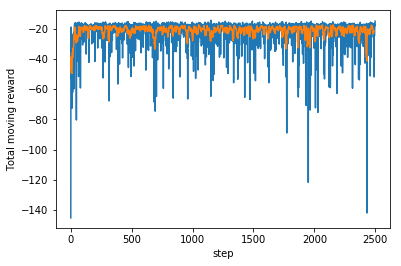

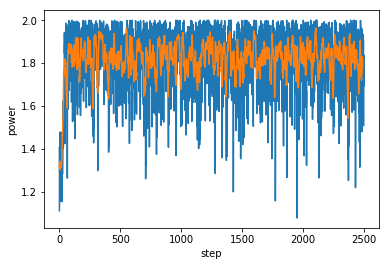

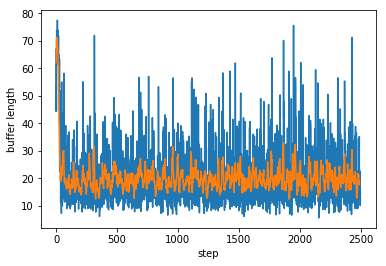

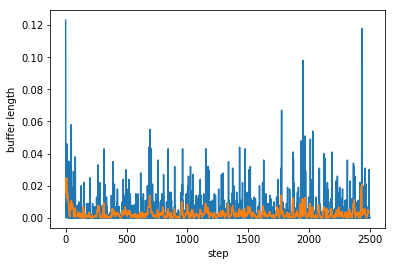

In [3]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

In [1]:
cur_init_ds_ep = env.reset()
    
cur_r_ep = np.zeros(len(user_list))
cur_p_ep = np.zeros(len(user_list))
cur_n_ep = np.zeros(len(user_list))
cur_ts_ep = np.zeros(len(user_list))
cur_rs_ep = np.zeros(len(user_list))
cur_ps_ep = np.zeros(len(user_list))
cur_ds_ep = np.zeros(len(user_list))
cur_ch_ep = np.zeros(len(user_list))
    
for j in range(1000):
    # first try to transmit from current state
    [cur_r, done, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
    cur_r_ep += cur_r
    cur_p_ep += cur_p
    cur_ts_ep += cur_ts
    cur_ps_ep += cur_ps
    cur_rs_ep += cur_rs
    cur_ds_ep += cur_ds
    cur_ch_ep += cur_ch
        
    print('%d:r:%f,p:%s,n:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (j, cur_r, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_init_ds_ep))
        
print('r:%f,p:%s,n:%s,tr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_n_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep))

NameError: name 'env' is not defined

In [3]:
graph = tf.get_default_graph()
inputs = graph.get_tensor_by_name("input_1"+":0")
scaled_out = graph.get_tensor_by_name("output_1"+":0")
print sess.run(scaled_out, feed_dict={inputs: [[7.22254768,2.3384,2.7784888e-05]]})

[[0.78826445 1.        ]]


In [2]:
res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit(False)
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])

0:r:-50.8910,p:1.4033,tr:1.4707,pr:1.3505,rev:2.9594,dbuf:72.5261,ch:0.00002568,ibuf:4
1:r:-57.9454,p:1.3913,tr:1.6529,pr:1.2218,rev:3.0360,dbuf:74.1439,ch:0.00002761,ibuf:30
2:r:-51.0844,p:1.1953,tr:1.5476,pr:1.2320,rev:2.8984,dbuf:73.1955,ch:0.00002990,ibuf:39
3:r:-18.2811,p:1.3469,tr:1.5860,pr:1.3673,rev:2.9762,dbuf:61.5868,ch:0.00002683,ibuf:35
4:r:-17.5547,p:1.2180,tr:1.7657,pr:1.2518,rev:3.0115,dbuf:55.9275,ch:0.00003238,ibuf:63
5:r:-55.6239,p:1.4116,tr:1.4240,pr:1.3390,rev:2.8791,dbuf:69.1011,ch:0.00002492,ibuf:48
6:r:-37.3900,p:1.2706,tr:1.3830,pr:1.5578,rev:3.0240,dbuf:59.5109,ch:0.00002915,ibuf:8
7:r:-32.6223,p:1.4738,tr:1.3452,pr:1.6902,rev:3.0674,dbuf:63.5657,ch:0.00002512,ibuf:71
8:r:-20.8140,p:1.2057,tr:1.4394,pr:1.5456,rev:3.0451,dbuf:49.6221,ch:0.00002902,ibuf:38
9:r:-19.3836,p:1.1973,tr:1.4459,pr:1.4838,rev:2.9358,dbuf:56.0717,ch:0.00002922,ibuf:86


In [3]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import ipdb as pdb
import time

MAX_EPISODE = 50
MAX_EPISODE_LEN = 1000

NUM_T = 1
NUM_R = 1
SIGMA2 = 0.3e-9

config = {'state_dim':3, 'action_dim':2};
train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                 'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                 'random_seed':1234}
user_config = [{'id':'1', 'rate':3, 'dis':100, 'action_bound':1, 
                'data_buf_size':100, 't_factor':0.9, 'penalty':1000}];

print user_config
# 0. initialize the session object
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
    
# 1. include all user in the system according to the user_config
user_list = [];
for info in user_config:
    info.update(config)
    user_list.append(MecTermLD(sess, info, train_config))
    print 'test'

# 2. create the simulation env
env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)
env.init_target_network()

res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])
sess.close()

[{'data_buf_size': 100, 'penalty': 1000, 'rate': 3, 'action_bound': 1, 'id': '1', 't_factor': 0.9, 'dis': 100}]
INFO:tensorflow:Restoring parameters from model/my_test_model
--Return--
None
> <ipython-input-3-a12846566f97>(30)<module>()
     29 graph = tf.get_default_graph()
---> 30 pdb.set_trace()
     31 

ipdb> graph
ipdb> graph.trainable_variables
*** AttributeError: 'Graph' object has no attribute 'trainable_variables'
ipdb> tf.trainable_variables()
[<tf.Variable 'fully_connected/weights:0' shape=(3, 400) dtype=float32_ref>, <tf.Variable 'fully_connected/BatchNorm/beta:0' shape=(400,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(3, 300) dtype=float32_ref>, <tf.Variable 'fully_connected_1/BatchNorm/beta:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(300, 2) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(3, 400) dtype=float32

BdbQuit: 

In [9]:
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
variable_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variable_names)
print sess.run('fully_connected_2/weights:0')

INFO:tensorflow:Restoring parameters from model/my_test_model
[[0.1545126  0.15780352]
 [0.15616506 0.15971294]
 [0.06559879 0.09880391]
 [0.06487427 0.10064688]
 [0.15168335 0.16229852]
 [0.06257845 0.09748891]
 [0.06430701 0.09924787]
 [0.06548443 0.10012874]
 [0.15782878 0.15414344]
 [0.15429462 0.17596859]
 [0.05945097 0.0991616 ]
 [0.06383383 0.09632684]
 [0.06522399 0.10438306]
 [0.06095436 0.09916781]
 [0.06635379 0.0955418 ]
 [0.06379106 0.09433711]
 [0.06133086 0.09875894]
 [0.06503102 0.09639146]
 [0.15047684 0.17412661]
 [0.15663381 0.15740666]
 [0.17768952 0.15899988]
 [0.15730077 0.14491995]
 [0.05902164 0.10017106]
 [0.06845198 0.09686822]
 [0.15724926 0.14774598]
 [0.1529071  0.16426612]
 [0.1520101  0.15706535]
 [0.16091335 0.16260217]
 [0.15082897 0.16070077]
 [0.06310375 0.09398151]
 [0.06018374 0.10056869]
 [0.05968894 0.10066012]
 [0.15474424 0.16255529]
 [0.15111688 0.1622602 ]
 [0.0838669  0.18973866]
 [0.06870251 0.24295035]
 [0.06702217 0.10505467]
 [0.1529     

In [3]:
np.save('t_08/1', [1])